In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary
from tqdm import tqdm

from PIL import Image

import gc

In [2]:
import sys
print(sys.executable)

C:\Users\twest\anaconda3\envs\deeplearning\python.exe


In [16]:
class DeepCNet(nn.Module):
    """
    DeepCNet convolutional network setup
    """

    def __init__(self, l=4, k=20):
        """
        Generate the DeepCNet network

        Args:
          l : l+1 convolutional filters, l 2x2 max-pooling layers
          k : number of conv filters in n-th conv layer = nk
        """
        super(DeepCNet, self).__init__()
        self.l = l
        self.k = k

        # input layer size N * N with N = 3 * (2 ** l)
        self.N = 3 * (2 ** self.l)

        self.conv1 = nn.Conv2d(1,self.k,3)
        self.conv2 = nn.Conv2d(self.k,2*self.k,2)
        self.conv3 = nn.Conv2d(2*self.k,3*self.k,2)
        self.conv4 = nn.Conv2d(3*self.k,4*self.k,2)
        self.conv5 = nn.Conv2d(4*self.k,5*self.k,2)
        #self.conv6 = nn.Conv2d(5*self.k,6*self.k,2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.softmax = nn.Softmax(dim=1)
        self.fc = nn.Linear((l+1)*k,183, bias= True)
        self.batch_norm1 = nn.BatchNorm2d(self.k)
        self.batch_norm2 = nn.BatchNorm2d(2*self.k)
        self.batch_norm3 = nn.BatchNorm2d(3*self.k)
        self.batch_norm4 = nn.BatchNorm2d(4*self.k)
        self.batch_norm5 = nn.BatchNorm2d(5*self.k)
        #self.batch_norm6 = nn.BatchNorm2d(6*self.k)


    def forward(self,x):
        x = self.conv1(x)
        
        if x.requires_grad:
            x.register_hook(lambda grad1: print("average of absolute gradients 1",torch.mean(torch.abs(grad1))))
            #x.register_hook(lambda grad1: print("maximum gradients 1",torch.max(grad1)))

        #x.register_hook(lambda y: print("var grad:", y))
        
        #print(self.conv1.weights)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        
        #x.register_hook(lambda y: print("var grad:", y))
        
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        
        #x.register_hook(lambda y: print("var grad:", y))
        
        x = self.batch_norm3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv4(x)
        
        #x.register_hook(lambda y: print("var grad:", y))
        
        x = self.batch_norm4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv5(x)
        
        #x.register_hook(lambda y: print("var grad:", y))
        
        #x = self.batch_norm5(x)
        #x = self.relu(x)
        #x = self.maxpool(x)
        #x = self.conv6(x)
        
        #x.register_hook(lambda y: print("var grad:", y))
        
        #x = self.batch_norm6(x)
        x = self.batch_norm5(x)
        #x = self.batch_norm4(x)

        x = self.relu(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x) 
        x = self.softmax(x)

        return x

In [ ]:
class DataAssamese(torch.utils.data.Dataset):
    def _init_(self, data_path=None, labels_path=None, 
                 transform=None, dataset: torch.utils.data.Dataset =None, 
                 data : np.ndarray = None, labels: np.ndarray = None,
                 mean : float = None, std : float = None,
                 transform_data=False):
        torch.utils.data.Dataset._init_(self)
        self.transform_data = transform_data
        #self.data = np.load(data_path)
        #self.labels = np.load(labels_path)
        self.data = data
        self.labels = labels
        
        if mean == None and std == None:
                # stats of the dataset
            self.mean = np.mean(self.data[:,:,:])
            self.std = np.std(self.data[:,:,:])
            # for test set, use mean and std from
            # the train set to normalize
        else:
            self.mean = mean
            self.std = std
            # Normalize by default!
        self.normalize = transforms.Normalize(mean=(self.mean,),
                                            std = (self.std,))
        
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            self.normalize
        ])
        
        if transform is not None:
            self.transforms = transforms.Compose([
                transforms.ToTensor(),
                transform,
                self.normalize                                
            ])
        else:
            print("Using the default transformations")
            self.transforms = transforms.Compose([
                transforms.ToTensor(),
                self.normalize                                
            ])
            
        
    
    def _getitem_(self,n):
        
        if self.transform_data:
            data = self.data[n]
            label = self.labels[n]
            return np.array(self.transforms(data)), label
        
        else:
        
            data = self.data[n].astype(np.float32)
            
            label = self.labels[n].astype(np.float32)
            return np.array(self.transforms(data)), label

    def _len_(self):
        return len(self.data)

In [ ]:
affine = transforms.RandomAffine(degrees = (-10,10), 
                                 translate=(0.1,0.1),
                                 scale = (0.8, 1.2),
                                 shear = (-0.3, 0.3), 
                                 fill=1)

In [14]:
test_labels_path = 'C:/Users/twest/Documents/school/Master/Deep Learning/Project/Code/testlabels_183.npy'
test_data_path = 'C:/Users/twest/Documents/school/Master/Deep Learning/Project/Code/testdata48_183.npy'
train_labels_path = 'C:/Users/twest/Documents/school/Master/Deep Learning/Project/Code/traininglabels_183.npy'
train_data_path = 'C:/Users/twest/Documents/school/Master/Deep Learning/Project/Code/trainingdata48_183.npy'
test_labels = np.load(test_labels_path)
test_data = np.load(test_data_path)
train_labels = np.load(train_labels_path)
train_data = np.load(train_data_path)
print(test_labels.shape)
print(test_data.shape)
print(train_labels.shape)
print(train_data.shape)

#binarize
test_data[test_data>0] = 1
test_data[test_data<0] = 0
train_data[train_data>0] = 1

(1647,)
(1647, 48, 48)
(6588,)
(6588, 48, 48)


In [ ]:
def augment_dataset(dat, label):
    """ Augments the dataset and returns a siamese dataset
    with 9x as much data, the original data in the argument dataset
    plus 8 affine transformations of that input data"""
    # Create a data loader of the dataset
    tensors_train = torch.Tensor(dat), torch.Tensor(label).long()
    loader = DataLoader(TensorDataset(*tensors_train), batch_size=10000)

    # Altered samples of the input data
    _altered = None
    mean = None
    std = None

    # Check the size of the batches and so on
    # Read in batches of 15000, and do it 
    for j in range(8):
        gc.collect()
        print("starting with round ",j)
        for i, (x1, _) in enumerate(loader):
            if i % 1 == 0:
                print(i)
            x1 = np.expand_dims(x1, 1)
            # concatenate the arrays by their second axis
            _data = x1
            _mean = np.mean(_data)
            _std = np.std(_data)
            if mean is None:
                mean = _mean
                std = _std
            else:
                mean = (mean*len(_altered) +  _mean*len(_data))/(len(_altered)+len(_data))
                std = (std*len(_altered) +  _std*len(_data))/(len(_altered)+len(_data))
            # add them to the dataset
            if _altered is None:
                _altered = _data
            else:
                # Concatenate the existing data and the new batch
                _altered = np.concatenate((_altered, _data), axis = 0)
      
        print(f'Size of the datasets -> {_altered.shape}')

    # Now create a new dataset with the newly defined data
    # Concatenate the original dataset with the new one
    d = tensors_train
    dat = dat[:,None,:,:]
    all_data = np.concatenate((dat, _altered), axis = 0)
    labels = np.tile(label, 9)
    # Add mean of the original datset
    #mean = (mean*len(_altered) +  d.mean*len(d))/(len(_altered)+len(d))
    #std = (std*len(_altered) +  d.std*len(d))/(len(_altered)+len(d))
    tensors = torch.Tensor(all_data), torch.Tensor(labels).long()
    d = DataLoader(TensorDataset(*tensors), batch_size=500)
    return d

In [ ]:
train_loader = augment_dataset(train_data, train_labels)
test_loader = augment_dataset(test_data, test_labels)

In [ ]:
#import the augmented dataset
test_labels_path = 'C:/Users/twest/Documents/school/Master/Deep Learning/Project/Code/testlabels_183.npy'
test_data_path = 'C:/Users/twest/Documents/school/Master/Deep Learning/Project/Code/testdata48_183.npy'
train_labels_path = 'C:/Users/twest/Documents/school/Master/Deep Learning/Project/Code/Train_labels_48.npy'
train_data_path = 'C:/Users/twest/Documents/school/Master/Deep Learning/Project/Code/Train_augmented_48.npy'
test_labels = np.load(test_labels_path)
test_data = np.load(test_data_path)
train_labels = np.load(train_labels_path)
train_data = np.load(train_data_path)

In [15]:
#nz = train_data[np.nonzero(train_data)]
#print(nz)

tensors_train = torch.Tensor(train_data), torch.Tensor(train_labels).long()
tensors_test = torch.Tensor(test_data), torch.Tensor(test_labels).long()

train_loader = DataLoader(TensorDataset(*tensors_train), batch_size=650, shuffle=True)
test_loader = DataLoader(TensorDataset(*tensors_test), batch_size=1000, shuffle=True)

#train_d = DataAssamese(train_data_path, train_labels_path,transform_data=True, transform=affine)
#train_loader = torch.utils.data.DataLoader(train_d, batch_size=128, shuffle=True, pin_memory=True, num_workers=2)

#test_d = DataAssamese(test_data_path, test_labels_path)
#test_loader = torch.utils.data.DataLoader(train_d, batch_size=128, shuffle=True, pin_memory=True, num_workers=2)

#plt.figure(1)
#plt.imshow(train_data[5,:,:])

#plt.figure(2)
#plt.imshow(train_data[6231,:,:])

In [ ]:
# Preprocessing data: convert to tensors and normalize by subtracting dataset
# mean and dividing by std.
transform = transforms.Compose([transforms.Resize(96),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

# Get data from torchvision.datasets
train_data = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('../data', train=False, download=True, transform=transform)

# Define data loaders used to iterate through dataset
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000)

In [ ]:
#print(train_data)
plt.imshow(train_data[3014,:,:])
plt.show()

In [17]:
def try_gpu():
    """
    If GPU is available, return torch.device as cuda:0; else return torch.device
    as cpu.
    """
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

def evaluate_accuracy(data_loader, net, device=torch.device('cpu')):
    """Evaluate accuracy of a model on the given data set."""
    net.eval()  #make sure network is in evaluation mode

    #init
    acc_sum = torch.tensor([0], dtype=torch.float32, device=device)
    n = 0

    for X, y in data_loader:
        # Copy the data to device.
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y = y.long()
            X= X[:, None,:,:]
            acc_sum += torch.sum((torch.argmax(net(X), dim=1) == y))
            n += y.shape[0] #increases with the number of samples in the batch
    return acc_sum.item()/n

def plotweights(x_in): #Needs generalisation for k not equal to 20 
    fig, axs = plt.subplots(5, 4, figsize=(5, 4))
    for k in range(20):
        x = x_in[k,:,:,:]
        x = x.detach()
        x = np.squeeze(x,axis=0)
        ax = axs[k // 4][k % 4]
        ax.imshow(x, cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def initialiseparams(conv_layers,lin_layers, std_w, std_b):
    for clayer in conv_layers:
        nn.Parameter(nn.init.normal_(clayer.weight, mean = 0.0, std = std_w))
        nn.Parameter(nn.init.normal_(clayer.bias, mean = 0.5, std = std_b))
    for llayer in lin_layers:
        nn.Parameter(nn.init.normal_(llayer.weight, mean = 0.0, std = std_w))
        nn.Parameter(nn.init.normal_(llayer.bias, mean = 0.0, std = std_b))

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

cuda:0
tensor([[[-0.1679, -0.1765, -0.2100],
         [-0.0153,  0.3261,  0.1361],
         [ 0.1934,  0.0108, -0.2547]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


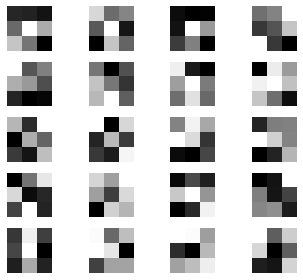

average of absolute gradients 1 tensor(5.5669e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.4795e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5709e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.4548e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6995e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5936e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7188e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.3960e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.4959e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5455e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.7703e-07, device='cuda:0')


  0%|                                                                               | 1/1000 [00:04<1:22:31,  4.96s/it]

Epoch: 1
Accuracy of train set: 1%
Accuracy of test set: 0%

tensor([[[-0.1677, -0.1759, -0.2098],
         [-0.0153,  0.3263,  0.1362],
         [ 0.1930,  0.0111, -0.2544]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


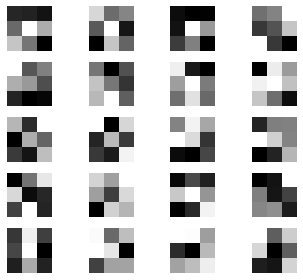

average of absolute gradients 1 tensor(5.7035e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7213e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.4937e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6916e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5591e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5015e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5281e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5612e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6315e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.3487e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.2794e-07, device='cuda:0')


  0%|▏                                                                              | 2/1000 [00:10<1:23:26,  5.02s/it]

Epoch: 2
Accuracy of train set: 1%
Accuracy of test set: 1%

tensor([[[-0.1676, -0.1755, -0.2097],
         [-0.0153,  0.3265,  0.1362],
         [ 0.1927,  0.0113, -0.2542]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


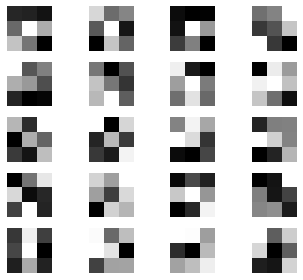

average of absolute gradients 1 tensor(5.6865e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.3445e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5736e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5606e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5303e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7526e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5954e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6741e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5251e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6544e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.3618e-07, device='cuda:0')


  0%|▏                                                                              | 3/1000 [00:15<1:23:27,  5.02s/it]

Epoch: 3
Accuracy of train set: 1%
Accuracy of test set: 1%

tensor([[[-0.1674, -0.1751, -0.2095],
         [-0.0154,  0.3267,  0.1362],
         [ 0.1923,  0.0116, -0.2541]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


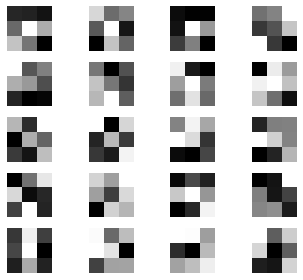

average of absolute gradients 1 tensor(5.5385e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5872e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5373e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5765e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5915e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.4882e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7492e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6720e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6752e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5931e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.0887e-07, device='cuda:0')


  0%|▎                                                                              | 4/1000 [00:20<1:23:15,  5.02s/it]

Epoch: 4
Accuracy of train set: 1%
Accuracy of test set: 1%

tensor([[[-0.1674, -0.1749, -0.2093],
         [-0.0155,  0.3268,  0.1362],
         [ 0.1919,  0.0118, -0.2539]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


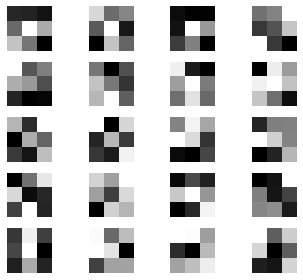

average of absolute gradients 1 tensor(5.7660e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6728e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.4657e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5526e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6554e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6318e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8848e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5410e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7458e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.4140e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.2706e-07, device='cuda:0')


  0%|▍                                                                              | 5/1000 [00:25<1:23:53,  5.06s/it]

Epoch: 5
Accuracy of train set: 1%
Accuracy of test set: 1%

tensor([[[-0.1673, -0.1744, -0.2092],
         [-0.0157,  0.3270,  0.1363],
         [ 0.1914,  0.0120, -0.2537]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


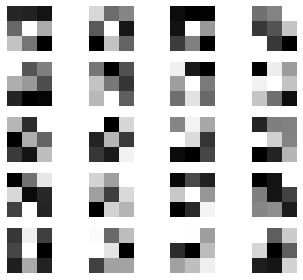

average of absolute gradients 1 tensor(5.8646e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6653e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9202e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6654e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5838e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6307e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6175e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5044e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5721e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5574e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.4984e-07, device='cuda:0')


  1%|▍                                                                              | 6/1000 [00:30<1:24:02,  5.07s/it]

Epoch: 6
Accuracy of train set: 1%
Accuracy of test set: 1%

tensor([[[-0.1673, -0.1740, -0.2091],
         [-0.0159,  0.3271,  0.1364],
         [ 0.1910,  0.0124, -0.2535]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


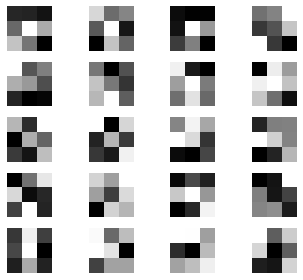

average of absolute gradients 1 tensor(5.7447e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8269e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5524e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8345e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6710e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7023e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9255e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5496e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6148e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6188e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.1249e-07, device='cuda:0')


  1%|▌                                                                              | 7/1000 [00:35<1:23:41,  5.06s/it]

Epoch: 7
Accuracy of train set: 1%
Accuracy of test set: 1%

tensor([[[-0.1673, -0.1736, -0.2089],
         [-0.0160,  0.3273,  0.1364],
         [ 0.1905,  0.0128, -0.2533]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


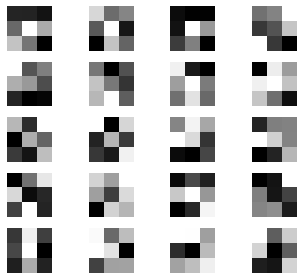

average of absolute gradients 1 tensor(5.7898e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5593e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8281e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6610e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5480e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7171e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9408e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8559e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9268e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5074e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.3328e-07, device='cuda:0')


  1%|▋                                                                              | 8/1000 [00:40<1:23:50,  5.07s/it]

Epoch: 8
Accuracy of train set: 1%
Accuracy of test set: 1%

tensor([[[-0.1674, -0.1732, -0.2089],
         [-0.0162,  0.3273,  0.1363],
         [ 0.1901,  0.0130, -0.2532]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


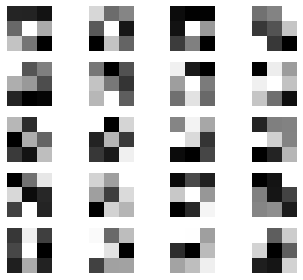

average of absolute gradients 1 tensor(5.8154e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6929e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7195e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7454e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9306e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8305e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7690e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5717e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5449e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6826e-08, device='cuda:0')
average of absolute gradients 1 tensor(3.7526e-07, device='cuda:0')


  1%|▋                                                                              | 9/1000 [00:45<1:23:35,  5.06s/it]

Epoch: 9
Accuracy of train set: 1%
Accuracy of test set: 1%

tensor([[[-0.1675, -0.1730, -0.2088],
         [-0.0163,  0.3273,  0.1362],
         [ 0.1896,  0.0132, -0.2531]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


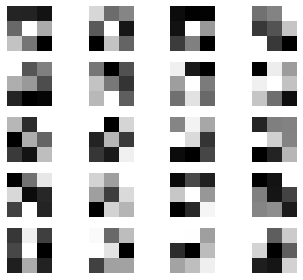

average of absolute gradients 1 tensor(5.5757e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7190e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8236e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6894e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7730e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7104e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5420e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5586e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7934e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7456e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.3633e-07, device='cuda:0')


  1%|▊                                                                             | 10/1000 [00:50<1:23:09,  5.04s/it]

Epoch: 10
Accuracy of train set: 1%
Accuracy of test set: 1%

tensor([[[-0.1675, -0.1726, -0.2087],
         [-0.0165,  0.3272,  0.1363],
         [ 0.1893,  0.0134, -0.2529]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


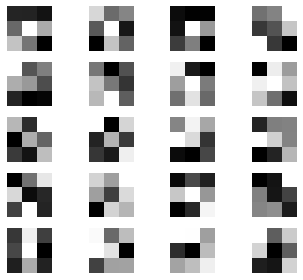

average of absolute gradients 1 tensor(5.6354e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6506e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5757e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7475e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9894e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6955e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6960e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9059e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5992e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7111e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.5928e-07, device='cuda:0')


  1%|▊                                                                             | 11/1000 [00:55<1:23:10,  5.05s/it]

Epoch: 11
Accuracy of train set: 1%
Accuracy of test set: 1%

tensor([[[-0.1675, -0.1725, -0.2086],
         [-0.0167,  0.3271,  0.1363],
         [ 0.1889,  0.0137, -0.2527]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


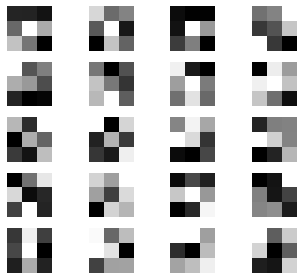

average of absolute gradients 1 tensor(5.6838e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5357e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7217e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8204e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8498e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5694e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8051e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9315e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6161e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0911e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.7668e-07, device='cuda:0')


  1%|▉                                                                             | 12/1000 [01:00<1:23:20,  5.06s/it]

Epoch: 12
Accuracy of train set: 2%
Accuracy of test set: 1%

tensor([[[-0.1676, -0.1721, -0.2085],
         [-0.0168,  0.3272,  0.1362],
         [ 0.1884,  0.0139, -0.2526]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


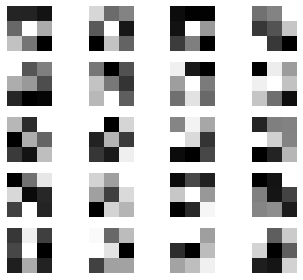

average of absolute gradients 1 tensor(5.8417e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8391e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6255e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8769e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6746e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7473e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7052e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9782e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6843e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0179e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.5615e-07, device='cuda:0')


  1%|█                                                                             | 13/1000 [01:05<1:23:16,  5.06s/it]

Epoch: 13
Accuracy of train set: 2%
Accuracy of test set: 1%

tensor([[[-0.1677, -0.1718, -0.2084],
         [-0.0170,  0.3271,  0.1362],
         [ 0.1881,  0.0141, -0.2525]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


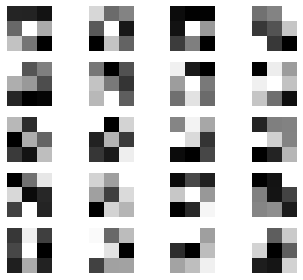

average of absolute gradients 1 tensor(5.8044e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7217e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8958e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8623e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6926e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0158e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7430e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8970e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9610e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7547e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.3339e-07, device='cuda:0')


  1%|█                                                                             | 14/1000 [01:10<1:23:21,  5.07s/it]

Epoch: 14
Accuracy of train set: 2%
Accuracy of test set: 1%

tensor([[[-0.1678, -0.1715, -0.2083],
         [-0.0172,  0.3270,  0.1362],
         [ 0.1878,  0.0144, -0.2523]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


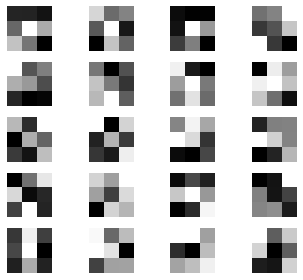

average of absolute gradients 1 tensor(5.8384e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8376e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9684e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9696e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8856e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7148e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7845e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7907e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9974e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8536e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.2647e-07, device='cuda:0')


  2%|█▏                                                                            | 15/1000 [01:15<1:23:28,  5.08s/it]

Epoch: 15
Accuracy of train set: 2%
Accuracy of test set: 1%

tensor([[[-0.1679, -0.1712, -0.2082],
         [-0.0174,  0.3269,  0.1362],
         [ 0.1876,  0.0147, -0.2521]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


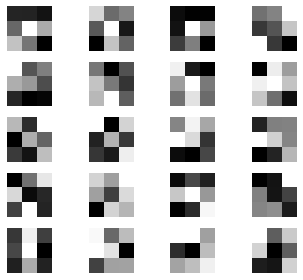

average of absolute gradients 1 tensor(5.7177e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9678e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9268e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1692e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7483e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7440e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0400e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8896e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9230e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8589e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.3547e-07, device='cuda:0')


  2%|█▏                                                                            | 16/1000 [01:20<1:23:27,  5.09s/it]

Epoch: 16
Accuracy of train set: 2%
Accuracy of test set: 1%

tensor([[[-0.1680, -0.1711, -0.2082],
         [-0.0176,  0.3267,  0.1361],
         [ 0.1872,  0.0150, -0.2520]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


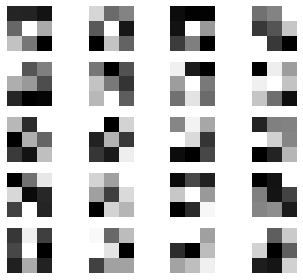

average of absolute gradients 1 tensor(6.0352e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8063e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.2535e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8148e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8708e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8534e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8354e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7860e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1102e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9505e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.0288e-07, device='cuda:0')


  2%|█▎                                                                            | 17/1000 [01:26<1:23:09,  5.08s/it]

Epoch: 17
Accuracy of train set: 2%
Accuracy of test set: 1%

tensor([[[-0.1681, -0.1708, -0.2082],
         [-0.0179,  0.3266,  0.1360],
         [ 0.1869,  0.0153, -0.2518]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


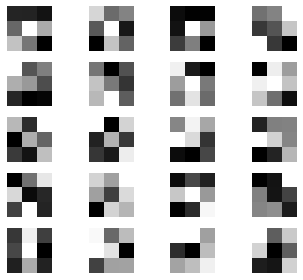

average of absolute gradients 1 tensor(5.9317e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9725e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8996e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9543e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8381e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7161e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0124e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8565e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1723e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0856e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.3764e-07, device='cuda:0')


  2%|█▍                                                                            | 18/1000 [01:31<1:23:28,  5.10s/it]

Epoch: 18
Accuracy of train set: 2%
Accuracy of test set: 1%

tensor([[[-0.1682, -0.1705, -0.2081],
         [-0.0181,  0.3265,  0.1359],
         [ 0.1867,  0.0157, -0.2517]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


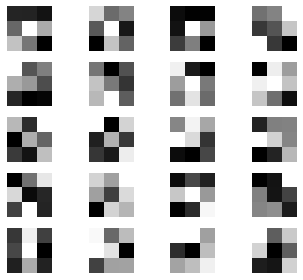

average of absolute gradients 1 tensor(5.8938e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8425e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1142e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9167e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1325e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0860e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8731e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9924e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8916e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0399e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.5087e-07, device='cuda:0')


  2%|█▍                                                                            | 19/1000 [01:36<1:23:03,  5.08s/it]

Epoch: 19
Accuracy of train set: 2%
Accuracy of test set: 1%

tensor([[[-0.1683, -0.1702, -0.2081],
         [-0.0183,  0.3264,  0.1358],
         [ 0.1864,  0.0159, -0.2515]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


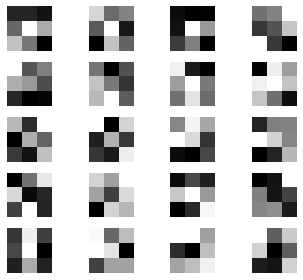

average of absolute gradients 1 tensor(6.2690e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9335e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9699e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1147e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9268e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9534e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.7743e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9378e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0769e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1822e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.4823e-07, device='cuda:0')


  2%|█▌                                                                            | 20/1000 [01:41<1:22:18,  5.04s/it]

Epoch: 20
Accuracy of train set: 2%
Accuracy of test set: 2%

tensor([[[-0.1684, -0.1698, -0.2081],
         [-0.0185,  0.3263,  0.1358],
         [ 0.1860,  0.0162, -0.2514]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


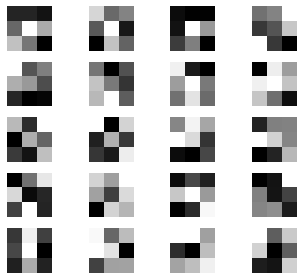

average of absolute gradients 1 tensor(6.0314e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0822e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.2771e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0009e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9883e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9520e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0164e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9689e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9408e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0517e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.7442e-07, device='cuda:0')


  2%|█▋                                                                            | 21/1000 [01:46<1:21:43,  5.01s/it]

Epoch: 21
Accuracy of train set: 2%
Accuracy of test set: 2%

tensor([[[-0.1684, -0.1696, -0.2081],
         [-0.0186,  0.3262,  0.1356],
         [ 0.1858,  0.0165, -0.2513]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


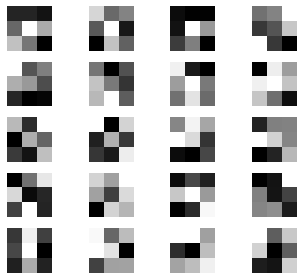

average of absolute gradients 1 tensor(6.0607e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9291e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9891e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0371e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0629e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1710e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4577e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1738e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0360e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8157e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.7888e-07, device='cuda:0')


  2%|█▋                                                                            | 22/1000 [01:50<1:21:08,  4.98s/it]

Epoch: 22
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1684, -0.1693, -0.2080],
         [-0.0187,  0.3261,  0.1356],
         [ 0.1854,  0.0168, -0.2512]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


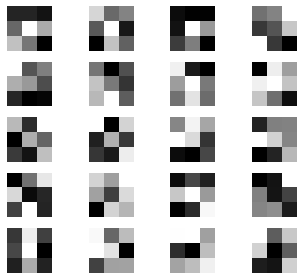

average of absolute gradients 1 tensor(6.4148e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.2531e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1500e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1944e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8920e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0601e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9579e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1238e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1682e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.8452e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.8183e-07, device='cuda:0')


  2%|█▊                                                                            | 23/1000 [01:55<1:20:35,  4.95s/it]

Epoch: 23
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1684, -0.1690, -0.2081],
         [-0.0188,  0.3260,  0.1354],
         [ 0.1851,  0.0171, -0.2510]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


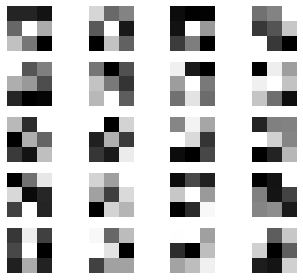

average of absolute gradients 1 tensor(6.4475e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1965e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1984e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1611e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0206e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1397e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1730e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0730e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0420e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9239e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.5524e-07, device='cuda:0')


  2%|█▊                                                                            | 24/1000 [02:00<1:20:14,  4.93s/it]

Epoch: 24
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1684, -0.1687, -0.2081],
         [-0.0191,  0.3258,  0.1354],
         [ 0.1849,  0.0175, -0.2509]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


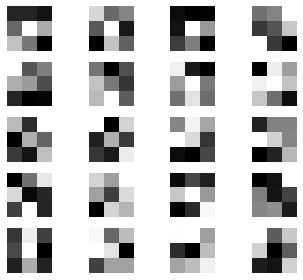

average of absolute gradients 1 tensor(6.3527e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0221e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1228e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.9177e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4073e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3171e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.2600e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1086e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0677e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0974e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.4380e-07, device='cuda:0')


  2%|█▉                                                                            | 25/1000 [02:05<1:19:51,  4.91s/it]

Epoch: 25
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1684, -0.1684, -0.2081],
         [-0.0193,  0.3257,  0.1354],
         [ 0.1847,  0.0178, -0.2508]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


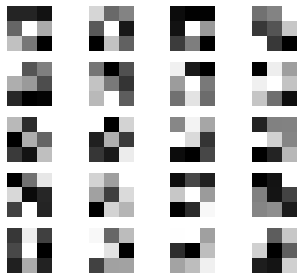

average of absolute gradients 1 tensor(6.1602e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4878e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1462e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0824e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.2576e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0502e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1570e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3789e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1832e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1350e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.5049e-07, device='cuda:0')


  3%|██                                                                            | 26/1000 [02:10<1:19:32,  4.90s/it]

Epoch: 26
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1684, -0.1681, -0.2081],
         [-0.0195,  0.3255,  0.1353],
         [ 0.1844,  0.0182, -0.2506]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


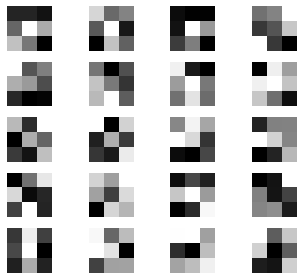

average of absolute gradients 1 tensor(6.1796e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1938e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.2627e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.2154e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3721e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3323e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3247e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0616e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0604e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4067e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.5836e-07, device='cuda:0')


  3%|██                                                                            | 27/1000 [02:15<1:19:26,  4.90s/it]

Epoch: 27
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1684, -0.1678, -0.2080],
         [-0.0196,  0.3254,  0.1353],
         [ 0.1843,  0.0185, -0.2505]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


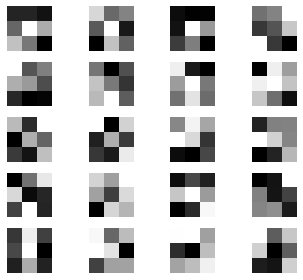

average of absolute gradients 1 tensor(6.2327e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3264e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4023e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1079e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4460e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4009e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3060e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1853e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.2663e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0849e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.6077e-07, device='cuda:0')


  3%|██▏                                                                           | 28/1000 [02:20<1:19:18,  4.90s/it]

Epoch: 28
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1684, -0.1674, -0.2080],
         [-0.0196,  0.3253,  0.1353],
         [ 0.1842,  0.0186, -0.2503]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


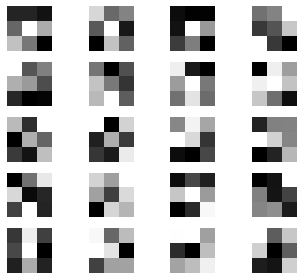

average of absolute gradients 1 tensor(6.4564e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1285e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0959e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.2155e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.2067e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4178e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4174e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4654e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1478e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3318e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.1797e-07, device='cuda:0')


  3%|██▎                                                                           | 29/1000 [02:25<1:19:14,  4.90s/it]

Epoch: 29
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1684, -0.1669, -0.2080],
         [-0.0196,  0.3252,  0.1352],
         [ 0.1840,  0.0190, -0.2501]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


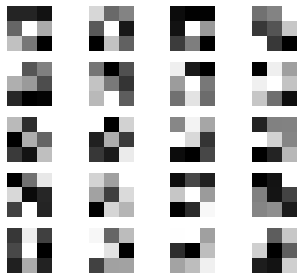

average of absolute gradients 1 tensor(6.4024e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.7003e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5004e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.0031e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3741e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.2292e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3005e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4028e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.2253e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.2286e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.5768e-07, device='cuda:0')


  3%|██▎                                                                           | 30/1000 [02:30<1:19:10,  4.90s/it]

Epoch: 30
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1685, -0.1667, -0.2080],
         [-0.0198,  0.3249,  0.1353],
         [ 0.1838,  0.0190, -0.2500]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


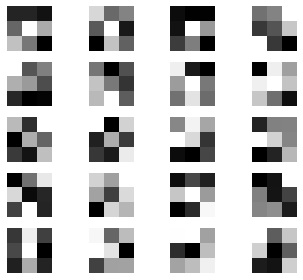

average of absolute gradients 1 tensor(6.6449e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3998e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4287e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4186e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.2499e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1805e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4098e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3306e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.2613e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.2735e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.5280e-07, device='cuda:0')


  3%|██▍                                                                           | 31/1000 [02:34<1:19:06,  4.90s/it]

Epoch: 31
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1685, -0.1664, -0.2081],
         [-0.0200,  0.3247,  0.1352],
         [ 0.1837,  0.0193, -0.2498]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


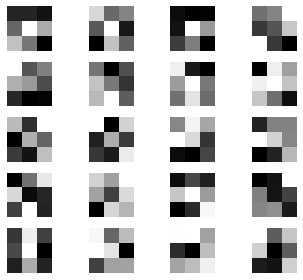

average of absolute gradients 1 tensor(6.4584e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3555e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6277e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3655e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5616e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.2116e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5535e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.1677e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5418e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4106e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.6836e-07, device='cuda:0')


  3%|██▍                                                                           | 32/1000 [02:39<1:18:58,  4.89s/it]

Epoch: 32
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1686, -0.1660, -0.2081],
         [-0.0202,  0.3245,  0.1352],
         [ 0.1836,  0.0196, -0.2497]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


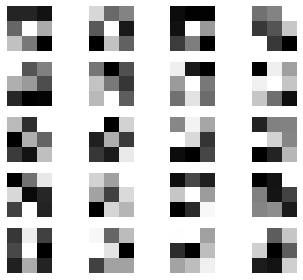

average of absolute gradients 1 tensor(6.4254e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4608e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3867e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.2975e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3277e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3981e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3588e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.7094e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5174e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5813e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.2041e-07, device='cuda:0')


  3%|██▌                                                                           | 33/1000 [02:44<1:18:53,  4.89s/it]

Epoch: 33
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1686, -0.1655, -0.2081],
         [-0.0202,  0.3244,  0.1353],
         [ 0.1834,  0.0199, -0.2496]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


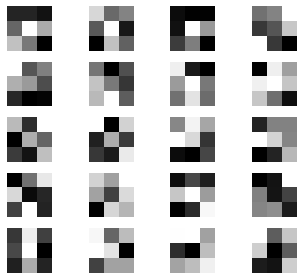

average of absolute gradients 1 tensor(6.3558e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5544e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6893e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4580e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4283e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4116e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3179e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4164e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4629e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.8518e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.9720e-07, device='cuda:0')


  3%|██▋                                                                           | 34/1000 [02:49<1:18:44,  4.89s/it]

Epoch: 34
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1687, -0.1651, -0.2081],
         [-0.0203,  0.3243,  0.1353],
         [ 0.1832,  0.0202, -0.2494]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


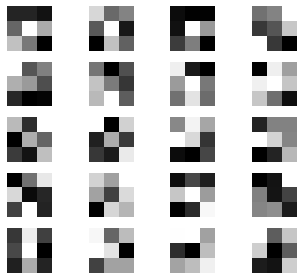

average of absolute gradients 1 tensor(6.4662e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4176e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5380e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.8348e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6423e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4365e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5516e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3328e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6362e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5305e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.5747e-07, device='cuda:0')


  4%|██▋                                                                           | 35/1000 [02:54<1:18:39,  4.89s/it]

Epoch: 35
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1687, -0.1648, -0.2080],
         [-0.0204,  0.3241,  0.1353],
         [ 0.1831,  0.0203, -0.2493]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


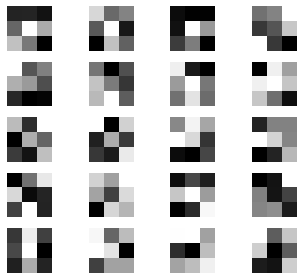

average of absolute gradients 1 tensor(6.3914e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6556e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5241e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5052e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6451e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4806e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6585e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4038e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5281e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6856e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.7471e-07, device='cuda:0')


  4%|██▊                                                                           | 36/1000 [02:59<1:18:41,  4.90s/it]

Epoch: 36
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1687, -0.1645, -0.2081],
         [-0.0205,  0.3238,  0.1353],
         [ 0.1830,  0.0203, -0.2491]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


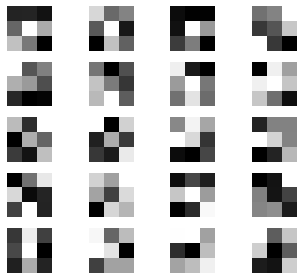

average of absolute gradients 1 tensor(6.6179e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4878e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.7029e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.7855e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6450e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6812e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5289e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4628e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5185e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5260e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.3356e-07, device='cuda:0')


  4%|██▉                                                                           | 37/1000 [03:04<1:18:26,  4.89s/it]

Epoch: 37
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1688, -0.1641, -0.2080],
         [-0.0205,  0.3237,  0.1353],
         [ 0.1827,  0.0205, -0.2490]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


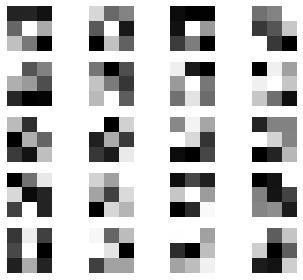

average of absolute gradients 1 tensor(6.7942e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6300e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4933e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4501e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6022e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5709e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6333e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6764e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.8580e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.7172e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.6452e-07, device='cuda:0')


  4%|██▉                                                                           | 38/1000 [03:09<1:18:22,  4.89s/it]

Epoch: 38
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1689, -0.1637, -0.2080],
         [-0.0207,  0.3235,  0.1353],
         [ 0.1825,  0.0207, -0.2489]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


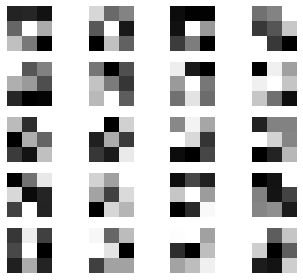

average of absolute gradients 1 tensor(6.8272e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6738e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.9660e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6903e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4531e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.8644e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4952e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4061e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.8506e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5381e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.0968e-07, device='cuda:0')


  4%|███                                                                           | 39/1000 [03:14<1:18:18,  4.89s/it]

Epoch: 39
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1691, -0.1634, -0.2079],
         [-0.0207,  0.3233,  0.1354],
         [ 0.1823,  0.0207, -0.2488]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


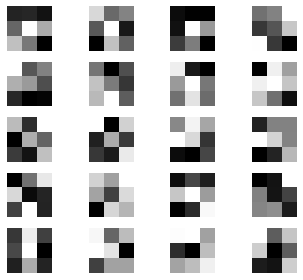

average of absolute gradients 1 tensor(6.8880e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.1005e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.9231e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3166e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.9439e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.7021e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3883e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.8718e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6116e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.7056e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.0482e-07, device='cuda:0')


  4%|███                                                                           | 40/1000 [03:19<1:18:22,  4.90s/it]

Epoch: 40
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1692, -0.1630, -0.2079],
         [-0.0208,  0.3231,  0.1355],
         [ 0.1821,  0.0209, -0.2486]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


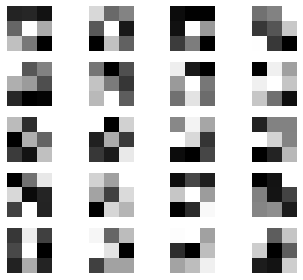

average of absolute gradients 1 tensor(6.9675e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6328e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.9254e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.7829e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6787e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.9079e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6570e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5615e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.0058e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4547e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.4557e-07, device='cuda:0')


  4%|███▏                                                                          | 41/1000 [03:23<1:18:32,  4.91s/it]

Epoch: 41
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1693, -0.1629, -0.2080],
         [-0.0208,  0.3227,  0.1354],
         [ 0.1819,  0.0210, -0.2485]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


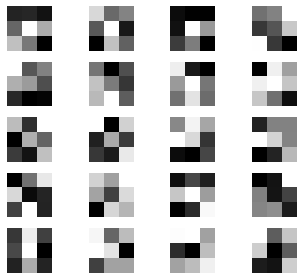

average of absolute gradients 1 tensor(6.8125e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.1315e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5482e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.0533e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.8568e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.0575e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6573e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.3639e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.9821e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6685e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.0818e-07, device='cuda:0')


  4%|███▎                                                                          | 42/1000 [03:28<1:18:26,  4.91s/it]

Epoch: 42
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1694, -0.1625, -0.2079],
         [-0.0208,  0.3227,  0.1356],
         [ 0.1816,  0.0211, -0.2483]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


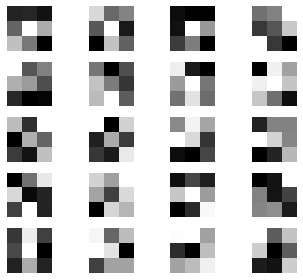

average of absolute gradients 1 tensor(7.0994e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5356e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.8287e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.0117e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.7953e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6838e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.9137e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.9562e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.0342e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.7050e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.2232e-07, device='cuda:0')


  4%|███▎                                                                          | 43/1000 [03:33<1:18:16,  4.91s/it]

Epoch: 43
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1695, -0.1622, -0.2079],
         [-0.0208,  0.3226,  0.1356],
         [ 0.1812,  0.0212, -0.2481]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


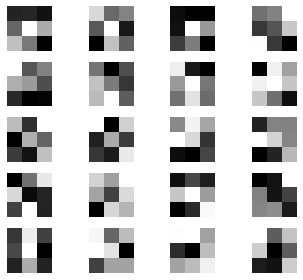

average of absolute gradients 1 tensor(7.2178e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.9591e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.7467e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.7221e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.2852e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.9494e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.7803e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.9119e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6436e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.8680e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6576e-07, device='cuda:0')


  4%|███▍                                                                          | 44/1000 [03:38<1:18:06,  4.90s/it]

Epoch: 44
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1697, -0.1618, -0.2079],
         [-0.0209,  0.3225,  0.1355],
         [ 0.1811,  0.0214, -0.2479]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


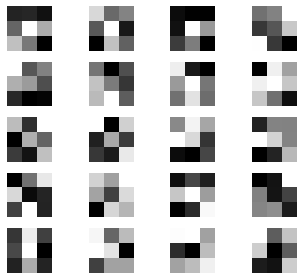

average of absolute gradients 1 tensor(6.8601e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.8782e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.8039e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.9697e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.1323e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.8172e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.1466e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.8152e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.8760e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.5913e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.2129e-07, device='cuda:0')


  4%|███▌                                                                          | 45/1000 [03:43<1:17:52,  4.89s/it]

Epoch: 45
Accuracy of train set: 5%
Accuracy of test set: 2%

tensor([[[-0.1699, -0.1616, -0.2080],
         [-0.0212,  0.3221,  0.1354],
         [ 0.1810,  0.0214, -0.2477]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


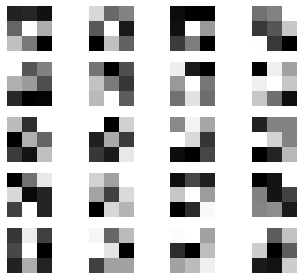

average of absolute gradients 1 tensor(7.1372e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.8661e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.8279e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.6971e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.4515e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.0774e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.4450e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.1768e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.9309e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.0239e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.4214e-07, device='cuda:0')


  5%|███▌                                                                          | 46/1000 [03:48<1:17:56,  4.90s/it]

Epoch: 46
Accuracy of train set: 5%
Accuracy of test set: 2%

tensor([[[-0.1701, -0.1613, -0.2080],
         [-0.0213,  0.3220,  0.1355],
         [ 0.1808,  0.0215, -0.2475]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


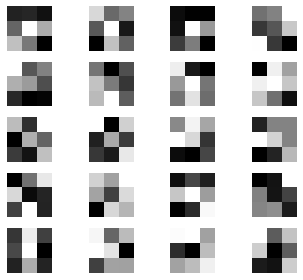

average of absolute gradients 1 tensor(7.4816e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.0959e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.2785e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.2791e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.5592e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.8054e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.7801e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.0622e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.7118e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.1212e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.8749e-07, device='cuda:0')


  5%|███▋                                                                          | 47/1000 [03:53<1:17:45,  4.90s/it]

Epoch: 47
Accuracy of train set: 5%
Accuracy of test set: 2%

tensor([[[-0.1702, -0.1611, -0.2079],
         [-0.0215,  0.3217,  0.1354],
         [ 0.1807,  0.0216, -0.2473]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


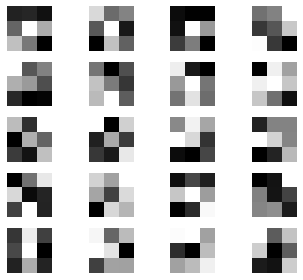

average of absolute gradients 1 tensor(7.0636e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.1517e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.1320e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.2024e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.0666e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6040e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.3220e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.3448e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.2012e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.7395e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.2782e-07, device='cuda:0')


  5%|███▋                                                                          | 48/1000 [03:58<1:17:41,  4.90s/it]

Epoch: 48
Accuracy of train set: 5%
Accuracy of test set: 2%

tensor([[[-0.1705, -0.1608, -0.2079],
         [-0.0217,  0.3214,  0.1353],
         [ 0.1808,  0.0217, -0.2471]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


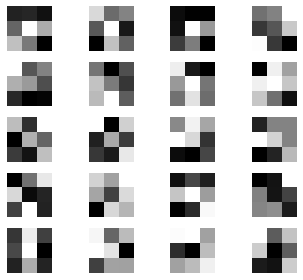

average of absolute gradients 1 tensor(6.9985e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.3168e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.3251e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.6855e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.0468e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.7988e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.0733e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.0273e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.2485e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.9151e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.4061e-07, device='cuda:0')


  5%|███▊                                                                          | 49/1000 [04:03<1:17:31,  4.89s/it]

Epoch: 49
Accuracy of train set: 5%
Accuracy of test set: 2%

tensor([[[-0.1707, -0.1607, -0.2077],
         [-0.0217,  0.3212,  0.1353],
         [ 0.1807,  0.0218, -0.2469]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


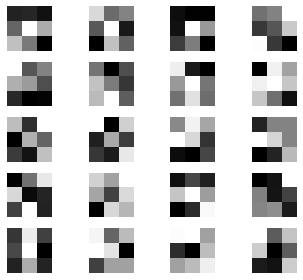

average of absolute gradients 1 tensor(7.3263e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.1047e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.1327e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.2400e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.1501e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.2010e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.3662e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.3411e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.4466e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.3996e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.9705e-07, device='cuda:0')


  5%|███▉                                                                          | 50/1000 [04:08<1:17:37,  4.90s/it]

Epoch: 50
Accuracy of train set: 5%
Accuracy of test set: 2%

tensor([[[-0.1709, -0.1604, -0.2077],
         [-0.0217,  0.3210,  0.1352],
         [ 0.1806,  0.0217, -0.2467]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


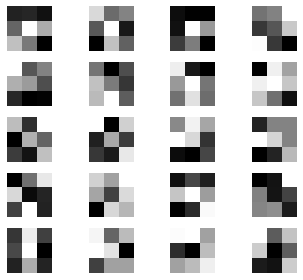

average of absolute gradients 1 tensor(6.9859e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.6951e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.2579e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.7799e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.5168e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.0657e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.3883e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.9830e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.2204e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.6250e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.5076e-07, device='cuda:0')


  5%|███▉                                                                          | 51/1000 [04:12<1:17:36,  4.91s/it]

Epoch: 51
Accuracy of train set: 5%
Accuracy of test set: 2%

tensor([[[-0.1711, -0.1602, -0.2077],
         [-0.0219,  0.3207,  0.1351],
         [ 0.1805,  0.0217, -0.2464]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


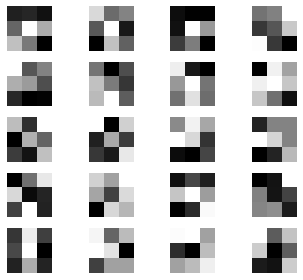

average of absolute gradients 1 tensor(7.1777e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.3793e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.1031e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.4732e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.4283e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.6801e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.9501e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.4426e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.9789e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.0651e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.3815e-07, device='cuda:0')


  5%|████                                                                          | 52/1000 [04:17<1:17:24,  4.90s/it]

Epoch: 52
Accuracy of train set: 5%
Accuracy of test set: 2%

tensor([[[-0.1713, -0.1600, -0.2076],
         [-0.0219,  0.3205,  0.1352],
         [ 0.1804,  0.0216, -0.2461]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


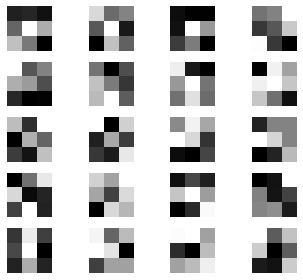

average of absolute gradients 1 tensor(7.3892e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.8764e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.6999e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.1494e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.3625e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.6756e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.9356e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.8326e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.7654e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.4819e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.2493e-07, device='cuda:0')


  5%|████▏                                                                         | 53/1000 [04:22<1:17:28,  4.91s/it]

Epoch: 53
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1717, -0.1597, -0.2077],
         [-0.0221,  0.3201,  0.1352],
         [ 0.1802,  0.0216, -0.2459]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


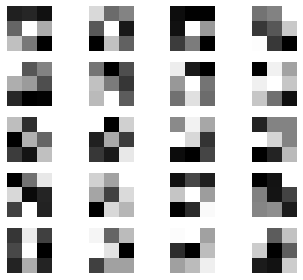

average of absolute gradients 1 tensor(7.2099e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.3250e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.5382e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.6601e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.6390e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.0530e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.1331e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.4077e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.6485e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.3362e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.1328e-07, device='cuda:0')


  5%|████▏                                                                         | 54/1000 [04:27<1:17:22,  4.91s/it]

Epoch: 54
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1719, -0.1597, -0.2076],
         [-0.0218,  0.3200,  0.1352],
         [ 0.1802,  0.0215, -0.2455]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


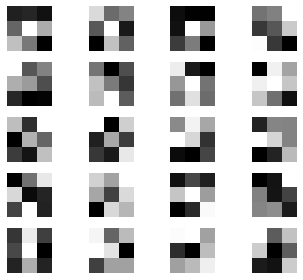

average of absolute gradients 1 tensor(7.4020e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.7726e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.5084e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.4848e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.3615e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.4118e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.6148e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.9420e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.6690e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.4752e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.0702e-06, device='cuda:0')


  6%|████▎                                                                         | 55/1000 [04:32<1:17:23,  4.91s/it]

Epoch: 55
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1727, -0.1598, -0.2076],
         [-0.0222,  0.3191,  0.1350],
         [ 0.1801,  0.0207, -0.2456]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


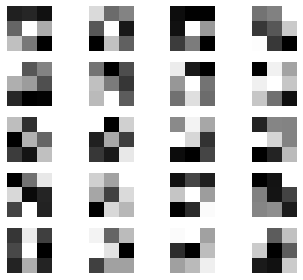

average of absolute gradients 1 tensor(8.2814e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.9399e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.7438e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.6471e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.0925e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.2165e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.9393e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.6009e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.5408e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.4141e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.2288e-07, device='cuda:0')


  6%|████▎                                                                         | 56/1000 [04:37<1:17:01,  4.90s/it]

Epoch: 56
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1732, -0.1590, -0.2069],
         [-0.0223,  0.3192,  0.1353],
         [ 0.1802,  0.0209, -0.2451]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


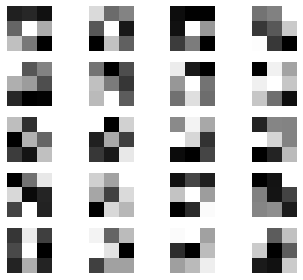

average of absolute gradients 1 tensor(8.1496e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.3064e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.4582e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.4153e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.6256e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.5842e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.1572e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.6922e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.4643e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.4282e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.3371e-07, device='cuda:0')


  6%|████▍                                                                         | 57/1000 [04:42<1:16:59,  4.90s/it]

Epoch: 57
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1741, -0.1585, -0.2066],
         [-0.0223,  0.3190,  0.1353],
         [ 0.1802,  0.0209, -0.2448]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


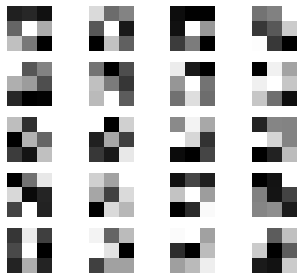

average of absolute gradients 1 tensor(7.6705e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.5814e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.6158e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.1569e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.0157e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.7655e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.9587e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.0783e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.7196e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.8434e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.8275e-07, device='cuda:0')


  6%|████▌                                                                         | 58/1000 [04:47<1:16:54,  4.90s/it]

Epoch: 58
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1747, -0.1582, -0.2061],
         [-0.0225,  0.3189,  0.1355],
         [ 0.1802,  0.0208, -0.2444]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


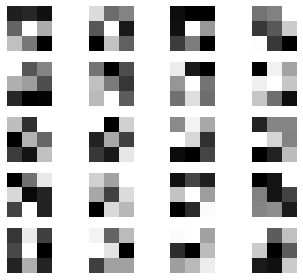

average of absolute gradients 1 tensor(8.6384e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.7002e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.4015e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.4002e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.2243e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.4551e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.7739e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.7500e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.0005e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.1874e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.6413e-07, device='cuda:0')


  6%|████▌                                                                         | 59/1000 [04:52<1:16:48,  4.90s/it]

Epoch: 59
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1754, -0.1573, -0.2055],
         [-0.0226,  0.3188,  0.1356],
         [ 0.1804,  0.0213, -0.2441]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


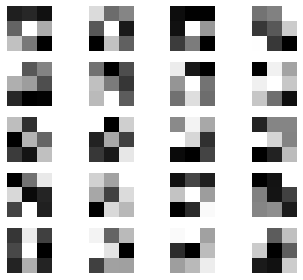

average of absolute gradients 1 tensor(9.1318e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.2090e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.7174e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.9414e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.9690e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.9117e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.0319e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.6423e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.7613e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.0993e-08, device='cuda:0')
average of absolute gradients 1 tensor(4.5287e-07, device='cuda:0')


  6%|████▋                                                                         | 60/1000 [04:57<1:16:42,  4.90s/it]

Epoch: 60
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1758, -0.1571, -0.2050],
         [-0.0224,  0.3188,  0.1360],
         [ 0.1801,  0.0207, -0.2438]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


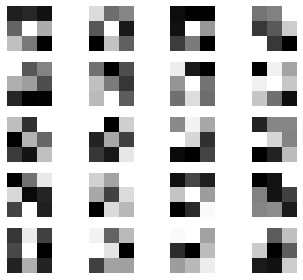

average of absolute gradients 1 tensor(7.6372e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.9925e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.1073e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.4016e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.6255e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.7977e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.0642e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0416e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.8462e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.6799e-08, device='cuda:0')
average of absolute gradients 1 tensor(5.0573e-07, device='cuda:0')


  6%|████▊                                                                         | 61/1000 [05:01<1:16:43,  4.90s/it]

Epoch: 61
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1763, -0.1563, -0.2042],
         [-0.0229,  0.3189,  0.1361],
         [ 0.1804,  0.0205, -0.2434]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


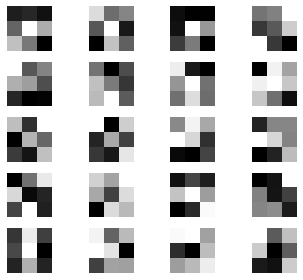

average of absolute gradients 1 tensor(9.2296e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.4927e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.9953e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.4902e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.3169e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.5821e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.3710e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.3231e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.1828e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1965e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2533e-07, device='cuda:0')


  6%|████▊                                                                         | 62/1000 [05:06<1:16:30,  4.89s/it]

Epoch: 62
Accuracy of train set: 4%
Accuracy of test set: 2%

tensor([[[-0.1769, -0.1556, -0.2038],
         [-0.0232,  0.3188,  0.1366],
         [ 0.1806,  0.0204, -0.2430]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


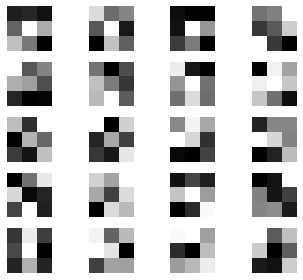

average of absolute gradients 1 tensor(1.1397e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0289e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0465e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.8886e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.1433e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.1449e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2746e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.1149e-08, device='cuda:0')
average of absolute gradients 1 tensor(7.4593e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.1646e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.0769e-06, device='cuda:0')


  6%|████▉                                                                         | 63/1000 [05:11<1:16:26,  4.89s/it]

Epoch: 63
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1774, -0.1549, -0.2030],
         [-0.0235,  0.3194,  0.1377],
         [ 0.1796,  0.0198, -0.2425]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


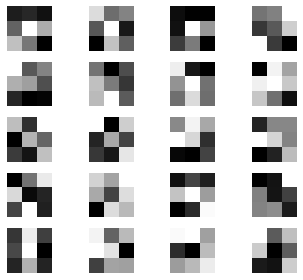

average of absolute gradients 1 tensor(1.1725e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.7075e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.1947e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.1157e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0936e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0468e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1707e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0165e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.1611e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.7299e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.2240e-06, device='cuda:0')


  6%|████▉                                                                         | 64/1000 [05:16<1:16:17,  4.89s/it]

Epoch: 64
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1781, -0.1538, -0.2024],
         [-0.0242,  0.3195,  0.1383],
         [ 0.1792,  0.0199, -0.2421]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


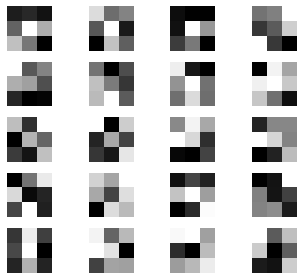

average of absolute gradients 1 tensor(8.2107e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.1687e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1531e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0639e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2349e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0648e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.6207e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.1511e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.4662e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.7936e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.7927e-07, device='cuda:0')


  6%|█████                                                                         | 65/1000 [05:21<1:16:36,  4.92s/it]

Epoch: 65
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1788, -0.1537, -0.2022],
         [-0.0243,  0.3190,  0.1395],
         [ 0.1786,  0.0196, -0.2417]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


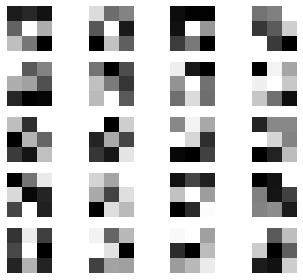

average of absolute gradients 1 tensor(1.0364e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0853e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2943e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1197e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.9571e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.2341e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.9678e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.9469e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.0293e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2417e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5671e-06, device='cuda:0')


  7%|█████▏                                                                        | 66/1000 [05:26<1:16:19,  4.90s/it]

Epoch: 66
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1788, -0.1530, -0.2012],
         [-0.0246,  0.3193,  0.1403],
         [ 0.1791,  0.0198, -0.2411]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


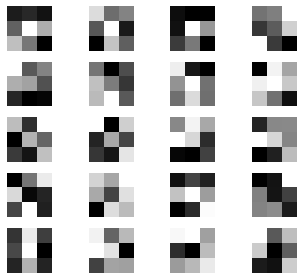

average of absolute gradients 1 tensor(1.0701e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0762e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3895e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1863e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5875e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2176e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3216e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1226e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1527e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1454e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1723e-06, device='cuda:0')


  7%|█████▏                                                                        | 67/1000 [05:31<1:16:12,  4.90s/it]

Epoch: 67
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1790, -0.1528, -0.2002],
         [-0.0252,  0.3196,  0.1413],
         [ 0.1789,  0.0197, -0.2404]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


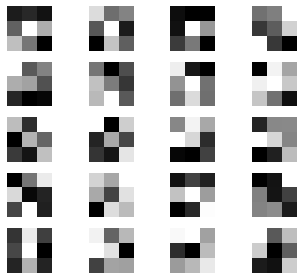

average of absolute gradients 1 tensor(1.0438e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3305e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4509e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.6022e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.2538e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1795e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6016e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2563e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0021e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3824e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1444e-06, device='cuda:0')


  7%|█████▎                                                                        | 68/1000 [05:36<1:16:10,  4.90s/it]

Epoch: 68
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1785, -0.1524, -0.1999],
         [-0.0244,  0.3198,  0.1421],
         [ 0.1795,  0.0193, -0.2395]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


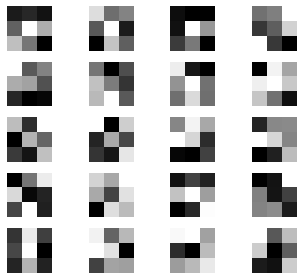

average of absolute gradients 1 tensor(1.1353e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2107e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0948e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0616e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2950e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3334e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5952e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4044e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2274e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3116e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8165e-06, device='cuda:0')


  7%|█████▍                                                                        | 69/1000 [05:41<1:15:53,  4.89s/it]

Epoch: 69
Accuracy of train set: 2%
Accuracy of test set: 2%

tensor([[[-0.1786, -0.1524, -0.1995],
         [-0.0248,  0.3194,  0.1425],
         [ 0.1798,  0.0194, -0.2392]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


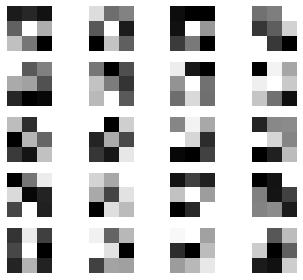

average of absolute gradients 1 tensor(1.0889e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1773e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.0068e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.1414e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2258e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4475e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3439e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4541e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2821e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3592e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2622e-06, device='cuda:0')


  7%|█████▍                                                                        | 70/1000 [05:46<1:15:50,  4.89s/it]

Epoch: 70
Accuracy of train set: 2%
Accuracy of test set: 2%

tensor([[[-0.1784, -0.1517, -0.1985],
         [-0.0249,  0.3203,  0.1418],
         [ 0.1804,  0.0200, -0.2387]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


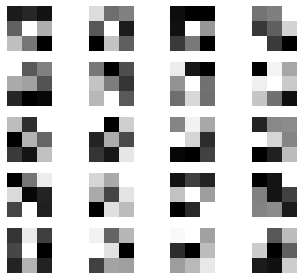

average of absolute gradients 1 tensor(1.3234e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3689e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0472e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6963e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1114e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4892e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1385e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.1195e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.8690e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.2447e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1516e-06, device='cuda:0')


  7%|█████▌                                                                        | 71/1000 [05:50<1:15:55,  4.90s/it]

Epoch: 71
Accuracy of train set: 2%
Accuracy of test set: 2%

tensor([[[-0.1791, -0.1521, -0.1985],
         [-0.0258,  0.3199,  0.1410],
         [ 0.1800,  0.0199, -0.2386]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


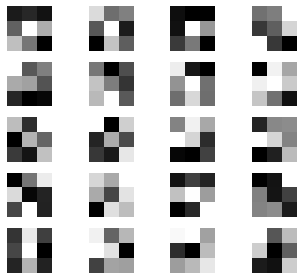

average of absolute gradients 1 tensor(1.3778e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0815e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1442e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2639e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4879e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1891e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5330e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0355e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0378e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1338e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5919e-07, device='cuda:0')


  7%|█████▌                                                                        | 72/1000 [05:55<1:16:21,  4.94s/it]

Epoch: 72
Accuracy of train set: 2%
Accuracy of test set: 2%

tensor([[[-0.1800, -0.1515, -0.1987],
         [-0.0264,  0.3196,  0.1406],
         [ 0.1800,  0.0201, -0.2381]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


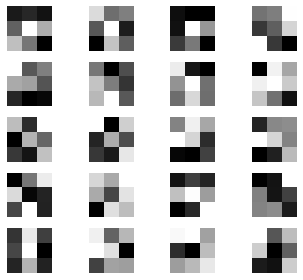

average of absolute gradients 1 tensor(1.5461e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3960e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0646e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3235e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3848e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1401e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0912e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1770e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.9417e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.0600e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4050e-06, device='cuda:0')


  7%|█████▋                                                                        | 73/1000 [06:00<1:16:10,  4.93s/it]

Epoch: 73
Accuracy of train set: 2%
Accuracy of test set: 2%

tensor([[[-0.1801, -0.1514, -0.1985],
         [-0.0272,  0.3196,  0.1410],
         [ 0.1796,  0.0198, -0.2374]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


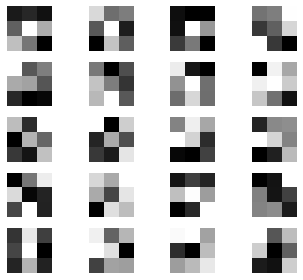

average of absolute gradients 1 tensor(1.1671e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.4487e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.1366e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1542e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.1830e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.3797e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3436e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7708e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1660e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.4204e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.9833e-07, device='cuda:0')


  7%|█████▊                                                                        | 74/1000 [06:05<1:15:47,  4.91s/it]

Epoch: 74
Accuracy of train set: 2%
Accuracy of test set: 2%

tensor([[[-0.1809, -0.1515, -0.1992],
         [-0.0276,  0.3187,  0.1400],
         [ 0.1800,  0.0205, -0.2369]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


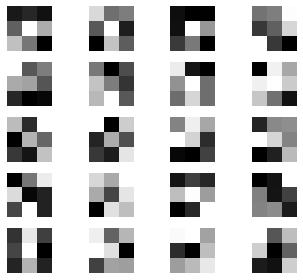

average of absolute gradients 1 tensor(1.2987e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1664e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1205e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6297e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2003e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2224e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1982e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.6297e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.2652e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1818e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2105e-06, device='cuda:0')


  8%|█████▊                                                                        | 75/1000 [06:10<1:15:47,  4.92s/it]

Epoch: 75
Accuracy of train set: 2%
Accuracy of test set: 2%

tensor([[[-0.1811, -0.1503, -0.1991],
         [-0.0280,  0.3191,  0.1405],
         [ 0.1806,  0.0205, -0.2357]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


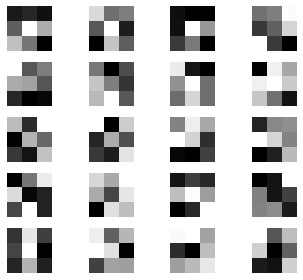

average of absolute gradients 1 tensor(1.4594e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0840e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1163e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1799e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.9698e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.0158e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4759e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3079e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4237e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2305e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5851e-07, device='cuda:0')


  8%|█████▉                                                                        | 76/1000 [06:15<1:15:34,  4.91s/it]

Epoch: 76
Accuracy of train set: 2%
Accuracy of test set: 2%

tensor([[[-0.1819, -0.1507, -0.1991],
         [-0.0284,  0.3182,  0.1401],
         [ 0.1811,  0.0207, -0.2351]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


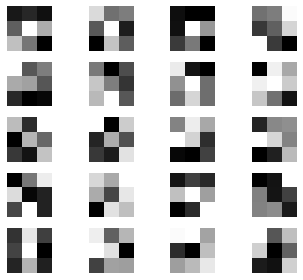

average of absolute gradients 1 tensor(9.4409e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.0970e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2759e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1842e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1606e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4584e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1231e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1141e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6129e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.5817e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.8417e-06, device='cuda:0')


  8%|██████                                                                        | 77/1000 [06:20<1:15:35,  4.91s/it]

Epoch: 77
Accuracy of train set: 2%
Accuracy of test set: 2%

tensor([[[-0.1823, -0.1502, -0.1991],
         [-0.0292,  0.3179,  0.1397],
         [ 0.1821,  0.0210, -0.2342]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


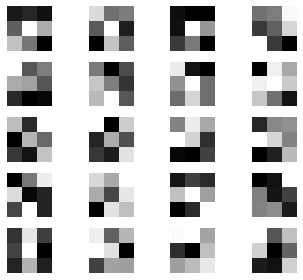

average of absolute gradients 1 tensor(1.0952e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.4012e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.2345e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.1916e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3934e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7105e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4250e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0695e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.5995e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.3071e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1015e-06, device='cuda:0')


  8%|██████                                                                        | 78/1000 [06:25<1:15:30,  4.91s/it]

Epoch: 78
Accuracy of train set: 2%
Accuracy of test set: 2%

tensor([[[-0.1826, -0.1501, -0.1986],
         [-0.0286,  0.3177,  0.1401],
         [ 0.1826,  0.0210, -0.2336]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


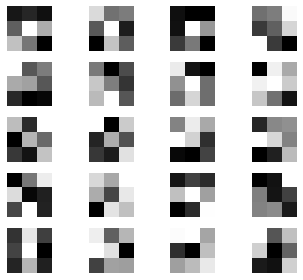

average of absolute gradients 1 tensor(1.2951e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0101e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3928e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4224e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.3467e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.2366e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.0874e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.3427e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4257e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1941e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1664e-06, device='cuda:0')


  8%|██████▏                                                                       | 79/1000 [06:30<1:15:24,  4.91s/it]

Epoch: 79
Accuracy of train set: 2%
Accuracy of test set: 2%

tensor([[[-0.1832, -0.1492, -0.1986],
         [-0.0279,  0.3178,  0.1396],
         [ 0.1828,  0.0216, -0.2331]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


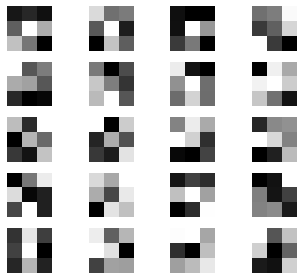

average of absolute gradients 1 tensor(1.5104e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0383e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3893e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3220e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3972e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1894e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2947e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0852e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.0254e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.1757e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0313e-07, device='cuda:0')


  8%|██████▏                                                                       | 80/1000 [06:35<1:15:26,  4.92s/it]

Epoch: 80
Accuracy of train set: 2%
Accuracy of test set: 2%

tensor([[[-0.1839, -0.1475, -0.1984],
         [-0.0274,  0.3182,  0.1394],
         [ 0.1834,  0.0223, -0.2322]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


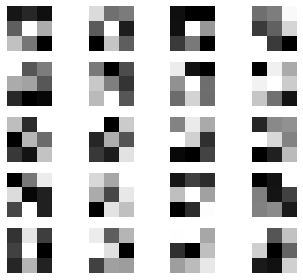

average of absolute gradients 1 tensor(1.2025e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1151e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0971e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.8958e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.6506e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.2414e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3866e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6080e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4254e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3978e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4931e-07, device='cuda:0')


  8%|██████▎                                                                       | 81/1000 [06:40<1:15:13,  4.91s/it]

Epoch: 81
Accuracy of train set: 2%
Accuracy of test set: 2%

tensor([[[-0.1848, -0.1468, -0.1985],
         [-0.0268,  0.3179,  0.1388],
         [ 0.1840,  0.0223, -0.2317]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


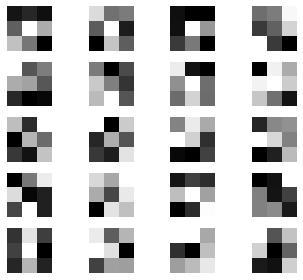

average of absolute gradients 1 tensor(1.0432e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1135e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0599e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.6136e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.4487e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4226e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2287e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5152e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2734e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2121e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.9027e-07, device='cuda:0')


  8%|██████▍                                                                       | 82/1000 [06:45<1:15:11,  4.91s/it]

Epoch: 82
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1857, -0.1464, -0.1986],
         [-0.0268,  0.3173,  0.1386],
         [ 0.1840,  0.0228, -0.2312]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


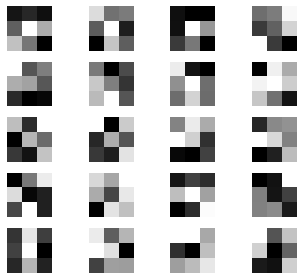

average of absolute gradients 1 tensor(1.2140e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.6494e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.5093e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1133e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6293e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1677e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2762e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.5008e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.3236e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0581e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1255e-06, device='cuda:0')


  8%|██████▍                                                                       | 83/1000 [06:49<1:15:02,  4.91s/it]

Epoch: 83
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1866, -0.1461, -0.1993],
         [-0.0266,  0.3165,  0.1378],
         [ 0.1844,  0.0235, -0.2307]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


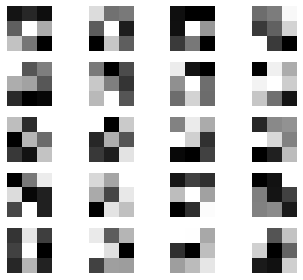

average of absolute gradients 1 tensor(1.0461e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3353e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4170e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3147e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.8468e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.2612e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2973e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.7627e-08, device='cuda:0')
average of absolute gradients 1 tensor(9.9721e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.2547e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5852e-06, device='cuda:0')


  8%|██████▌                                                                       | 84/1000 [06:54<1:14:53,  4.91s/it]

Epoch: 84
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1872, -0.1460, -0.1987],
         [-0.0261,  0.3167,  0.1378],
         [ 0.1846,  0.0235, -0.2298]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


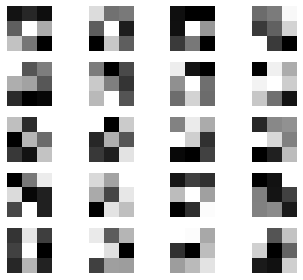

average of absolute gradients 1 tensor(1.2492e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5598e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1826e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2906e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1801e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.2573e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.2738e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2544e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4646e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.1723e-08, device='cuda:0')
average of absolute gradients 1 tensor(8.7461e-07, device='cuda:0')


  8%|██████▋                                                                       | 85/1000 [06:59<1:14:53,  4.91s/it]

Epoch: 85
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1874, -0.1448, -0.1994],
         [-0.0261,  0.3170,  0.1381],
         [ 0.1837,  0.0246, -0.2290]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


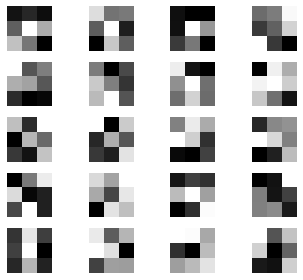

average of absolute gradients 1 tensor(1.0597e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.2984e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.4914e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1498e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2760e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1144e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0489e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5226e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6589e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2274e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.4413e-07, device='cuda:0')


  9%|██████▋                                                                       | 86/1000 [07:04<1:14:47,  4.91s/it]

Epoch: 86
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1878, -0.1449, -0.1998],
         [-0.0259,  0.3170,  0.1376],
         [ 0.1831,  0.0250, -0.2285]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


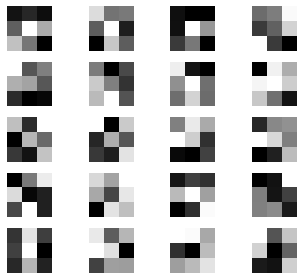

average of absolute gradients 1 tensor(1.3005e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4410e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1986e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0753e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.9765e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.2986e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2014e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2142e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4951e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4127e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.6362e-07, device='cuda:0')


  9%|██████▊                                                                       | 87/1000 [07:09<1:14:36,  4.90s/it]

Epoch: 87
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1879, -0.1438, -0.2004],
         [-0.0250,  0.3174,  0.1374],
         [ 0.1828,  0.0252, -0.2279]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


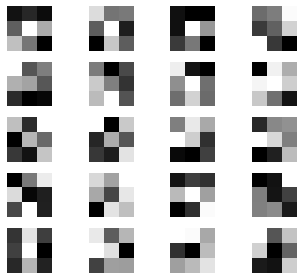

average of absolute gradients 1 tensor(1.4429e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2561e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4166e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1715e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0338e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1909e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2110e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4074e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2552e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2563e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.7785e-07, device='cuda:0')


  9%|██████▊                                                                       | 88/1000 [07:14<1:14:39,  4.91s/it]

Epoch: 88
Accuracy of train set: 3%
Accuracy of test set: 2%

tensor([[[-0.1882, -0.1433, -0.2007],
         [-0.0244,  0.3174,  0.1371],
         [ 0.1827,  0.0252, -0.2273]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


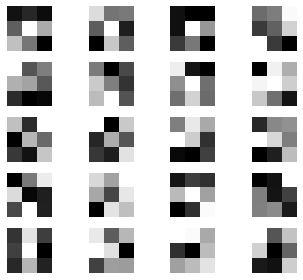

average of absolute gradients 1 tensor(1.0389e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3383e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5048e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5030e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2667e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9376e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2450e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.4676e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.1087e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2255e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.9640e-07, device='cuda:0')


  9%|██████▉                                                                       | 89/1000 [07:19<1:14:53,  4.93s/it]

Epoch: 89
Accuracy of train set: 3%
Accuracy of test set: 3%

tensor([[[-0.1887, -0.1429, -0.2013],
         [-0.0235,  0.3174,  0.1366],
         [ 0.1824,  0.0255, -0.2267]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


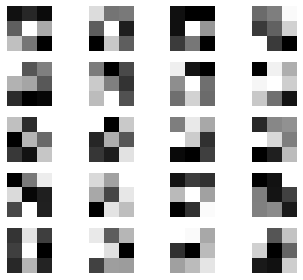

average of absolute gradients 1 tensor(1.2984e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4152e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4414e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3982e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2389e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1536e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4833e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4064e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1759e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1805e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3643e-06, device='cuda:0')


  9%|███████                                                                       | 90/1000 [07:24<1:15:26,  4.97s/it]

Epoch: 90
Accuracy of train set: 3%
Accuracy of test set: 3%

tensor([[[-0.1897, -0.1425, -0.2018],
         [-0.0233,  0.3164,  0.1359],
         [ 0.1831,  0.0267, -0.2261]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


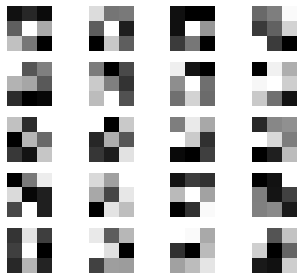

average of absolute gradients 1 tensor(1.0971e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4352e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2755e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5465e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8235e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5043e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0535e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1992e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1810e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3658e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2841e-07, device='cuda:0')


  9%|███████                                                                       | 91/1000 [07:29<1:15:28,  4.98s/it]

Epoch: 91
Accuracy of train set: 3%
Accuracy of test set: 3%

tensor([[[-0.1902, -0.1420, -0.2022],
         [-0.0227,  0.3161,  0.1360],
         [ 0.1831,  0.0272, -0.2253]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


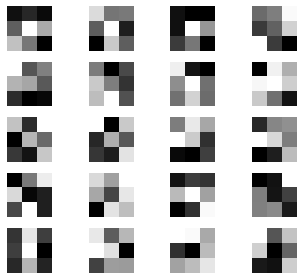

average of absolute gradients 1 tensor(1.6005e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3044e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1346e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4001e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1245e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1547e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6927e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5084e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3249e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3757e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0586e-07, device='cuda:0')


  9%|███████▏                                                                      | 92/1000 [07:34<1:15:38,  5.00s/it]

Epoch: 92
Accuracy of train set: 3%
Accuracy of test set: 3%

tensor([[[-0.1909, -0.1425, -0.2028],
         [-0.0226,  0.3149,  0.1352],
         [ 0.1833,  0.0278, -0.2251]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


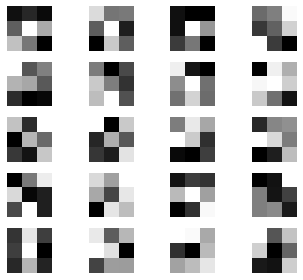

average of absolute gradients 1 tensor(1.4850e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3458e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3480e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5189e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0460e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5660e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4665e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3792e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0774e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2902e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1899e-06, device='cuda:0')


  9%|███████▎                                                                      | 93/1000 [07:39<1:15:33,  5.00s/it]

Epoch: 93
Accuracy of train set: 3%
Accuracy of test set: 3%

tensor([[[-0.1907, -0.1417, -0.2030],
         [-0.0223,  0.3156,  0.1348],
         [ 0.1834,  0.0278, -0.2243]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


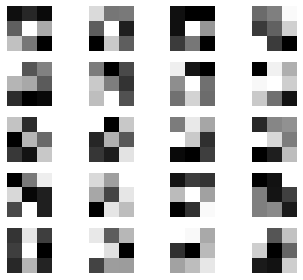

average of absolute gradients 1 tensor(1.2534e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0768e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5494e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0841e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2910e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3845e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4266e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8546e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4019e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3658e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2236e-07, device='cuda:0')


  9%|███████▎                                                                      | 94/1000 [07:44<1:15:35,  5.01s/it]

Epoch: 94
Accuracy of train set: 3%
Accuracy of test set: 3%

tensor([[[-0.1910, -0.1416, -0.2031],
         [-0.0225,  0.3154,  0.1339],
         [ 0.1834,  0.0279, -0.2240]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


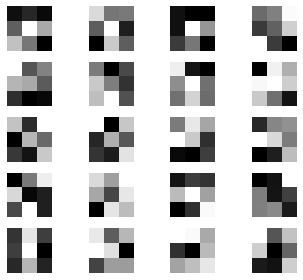

average of absolute gradients 1 tensor(1.5313e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4871e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6371e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0580e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3961e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8570e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1186e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3076e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1295e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1779e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.8932e-07, device='cuda:0')


 10%|███████▍                                                                      | 95/1000 [07:49<1:15:33,  5.01s/it]

Epoch: 95
Accuracy of train set: 3%
Accuracy of test set: 3%

tensor([[[-0.1912, -0.1416, -0.2038],
         [-0.0223,  0.3146,  0.1336],
         [ 0.1836,  0.0284, -0.2236]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


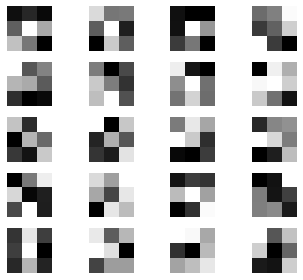

average of absolute gradients 1 tensor(1.5499e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2739e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5604e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3058e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6640e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0904e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6094e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.8438e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.6394e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1166e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5025e-06, device='cuda:0')


 10%|███████▍                                                                      | 96/1000 [07:54<1:15:27,  5.01s/it]

Epoch: 96
Accuracy of train set: 3%
Accuracy of test set: 3%

tensor([[[-0.1915, -0.1408, -0.2036],
         [-0.0225,  0.3147,  0.1330],
         [ 0.1845,  0.0283, -0.2230]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


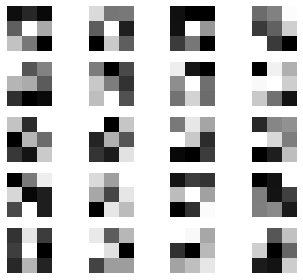

average of absolute gradients 1 tensor(1.1250e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4823e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5101e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4094e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1650e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4408e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1442e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2974e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5480e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7102e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1251e-06, device='cuda:0')


 10%|███████▌                                                                      | 97/1000 [07:59<1:15:24,  5.01s/it]

Epoch: 97
Accuracy of train set: 3%
Accuracy of test set: 3%

tensor([[[-0.1918, -0.1411, -0.2046],
         [-0.0234,  0.3137,  0.1330],
         [ 0.1840,  0.0282, -0.2227]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


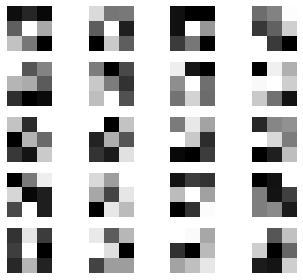

average of absolute gradients 1 tensor(1.8445e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6620e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1837e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4667e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1711e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4345e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6195e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1061e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6767e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2728e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7627e-07, device='cuda:0')


 10%|███████▋                                                                      | 98/1000 [08:04<1:15:22,  5.01s/it]

Epoch: 98
Accuracy of train set: 3%
Accuracy of test set: 3%

tensor([[[-0.1920, -0.1415, -0.2058],
         [-0.0240,  0.3123,  0.1329],
         [ 0.1841,  0.0279, -0.2224]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


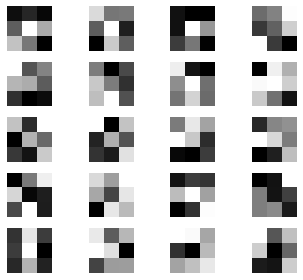

average of absolute gradients 1 tensor(1.2424e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4281e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5556e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1287e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6462e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3532e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1993e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6882e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1598e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9405e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9525e-06, device='cuda:0')


 10%|███████▋                                                                      | 99/1000 [08:09<1:15:25,  5.02s/it]

Epoch: 99
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1921, -0.1420, -0.2064],
         [-0.0249,  0.3109,  0.1328],
         [ 0.1846,  0.0281, -0.2222]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


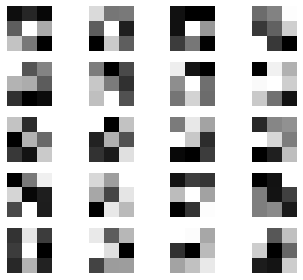

average of absolute gradients 1 tensor(1.3541e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0335e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4454e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1658e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3531e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8126e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4604e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6301e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3304e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.8303e-08, device='cuda:0')
average of absolute gradients 1 tensor(6.9677e-07, device='cuda:0')


 10%|███████▋                                                                     | 100/1000 [08:14<1:15:19,  5.02s/it]

Epoch: 100
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1914, -0.1414, -0.2069],
         [-0.0258,  0.3103,  0.1334],
         [ 0.1854,  0.0285, -0.2218]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


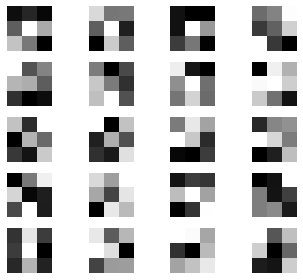

average of absolute gradients 1 tensor(1.2251e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2941e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2222e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2301e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3999e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9040e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3441e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3070e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0428e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5626e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.6404e-07, device='cuda:0')


 10%|███████▊                                                                     | 101/1000 [08:19<1:15:08,  5.02s/it]

Epoch: 101
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1907, -0.1407, -0.2073],
         [-0.0261,  0.3102,  0.1333],
         [ 0.1860,  0.0284, -0.2214]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


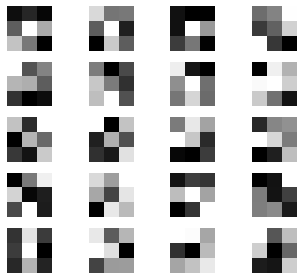

average of absolute gradients 1 tensor(1.5701e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5919e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5391e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3499e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5425e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.9652e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.4735e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4526e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4962e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4161e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1355e-06, device='cuda:0')


 10%|███████▊                                                                     | 102/1000 [08:24<1:15:23,  5.04s/it]

Epoch: 102
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1900, -0.1410, -0.2078],
         [-0.0258,  0.3098,  0.1338],
         [ 0.1859,  0.0278, -0.2213]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


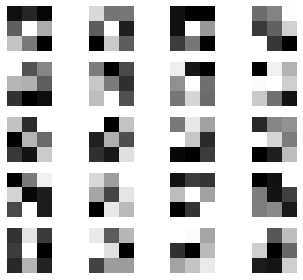

average of absolute gradients 1 tensor(1.7756e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3510e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7128e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3809e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5304e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1748e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2948e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4929e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3872e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3320e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0264e-07, device='cuda:0')


 10%|███████▉                                                                     | 103/1000 [08:29<1:15:11,  5.03s/it]

Epoch: 103
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1893, -0.1409, -0.2082],
         [-0.0262,  0.3098,  0.1339],
         [ 0.1855,  0.0273, -0.2211]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


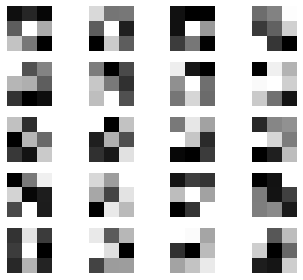

average of absolute gradients 1 tensor(1.6263e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3209e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2758e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0740e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4615e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6097e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3371e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6295e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5231e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4112e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8841e-06, device='cuda:0')


 10%|████████                                                                     | 104/1000 [08:34<1:15:07,  5.03s/it]

Epoch: 104
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1888, -0.1409, -0.2090],
         [-0.0258,  0.3093,  0.1345],
         [ 0.1850,  0.0271, -0.2211]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


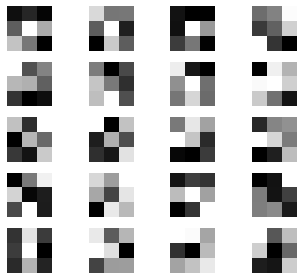

average of absolute gradients 1 tensor(1.2357e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1570e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3850e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2861e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5466e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2058e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6416e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5775e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6163e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8953e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0688e-06, device='cuda:0')


 10%|████████                                                                     | 105/1000 [08:39<1:15:14,  5.04s/it]

Epoch: 105
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1877, -0.1407, -0.2089],
         [-0.0255,  0.3100,  0.1351],
         [ 0.1850,  0.0258, -0.2204]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


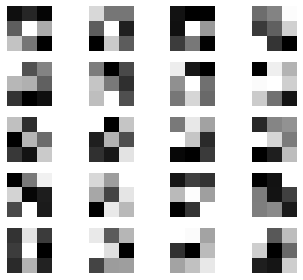

average of absolute gradients 1 tensor(1.4372e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7860e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5405e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4895e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3167e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3326e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5920e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5428e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7812e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2165e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.4895e-07, device='cuda:0')


 11%|████████▏                                                                    | 106/1000 [08:44<1:15:05,  5.04s/it]

Epoch: 106
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1880, -0.1421, -0.2106],
         [-0.0255,  0.3082,  0.1349],
         [ 0.1838,  0.0245, -0.2208]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


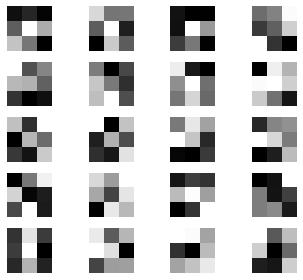

average of absolute gradients 1 tensor(1.6030e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2668e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6870e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1953e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4080e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7441e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5181e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3278e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5017e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4288e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0003e-06, device='cuda:0')


 11%|████████▏                                                                    | 107/1000 [08:50<1:15:01,  5.04s/it]

Epoch: 107
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1869, -0.1417, -0.2104],
         [-0.0253,  0.3086,  0.1353],
         [ 0.1844,  0.0241, -0.2204]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


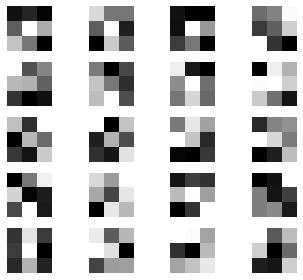

average of absolute gradients 1 tensor(1.4161e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4782e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3513e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1767e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6310e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7967e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6243e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8302e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2707e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6052e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.4828e-07, device='cuda:0')


 11%|████████▎                                                                    | 108/1000 [08:55<1:14:55,  5.04s/it]

Epoch: 108
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1856, -0.1413, -0.2104],
         [-0.0249,  0.3086,  0.1357],
         [ 0.1853,  0.0238, -0.2200]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


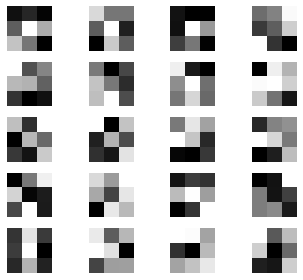

average of absolute gradients 1 tensor(1.3124e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3097e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9965e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5562e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4216e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4043e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2226e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9193e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6506e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7114e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7569e-07, device='cuda:0')


 11%|████████▍                                                                    | 109/1000 [09:00<1:15:04,  5.06s/it]

Epoch: 109
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1849, -0.1412, -0.2106],
         [-0.0250,  0.3086,  0.1354],
         [ 0.1853,  0.0231, -0.2201]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


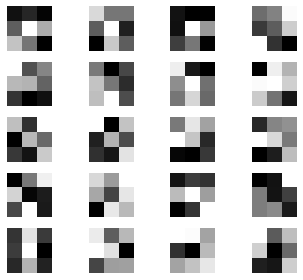

average of absolute gradients 1 tensor(1.8589e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3648e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4546e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2428e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5568e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4054e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5100e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6462e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7466e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8119e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6787e-06, device='cuda:0')


 11%|████████▍                                                                    | 110/1000 [09:05<1:15:01,  5.06s/it]

Epoch: 110
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1845, -0.1413, -0.2109],
         [-0.0247,  0.3079,  0.1354],
         [ 0.1860,  0.0225, -0.2199]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


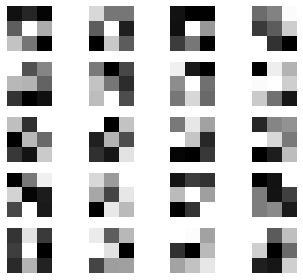

average of absolute gradients 1 tensor(1.3736e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1717e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7874e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7242e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0746e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5569e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9846e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3802e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4379e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9618e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.9387e-07, device='cuda:0')


 11%|████████▌                                                                    | 111/1000 [09:10<1:14:52,  5.05s/it]

Epoch: 111
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1847, -0.1415, -0.2120],
         [-0.0252,  0.3070,  0.1348],
         [ 0.1857,  0.0218, -0.2199]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


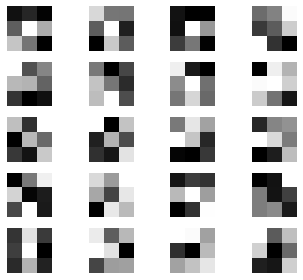

average of absolute gradients 1 tensor(1.5678e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3280e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5450e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7413e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3802e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9099e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8922e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0246e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6799e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7469e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5600e-06, device='cuda:0')


 11%|████████▌                                                                    | 112/1000 [09:15<1:15:10,  5.08s/it]

Epoch: 112
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1842, -0.1408, -0.2120],
         [-0.0250,  0.3070,  0.1348],
         [ 0.1862,  0.0219, -0.2196]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


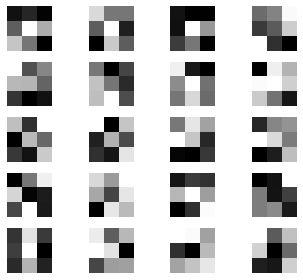

average of absolute gradients 1 tensor(1.4009e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6502e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5167e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0254e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8914e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6831e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1648e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8896e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7295e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6036e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3551e-06, device='cuda:0')


 11%|████████▋                                                                    | 113/1000 [09:20<1:15:10,  5.09s/it]

Epoch: 113
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1845, -0.1416, -0.2128],
         [-0.0247,  0.3057,  0.1357],
         [ 0.1856,  0.0213, -0.2193]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


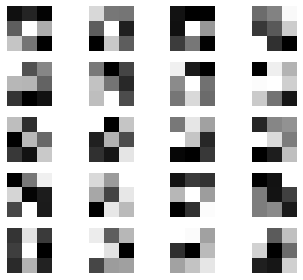

average of absolute gradients 1 tensor(1.7366e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4639e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4754e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0310e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5663e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6420e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3359e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6713e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7791e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2547e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6219e-06, device='cuda:0')


 11%|████████▊                                                                    | 114/1000 [09:25<1:15:05,  5.09s/it]

Epoch: 114
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1848, -0.1424, -0.2143],
         [-0.0244,  0.3044,  0.1353],
         [ 0.1848,  0.0203, -0.2194]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


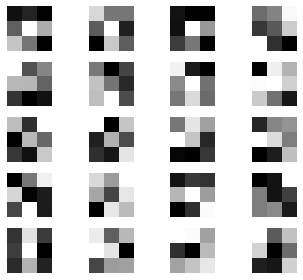

average of absolute gradients 1 tensor(1.0161e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6217e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6516e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3502e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7261e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7114e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7104e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9444e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5689e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9595e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2875e-06, device='cuda:0')


 12%|████████▊                                                                    | 115/1000 [09:30<1:14:43,  5.07s/it]

Epoch: 115
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1843, -0.1432, -0.2146],
         [-0.0235,  0.3040,  0.1362],
         [ 0.1841,  0.0196, -0.2192]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


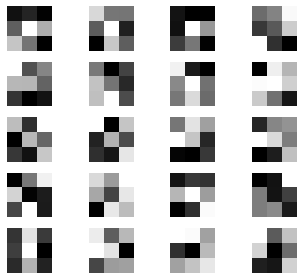

average of absolute gradients 1 tensor(1.6636e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7910e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8327e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2489e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6804e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4065e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4770e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4766e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6215e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8354e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3814e-07, device='cuda:0')


 12%|████████▉                                                                    | 116/1000 [09:35<1:14:33,  5.06s/it]

Epoch: 116
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1849, -0.1429, -0.2151],
         [-0.0231,  0.3036,  0.1354],
         [ 0.1838,  0.0192, -0.2190]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


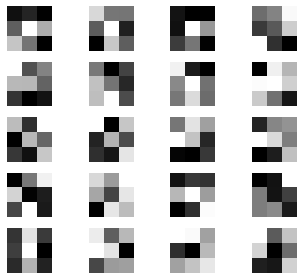

average of absolute gradients 1 tensor(1.4990e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4904e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4709e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9976e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3476e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3119e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9578e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6851e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3326e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3589e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7163e-06, device='cuda:0')


 12%|█████████                                                                    | 117/1000 [09:40<1:14:24,  5.06s/it]

Epoch: 117
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1854, -0.1438, -0.2158],
         [-0.0218,  0.3024,  0.1348],
         [ 0.1836,  0.0186, -0.2191]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


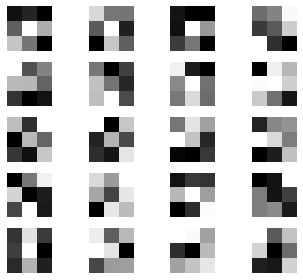

average of absolute gradients 1 tensor(1.6183e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0467e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6093e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8635e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3240e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5794e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7905e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3484e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5496e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4864e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7071e-06, device='cuda:0')


 12%|█████████                                                                    | 118/1000 [09:45<1:14:11,  5.05s/it]

Epoch: 118
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1859, -0.1439, -0.2159],
         [-0.0205,  0.3019,  0.1338],
         [ 0.1844,  0.0187, -0.2187]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


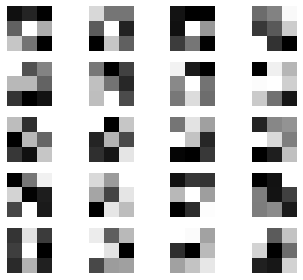

average of absolute gradients 1 tensor(1.5542e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6114e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4905e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4949e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2224e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4465e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1607e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5577e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0347e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3530e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3087e-06, device='cuda:0')


 12%|█████████▏                                                                   | 119/1000 [09:50<1:14:30,  5.07s/it]

Epoch: 119
Accuracy of train set: 4%
Accuracy of test set: 4%

tensor([[[-0.1863, -0.1441, -0.2160],
         [-0.0194,  0.3015,  0.1334],
         [ 0.1843,  0.0192, -0.2183]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


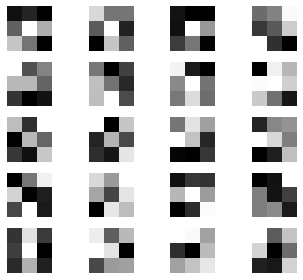

average of absolute gradients 1 tensor(1.3681e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7083e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5823e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1717e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4851e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3688e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3353e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4723e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1998e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8055e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.3507e-07, device='cuda:0')


 12%|█████████▏                                                                   | 120/1000 [09:55<1:14:29,  5.08s/it]

Epoch: 120
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1862, -0.1443, -0.2161],
         [-0.0187,  0.3015,  0.1338],
         [ 0.1837,  0.0182, -0.2179]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


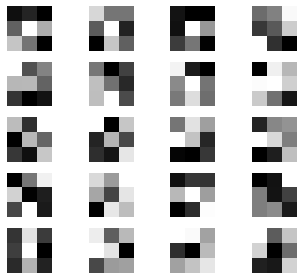

average of absolute gradients 1 tensor(1.2816e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2361e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5284e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2872e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4419e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7262e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5073e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2215e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2305e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3778e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.4760e-07, device='cuda:0')


 12%|█████████▎                                                                   | 121/1000 [10:01<1:14:57,  5.12s/it]

Epoch: 121
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1862, -0.1443, -0.2159],
         [-0.0181,  0.3011,  0.1344],
         [ 0.1842,  0.0179, -0.2173]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


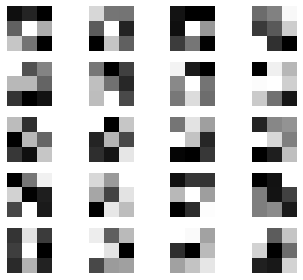

average of absolute gradients 1 tensor(1.1585e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0972e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2468e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6426e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5473e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1574e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5209e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5646e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5210e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0816e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.1262e-07, device='cuda:0')


 12%|█████████▍                                                                   | 122/1000 [10:06<1:14:48,  5.11s/it]

Epoch: 122
Accuracy of train set: 4%
Accuracy of test set: 4%

tensor([[[-0.1867, -0.1445, -0.2164],
         [-0.0180,  0.3004,  0.1347],
         [ 0.1839,  0.0176, -0.2168]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


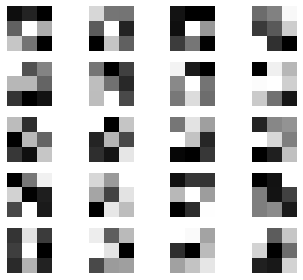

average of absolute gradients 1 tensor(1.2654e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4379e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2912e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3646e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2313e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4540e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2912e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9728e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1798e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1071e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.5892e-07, device='cuda:0')


 12%|█████████▍                                                                   | 123/1000 [10:11<1:14:43,  5.11s/it]

Epoch: 123
Accuracy of train set: 4%
Accuracy of test set: 4%

tensor([[[-0.1870, -0.1446, -0.2163],
         [-0.0176,  0.2999,  0.1351],
         [ 0.1836,  0.0176, -0.2165]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


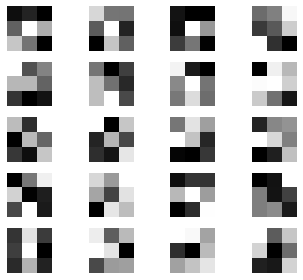

average of absolute gradients 1 tensor(1.1299e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2840e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5784e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2440e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3675e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4810e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5560e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2354e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3148e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3689e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0261e-06, device='cuda:0')


 12%|█████████▌                                                                   | 124/1000 [10:16<1:14:40,  5.12s/it]

Epoch: 124
Accuracy of train set: 4%
Accuracy of test set: 3%

tensor([[[-0.1871, -0.1445, -0.2162],
         [-0.0175,  0.3001,  0.1356],
         [ 0.1833,  0.0175, -0.2158]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


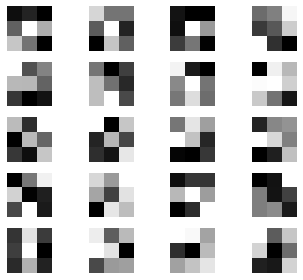

average of absolute gradients 1 tensor(1.0912e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3731e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3440e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3153e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4602e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3871e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3961e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1366e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8534e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2621e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3561e-07, device='cuda:0')


 12%|█████████▋                                                                   | 125/1000 [10:21<1:16:12,  5.23s/it]

Epoch: 125
Accuracy of train set: 4%
Accuracy of test set: 4%

tensor([[[-0.1879, -0.1446, -0.2161],
         [-0.0175,  0.2995,  0.1363],
         [ 0.1827,  0.0176, -0.2154]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


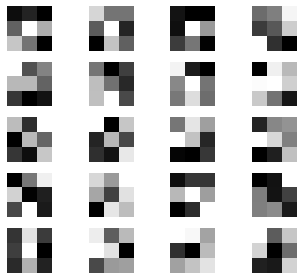

average of absolute gradients 1 tensor(1.2497e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3329e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6863e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1915e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2138e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0613e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6768e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4172e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1840e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4447e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8147e-07, device='cuda:0')


 13%|█████████▋                                                                   | 126/1000 [10:27<1:15:30,  5.18s/it]

Epoch: 126
Accuracy of train set: 4%
Accuracy of test set: 4%

tensor([[[-0.1881, -0.1440, -0.2161],
         [-0.0177,  0.2995,  0.1372],
         [ 0.1820,  0.0177, -0.2149]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


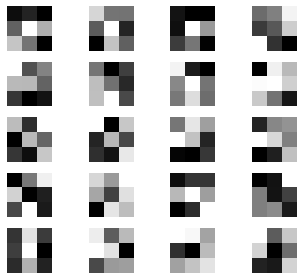

average of absolute gradients 1 tensor(1.3885e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0767e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0658e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3139e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7544e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3906e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3371e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1298e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3021e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4041e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9946e-07, device='cuda:0')


 13%|█████████▊                                                                   | 127/1000 [10:32<1:15:14,  5.17s/it]

Epoch: 127
Accuracy of train set: 4%
Accuracy of test set: 4%

tensor([[[-0.1885, -0.1443, -0.2162],
         [-0.0176,  0.2987,  0.1379],
         [ 0.1811,  0.0168, -0.2151]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


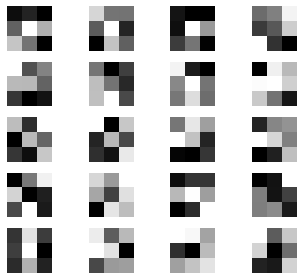

average of absolute gradients 1 tensor(1.3331e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3101e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5431e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0441e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0763e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.3880e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.2384e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5492e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6096e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1777e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.3026e-07, device='cuda:0')


 13%|█████████▊                                                                   | 128/1000 [10:37<1:14:35,  5.13s/it]

Epoch: 128
Accuracy of train set: 4%
Accuracy of test set: 4%

tensor([[[-0.1889, -0.1441, -0.2160],
         [-0.0179,  0.2987,  0.1379],
         [ 0.1808,  0.0169, -0.2148]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


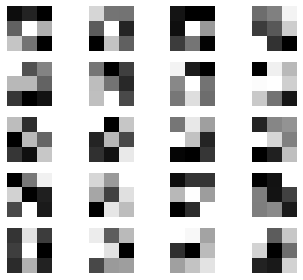

average of absolute gradients 1 tensor(1.1864e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4014e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3105e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3376e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3530e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1898e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0631e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0014e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4794e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1244e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7066e-06, device='cuda:0')


 13%|█████████▉                                                                   | 129/1000 [10:42<1:14:18,  5.12s/it]

Epoch: 129
Accuracy of train set: 5%
Accuracy of test set: 3%

tensor([[[-0.1891, -0.1438, -0.2158],
         [-0.0182,  0.2982,  0.1384],
         [ 0.1807,  0.0168, -0.2146]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


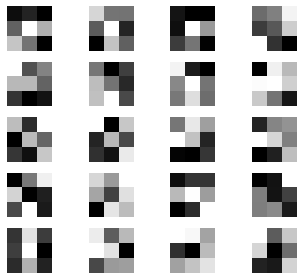

average of absolute gradients 1 tensor(1.2331e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1421e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1448e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1262e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4010e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3117e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0958e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2079e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4614e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3325e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.9848e-07, device='cuda:0')


 13%|██████████                                                                   | 130/1000 [10:47<1:13:57,  5.10s/it]

Epoch: 130
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1895, -0.1438, -0.2161],
         [-0.0186,  0.2977,  0.1382],
         [ 0.1804,  0.0164, -0.2145]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


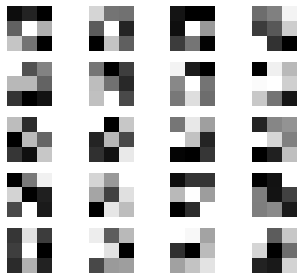

average of absolute gradients 1 tensor(1.1884e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1651e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1343e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2951e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0242e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3631e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4603e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2834e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0989e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3967e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.2488e-07, device='cuda:0')


 13%|██████████                                                                   | 131/1000 [10:52<1:13:50,  5.10s/it]

Epoch: 131
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1897, -0.1437, -0.2160],
         [-0.0188,  0.2975,  0.1381],
         [ 0.1801,  0.0162, -0.2143]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


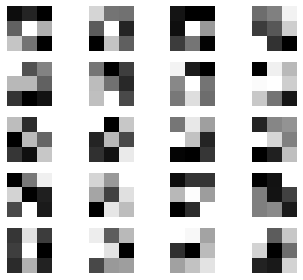

average of absolute gradients 1 tensor(1.2202e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2279e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2438e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2528e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3130e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2638e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3424e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3127e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0976e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2473e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8037e-06, device='cuda:0')


 13%|██████████▏                                                                  | 132/1000 [10:57<1:13:34,  5.09s/it]

Epoch: 132
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1899, -0.1436, -0.2159],
         [-0.0191,  0.2975,  0.1383],
         [ 0.1797,  0.0159, -0.2141]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


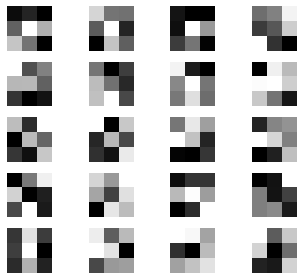

average of absolute gradients 1 tensor(1.2419e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0700e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2927e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3073e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1519e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4589e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5307e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2551e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3397e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2560e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2111e-06, device='cuda:0')


 13%|██████████▏                                                                  | 133/1000 [11:02<1:13:21,  5.08s/it]

Epoch: 133
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1901, -0.1440, -0.2159],
         [-0.0191,  0.2971,  0.1373],
         [ 0.1797,  0.0157, -0.2141]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


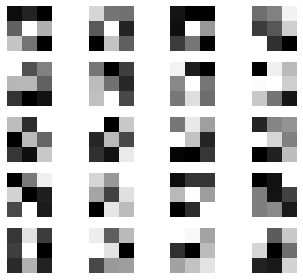

average of absolute gradients 1 tensor(1.3775e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3873e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0699e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4833e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2408e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3059e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4076e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0539e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3292e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6033e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9153e-06, device='cuda:0')


 13%|██████████▎                                                                  | 134/1000 [11:07<1:13:11,  5.07s/it]

Epoch: 134
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1899, -0.1438, -0.2156],
         [-0.0191,  0.2971,  0.1374],
         [ 0.1797,  0.0155, -0.2141]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


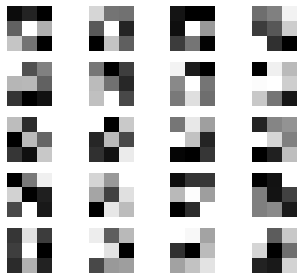

average of absolute gradients 1 tensor(1.4866e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4241e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1006e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2188e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4493e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3565e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4746e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1394e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9091e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3944e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.0464e-07, device='cuda:0')


 14%|██████████▍                                                                  | 135/1000 [11:12<1:13:18,  5.08s/it]

Epoch: 135
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1898, -0.1436, -0.2157],
         [-0.0194,  0.2970,  0.1373],
         [ 0.1796,  0.0151, -0.2140]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


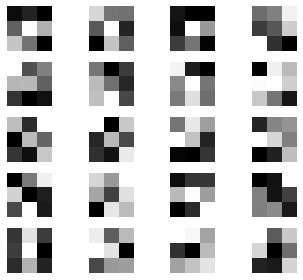

average of absolute gradients 1 tensor(1.3947e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3944e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1036e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3989e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.8237e-08, device='cuda:0')
average of absolute gradients 1 tensor(1.4852e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6918e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6867e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2743e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7450e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8228e-06, device='cuda:0')


 14%|██████████▍                                                                  | 136/1000 [11:17<1:13:08,  5.08s/it]

Epoch: 136
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1900, -0.1440, -0.2155],
         [-0.0194,  0.2967,  0.1373],
         [ 0.1792,  0.0153, -0.2137]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


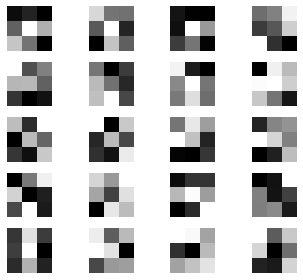

average of absolute gradients 1 tensor(1.3534e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5533e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3578e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4329e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9063e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8048e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2502e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2359e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7260e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4511e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1894e-07, device='cuda:0')


 14%|██████████▌                                                                  | 137/1000 [11:23<1:13:36,  5.12s/it]

Epoch: 137
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1901, -0.1442, -0.2154],
         [-0.0195,  0.2962,  0.1374],
         [ 0.1792,  0.0146, -0.2136]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


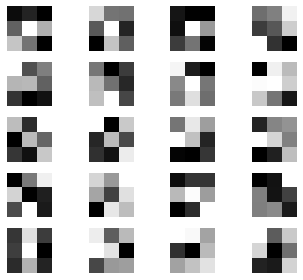

average of absolute gradients 1 tensor(1.3606e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3893e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6721e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2433e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7332e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6686e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5809e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6539e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7424e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3678e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0383e-06, device='cuda:0')


 14%|██████████▋                                                                  | 138/1000 [11:28<1:13:27,  5.11s/it]

Epoch: 138
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1901, -0.1445, -0.2152],
         [-0.0197,  0.2960,  0.1372],
         [ 0.1792,  0.0140, -0.2135]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


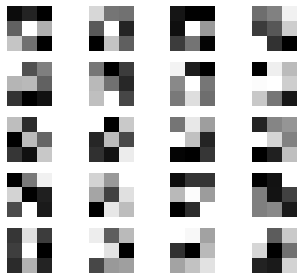

average of absolute gradients 1 tensor(1.7660e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3875e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3436e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4383e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2069e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3511e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6071e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8839e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5437e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4482e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9670e-06, device='cuda:0')


 14%|██████████▋                                                                  | 139/1000 [11:33<1:13:16,  5.11s/it]

Epoch: 139
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1892, -0.1438, -0.2151],
         [-0.0202,  0.2963,  0.1370],
         [ 0.1802,  0.0140, -0.2131]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


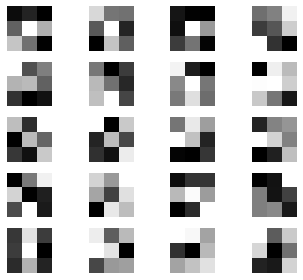

average of absolute gradients 1 tensor(1.4183e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4901e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6947e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6770e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6728e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7068e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4312e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8532e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3958e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2744e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.6660e-07, device='cuda:0')


 14%|██████████▊                                                                  | 140/1000 [11:38<1:12:54,  5.09s/it]

Epoch: 140
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1894, -0.1436, -0.2153],
         [-0.0210,  0.2957,  0.1362],
         [ 0.1809,  0.0138, -0.2128]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


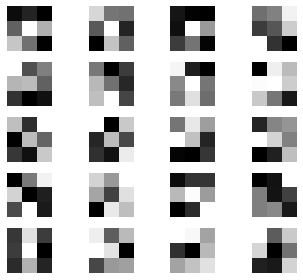

average of absolute gradients 1 tensor(1.2892e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5730e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3201e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7206e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5765e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2924e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4390e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3678e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3254e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8637e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7837e-06, device='cuda:0')


 14%|██████████▊                                                                  | 141/1000 [11:43<1:12:47,  5.08s/it]

Epoch: 141
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1887, -0.1432, -0.2147],
         [-0.0204,  0.2964,  0.1366],
         [ 0.1811,  0.0132, -0.2124]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


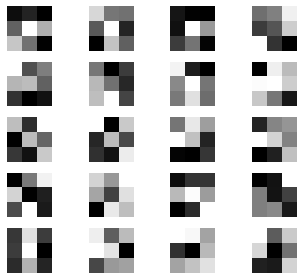

average of absolute gradients 1 tensor(1.8796e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2923e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3833e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2923e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4743e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0638e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2421e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3358e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2847e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4348e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1659e-06, device='cuda:0')


 14%|██████████▉                                                                  | 142/1000 [11:48<1:12:37,  5.08s/it]

Epoch: 142
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1887, -0.1434, -0.2149],
         [-0.0206,  0.2963,  0.1362],
         [ 0.1805,  0.0135, -0.2123]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


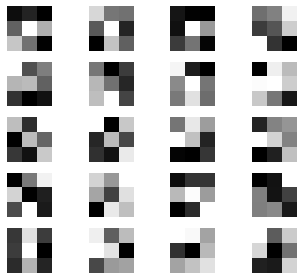

average of absolute gradients 1 tensor(1.3594e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2994e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3183e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0842e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4001e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3832e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6592e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4318e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3375e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6899e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.8415e-07, device='cuda:0')


 14%|███████████                                                                  | 143/1000 [11:53<1:12:21,  5.07s/it]

Epoch: 143
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1886, -0.1427, -0.2150],
         [-0.0201,  0.2967,  0.1363],
         [ 0.1803,  0.0136, -0.2118]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


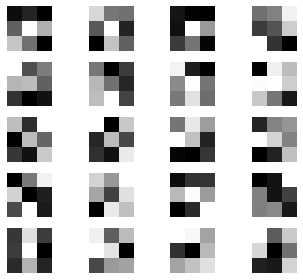

average of absolute gradients 1 tensor(1.2066e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6509e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3527e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5954e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3433e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1478e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4475e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5115e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6376e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9171e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.6516e-07, device='cuda:0')


 14%|███████████                                                                  | 144/1000 [11:58<1:12:16,  5.07s/it]

Epoch: 144
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1888, -0.1425, -0.2151],
         [-0.0199,  0.2960,  0.1365],
         [ 0.1806,  0.0134, -0.2116]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


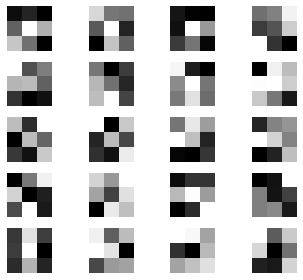

average of absolute gradients 1 tensor(1.4209e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5045e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8341e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2227e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0995e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3445e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4819e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3315e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4413e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6180e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0786e-06, device='cuda:0')


 14%|███████████▏                                                                 | 145/1000 [12:03<1:12:18,  5.07s/it]

Epoch: 145
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1891, -0.1421, -0.2154],
         [-0.0193,  0.2957,  0.1364],
         [ 0.1810,  0.0136, -0.2109]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


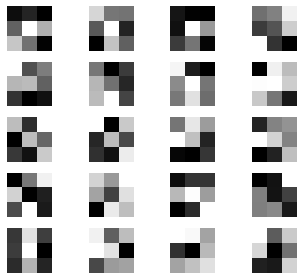

average of absolute gradients 1 tensor(1.6078e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4854e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6840e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4135e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3989e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3652e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2301e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4171e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3763e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5018e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9771e-07, device='cuda:0')


 15%|███████████▏                                                                 | 146/1000 [12:08<1:12:24,  5.09s/it]

Epoch: 146
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1890, -0.1416, -0.2154],
         [-0.0190,  0.2957,  0.1365],
         [ 0.1811,  0.0137, -0.2105]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


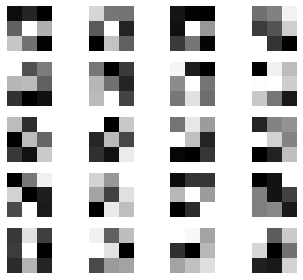

average of absolute gradients 1 tensor(1.2693e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5347e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3063e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5564e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2986e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2868e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4519e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4865e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3978e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2398e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8723e-06, device='cuda:0')


 15%|███████████▎                                                                 | 147/1000 [12:13<1:12:39,  5.11s/it]

Epoch: 147
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1889, -0.1410, -0.2154],
         [-0.0189,  0.2958,  0.1364],
         [ 0.1811,  0.0136, -0.2103]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


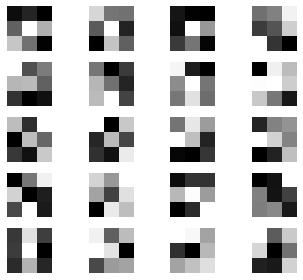

average of absolute gradients 1 tensor(1.4426e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5307e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1403e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5798e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4495e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1869e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5721e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2852e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5513e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2510e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0261e-06, device='cuda:0')


 15%|███████████▍                                                                 | 148/1000 [12:19<1:12:39,  5.12s/it]

Epoch: 148
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1898, -0.1411, -0.2159],
         [-0.0189,  0.2948,  0.1358],
         [ 0.1809,  0.0133, -0.2102]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


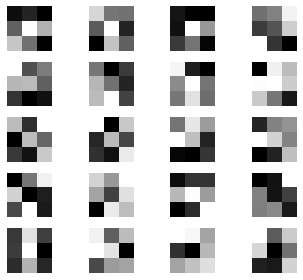

average of absolute gradients 1 tensor(1.3272e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3364e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5142e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2099e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3790e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5282e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4849e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3620e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4075e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3927e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.5756e-07, device='cuda:0')


 15%|███████████▍                                                                 | 149/1000 [12:24<1:13:49,  5.20s/it]

Epoch: 149
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1895, -0.1405, -0.2155],
         [-0.0186,  0.2954,  0.1362],
         [ 0.1809,  0.0135, -0.2097]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


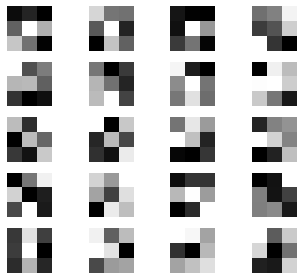

average of absolute gradients 1 tensor(1.4651e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2253e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5245e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6420e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2221e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4988e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5522e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3546e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1879e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5948e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.0454e-07, device='cuda:0')


 15%|███████████▌                                                                 | 150/1000 [12:30<1:15:34,  5.34s/it]

Epoch: 150
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1895, -0.1397, -0.2156],
         [-0.0186,  0.2953,  0.1362],
         [ 0.1809,  0.0134, -0.2096]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


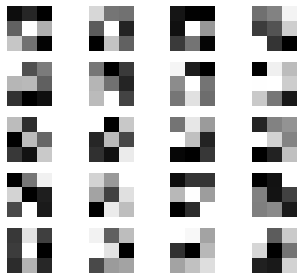

average of absolute gradients 1 tensor(1.5850e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5040e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5392e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2667e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4822e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6290e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2753e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2468e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5983e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3755e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.9369e-07, device='cuda:0')


 15%|███████████▋                                                                 | 151/1000 [12:35<1:14:48,  5.29s/it]

Epoch: 151
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1899, -0.1394, -0.2160],
         [-0.0186,  0.2950,  0.1359],
         [ 0.1804,  0.0128, -0.2095]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


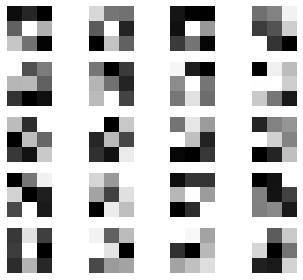

average of absolute gradients 1 tensor(1.4670e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3565e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3503e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4705e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3313e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6546e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5871e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3881e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4344e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6125e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5298e-06, device='cuda:0')


 15%|███████████▋                                                                 | 152/1000 [12:40<1:13:40,  5.21s/it]

Epoch: 152
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1897, -0.1398, -0.2160],
         [-0.0188,  0.2950,  0.1354],
         [ 0.1803,  0.0123, -0.2092]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


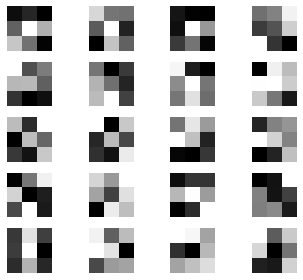

average of absolute gradients 1 tensor(1.5776e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3928e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5010e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2175e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4988e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4362e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8787e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4763e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6342e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5768e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2749e-06, device='cuda:0')


 15%|███████████▊                                                                 | 153/1000 [12:45<1:13:01,  5.17s/it]

Epoch: 153
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1899, -0.1395, -0.2161],
         [-0.0186,  0.2948,  0.1355],
         [ 0.1800,  0.0125, -0.2090]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


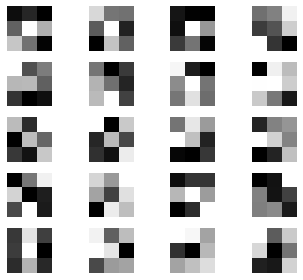

average of absolute gradients 1 tensor(1.3619e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2553e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3307e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4927e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3895e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4316e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9216e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6858e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8917e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4114e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6367e-06, device='cuda:0')


 15%|███████████▊                                                                 | 154/1000 [12:50<1:12:30,  5.14s/it]

Epoch: 154
Accuracy of train set: 5%
Accuracy of test set: 4%

tensor([[[-0.1901, -0.1396, -0.2162],
         [-0.0189,  0.2952,  0.1344],
         [ 0.1792,  0.0131, -0.2089]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


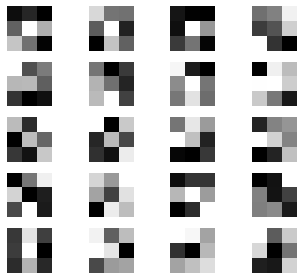

average of absolute gradients 1 tensor(1.2588e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3917e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3299e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7120e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2653e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9212e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8001e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4120e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6345e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5387e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8271e-06, device='cuda:0')


 16%|███████████▉                                                                 | 155/1000 [12:55<1:12:00,  5.11s/it]

Epoch: 155
Accuracy of train set: 6%
Accuracy of test set: 4%

tensor([[[-0.1897, -0.1393, -0.2155],
         [-0.0192,  0.2958,  0.1339],
         [ 0.1796,  0.0133, -0.2086]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


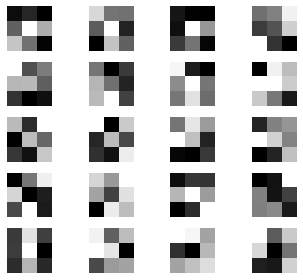

average of absolute gradients 1 tensor(1.2729e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6530e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9776e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5258e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2598e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7869e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7534e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6896e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9178e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0199e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.6469e-07, device='cuda:0')


 16%|████████████                                                                 | 156/1000 [13:00<1:11:54,  5.11s/it]

Epoch: 156
Accuracy of train set: 6%
Accuracy of test set: 5%

tensor([[[-0.1894, -0.1390, -0.2157],
         [-0.0191,  0.2962,  0.1333],
         [ 0.1790,  0.0137, -0.2085]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


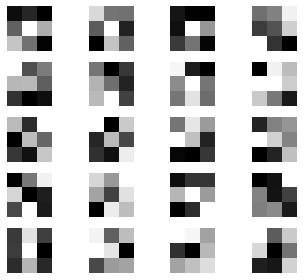

average of absolute gradients 1 tensor(1.7307e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5813e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8927e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8001e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4439e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9125e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7087e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1712e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6960e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4770e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4364e-06, device='cuda:0')


 16%|████████████                                                                 | 157/1000 [13:05<1:11:28,  5.09s/it]

Epoch: 157
Accuracy of train set: 6%
Accuracy of test set: 4%

tensor([[[-0.1892, -0.1387, -0.2157],
         [-0.0194,  0.2967,  0.1329],
         [ 0.1784,  0.0139, -0.2083]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


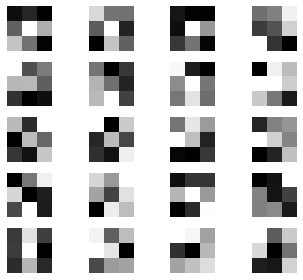

average of absolute gradients 1 tensor(2.2327e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0457e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3828e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9478e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4333e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9352e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2763e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5638e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4735e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6580e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1723e-06, device='cuda:0')


 16%|████████████▏                                                                | 158/1000 [13:10<1:10:58,  5.06s/it]

Epoch: 158
Accuracy of train set: 6%
Accuracy of test set: 5%

tensor([[[-0.1889, -0.1386, -0.2154],
         [-0.0201,  0.2974,  0.1327],
         [ 0.1772,  0.0148, -0.2083]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


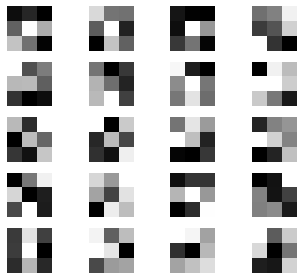

average of absolute gradients 1 tensor(1.9517e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9731e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5012e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4942e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9774e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5295e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5313e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1354e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9238e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7469e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9253e-06, device='cuda:0')


 16%|████████████▏                                                                | 159/1000 [13:15<1:10:35,  5.04s/it]

Epoch: 159
Accuracy of train set: 6%
Accuracy of test set: 5%

tensor([[[-0.1889, -0.1404, -0.2162],
         [-0.0201,  0.2962,  0.1316],
         [ 0.1766,  0.0152, -0.2086]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


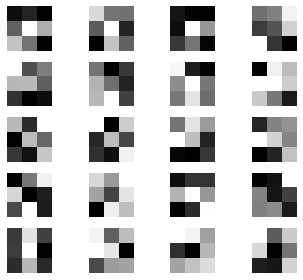

average of absolute gradients 1 tensor(2.2345e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6923e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5964e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6301e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1345e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0138e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1921e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6027e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4616e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3380e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0164e-06, device='cuda:0')


 16%|████████████▎                                                                | 160/1000 [13:20<1:10:15,  5.02s/it]

Epoch: 160
Accuracy of train set: 6%
Accuracy of test set: 5%

tensor([[[-0.1882, -0.1392, -0.2160],
         [-0.0198,  0.2972,  0.1314],
         [ 0.1763,  0.0169, -0.2084]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


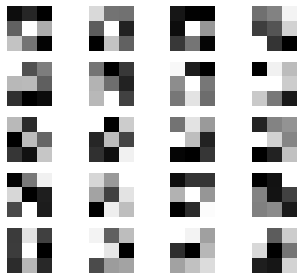

average of absolute gradients 1 tensor(1.5851e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6465e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5752e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4464e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7454e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8882e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4905e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1631e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5538e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6014e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8268e-06, device='cuda:0')


 16%|████████████▍                                                                | 161/1000 [13:25<1:10:44,  5.06s/it]

Epoch: 161
Accuracy of train set: 6%
Accuracy of test set: 5%

tensor([[[-0.1881, -0.1397, -0.2159],
         [-0.0205,  0.2975,  0.1298],
         [ 0.1755,  0.0183, -0.2088]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


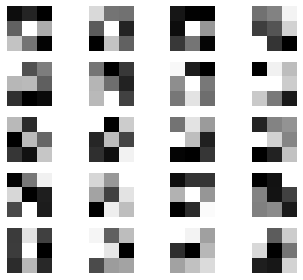

average of absolute gradients 1 tensor(1.6503e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8760e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1766e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2988e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2307e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9016e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5344e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6779e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0367e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3030e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2186e-06, device='cuda:0')


 16%|████████████▍                                                                | 162/1000 [13:30<1:10:31,  5.05s/it]

Epoch: 162
Accuracy of train set: 6%
Accuracy of test set: 5%

tensor([[[-0.1884, -0.1402, -0.2161],
         [-0.0201,  0.2969,  0.1283],
         [ 0.1753,  0.0195, -0.2092]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


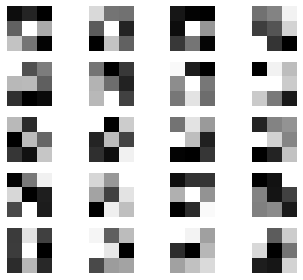

average of absolute gradients 1 tensor(2.0898e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9350e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0179e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4901e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8579e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2386e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3639e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3993e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7880e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2238e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6804e-06, device='cuda:0')


 16%|████████████▌                                                                | 163/1000 [13:35<1:10:24,  5.05s/it]

Epoch: 163
Accuracy of train set: 6%
Accuracy of test set: 5%

tensor([[[-0.1883, -0.1399, -0.2158],
         [-0.0204,  0.2973,  0.1281],
         [ 0.1741,  0.0210, -0.2095]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


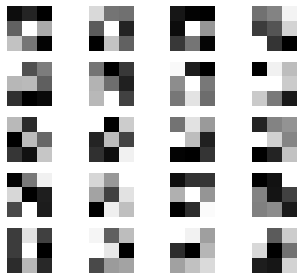

average of absolute gradients 1 tensor(1.8536e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9747e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9405e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1166e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3320e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4553e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8337e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5868e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8049e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6593e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9074e-06, device='cuda:0')


 16%|████████████▋                                                                | 164/1000 [13:40<1:10:31,  5.06s/it]

Epoch: 164
Accuracy of train set: 6%
Accuracy of test set: 5%

tensor([[[-0.1882, -0.1398, -0.2156],
         [-0.0205,  0.2977,  0.1270],
         [ 0.1732,  0.0215, -0.2101]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


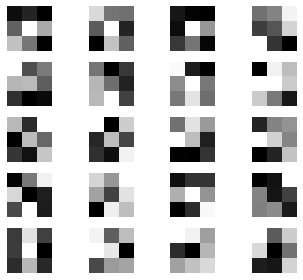

average of absolute gradients 1 tensor(1.9046e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7918e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9824e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4232e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3474e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3359e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2916e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1279e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4746e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9725e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0092e-06, device='cuda:0')


 16%|████████████▋                                                                | 165/1000 [13:45<1:10:07,  5.04s/it]

Epoch: 165
Accuracy of train set: 6%
Accuracy of test set: 5%

tensor([[[-0.1882, -0.1401, -0.2159],
         [-0.0210,  0.2974,  0.1264],
         [ 0.1727,  0.0220, -0.2102]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


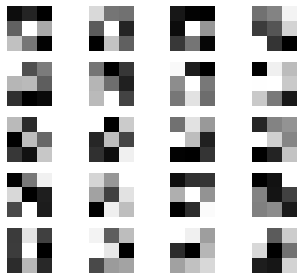

average of absolute gradients 1 tensor(2.7865e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4568e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0906e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3416e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0988e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7517e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7952e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5378e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1102e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4076e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1950e-06, device='cuda:0')


 17%|████████████▊                                                                | 166/1000 [13:50<1:10:01,  5.04s/it]

Epoch: 166
Accuracy of train set: 6%
Accuracy of test set: 5%

tensor([[[-0.1879, -0.1391, -0.2159],
         [-0.0212,  0.2979,  0.1259],
         [ 0.1729,  0.0221, -0.2099]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


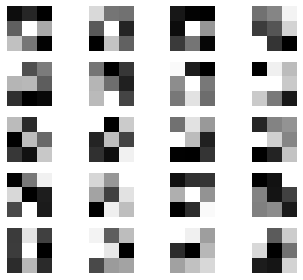

average of absolute gradients 1 tensor(2.0616e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3102e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3338e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7610e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8184e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4789e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2599e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9400e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9181e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0019e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3881e-06, device='cuda:0')


 17%|████████████▊                                                                | 167/1000 [13:55<1:09:51,  5.03s/it]

Epoch: 167
Accuracy of train set: 6%
Accuracy of test set: 5%

tensor([[[-0.1877, -0.1391, -0.2156],
         [-0.0211,  0.2969,  0.1255],
         [ 0.1742,  0.0229, -0.2103]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


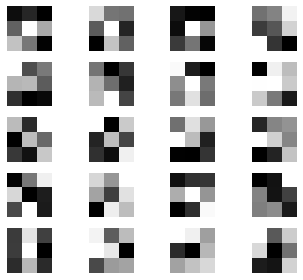

average of absolute gradients 1 tensor(2.1414e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1057e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3598e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1017e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5193e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7141e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0786e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2877e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4299e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5918e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1652e-06, device='cuda:0')


 17%|████████████▉                                                                | 168/1000 [14:00<1:09:30,  5.01s/it]

Epoch: 168
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1871, -0.1393, -0.2149],
         [-0.0217,  0.2978,  0.1259],
         [ 0.1730,  0.0231, -0.2102]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


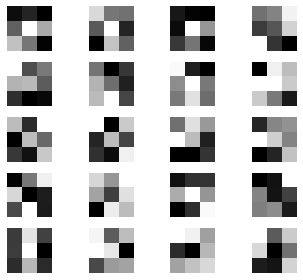

average of absolute gradients 1 tensor(2.6846e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0891e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3395e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9524e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2461e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4207e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7657e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6115e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9939e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3317e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0886e-06, device='cuda:0')


 17%|█████████████                                                                | 169/1000 [14:05<1:09:12,  5.00s/it]

Epoch: 169
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1869, -0.1407, -0.2145],
         [-0.0216,  0.2972,  0.1257],
         [ 0.1732,  0.0222, -0.2102]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


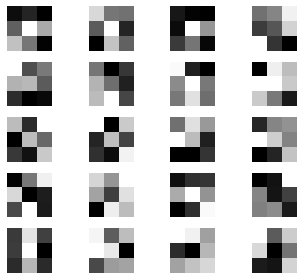

average of absolute gradients 1 tensor(2.0926e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3876e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5080e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6169e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6256e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7740e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3494e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2521e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5535e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5227e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2011e-06, device='cuda:0')


 17%|█████████████                                                                | 170/1000 [14:10<1:08:48,  4.97s/it]

Epoch: 170
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1868, -0.1409, -0.2148],
         [-0.0220,  0.2971,  0.1256],
         [ 0.1727,  0.0222, -0.2099]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


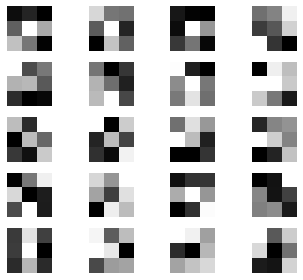

average of absolute gradients 1 tensor(1.9915e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0409e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6735e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2941e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3452e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2109e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8324e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1857e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8287e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3937e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8217e-06, device='cuda:0')


 17%|█████████████▏                                                               | 171/1000 [14:15<1:08:56,  4.99s/it]

Epoch: 171
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1870, -0.1398, -0.2151],
         [-0.0224,  0.2979,  0.1241],
         [ 0.1724,  0.0229, -0.2094]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


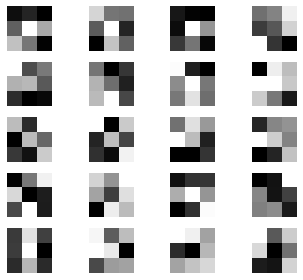

average of absolute gradients 1 tensor(2.4640e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1404e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4847e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2033e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6802e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3259e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7831e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3459e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1327e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6870e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9863e-06, device='cuda:0')


 17%|█████████████▏                                                               | 172/1000 [14:20<1:09:24,  5.03s/it]

Epoch: 172
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1866, -0.1392, -0.2150],
         [-0.0228,  0.2985,  0.1246],
         [ 0.1719,  0.0230, -0.2089]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


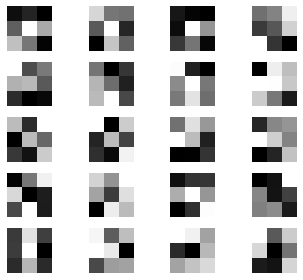

average of absolute gradients 1 tensor(3.3448e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0872e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6967e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7856e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1037e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7440e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5926e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3500e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7868e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1932e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6798e-06, device='cuda:0')


 17%|█████████████▎                                                               | 173/1000 [14:26<1:09:37,  5.05s/it]

Epoch: 173
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1868, -0.1385, -0.2151],
         [-0.0236,  0.2983,  0.1244],
         [ 0.1720,  0.0232, -0.2088]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


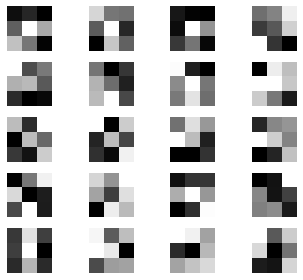

average of absolute gradients 1 tensor(1.8470e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6367e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6674e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7487e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4166e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9309e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3214e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4386e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4485e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6092e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.7959e-07, device='cuda:0')


 17%|█████████████▍                                                               | 174/1000 [14:31<1:09:17,  5.03s/it]

Epoch: 174
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1868, -0.1385, -0.2152],
         [-0.0231,  0.2978,  0.1243],
         [ 0.1715,  0.0233, -0.2093]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


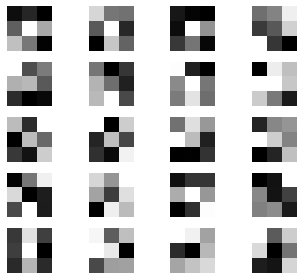

average of absolute gradients 1 tensor(2.1360e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1985e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1151e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3299e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6681e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0870e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5145e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3861e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8726e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4356e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1065e-06, device='cuda:0')


 18%|█████████████▍                                                               | 175/1000 [14:36<1:08:53,  5.01s/it]

Epoch: 175
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1870, -0.1384, -0.2149],
         [-0.0233,  0.2976,  0.1249],
         [ 0.1709,  0.0226, -0.2093]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


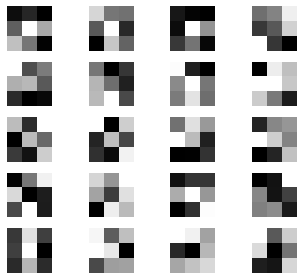

average of absolute gradients 1 tensor(2.5360e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0148e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1988e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1213e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1089e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6546e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0015e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4030e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4172e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0006e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5959e-06, device='cuda:0')


 18%|█████████████▌                                                               | 176/1000 [14:40<1:08:39,  5.00s/it]

Epoch: 176
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1879, -0.1385, -0.2149],
         [-0.0235,  0.2974,  0.1259],
         [ 0.1693,  0.0215, -0.2090]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


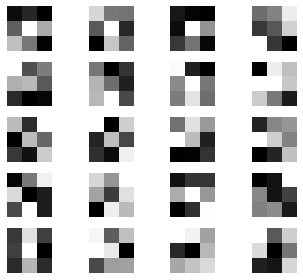

average of absolute gradients 1 tensor(2.3838e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2580e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8854e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5728e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1975e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0817e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6528e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4567e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4683e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2300e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5994e-06, device='cuda:0')


 18%|█████████████▋                                                               | 177/1000 [14:45<1:08:22,  4.98s/it]

Epoch: 177
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1880, -0.1379, -0.2146],
         [-0.0242,  0.2978,  0.1255],
         [ 0.1690,  0.0213, -0.2089]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


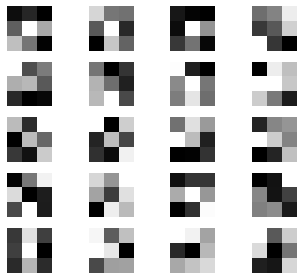

average of absolute gradients 1 tensor(2.2028e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1010e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8436e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0056e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5046e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8884e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0293e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0932e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9039e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0869e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0860e-06, device='cuda:0')


 18%|█████████████▋                                                               | 178/1000 [14:50<1:08:18,  4.99s/it]

Epoch: 178
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1883, -0.1376, -0.2141],
         [-0.0245,  0.2979,  0.1256],
         [ 0.1684,  0.0208, -0.2089]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


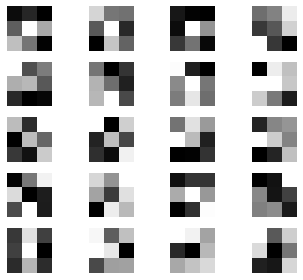

average of absolute gradients 1 tensor(2.0328e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4936e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5511e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7609e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2215e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1886e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9277e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8090e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8748e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6938e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7070e-06, device='cuda:0')


 18%|█████████████▊                                                               | 179/1000 [14:55<1:08:14,  4.99s/it]

Epoch: 179
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1885, -0.1376, -0.2136],
         [-0.0233,  0.2982,  0.1257],
         [ 0.1682,  0.0204, -0.2086]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


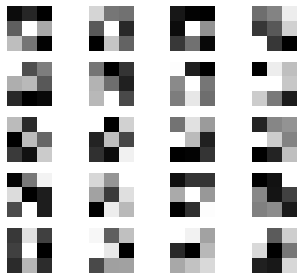

average of absolute gradients 1 tensor(1.6526e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7122e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7666e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1355e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2582e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7234e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0745e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1661e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9399e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5697e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8962e-06, device='cuda:0')


 18%|█████████████▊                                                               | 180/1000 [15:00<1:08:17,  5.00s/it]

Epoch: 180
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1896, -0.1383, -0.2138],
         [-0.0241,  0.2972,  0.1253],
         [ 0.1672,  0.0190, -0.2089]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


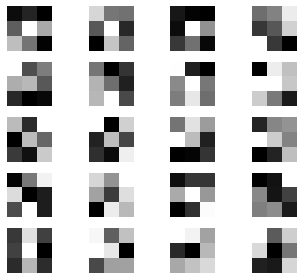

average of absolute gradients 1 tensor(1.7756e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9622e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9232e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2550e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3416e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2242e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0601e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9436e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8650e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2933e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.5359e-07, device='cuda:0')


 18%|█████████████▉                                                               | 181/1000 [15:05<1:08:07,  4.99s/it]

Epoch: 181
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1900, -0.1382, -0.2130],
         [-0.0238,  0.2974,  0.1255],
         [ 0.1664,  0.0180, -0.2091]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


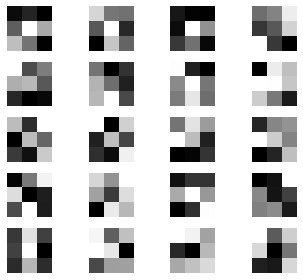

average of absolute gradients 1 tensor(1.7061e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3678e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0563e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2703e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6284e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1317e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9663e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8848e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4481e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8302e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.9236e-07, device='cuda:0')


 18%|██████████████                                                               | 182/1000 [15:10<1:07:58,  4.99s/it]

Epoch: 182
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1906, -0.1381, -0.2128],
         [-0.0237,  0.2975,  0.1246],
         [ 0.1663,  0.0173, -0.2088]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


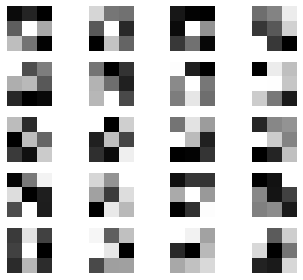

average of absolute gradients 1 tensor(2.0533e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9285e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3376e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9088e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7242e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3630e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2488e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8778e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9622e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8679e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3359e-06, device='cuda:0')


 18%|██████████████                                                               | 183/1000 [15:15<1:07:53,  4.99s/it]

Epoch: 183
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1910, -0.1374, -0.2125],
         [-0.0231,  0.2981,  0.1233],
         [ 0.1663,  0.0174, -0.2086]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


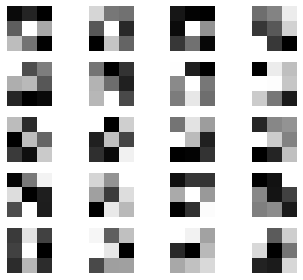

average of absolute gradients 1 tensor(2.1335e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3108e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9747e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2309e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1943e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9722e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2717e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0049e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1501e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9530e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4964e-06, device='cuda:0')


 18%|██████████████▏                                                              | 184/1000 [15:20<1:07:53,  4.99s/it]

Epoch: 184
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1916, -0.1379, -0.2117],
         [-0.0231,  0.2981,  0.1225],
         [ 0.1663,  0.0162, -0.2085]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


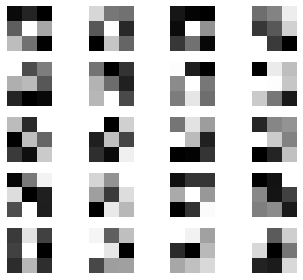

average of absolute gradients 1 tensor(2.0518e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9827e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1398e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0085e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1309e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7066e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9659e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7827e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9100e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5813e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1662e-06, device='cuda:0')


 18%|██████████████▏                                                              | 185/1000 [15:26<1:08:23,  5.04s/it]

Epoch: 185
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1922, -0.1384, -0.2116],
         [-0.0224,  0.2979,  0.1224],
         [ 0.1659,  0.0154, -0.2081]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


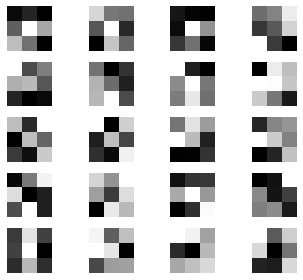

average of absolute gradients 1 tensor(1.6410e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0623e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7036e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9108e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4579e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6369e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9931e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0936e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1978e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9642e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0898e-06, device='cuda:0')


 19%|██████████████▎                                                              | 186/1000 [15:31<1:08:23,  5.04s/it]

Epoch: 186
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1921, -0.1385, -0.2116],
         [-0.0225,  0.2976,  0.1222],
         [ 0.1661,  0.0156, -0.2077]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


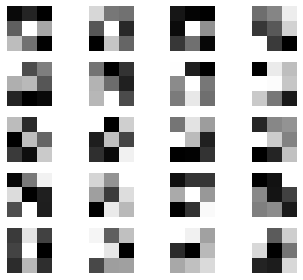

average of absolute gradients 1 tensor(1.7823e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6213e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8062e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7196e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8732e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4413e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9800e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6134e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5647e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6075e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9183e-06, device='cuda:0')


 19%|██████████████▍                                                              | 187/1000 [15:36<1:07:55,  5.01s/it]

Epoch: 187
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1921, -0.1382, -0.2118],
         [-0.0231,  0.2972,  0.1220],
         [ 0.1664,  0.0156, -0.2076]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


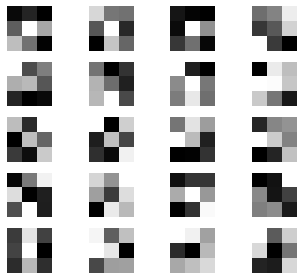

average of absolute gradients 1 tensor(1.7019e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7177e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6431e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7552e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6693e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0231e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5269e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0570e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8871e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9513e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5781e-06, device='cuda:0')


 19%|██████████████▍                                                              | 188/1000 [15:40<1:07:32,  4.99s/it]

Epoch: 188
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1918, -0.1381, -0.2114],
         [-0.0228,  0.2972,  0.1220],
         [ 0.1673,  0.0153, -0.2071]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


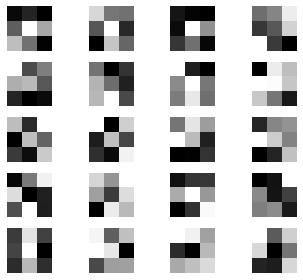

average of absolute gradients 1 tensor(1.7590e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5507e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8256e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9336e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5793e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7470e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7413e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7720e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6024e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9565e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6412e-06, device='cuda:0')


 19%|██████████████▌                                                              | 189/1000 [15:45<1:07:31,  5.00s/it]

Epoch: 189
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1914, -0.1379, -0.2113],
         [-0.0231,  0.2969,  0.1227],
         [ 0.1678,  0.0150, -0.2069]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


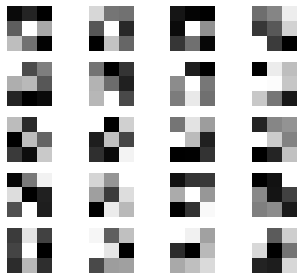

average of absolute gradients 1 tensor(1.9518e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5143e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6042e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6476e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6032e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8284e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8258e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2178e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7769e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5708e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.7114e-07, device='cuda:0')


 19%|██████████████▋                                                              | 190/1000 [15:50<1:07:17,  4.98s/it]

Epoch: 190
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1907, -0.1374, -0.2111],
         [-0.0230,  0.2969,  0.1228],
         [ 0.1685,  0.0148, -0.2068]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


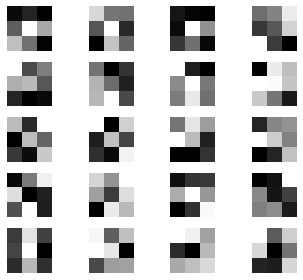

average of absolute gradients 1 tensor(1.2878e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7871e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7695e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6510e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8142e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5665e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8171e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7336e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9282e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8247e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8365e-06, device='cuda:0')


 19%|██████████████▋                                                              | 191/1000 [15:55<1:07:15,  4.99s/it]

Epoch: 191
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1909, -0.1376, -0.2111],
         [-0.0231,  0.2963,  0.1229],
         [ 0.1685,  0.0144, -0.2068]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


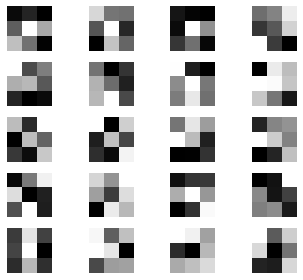

average of absolute gradients 1 tensor(1.9347e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6840e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2875e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4648e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0104e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8272e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9060e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6298e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4588e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9190e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8262e-06, device='cuda:0')


 19%|██████████████▊                                                              | 192/1000 [16:00<1:07:04,  4.98s/it]

Epoch: 192
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1907, -0.1377, -0.2107],
         [-0.0230,  0.2958,  0.1232],
         [ 0.1694,  0.0143, -0.2064]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


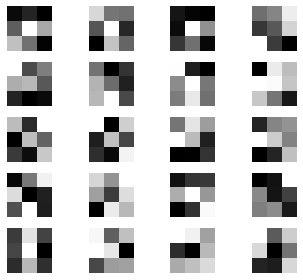

average of absolute gradients 1 tensor(1.5627e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3258e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4863e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8860e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7210e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7098e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4534e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5786e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7102e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8243e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8533e-07, device='cuda:0')


 19%|██████████████▊                                                              | 193/1000 [16:05<1:07:04,  4.99s/it]

Epoch: 193
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1902, -0.1373, -0.2108],
         [-0.0227,  0.2954,  0.1240],
         [ 0.1696,  0.0142, -0.2064]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


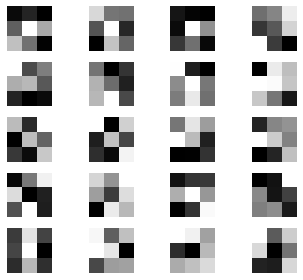

average of absolute gradients 1 tensor(1.5779e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1543e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4183e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3298e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6716e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7716e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7525e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5917e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5530e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9153e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5946e-06, device='cuda:0')


 19%|██████████████▉                                                              | 194/1000 [16:10<1:06:52,  4.98s/it]

Epoch: 194
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1901, -0.1371, -0.2109],
         [-0.0229,  0.2953,  0.1242],
         [ 0.1697,  0.0144, -0.2059]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


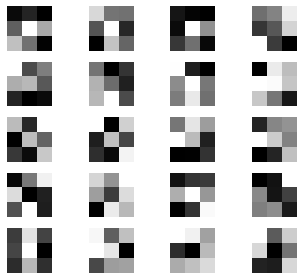

average of absolute gradients 1 tensor(1.7048e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5726e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3710e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8282e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7884e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7689e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7328e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6409e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5001e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6286e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1612e-06, device='cuda:0')


 20%|███████████████                                                              | 195/1000 [16:15<1:06:51,  4.98s/it]

Epoch: 195
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1906, -0.1377, -0.2114],
         [-0.0230,  0.2942,  0.1237],
         [ 0.1693,  0.0142, -0.2061]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


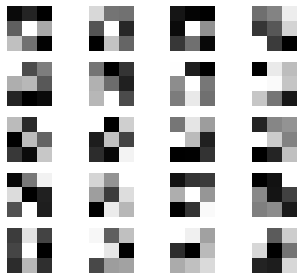

average of absolute gradients 1 tensor(1.9447e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3721e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4539e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8066e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4954e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7231e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6447e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7828e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8583e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4714e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.0857e-07, device='cuda:0')


 20%|███████████████                                                              | 196/1000 [16:20<1:06:47,  4.98s/it]

Epoch: 196
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1902, -0.1371, -0.2112],
         [-0.0228,  0.2947,  0.1242],
         [ 0.1691,  0.0146, -0.2058]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


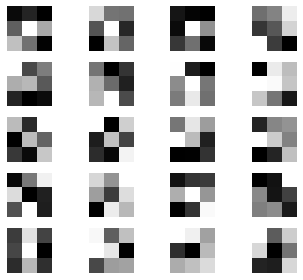

average of absolute gradients 1 tensor(1.6840e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6600e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5865e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7445e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7302e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7572e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5999e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5353e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4250e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5763e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6227e-06, device='cuda:0')


 20%|███████████████▏                                                             | 197/1000 [16:25<1:06:49,  4.99s/it]

Epoch: 197
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1902, -0.1369, -0.2114],
         [-0.0224,  0.2947,  0.1242],
         [ 0.1684,  0.0147, -0.2056]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


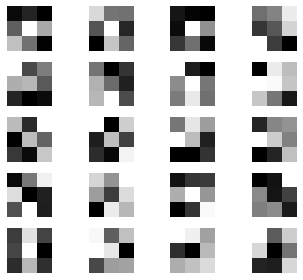

average of absolute gradients 1 tensor(1.3731e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6110e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7357e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7169e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4117e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8663e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5427e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6034e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6567e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6459e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2012e-06, device='cuda:0')


 20%|███████████████▏                                                             | 198/1000 [16:30<1:06:39,  4.99s/it]

Epoch: 198
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1903, -0.1372, -0.2117],
         [-0.0222,  0.2941,  0.1242],
         [ 0.1683,  0.0142, -0.2055]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


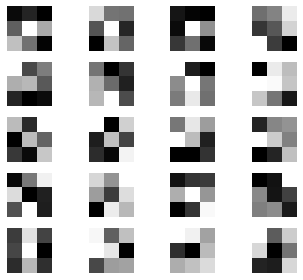

average of absolute gradients 1 tensor(1.5995e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7091e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5131e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5720e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5960e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4179e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5819e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9622e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6402e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6942e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7424e-06, device='cuda:0')


 20%|███████████████▎                                                             | 199/1000 [16:35<1:06:46,  5.00s/it]

Epoch: 199
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1900, -0.1371, -0.2111],
         [-0.0219,  0.2939,  0.1247],
         [ 0.1689,  0.0143, -0.2054]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


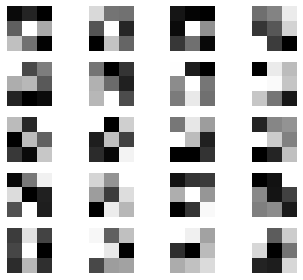

average of absolute gradients 1 tensor(1.7547e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6228e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6600e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4798e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4298e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4937e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5749e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7407e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5899e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6892e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5340e-06, device='cuda:0')


 20%|███████████████▍                                                             | 200/1000 [16:41<1:07:25,  5.06s/it]

Epoch: 200
Accuracy of train set: 7%
Accuracy of test set: 4%

tensor([[[-0.1895, -0.1371, -0.2110],
         [-0.0216,  0.2936,  0.1246],
         [ 0.1696,  0.0140, -0.2053]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


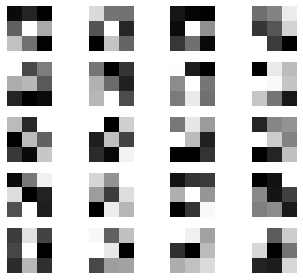

average of absolute gradients 1 tensor(2.0261e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8816e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5674e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5801e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5451e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5217e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9684e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7710e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7694e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6250e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.3520e-07, device='cuda:0')


 20%|███████████████▍                                                             | 201/1000 [16:46<1:08:37,  5.15s/it]

Epoch: 201
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1900, -0.1369, -0.2109],
         [-0.0216,  0.2933,  0.1245],
         [ 0.1692,  0.0141, -0.2054]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


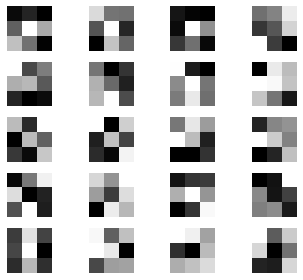

average of absolute gradients 1 tensor(1.6901e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4112e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5904e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6229e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4264e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8749e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4826e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6244e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8279e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5363e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4069e-06, device='cuda:0')


 20%|███████████████▌                                                             | 202/1000 [16:51<1:09:22,  5.22s/it]

Epoch: 202
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1898, -0.1366, -0.2109],
         [-0.0213,  0.2936,  0.1245],
         [ 0.1689,  0.0134, -0.2051]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


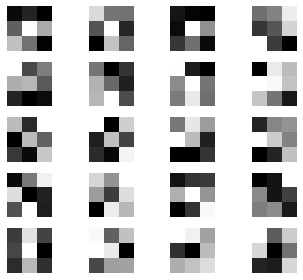

average of absolute gradients 1 tensor(1.7959e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9283e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5649e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5503e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5492e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3037e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0218e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6365e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3500e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8427e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2209e-06, device='cuda:0')


 20%|███████████████▋                                                             | 203/1000 [16:56<1:08:32,  5.16s/it]

Epoch: 203
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1895, -0.1366, -0.2108],
         [-0.0210,  0.2934,  0.1246],
         [ 0.1693,  0.0131, -0.2050]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


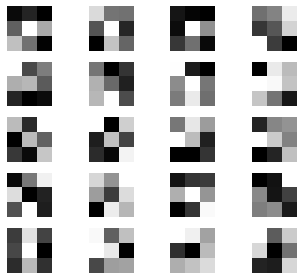

average of absolute gradients 1 tensor(1.7511e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6052e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4826e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4422e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4733e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4187e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7582e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2612e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7820e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6220e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3744e-06, device='cuda:0')


 20%|███████████████▋                                                             | 204/1000 [17:01<1:08:03,  5.13s/it]

Epoch: 204
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1896, -0.1363, -0.2101],
         [-0.0204,  0.2933,  0.1244],
         [ 0.1700,  0.0134, -0.2048]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


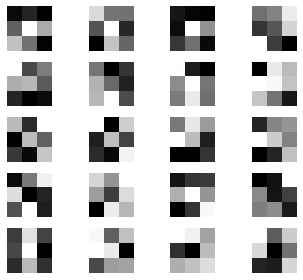

average of absolute gradients 1 tensor(1.4908e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9323e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4845e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7113e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3722e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5532e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8567e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7477e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7161e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1213e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2571e-06, device='cuda:0')


 20%|███████████████▊                                                             | 205/1000 [17:06<1:07:55,  5.13s/it]

Epoch: 205
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1899, -0.1363, -0.2100],
         [-0.0204,  0.2931,  0.1242],
         [ 0.1699,  0.0136, -0.2046]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


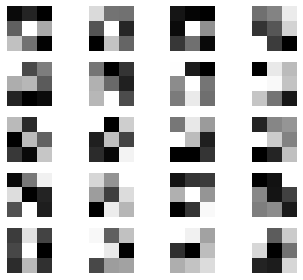

average of absolute gradients 1 tensor(1.5428e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8760e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.4603e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6552e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9453e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5881e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7882e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6343e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8480e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6999e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3986e-06, device='cuda:0')


 21%|███████████████▊                                                             | 206/1000 [17:11<1:07:14,  5.08s/it]

Epoch: 206
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1900, -0.1360, -0.2099],
         [-0.0200,  0.2926,  0.1241],
         [ 0.1706,  0.0135, -0.2044]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


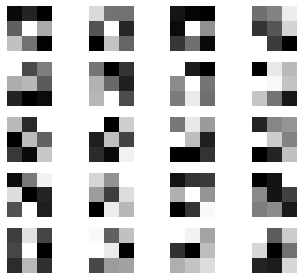

average of absolute gradients 1 tensor(1.9438e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9476e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5181e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7661e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5488e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6609e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6331e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8846e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6756e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8609e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.3151e-07, device='cuda:0')


 21%|███████████████▉                                                             | 207/1000 [17:17<1:07:56,  5.14s/it]

Epoch: 207
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1902, -0.1358, -0.2100],
         [-0.0199,  0.2923,  0.1239],
         [ 0.1705,  0.0133, -0.2045]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


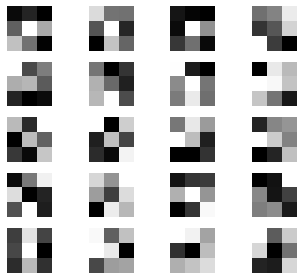

average of absolute gradients 1 tensor(1.5996e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5790e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7583e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7170e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7082e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8250e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1086e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0059e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6630e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6428e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3680e-06, device='cuda:0')


 21%|████████████████                                                             | 208/1000 [17:22<1:07:47,  5.14s/it]

Epoch: 208
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1899, -0.1358, -0.2098],
         [-0.0196,  0.2923,  0.1239],
         [ 0.1705,  0.0134, -0.2043]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


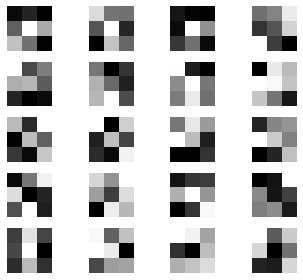

average of absolute gradients 1 tensor(1.6044e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9627e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5524e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5252e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0458e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6757e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7000e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1588e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8580e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8936e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9505e-06, device='cuda:0')


 21%|████████████████                                                             | 209/1000 [17:27<1:07:57,  5.15s/it]

Epoch: 209
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1897, -0.1354, -0.2094],
         [-0.0196,  0.2919,  0.1239],
         [ 0.1713,  0.0137, -0.2045]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


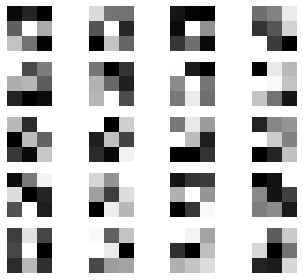

average of absolute gradients 1 tensor(2.2203e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7912e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8109e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7834e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6989e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2375e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5584e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8349e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0966e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6563e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3906e-06, device='cuda:0')


 21%|████████████████▏                                                            | 210/1000 [17:32<1:08:47,  5.22s/it]

Epoch: 210
Accuracy of train set: 8%
Accuracy of test set: 5%

tensor([[[-0.1901, -0.1360, -0.2095],
         [-0.0194,  0.2910,  0.1241],
         [ 0.1711,  0.0128, -0.2045]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


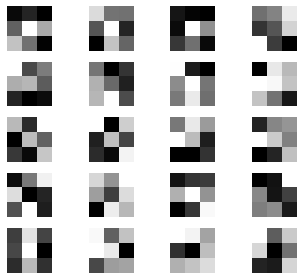

average of absolute gradients 1 tensor(1.8611e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0554e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0108e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7945e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0126e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8286e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0188e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5476e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5984e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8466e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4170e-06, device='cuda:0')


 21%|████████████████▏                                                            | 211/1000 [17:38<1:08:14,  5.19s/it]

Epoch: 211
Accuracy of train set: 7%
Accuracy of test set: 5%

tensor([[[-0.1903, -0.1361, -0.2095],
         [-0.0188,  0.2907,  0.1242],
         [ 0.1710,  0.0128, -0.2042]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


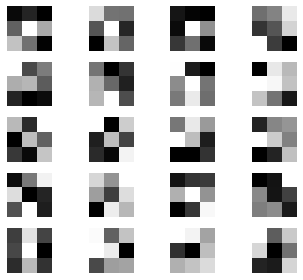

average of absolute gradients 1 tensor(2.0157e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9477e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9196e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8077e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4159e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8133e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8932e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4484e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8946e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8552e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1863e-06, device='cuda:0')


 21%|████████████████▎                                                            | 212/1000 [17:43<1:07:17,  5.12s/it]

Epoch: 212
Accuracy of train set: 8%
Accuracy of test set: 5%

tensor([[[-0.1900, -0.1357, -0.2092],
         [-0.0192,  0.2908,  0.1247],
         [ 0.1708,  0.0126, -0.2041]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


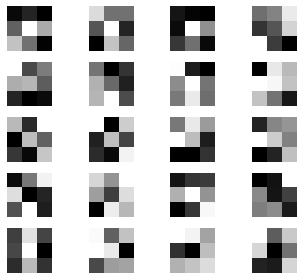

average of absolute gradients 1 tensor(2.0758e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5074e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3460e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9723e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2314e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8634e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4234e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2155e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0000e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9366e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3377e-06, device='cuda:0')


 21%|████████████████▍                                                            | 213/1000 [17:48<1:06:48,  5.09s/it]

Epoch: 213
Accuracy of train set: 8%
Accuracy of test set: 5%

tensor([[[-0.1900, -0.1354, -0.2092],
         [-0.0193,  0.2902,  0.1255],
         [ 0.1708,  0.0121, -0.2041]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


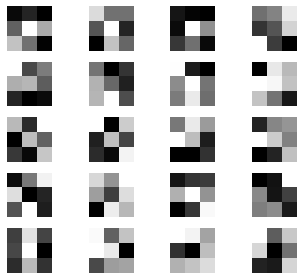

average of absolute gradients 1 tensor(1.6552e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2539e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4701e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9520e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5659e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8626e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2543e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9724e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9660e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1618e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7245e-06, device='cuda:0')


 21%|████████████████▍                                                            | 214/1000 [17:53<1:06:16,  5.06s/it]

Epoch: 214
Accuracy of train set: 8%
Accuracy of test set: 5%

tensor([[[-0.1905, -0.1356, -0.2098],
         [-0.0196,  0.2891,  0.1259],
         [ 0.1704,  0.0121, -0.2041]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


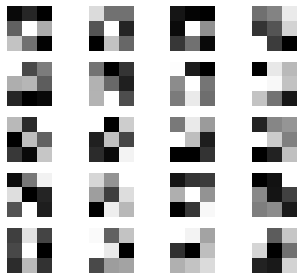

average of absolute gradients 1 tensor(1.9249e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3609e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2997e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1648e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7611e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7699e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9696e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3318e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8652e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8930e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.2288e-07, device='cuda:0')


 22%|████████████████▌                                                            | 215/1000 [17:57<1:05:38,  5.02s/it]

Epoch: 215
Accuracy of train set: 8%
Accuracy of test set: 5%

tensor([[[-0.1899, -0.1355, -0.2093],
         [-0.0195,  0.2892,  0.1263],
         [ 0.1711,  0.0121, -0.2036]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


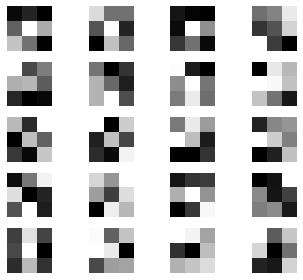

average of absolute gradients 1 tensor(2.4997e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0556e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0474e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1306e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6282e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1376e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2527e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5941e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5431e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5499e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5892e-06, device='cuda:0')


 22%|████████████████▋                                                            | 216/1000 [18:02<1:05:07,  4.98s/it]

Epoch: 216
Accuracy of train set: 8%
Accuracy of test set: 5%

tensor([[[-0.1905, -0.1364, -0.2095],
         [-0.0193,  0.2881,  0.1264],
         [ 0.1699,  0.0122, -0.2040]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


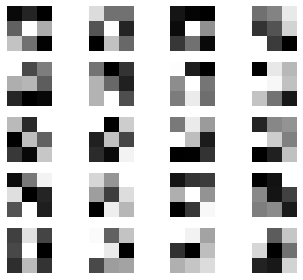

average of absolute gradients 1 tensor(1.8453e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4017e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5689e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1971e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9434e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4564e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6091e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0819e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3952e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9278e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9784e-06, device='cuda:0')


 22%|████████████████▋                                                            | 217/1000 [18:07<1:05:33,  5.02s/it]

Epoch: 217
Accuracy of train set: 8%
Accuracy of test set: 5%

tensor([[[-0.1904, -0.1364, -0.2093],
         [-0.0190,  0.2877,  0.1263],
         [ 0.1707,  0.0132, -0.2039]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


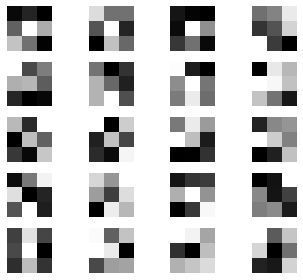

average of absolute gradients 1 tensor(2.2611e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6757e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7227e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1149e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5365e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4296e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8619e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8011e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5809e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6975e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8747e-06, device='cuda:0')


 22%|████████████████▊                                                            | 218/1000 [18:13<1:06:42,  5.12s/it]

Epoch: 218
Accuracy of train set: 8%
Accuracy of test set: 5%

tensor([[[-0.1908, -0.1373, -0.2092],
         [-0.0191,  0.2868,  0.1264],
         [ 0.1701,  0.0127, -0.2043]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


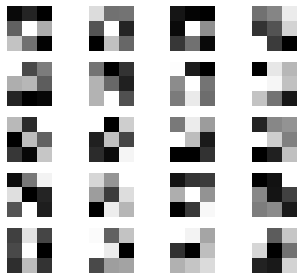

average of absolute gradients 1 tensor(2.6882e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1486e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7023e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4624e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3420e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0613e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4393e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2343e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7385e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3275e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2432e-06, device='cuda:0')


 22%|████████████████▊                                                            | 219/1000 [18:18<1:06:43,  5.13s/it]

Epoch: 219
Accuracy of train set: 8%
Accuracy of test set: 5%

tensor([[[-0.1911, -0.1375, -0.2093],
         [-0.0195,  0.2862,  0.1262],
         [ 0.1696,  0.0125, -0.2045]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


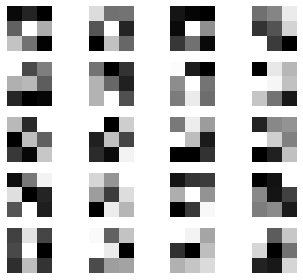

average of absolute gradients 1 tensor(2.3710e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0682e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0242e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0655e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2126e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3562e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5056e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6936e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7309e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2160e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7838e-06, device='cuda:0')


 22%|████████████████▉                                                            | 220/1000 [18:23<1:06:30,  5.12s/it]

Epoch: 220
Accuracy of train set: 8%
Accuracy of test set: 5%

tensor([[[-0.1917, -0.1375, -0.2092],
         [-0.0191,  0.2857,  0.1260],
         [ 0.1695,  0.0129, -0.2045]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


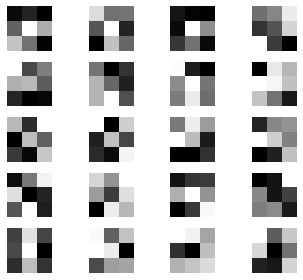

average of absolute gradients 1 tensor(1.9338e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9441e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1269e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1826e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3249e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5258e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5074e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3335e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5643e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6730e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3419e-06, device='cuda:0')


 22%|█████████████████                                                            | 221/1000 [18:28<1:06:19,  5.11s/it]

Epoch: 221
Accuracy of train set: 8%
Accuracy of test set: 5%

tensor([[[-0.1915, -0.1375, -0.2095],
         [-0.0190,  0.2853,  0.1260],
         [ 0.1688,  0.0125, -0.2048]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


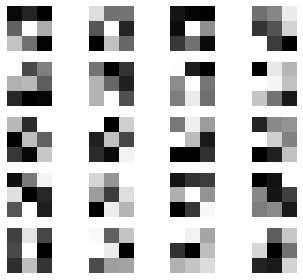

average of absolute gradients 1 tensor(1.9870e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8419e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4688e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1408e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2051e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5508e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4229e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1418e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8555e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2411e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9774e-06, device='cuda:0')


 22%|█████████████████                                                            | 222/1000 [18:33<1:06:57,  5.16s/it]

Epoch: 222
Accuracy of train set: 8%
Accuracy of test set: 6%

tensor([[[-0.1914, -0.1373, -0.2093],
         [-0.0187,  0.2848,  0.1265],
         [ 0.1693,  0.0120, -0.2049]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


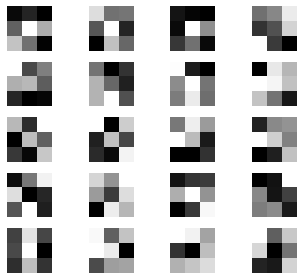

average of absolute gradients 1 tensor(2.3760e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7081e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0166e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9295e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1441e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7791e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0326e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8925e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0674e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5141e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8862e-06, device='cuda:0')


 22%|█████████████████▏                                                           | 223/1000 [18:39<1:06:37,  5.14s/it]

Epoch: 223
Accuracy of train set: 8%
Accuracy of test set: 5%

tensor([[[-0.1917, -0.1376, -0.2089],
         [-0.0181,  0.2843,  0.1261],
         [ 0.1695,  0.0121, -0.2050]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


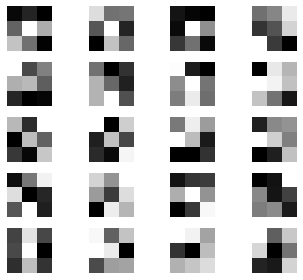

average of absolute gradients 1 tensor(2.1253e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3545e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2287e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6354e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8772e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3509e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0090e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3038e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3194e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4476e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3567e-06, device='cuda:0')


 22%|█████████████████▏                                                           | 224/1000 [18:44<1:06:10,  5.12s/it]

Epoch: 224
Accuracy of train set: 8%
Accuracy of test set: 5%

tensor([[[-0.1919, -0.1382, -0.2093],
         [-0.0176,  0.2835,  0.1264],
         [ 0.1684,  0.0118, -0.2053]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


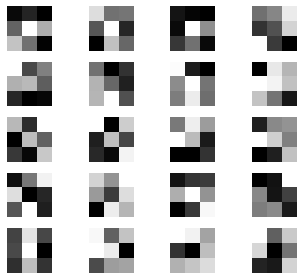

average of absolute gradients 1 tensor(2.6009e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9416e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2565e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5187e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7783e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2921e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4078e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4936e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9404e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7073e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5127e-06, device='cuda:0')


 22%|█████████████████▎                                                           | 225/1000 [18:49<1:05:52,  5.10s/it]

Epoch: 225
Accuracy of train set: 8%
Accuracy of test set: 5%

tensor([[[-0.1917, -0.1378, -0.2090],
         [-0.0174,  0.2837,  0.1268],
         [ 0.1682,  0.0118, -0.2053]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


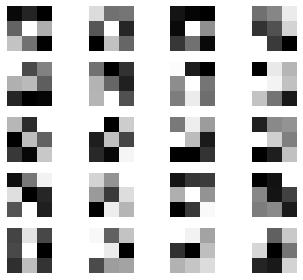

average of absolute gradients 1 tensor(2.1055e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5859e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8398e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4950e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3037e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0783e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3397e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6576e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1787e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3717e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8599e-06, device='cuda:0')


 23%|█████████████████▍                                                           | 226/1000 [18:54<1:05:42,  5.09s/it]

Epoch: 226
Accuracy of train set: 8%
Accuracy of test set: 5%

tensor([[[-0.1915, -0.1379, -0.2093],
         [-0.0166,  0.2833,  0.1270],
         [ 0.1673,  0.0114, -0.2058]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


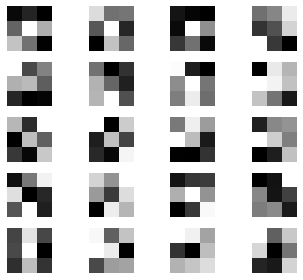

average of absolute gradients 1 tensor(2.9063e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6505e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9691e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1647e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6168e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0488e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6031e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2876e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3608e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0773e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5576e-06, device='cuda:0')


 23%|█████████████████▍                                                           | 227/1000 [18:59<1:05:21,  5.07s/it]

Epoch: 227
Accuracy of train set: 9%
Accuracy of test set: 5%

tensor([[[-0.1912, -0.1380, -0.2098],
         [-0.0171,  0.2823,  0.1266],
         [ 0.1679,  0.0108, -0.2060]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


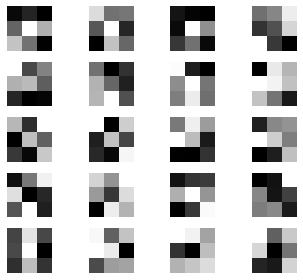

average of absolute gradients 1 tensor(2.2646e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5952e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0438e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1187e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1596e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5999e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9049e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8094e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1366e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5374e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2441e-06, device='cuda:0')


 23%|█████████████████▌                                                           | 228/1000 [19:04<1:04:51,  5.04s/it]

Epoch: 228
Accuracy of train set: 9%
Accuracy of test set: 6%

tensor([[[-0.1910, -0.1380, -0.2102],
         [-0.0168,  0.2820,  0.1267],
         [ 0.1671,  0.0106, -0.2064]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


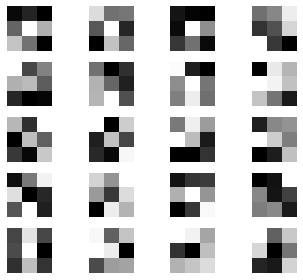

average of absolute gradients 1 tensor(2.9532e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9846e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0621e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7253e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0778e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5693e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2749e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1887e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3941e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6183e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9654e-06, device='cuda:0')


 23%|█████████████████▋                                                           | 229/1000 [19:09<1:04:30,  5.02s/it]

Epoch: 229
Accuracy of train set: 9%
Accuracy of test set: 5%

tensor([[[-0.1904, -0.1375, -0.2099],
         [-0.0161,  0.2823,  0.1267],
         [ 0.1670,  0.0101, -0.2067]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


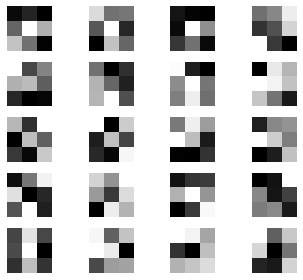

average of absolute gradients 1 tensor(2.3804e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6089e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1362e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9383e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3943e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8827e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7532e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0264e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0823e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5787e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0910e-06, device='cuda:0')


 23%|█████████████████▋                                                           | 230/1000 [19:14<1:04:03,  4.99s/it]

Epoch: 230
Accuracy of train set: 9%
Accuracy of test set: 5%

tensor([[[-0.1905, -0.1375, -0.2105],
         [-0.0173,  0.2812,  0.1266],
         [ 0.1669,  0.0098, -0.2070]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


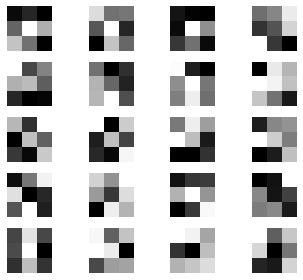

average of absolute gradients 1 tensor(3.4064e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6484e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1395e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4269e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7658e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7034e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8813e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3198e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7122e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5080e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1831e-06, device='cuda:0')


 23%|█████████████████▊                                                           | 231/1000 [19:19<1:03:50,  4.98s/it]

Epoch: 231
Accuracy of train set: 9%
Accuracy of test set: 6%

tensor([[[-0.1903, -0.1368, -0.2107],
         [-0.0183,  0.2803,  0.1275],
         [ 0.1673,  0.0087, -0.2073]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


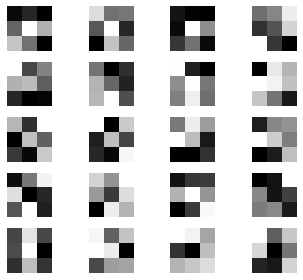

average of absolute gradients 1 tensor(3.0362e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3170e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7418e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9326e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4094e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7649e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7947e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6776e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5428e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1949e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0567e-06, device='cuda:0')


 23%|█████████████████▊                                                           | 232/1000 [19:24<1:03:57,  5.00s/it]

Epoch: 232
Accuracy of train set: 9%
Accuracy of test set: 5%

tensor([[[-0.1891, -0.1356, -0.2105],
         [-0.0178,  0.2819,  0.1289],
         [ 0.1660,  0.0079, -0.2070]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


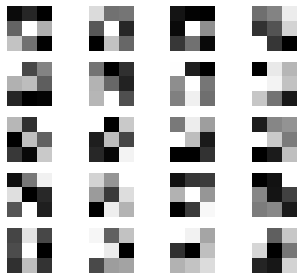

average of absolute gradients 1 tensor(3.1357e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9226e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4899e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9803e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5772e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2789e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5534e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5358e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3851e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0335e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8450e-06, device='cuda:0')


 23%|█████████████████▉                                                           | 233/1000 [19:29<1:03:38,  4.98s/it]

Epoch: 233
Accuracy of train set: 9%
Accuracy of test set: 6%

tensor([[[-0.1899, -0.1357, -0.2111],
         [-0.0188,  0.2810,  0.1287],
         [ 0.1645,  0.0069, -0.2075]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


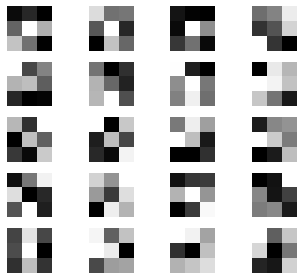

average of absolute gradients 1 tensor(3.2262e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4230e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0302e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5819e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7864e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1596e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4190e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9128e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7998e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6618e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5481e-06, device='cuda:0')


 23%|██████████████████                                                           | 234/1000 [19:34<1:04:14,  5.03s/it]

Epoch: 234
Accuracy of train set: 9%
Accuracy of test set: 6%

tensor([[[-0.1892, -0.1355, -0.2108],
         [-0.0189,  0.2805,  0.1290],
         [ 0.1661,  0.0066, -0.2074]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


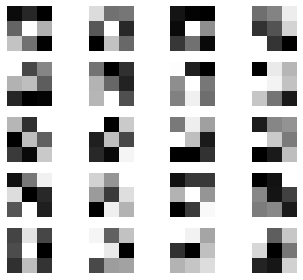

average of absolute gradients 1 tensor(3.0085e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9385e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0135e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9431e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1824e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9740e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0001e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5713e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9183e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5030e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3439e-06, device='cuda:0')


 24%|██████████████████                                                           | 235/1000 [19:39<1:04:03,  5.02s/it]

Epoch: 235
Accuracy of train set: 9%
Accuracy of test set: 6%

tensor([[[-0.1900, -0.1356, -0.2113],
         [-0.0199,  0.2789,  0.1282],
         [ 0.1661,  0.0049, -0.2082]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


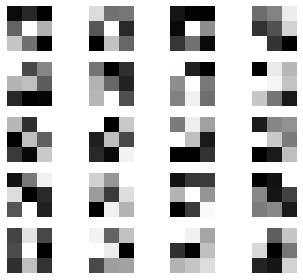

average of absolute gradients 1 tensor(2.6697e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0569e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8293e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1642e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9700e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1040e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6082e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1636e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3608e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4958e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8926e-06, device='cuda:0')


 24%|██████████████████▏                                                          | 236/1000 [19:44<1:03:54,  5.02s/it]

Epoch: 236
Accuracy of train set: 9%
Accuracy of test set: 6%

tensor([[[-0.1892, -0.1354, -0.2113],
         [-0.0195,  0.2790,  0.1288],
         [ 0.1658,  0.0049, -0.2082]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


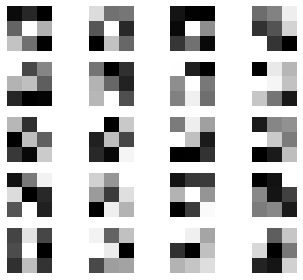

average of absolute gradients 1 tensor(3.1445e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0122e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1619e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3547e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1549e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4940e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6162e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9112e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2244e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2542e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5353e-06, device='cuda:0')


 24%|██████████████████▏                                                          | 237/1000 [19:49<1:03:33,  5.00s/it]

Epoch: 237
Accuracy of train set: 10%
Accuracy of test set: 6%

tensor([[[-0.1899, -0.1356, -0.2120],
         [-0.0202,  0.2779,  0.1288],
         [ 0.1656,  0.0034, -0.2079]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


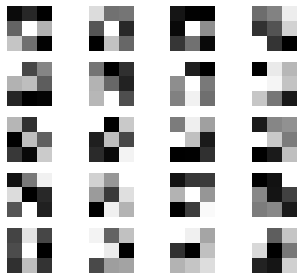

average of absolute gradients 1 tensor(3.2896e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1113e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8036e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3784e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0751e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2795e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2003e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2432e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7939e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7166e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9409e-06, device='cuda:0')


 24%|██████████████████▎                                                          | 238/1000 [19:54<1:03:27,  5.00s/it]

Epoch: 238
Accuracy of train set: 10%
Accuracy of test set: 6%

tensor([[[-0.1911, -0.1358, -0.2126],
         [-0.0209,  0.2765,  0.1289],
         [ 0.1642,  0.0017, -0.2083]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


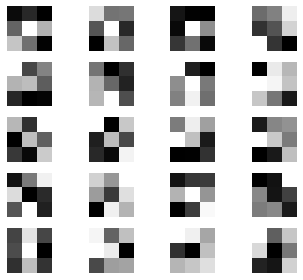

average of absolute gradients 1 tensor(3.8675e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7823e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1455e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4282e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5819e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9474e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3672e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4077e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4002e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8241e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3343e-06, device='cuda:0')


 24%|██████████████████▍                                                          | 239/1000 [19:59<1:03:28,  5.00s/it]

Epoch: 239
Accuracy of train set: 10%
Accuracy of test set: 6%

tensor([[[-0.1905, -0.1352, -0.2123],
         [-0.0209,  0.2775,  0.1287],
         [ 0.1647,  0.0011, -0.2076]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


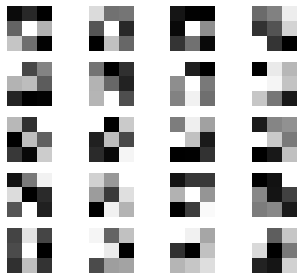

average of absolute gradients 1 tensor(3.2019e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7448e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9733e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9827e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4742e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9591e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7017e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9522e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8517e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1268e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0424e-06, device='cuda:0')


 24%|██████████████████▍                                                          | 240/1000 [20:04<1:03:18,  5.00s/it]

Epoch: 240
Accuracy of train set: 10%
Accuracy of test set: 6%

tensor([[[-0.1909, -0.1360, -0.2127],
         [-0.0211,  0.2759,  0.1286],
         [ 0.1644, -0.0006, -0.2082]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


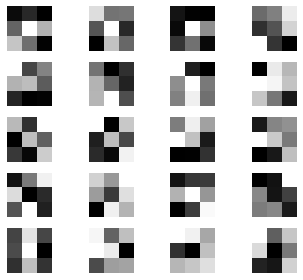

average of absolute gradients 1 tensor(4.2445e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5509e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4576e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7783e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8894e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7448e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4535e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1274e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7977e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3435e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6361e-06, device='cuda:0')


 24%|██████████████████▌                                                          | 241/1000 [20:09<1:03:10,  4.99s/it]

Epoch: 241
Accuracy of train set: 10%
Accuracy of test set: 6%

tensor([[[-0.1906, -0.1361, -0.2129],
         [-0.0208,  0.2758,  0.1296],
         [ 0.1636, -0.0008, -0.2078]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


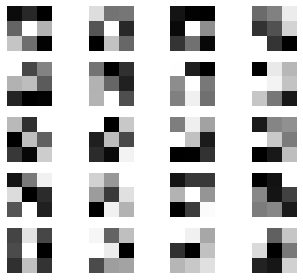

average of absolute gradients 1 tensor(2.4518e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3846e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5136e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6156e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6041e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0867e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8542e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9950e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6728e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3901e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9478e-06, device='cuda:0')


 24%|██████████████████▋                                                          | 242/1000 [20:14<1:03:06,  5.00s/it]

Epoch: 242
Accuracy of train set: 10%
Accuracy of test set: 6%

tensor([[[-0.1908, -0.1373, -0.2131],
         [-0.0207,  0.2750,  0.1303],
         [ 0.1625, -0.0024, -0.2076]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


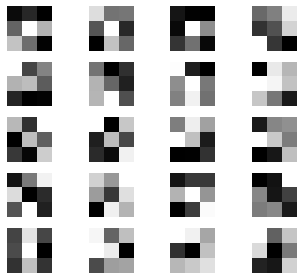

average of absolute gradients 1 tensor(4.1757e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8133e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6109e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9289e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2734e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3435e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5658e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7354e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4233e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5899e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1318e-06, device='cuda:0')


 24%|██████████████████▋                                                          | 243/1000 [20:19<1:03:07,  5.00s/it]

Epoch: 243
Accuracy of train set: 10%
Accuracy of test set: 6%

tensor([[[-0.1911, -0.1372, -0.2132],
         [-0.0214,  0.2740,  0.1301],
         [ 0.1636, -0.0013, -0.2075]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


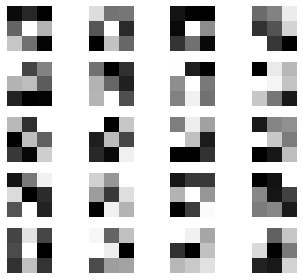

average of absolute gradients 1 tensor(3.7437e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5646e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3378e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3116e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6481e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4774e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8668e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4623e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8431e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7041e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7053e-06, device='cuda:0')


 24%|██████████████████▊                                                          | 244/1000 [20:24<1:03:40,  5.05s/it]

Epoch: 244
Accuracy of train set: 10%
Accuracy of test set: 6%

tensor([[[-0.1913, -0.1374, -0.2134],
         [-0.0218,  0.2736,  0.1303],
         [ 0.1630, -0.0022, -0.2073]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


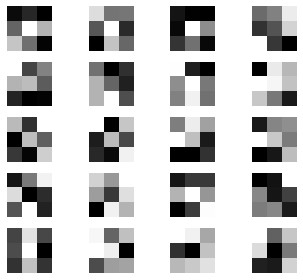

average of absolute gradients 1 tensor(4.3119e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7458e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1298e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1741e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6692e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7754e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8717e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6491e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0370e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9496e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3151e-06, device='cuda:0')


 24%|██████████████████▊                                                          | 245/1000 [20:29<1:03:23,  5.04s/it]

Epoch: 245
Accuracy of train set: 10%
Accuracy of test set: 6%

tensor([[[-0.1904, -0.1377, -0.2137],
         [-0.0227,  0.2728,  0.1311],
         [ 0.1627, -0.0015, -0.2076]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


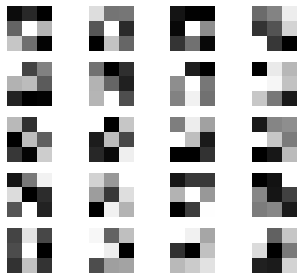

average of absolute gradients 1 tensor(3.5837e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0792e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1174e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5221e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3893e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0332e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2993e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9542e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2405e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8088e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2272e-06, device='cuda:0')


 25%|██████████████████▉                                                          | 246/1000 [20:34<1:03:21,  5.04s/it]

Epoch: 246
Accuracy of train set: 10%
Accuracy of test set: 6%

tensor([[[-0.1909, -0.1385, -0.2144],
         [-0.0230,  0.2715,  0.1293],
         [ 0.1625, -0.0026, -0.2083]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


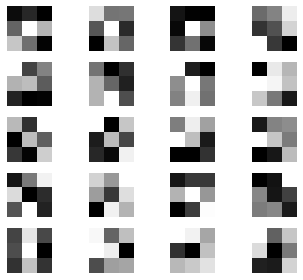

average of absolute gradients 1 tensor(3.0840e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0027e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1403e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6087e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2823e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9386e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9426e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2068e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9744e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2063e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0075e-06, device='cuda:0')


 25%|███████████████████                                                          | 247/1000 [20:39<1:03:12,  5.04s/it]

Epoch: 247
Accuracy of train set: 10%
Accuracy of test set: 6%

tensor([[[-0.1908, -0.1382, -0.2138],
         [-0.0231,  0.2722,  0.1287],
         [ 0.1634, -0.0022, -0.2076]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


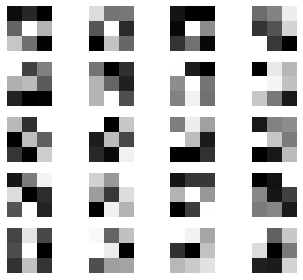

average of absolute gradients 1 tensor(3.7871e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4751e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3161e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2548e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5429e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4001e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8680e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2530e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4191e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6940e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2126e-06, device='cuda:0')


 25%|███████████████████                                                          | 248/1000 [20:44<1:02:56,  5.02s/it]

Epoch: 248
Accuracy of train set: 10%
Accuracy of test set: 6%

tensor([[[-0.1910, -0.1388, -0.2140],
         [-0.0223,  0.2719,  0.1283],
         [ 0.1633, -0.0036, -0.2071]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


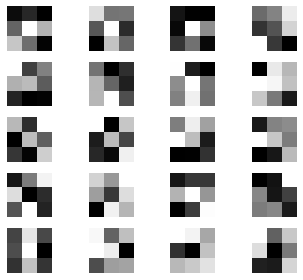

average of absolute gradients 1 tensor(3.1484e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8441e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4498e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0243e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7955e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9588e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3811e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1787e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3768e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0594e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3845e-06, device='cuda:0')


 25%|███████████████████▏                                                         | 249/1000 [20:49<1:02:48,  5.02s/it]

Epoch: 249
Accuracy of train set: 10%
Accuracy of test set: 6%

tensor([[[-0.1914, -0.1397, -0.2148],
         [-0.0210,  0.2721,  0.1273],
         [ 0.1609, -0.0042, -0.2072]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


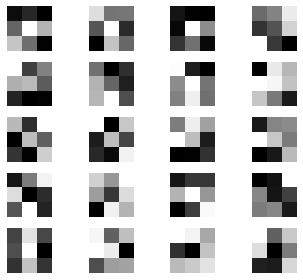

average of absolute gradients 1 tensor(4.7001e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6713e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0825e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3017e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7511e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4915e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1340e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2292e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7340e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8111e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1062e-06, device='cuda:0')


 25%|███████████████████▎                                                         | 250/1000 [20:54<1:02:42,  5.02s/it]

Epoch: 250
Accuracy of train set: 10%
Accuracy of test set: 6%

tensor([[[-0.1905, -0.1399, -0.2134],
         [-0.0204,  0.2725,  0.1281],
         [ 0.1622, -0.0044, -0.2068]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


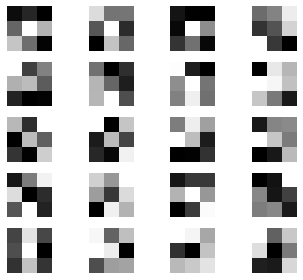

average of absolute gradients 1 tensor(3.3238e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9577e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0660e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3239e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0512e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7675e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1779e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6970e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3226e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8299e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9535e-06, device='cuda:0')


 25%|███████████████████▎                                                         | 251/1000 [20:59<1:02:42,  5.02s/it]

Epoch: 251
Accuracy of train set: 10%
Accuracy of test set: 6%

tensor([[[-0.1902, -0.1405, -0.2134],
         [-0.0203,  0.2719,  0.1276],
         [ 0.1625, -0.0053, -0.2071]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


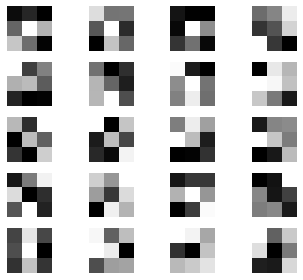

average of absolute gradients 1 tensor(2.5036e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0441e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6385e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4466e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0236e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4629e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1906e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4027e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0888e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9132e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4954e-06, device='cuda:0')


 25%|███████████████████▍                                                         | 252/1000 [21:04<1:02:34,  5.02s/it]

Epoch: 252
Accuracy of train set: 10%
Accuracy of test set: 6%

tensor([[[-0.1896, -0.1413, -0.2134],
         [-0.0197,  0.2720,  0.1272],
         [ 0.1624, -0.0050, -0.2067]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


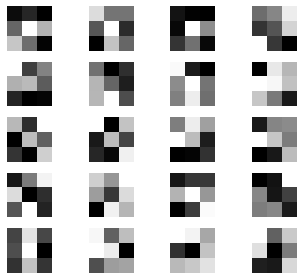

average of absolute gradients 1 tensor(3.4666e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9741e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5048e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3636e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7293e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7741e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8337e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2412e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5741e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5750e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1051e-06, device='cuda:0')


 25%|███████████████████▍                                                         | 253/1000 [21:09<1:02:27,  5.02s/it]

Epoch: 253
Accuracy of train set: 10%
Accuracy of test set: 6%

tensor([[[-0.1897, -0.1418, -0.2139],
         [-0.0189,  0.2718,  0.1263],
         [ 0.1620, -0.0050, -0.2066]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


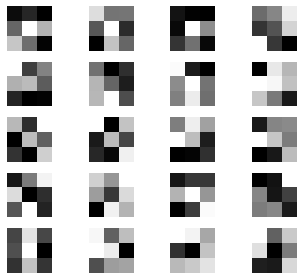

average of absolute gradients 1 tensor(2.7787e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7890e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5605e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7605e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0009e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0558e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4756e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5959e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5424e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0650e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.1820e-06, device='cuda:0')


 25%|███████████████████▌                                                         | 254/1000 [21:14<1:02:23,  5.02s/it]

Epoch: 254
Accuracy of train set: 10%
Accuracy of test set: 6%

tensor([[[-0.1891, -0.1417, -0.2135],
         [-0.0185,  0.2716,  0.1268],
         [ 0.1624, -0.0056, -0.2068]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


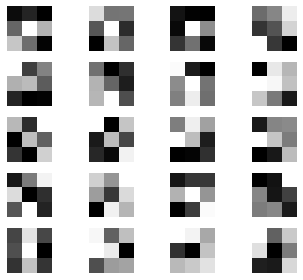

average of absolute gradients 1 tensor(2.6892e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1072e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9078e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6417e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1289e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7120e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0717e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0066e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8986e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4366e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3325e-06, device='cuda:0')


 26%|███████████████████▋                                                         | 255/1000 [21:19<1:02:17,  5.02s/it]

Epoch: 255
Accuracy of train set: 10%
Accuracy of test set: 6%

tensor([[[-0.1889, -0.1418, -0.2137],
         [-0.0184,  0.2708,  0.1275],
         [ 0.1624, -0.0064, -0.2069]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


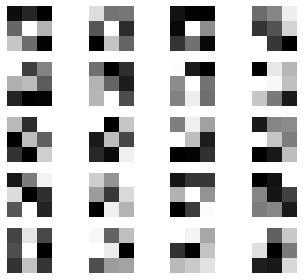

average of absolute gradients 1 tensor(3.8282e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2055e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9508e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8734e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7759e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4281e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6933e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8702e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2597e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6187e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1240e-06, device='cuda:0')


 26%|███████████████████▋                                                         | 256/1000 [21:24<1:02:18,  5.03s/it]

Epoch: 256
Accuracy of train set: 10%
Accuracy of test set: 6%

tensor([[[-0.1885, -0.1414, -0.2133],
         [-0.0179,  0.2704,  0.1273],
         [ 0.1641, -0.0057, -0.2068]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


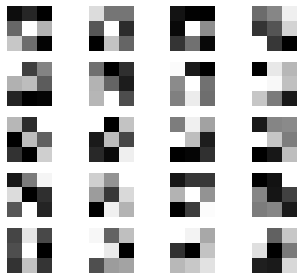

average of absolute gradients 1 tensor(2.8053e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9225e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2980e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8814e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3946e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0081e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1286e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9181e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5433e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2406e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0425e-06, device='cuda:0')


 26%|███████████████████▊                                                         | 257/1000 [21:29<1:02:11,  5.02s/it]

Epoch: 257
Accuracy of train set: 10%
Accuracy of test set: 7%

tensor([[[-0.1891, -0.1428, -0.2131],
         [-0.0181,  0.2689,  0.1279],
         [ 0.1640, -0.0071, -0.2065]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


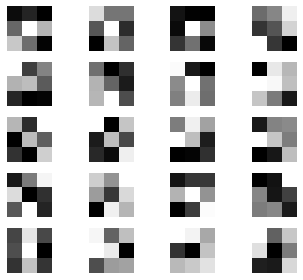

average of absolute gradients 1 tensor(3.5592e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0338e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7269e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3916e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4563e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9570e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4376e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5463e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7661e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9199e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9126e-06, device='cuda:0')


 26%|███████████████████▊                                                         | 258/1000 [21:34<1:02:04,  5.02s/it]

Epoch: 258
Accuracy of train set: 11%
Accuracy of test set: 6%

tensor([[[-0.1890, -0.1428, -0.2133],
         [-0.0183,  0.2678,  0.1288],
         [ 0.1648, -0.0082, -0.2061]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


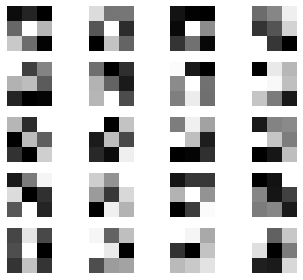

average of absolute gradients 1 tensor(3.4811e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0331e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9440e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4865e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3414e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7140e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8617e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6832e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0964e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5926e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4832e-06, device='cuda:0')


 26%|███████████████████▉                                                         | 259/1000 [21:39<1:01:44,  5.00s/it]

Epoch: 259
Accuracy of train set: 11%
Accuracy of test set: 6%

tensor([[[-0.1888, -0.1420, -0.2127],
         [-0.0181,  0.2682,  0.1292],
         [ 0.1653, -0.0082, -0.2058]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


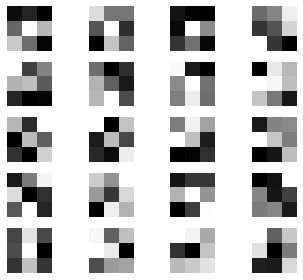

average of absolute gradients 1 tensor(3.6333e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3019e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2845e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0223e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1924e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8061e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5468e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8927e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3297e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9012e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9493e-06, device='cuda:0')


 26%|████████████████████                                                         | 260/1000 [21:44<1:01:28,  4.98s/it]

Epoch: 260
Accuracy of train set: 11%
Accuracy of test set: 6%

tensor([[[-0.1896, -0.1415, -0.2136],
         [-0.0190,  0.2673,  0.1284],
         [ 0.1647, -0.0083, -0.2062]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


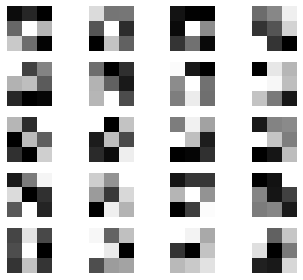

average of absolute gradients 1 tensor(3.5192e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5660e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7533e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7807e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3132e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4559e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2385e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1326e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8468e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6229e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6307e-06, device='cuda:0')


 26%|████████████████████                                                         | 261/1000 [21:49<1:01:15,  4.97s/it]

Epoch: 261
Accuracy of train set: 11%
Accuracy of test set: 6%

tensor([[[-0.1893, -0.1411, -0.2132],
         [-0.0186,  0.2679,  0.1295],
         [ 0.1639, -0.0093, -0.2058]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


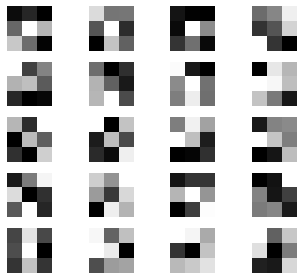

average of absolute gradients 1 tensor(3.0643e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6559e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7013e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7336e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6792e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6745e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8880e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0808e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0769e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7807e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8850e-06, device='cuda:0')


 26%|████████████████████▏                                                        | 262/1000 [21:54<1:01:25,  4.99s/it]

Epoch: 262
Accuracy of train set: 11%
Accuracy of test set: 6%

tensor([[[-0.1899, -0.1402, -0.2136],
         [-0.0188,  0.2677,  0.1288],
         [ 0.1639, -0.0092, -0.2056]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


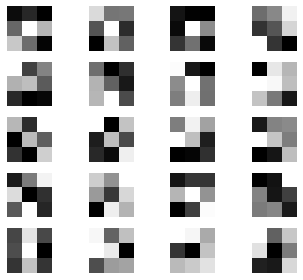

average of absolute gradients 1 tensor(2.7926e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5240e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7524e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1629e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9477e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7748e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0464e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1839e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1089e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8594e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2243e-06, device='cuda:0')


 26%|████████████████████▎                                                        | 263/1000 [21:59<1:01:16,  4.99s/it]

Epoch: 263
Accuracy of train set: 11%
Accuracy of test set: 6%

tensor([[[-0.1892, -0.1400, -0.2137],
         [-0.0192,  0.2676,  0.1296],
         [ 0.1644, -0.0099, -0.2051]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


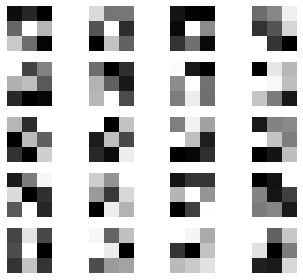

average of absolute gradients 1 tensor(3.6002e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5398e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2452e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8718e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0758e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9382e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8863e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9445e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7477e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5340e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8338e-06, device='cuda:0')


 26%|████████████████████▎                                                        | 264/1000 [22:04<1:01:11,  4.99s/it]

Epoch: 264
Accuracy of train set: 11%
Accuracy of test set: 6%

tensor([[[-0.1896, -0.1399, -0.2138],
         [-0.0196,  0.2677,  0.1294],
         [ 0.1630, -0.0115, -0.2050]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


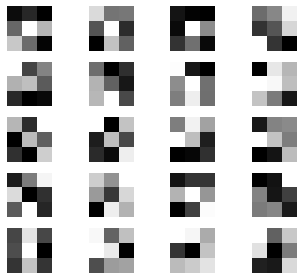

average of absolute gradients 1 tensor(2.9041e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9074e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8063e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3545e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0705e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1916e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0266e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1584e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4046e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6156e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0570e-06, device='cuda:0')


 26%|████████████████████▍                                                        | 265/1000 [22:09<1:01:16,  5.00s/it]

Epoch: 265
Accuracy of train set: 11%
Accuracy of test set: 6%

tensor([[[-0.1886, -0.1387, -0.2139],
         [-0.0200,  0.2686,  0.1302],
         [ 0.1629, -0.0119, -0.2045]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


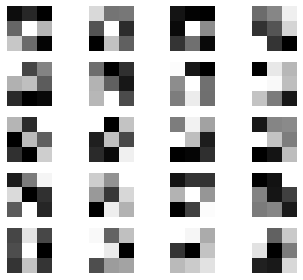

average of absolute gradients 1 tensor(2.7426e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7108e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5444e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2774e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4232e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1633e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1250e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2237e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3581e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8522e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5545e-06, device='cuda:0')


 27%|████████████████████▍                                                        | 266/1000 [22:14<1:01:09,  5.00s/it]

Epoch: 266
Accuracy of train set: 11%
Accuracy of test set: 7%

tensor([[[-0.1890, -0.1384, -0.2148],
         [-0.0206,  0.2674,  0.1289],
         [ 0.1636, -0.0124, -0.2047]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


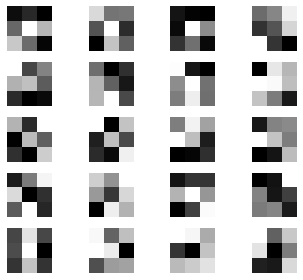

average of absolute gradients 1 tensor(3.0375e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1740e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9320e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6552e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1210e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8667e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6538e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8706e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6654e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5577e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6820e-06, device='cuda:0')


 27%|████████████████████▌                                                        | 267/1000 [22:19<1:01:06,  5.00s/it]

Epoch: 267
Accuracy of train set: 11%
Accuracy of test set: 6%

tensor([[[-0.1885, -0.1376, -0.2142],
         [-0.0200,  0.2678,  0.1294],
         [ 0.1645, -0.0129, -0.2044]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


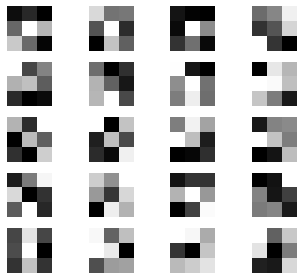

average of absolute gradients 1 tensor(3.6053e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7326e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3261e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0433e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6987e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5760e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3546e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1491e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3977e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4556e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9572e-06, device='cuda:0')


 27%|████████████████████▋                                                        | 268/1000 [22:24<1:01:15,  5.02s/it]

Epoch: 268
Accuracy of train set: 11%
Accuracy of test set: 7%

tensor([[[-0.1885, -0.1373, -0.2142],
         [-0.0206,  0.2675,  0.1288],
         [ 0.1648, -0.0133, -0.2044]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


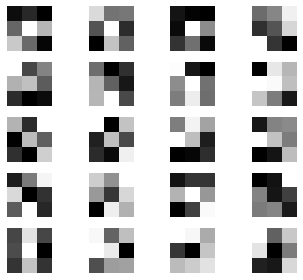

average of absolute gradients 1 tensor(2.9982e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8608e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1184e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7028e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2198e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1069e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0674e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8010e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9991e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0836e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5771e-06, device='cuda:0')


 27%|████████████████████▋                                                        | 269/1000 [22:29<1:01:10,  5.02s/it]

Epoch: 269
Accuracy of train set: 11%
Accuracy of test set: 6%

tensor([[[-0.1883, -0.1376, -0.2147],
         [-0.0212,  0.2668,  0.1283],
         [ 0.1647, -0.0145, -0.2045]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


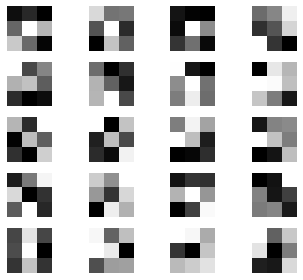

average of absolute gradients 1 tensor(4.2089e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1406e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4094e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3175e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4811e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6714e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3974e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6504e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6325e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8850e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0949e-06, device='cuda:0')


 27%|████████████████████▊                                                        | 270/1000 [22:34<1:01:05,  5.02s/it]

Epoch: 270
Accuracy of train set: 11%
Accuracy of test set: 7%

tensor([[[-0.1878, -0.1363, -0.2148],
         [-0.0216,  0.2674,  0.1280],
         [ 0.1655, -0.0145, -0.2040]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


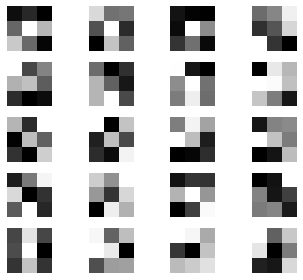

average of absolute gradients 1 tensor(4.4025e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1322e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5584e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2166e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3374e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2310e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4314e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1866e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0215e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0856e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5798e-06, device='cuda:0')


 27%|████████████████████▊                                                        | 271/1000 [22:39<1:00:50,  5.01s/it]

Epoch: 271
Accuracy of train set: 12%
Accuracy of test set: 7%

tensor([[[-0.1863, -0.1353, -0.2141],
         [-0.0216,  0.2683,  0.1287],
         [ 0.1667, -0.0136, -0.2038]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


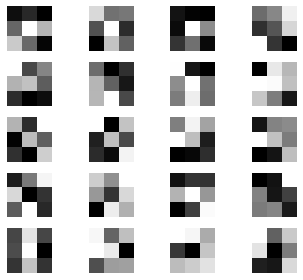

average of absolute gradients 1 tensor(2.8932e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1285e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1413e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2722e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5006e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0617e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7514e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7797e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1719e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8920e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2056e-06, device='cuda:0')


 27%|████████████████████▉                                                        | 272/1000 [22:44<1:00:41,  5.00s/it]

Epoch: 272
Accuracy of train set: 12%
Accuracy of test set: 7%

tensor([[[-0.1867, -0.1364, -0.2141],
         [-0.0219,  0.2667,  0.1281],
         [ 0.1684, -0.0143, -0.2034]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


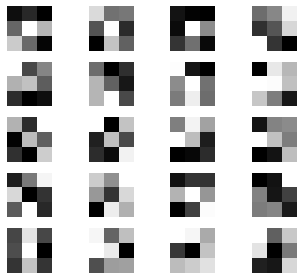

average of absolute gradients 1 tensor(4.1024e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5737e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1742e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0906e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0198e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2158e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7809e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2405e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8965e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4154e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7880e-06, device='cuda:0')


 27%|█████████████████████                                                        | 273/1000 [22:49<1:00:42,  5.01s/it]

Epoch: 273
Accuracy of train set: 12%
Accuracy of test set: 6%

tensor([[[-0.1860, -0.1366, -0.2136],
         [-0.0211,  0.2676,  0.1288],
         [ 0.1677, -0.0145, -0.2029]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


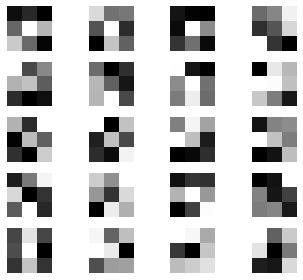

average of absolute gradients 1 tensor(5.9644e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5339e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0843e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5950e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6328e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5179e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5152e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5299e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7851e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4117e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1522e-06, device='cuda:0')


 27%|█████████████████████                                                        | 274/1000 [22:54<1:00:39,  5.01s/it]

Epoch: 274
Accuracy of train set: 12%
Accuracy of test set: 7%

tensor([[[-0.1873, -0.1385, -0.2143],
         [-0.0212,  0.2656,  0.1269],
         [ 0.1686, -0.0156, -0.2022]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


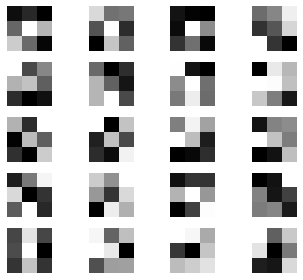

average of absolute gradients 1 tensor(3.7486e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3227e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6412e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2505e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3842e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9188e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1854e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2169e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5020e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8212e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3442e-06, device='cuda:0')


 28%|█████████████████████▏                                                       | 275/1000 [22:59<1:00:30,  5.01s/it]

Epoch: 275
Accuracy of train set: 12%
Accuracy of test set: 7%

tensor([[[-0.1862, -0.1374, -0.2133],
         [-0.0205,  0.2677,  0.1271],
         [ 0.1679, -0.0152, -0.2023]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


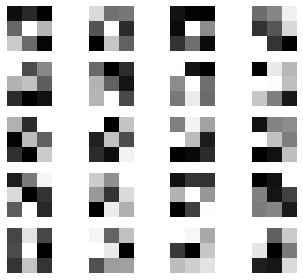

average of absolute gradients 1 tensor(4.1768e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7289e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9344e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6218e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6055e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7403e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4834e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4204e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2286e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9762e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1533e-06, device='cuda:0')


 28%|█████████████████████▎                                                       | 276/1000 [23:04<1:00:31,  5.02s/it]

Epoch: 276
Accuracy of train set: 12%
Accuracy of test set: 7%

tensor([[[-0.1864, -0.1376, -0.2131],
         [-0.0210,  0.2679,  0.1271],
         [ 0.1676, -0.0148, -0.2017]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


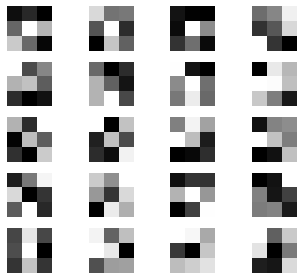

average of absolute gradients 1 tensor(3.7833e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3357e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3332e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7680e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9281e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9361e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4618e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9617e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4787e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4932e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8272e-06, device='cuda:0')


 28%|█████████████████████▎                                                       | 277/1000 [23:09<1:00:18,  5.01s/it]

Epoch: 277
Accuracy of train set: 12%
Accuracy of test set: 7%

tensor([[[-0.1849, -0.1372, -0.2119],
         [-0.0204,  0.2690,  0.1271],
         [ 0.1693, -0.0148, -0.2014]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


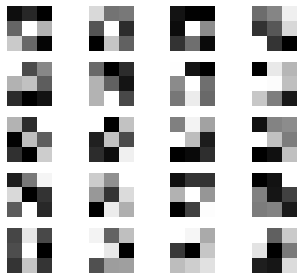

average of absolute gradients 1 tensor(3.1815e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6620e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1901e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4814e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6621e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0985e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9090e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3002e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3348e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9971e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2785e-06, device='cuda:0')


 28%|█████████████████████▉                                                         | 278/1000 [23:14<59:59,  4.99s/it]

Epoch: 278
Accuracy of train set: 12%
Accuracy of test set: 7%

tensor([[[-0.1848, -0.1382, -0.2120],
         [-0.0208,  0.2680,  0.1269],
         [ 0.1694, -0.0140, -0.2017]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


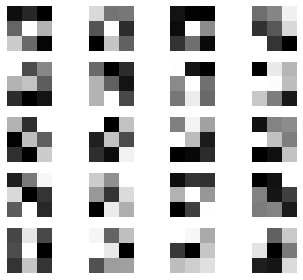

average of absolute gradients 1 tensor(3.4002e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6887e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8245e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0928e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4997e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6687e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8236e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6377e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8754e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4252e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0688e-06, device='cuda:0')


 28%|██████████████████████                                                         | 279/1000 [23:19<59:43,  4.97s/it]

Epoch: 279
Accuracy of train set: 12%
Accuracy of test set: 7%

tensor([[[-0.1843, -0.1377, -0.2123],
         [-0.0212,  0.2686,  0.1261],
         [ 0.1692, -0.0128, -0.2014]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


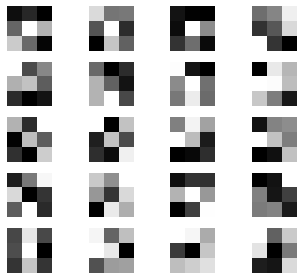

average of absolute gradients 1 tensor(3.9851e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2769e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4874e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9495e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2848e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4696e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5037e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9247e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9290e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4203e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6505e-06, device='cuda:0')


 28%|██████████████████████                                                         | 280/1000 [23:24<59:52,  4.99s/it]

Epoch: 280
Accuracy of train set: 12%
Accuracy of test set: 7%

tensor([[[-0.1838, -0.1366, -0.2119],
         [-0.0217,  0.2695,  0.1260],
         [ 0.1702, -0.0125, -0.2006]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


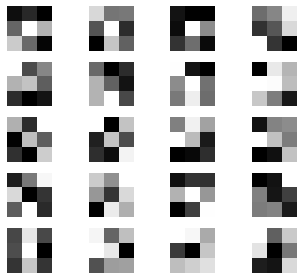

average of absolute gradients 1 tensor(4.2476e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3322e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4771e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2665e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9986e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4247e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9195e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3225e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7760e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7659e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3874e-06, device='cuda:0')


 28%|█████████████████████▋                                                       | 281/1000 [23:29<1:00:00,  5.01s/it]

Epoch: 281
Accuracy of train set: 12%
Accuracy of test set: 7%

tensor([[[-0.1835, -0.1371, -0.2121],
         [-0.0227,  0.2692,  0.1258],
         [ 0.1706, -0.0131, -0.2000]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


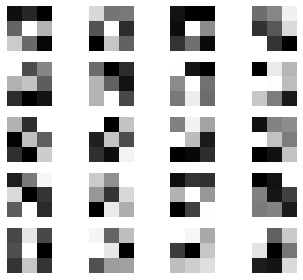

average of absolute gradients 1 tensor(2.9377e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1951e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0511e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0736e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1856e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1694e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6450e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2747e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9517e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0040e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0919e-06, device='cuda:0')


 28%|██████████████████████▎                                                        | 282/1000 [23:34<59:53,  5.00s/it]

Epoch: 282
Accuracy of train set: 12%
Accuracy of test set: 7%

tensor([[[-0.1834, -0.1371, -0.2128],
         [-0.0220,  0.2686,  0.1258],
         [ 0.1706, -0.0134, -0.1996]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


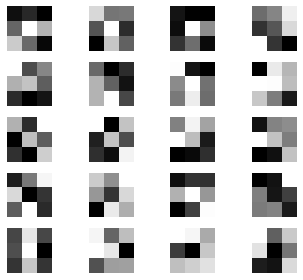

average of absolute gradients 1 tensor(4.0348e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4771e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7769e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9596e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0423e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9792e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4671e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3602e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5269e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5270e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2454e-06, device='cuda:0')


 28%|██████████████████████▎                                                        | 283/1000 [23:39<59:42,  5.00s/it]

Epoch: 283
Accuracy of train set: 12%
Accuracy of test set: 7%

tensor([[[-0.1828, -0.1371, -0.2128],
         [-0.0218,  0.2693,  0.1254],
         [ 0.1704, -0.0127, -0.1992]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


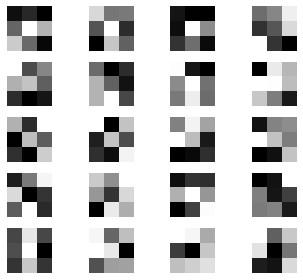

average of absolute gradients 1 tensor(3.9984e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6631e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8111e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5549e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7314e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5215e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7047e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0093e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6672e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3612e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2514e-06, device='cuda:0')


 28%|██████████████████████▍                                                        | 284/1000 [23:44<59:40,  5.00s/it]

Epoch: 284
Accuracy of train set: 12%
Accuracy of test set: 7%

tensor([[[-0.1821, -0.1373, -0.2128],
         [-0.0231,  0.2691,  0.1249],
         [ 0.1707, -0.0127, -0.1994]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


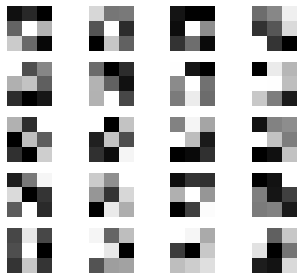

average of absolute gradients 1 tensor(4.0804e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6028e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2572e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0694e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1583e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1379e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3100e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1560e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8481e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5056e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6680e-06, device='cuda:0')


 28%|██████████████████████▌                                                        | 285/1000 [23:49<59:58,  5.03s/it]

Epoch: 285
Accuracy of train set: 12%
Accuracy of test set: 7%

tensor([[[-0.1825, -0.1379, -0.2126],
         [-0.0222,  0.2690,  0.1248],
         [ 0.1706, -0.0121, -0.1989]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


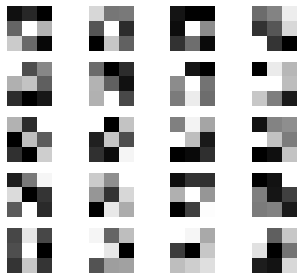

average of absolute gradients 1 tensor(3.5874e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3310e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2615e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4733e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2213e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4114e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9861e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2751e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0494e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5363e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1377e-06, device='cuda:0')


 29%|██████████████████████▌                                                        | 286/1000 [23:54<59:49,  5.03s/it]

Epoch: 286
Accuracy of train set: 12%
Accuracy of test set: 7%

tensor([[[-0.1826, -0.1375, -0.2117],
         [-0.0222,  0.2687,  0.1253],
         [ 0.1722, -0.0120, -0.1983]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


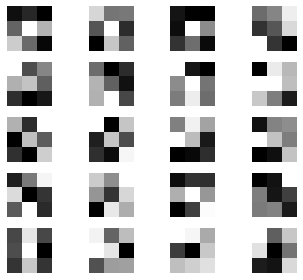

average of absolute gradients 1 tensor(4.4673e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4007e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7300e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0696e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2751e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1708e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2378e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2205e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7200e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3192e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0291e-06, device='cuda:0')


 29%|██████████████████████▋                                                        | 287/1000 [23:59<59:41,  5.02s/it]

Epoch: 287
Accuracy of train set: 12%
Accuracy of test set: 6%

tensor([[[-0.1835, -0.1386, -0.2118],
         [-0.0211,  0.2678,  0.1251],
         [ 0.1710, -0.0133, -0.1985]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


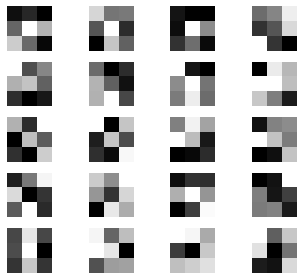

average of absolute gradients 1 tensor(3.6575e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6955e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1080e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5817e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8839e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7282e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4171e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4821e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5722e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1186e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0776e-06, device='cuda:0')


 29%|██████████████████████▊                                                        | 288/1000 [24:04<59:32,  5.02s/it]

Epoch: 288
Accuracy of train set: 12%
Accuracy of test set: 7%

tensor([[[-0.1831, -0.1379, -0.2109],
         [-0.0211,  0.2686,  0.1262],
         [ 0.1715, -0.0139, -0.1976]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


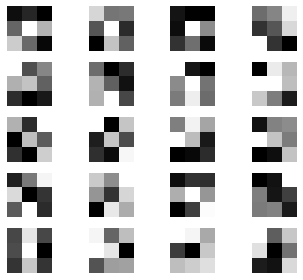

average of absolute gradients 1 tensor(3.1009e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8770e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4342e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5767e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2144e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0979e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9150e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0894e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2391e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1686e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1657e-06, device='cuda:0')


 29%|██████████████████████▊                                                        | 289/1000 [24:09<59:37,  5.03s/it]

Epoch: 289
Accuracy of train set: 12%
Accuracy of test set: 7%

tensor([[[-0.1836, -0.1386, -0.2116],
         [-0.0209,  0.2673,  0.1259],
         [ 0.1710, -0.0137, -0.1979]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


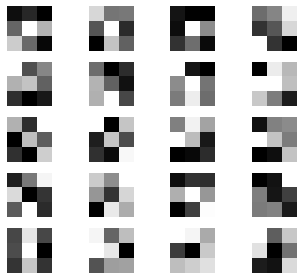

average of absolute gradients 1 tensor(4.1805e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0732e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8277e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5569e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9321e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3541e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7492e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1795e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8544e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2827e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0180e-06, device='cuda:0')


 29%|██████████████████████▉                                                        | 290/1000 [24:14<59:49,  5.06s/it]

Epoch: 290
Accuracy of train set: 13%
Accuracy of test set: 7%

tensor([[[-0.1836, -0.1384, -0.2115],
         [-0.0197,  0.2673,  0.1258],
         [ 0.1713, -0.0133, -0.1976]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


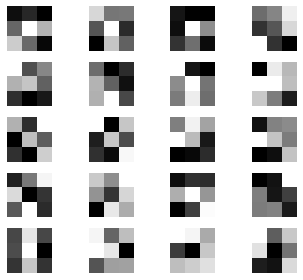

average of absolute gradients 1 tensor(3.6234e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8520e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7301e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0348e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1205e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1842e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5143e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5038e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9121e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6424e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2744e-06, device='cuda:0')


 29%|██████████████████████▉                                                        | 291/1000 [24:19<59:55,  5.07s/it]

Epoch: 291
Accuracy of train set: 13%
Accuracy of test set: 7%

tensor([[[-0.1832, -0.1381, -0.2103],
         [-0.0191,  0.2677,  0.1262],
         [ 0.1720, -0.0131, -0.1975]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


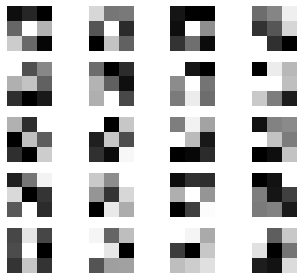

average of absolute gradients 1 tensor(4.3506e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4744e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0803e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4792e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9471e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2520e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1504e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7971e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1979e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2120e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3252e-06, device='cuda:0')


 29%|██████████████████████▍                                                      | 292/1000 [24:25<1:00:13,  5.10s/it]

Epoch: 292
Accuracy of train set: 13%
Accuracy of test set: 7%

tensor([[[-0.1842, -0.1386, -0.2106],
         [-0.0194,  0.2665,  0.1248],
         [ 0.1712, -0.0135, -0.1987]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


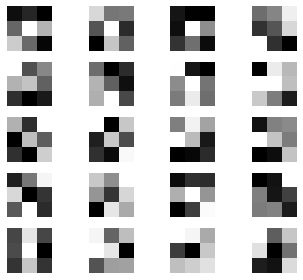

average of absolute gradients 1 tensor(4.5428e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1299e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8207e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5043e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2066e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7873e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1649e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2925e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5385e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7636e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0917e-06, device='cuda:0')


 29%|██████████████████████▌                                                      | 293/1000 [24:30<1:00:01,  5.09s/it]

Epoch: 293
Accuracy of train set: 13%
Accuracy of test set: 7%

tensor([[[-0.1841, -0.1383, -0.2094],
         [-0.0189,  0.2671,  0.1254],
         [ 0.1720, -0.0129, -0.1981]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


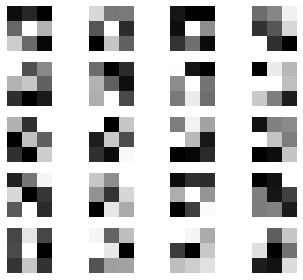

average of absolute gradients 1 tensor(3.2503e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4482e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5419e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1644e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8052e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7733e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4323e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4063e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3694e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9483e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5376e-06, device='cuda:0')


 29%|██████████████████████▋                                                      | 294/1000 [24:35<1:00:06,  5.11s/it]

Epoch: 294
Accuracy of train set: 13%
Accuracy of test set: 7%

tensor([[[-0.1843, -0.1378, -0.2089],
         [-0.0187,  0.2669,  0.1254],
         [ 0.1720, -0.0127, -0.1986]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


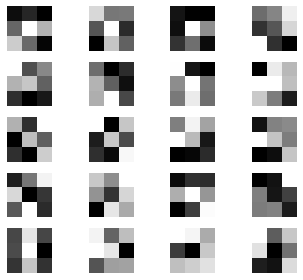

average of absolute gradients 1 tensor(4.2236e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5267e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1577e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9233e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3965e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3541e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9325e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3140e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1254e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4643e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8802e-06, device='cuda:0')


 30%|███████████████████████▎                                                       | 295/1000 [24:40<59:39,  5.08s/it]

Epoch: 295
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1844, -0.1369, -0.2090],
         [-0.0174,  0.2665,  0.1250],
         [ 0.1728, -0.0130, -0.1986]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


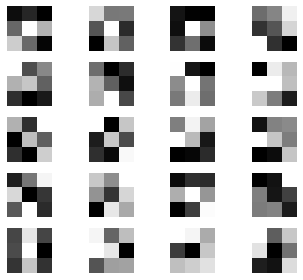

average of absolute gradients 1 tensor(2.6693e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1360e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2242e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3373e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6050e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9250e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1913e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8954e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5476e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3311e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3959e-06, device='cuda:0')


 30%|███████████████████████▍                                                       | 296/1000 [24:45<59:31,  5.07s/it]

Epoch: 296
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1848, -0.1366, -0.2086],
         [-0.0169,  0.2665,  0.1249],
         [ 0.1731, -0.0128, -0.1983]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


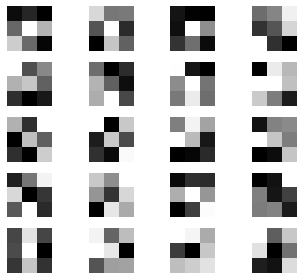

average of absolute gradients 1 tensor(2.9683e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8385e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0599e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8824e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9494e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1903e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5441e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0950e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0628e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5514e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6583e-06, device='cuda:0')


 30%|███████████████████████▍                                                       | 297/1000 [24:50<59:04,  5.04s/it]

Epoch: 297
Accuracy of train set: 13%
Accuracy of test set: 7%

tensor([[[-0.1855, -0.1370, -0.2092],
         [-0.0173,  0.2650,  0.1240],
         [ 0.1732, -0.0132, -0.1987]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


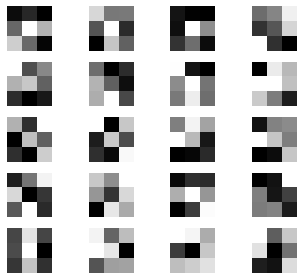

average of absolute gradients 1 tensor(3.1159e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4726e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1008e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3627e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5048e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4652e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8510e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4738e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5754e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9032e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3286e-06, device='cuda:0')


 30%|███████████████████████▌                                                       | 298/1000 [24:55<59:05,  5.05s/it]

Epoch: 298
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1859, -0.1368, -0.2088],
         [-0.0169,  0.2652,  0.1235],
         [ 0.1732, -0.0135, -0.1984]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


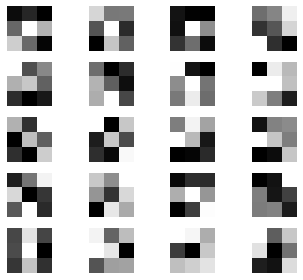

average of absolute gradients 1 tensor(3.7510e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0543e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4422e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2426e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5285e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3622e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2305e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9552e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8354e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2295e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3946e-06, device='cuda:0')


 30%|███████████████████████▌                                                       | 299/1000 [25:00<59:10,  5.07s/it]

Epoch: 299
Accuracy of train set: 13%
Accuracy of test set: 7%

tensor([[[-0.1870, -0.1361, -0.2092],
         [-0.0174,  0.2642,  0.1224],
         [ 0.1733, -0.0141, -0.1989]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


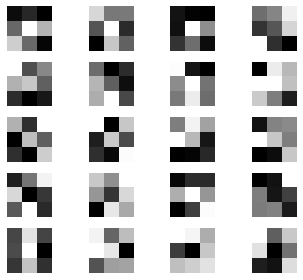

average of absolute gradients 1 tensor(3.1647e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0982e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9315e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8445e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8476e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1940e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2167e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8492e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3063e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9262e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5902e-06, device='cuda:0')


 30%|███████████████████████▋                                                       | 300/1000 [25:05<59:11,  5.07s/it]

Epoch: 300
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1868, -0.1356, -0.2083],
         [-0.0159,  0.2646,  0.1224],
         [ 0.1739, -0.0147, -0.1989]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


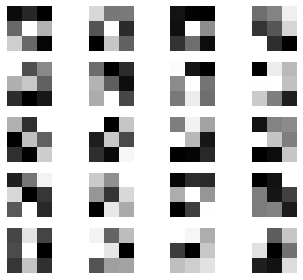

average of absolute gradients 1 tensor(3.8614e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0813e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7747e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1451e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5554e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1436e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4244e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0347e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1823e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3675e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.1331e-06, device='cuda:0')


 30%|███████████████████████▊                                                       | 301/1000 [25:10<58:55,  5.06s/it]

Epoch: 301
Accuracy of train set: 13%
Accuracy of test set: 6%

tensor([[[-0.1867, -0.1340, -0.2084],
         [-0.0157,  0.2651,  0.1223],
         [ 0.1740, -0.0145, -0.1989]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


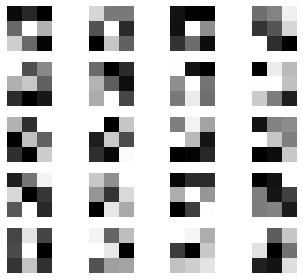

average of absolute gradients 1 tensor(5.1170e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7266e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0612e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5943e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6000e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8812e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4841e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0027e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5076e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6319e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1732e-06, device='cuda:0')


 30%|███████████████████████▊                                                       | 302/1000 [25:15<58:37,  5.04s/it]

Epoch: 302
Accuracy of train set: 13%
Accuracy of test set: 7%

tensor([[[-0.1882, -0.1358, -0.2084],
         [-0.0155,  0.2635,  0.1225],
         [ 0.1723, -0.0162, -0.1991]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


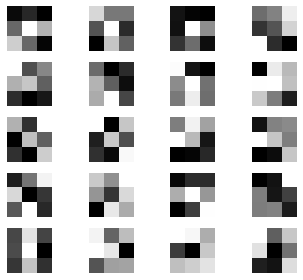

average of absolute gradients 1 tensor(2.5507e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6184e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0624e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9444e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5618e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3698e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0845e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1435e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3455e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9745e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4142e-06, device='cuda:0')


 30%|███████████████████████▉                                                       | 303/1000 [25:20<58:19,  5.02s/it]

Epoch: 303
Accuracy of train set: 13%
Accuracy of test set: 7%

tensor([[[-0.1881, -0.1337, -0.2086],
         [-0.0153,  0.2635,  0.1225],
         [ 0.1728, -0.0157, -0.1996]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


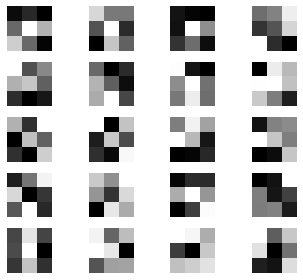

average of absolute gradients 1 tensor(3.8899e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2250e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8262e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5956e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1695e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1520e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6190e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8155e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8483e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0117e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2103e-06, device='cuda:0')


 30%|████████████████████████                                                       | 304/1000 [25:25<58:07,  5.01s/it]

Epoch: 304
Accuracy of train set: 13%
Accuracy of test set: 7%

tensor([[[-0.1885, -0.1336, -0.2090],
         [-0.0147,  0.2620,  0.1222],
         [ 0.1738, -0.0155, -0.1998]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


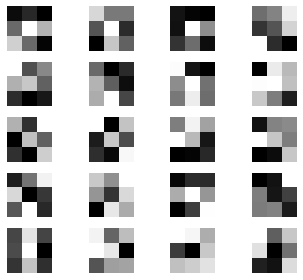

average of absolute gradients 1 tensor(3.3068e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0262e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3670e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4871e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0312e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3979e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0008e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6576e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1688e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0195e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8834e-06, device='cuda:0')


 30%|████████████████████████                                                       | 305/1000 [25:30<57:59,  5.01s/it]

Epoch: 305
Accuracy of train set: 13%
Accuracy of test set: 7%

tensor([[[-0.1889, -0.1331, -0.2087],
         [-0.0143,  0.2618,  0.1225],
         [ 0.1734, -0.0152, -0.2000]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


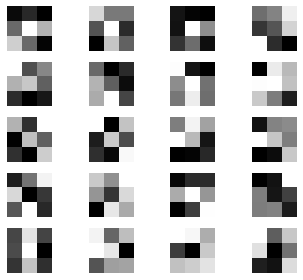

average of absolute gradients 1 tensor(2.7648e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1532e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5872e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5435e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3750e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5043e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8965e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2776e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9761e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4045e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2227e-06, device='cuda:0')


 31%|████████████████████████▏                                                      | 306/1000 [25:35<57:48,  5.00s/it]

Epoch: 306
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1896, -0.1331, -0.2085],
         [-0.0148,  0.2609,  0.1217],
         [ 0.1739, -0.0149, -0.2005]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


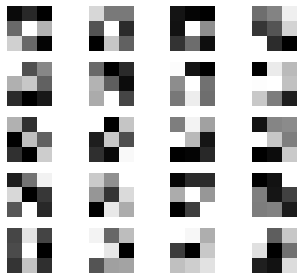

average of absolute gradients 1 tensor(2.7321e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3032e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4451e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6781e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5506e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4448e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9697e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0048e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2974e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8913e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4513e-06, device='cuda:0')


 31%|████████████████████████▎                                                      | 307/1000 [25:40<57:39,  4.99s/it]

Epoch: 307
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1905, -0.1335, -0.2082],
         [-0.0142,  0.2603,  0.1213],
         [ 0.1732, -0.0149, -0.2008]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


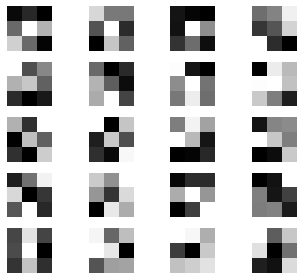

average of absolute gradients 1 tensor(3.5605e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5577e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0276e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3724e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8697e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8051e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7401e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6004e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8277e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0164e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3799e-06, device='cuda:0')


 31%|████████████████████████▎                                                      | 308/1000 [25:45<57:34,  4.99s/it]

Epoch: 308
Accuracy of train set: 13%
Accuracy of test set: 7%

tensor([[[-0.1902, -0.1329, -0.2069],
         [-0.0131,  0.2606,  0.1213],
         [ 0.1744, -0.0139, -0.2011]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


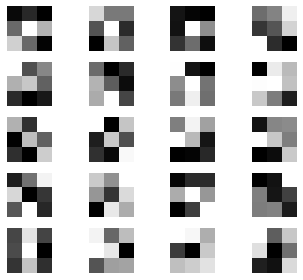

average of absolute gradients 1 tensor(3.1413e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1869e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3211e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5939e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6875e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7866e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9769e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0168e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3066e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4366e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4213e-06, device='cuda:0')


 31%|████████████████████████▍                                                      | 309/1000 [25:50<57:27,  4.99s/it]

Epoch: 309
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1911, -0.1341, -0.2072],
         [-0.0132,  0.2594,  0.1200],
         [ 0.1740, -0.0134, -0.2014]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


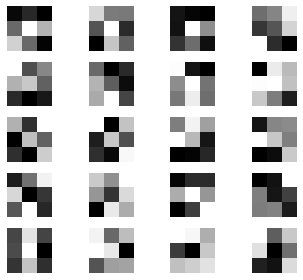

average of absolute gradients 1 tensor(3.2015e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7364e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0310e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7683e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9989e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5165e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7810e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8448e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9103e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0268e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5765e-06, device='cuda:0')


 31%|████████████████████████▍                                                      | 310/1000 [25:55<57:11,  4.97s/it]

Epoch: 310
Accuracy of train set: 13%
Accuracy of test set: 7%

tensor([[[-0.1911, -0.1334, -0.2069],
         [-0.0136,  0.2594,  0.1201],
         [ 0.1742, -0.0143, -0.2015]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


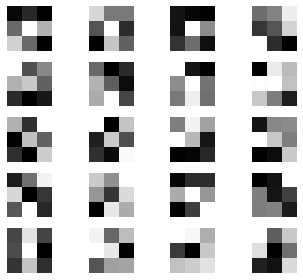

average of absolute gradients 1 tensor(3.5250e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8210e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8242e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4640e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4436e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9863e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8632e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4906e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0272e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7467e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4734e-06, device='cuda:0')


 31%|████████████████████████▌                                                      | 311/1000 [26:00<57:06,  4.97s/it]

Epoch: 311
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1915, -0.1338, -0.2068],
         [-0.0126,  0.2587,  0.1201],
         [ 0.1738, -0.0141, -0.2018]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


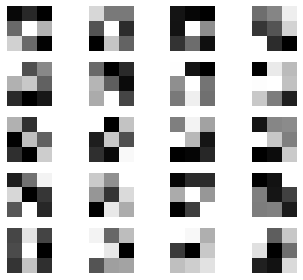

average of absolute gradients 1 tensor(2.3105e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4391e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5298e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0505e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7624e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6410e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4597e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6357e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0587e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4781e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4740e-06, device='cuda:0')


 31%|████████████████████████▋                                                      | 312/1000 [26:05<57:00,  4.97s/it]

Epoch: 312
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1913, -0.1336, -0.2064],
         [-0.0118,  0.2585,  0.1201],
         [ 0.1747, -0.0141, -0.2016]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


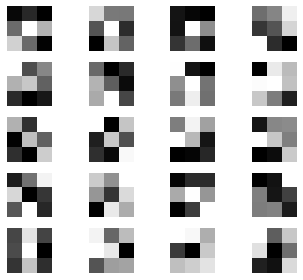

average of absolute gradients 1 tensor(2.9468e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3671e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8414e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9530e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0542e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8499e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7383e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2615e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3836e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5994e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3420e-06, device='cuda:0')


 31%|████████████████████████▋                                                      | 313/1000 [26:10<56:59,  4.98s/it]

Epoch: 313
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1919, -0.1337, -0.2070],
         [-0.0112,  0.2578,  0.1197],
         [ 0.1735, -0.0153, -0.2019]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


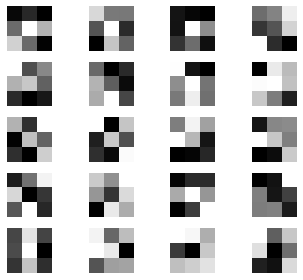

average of absolute gradients 1 tensor(3.0751e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1078e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4456e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8844e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6615e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5929e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4316e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9104e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7653e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8041e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8964e-06, device='cuda:0')


 31%|████████████████████████▊                                                      | 314/1000 [26:15<56:50,  4.97s/it]

Epoch: 314
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1916, -0.1347, -0.2067],
         [-0.0105,  0.2574,  0.1205],
         [ 0.1729, -0.0153, -0.2021]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


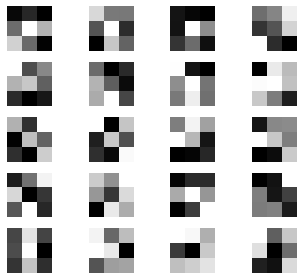

average of absolute gradients 1 tensor(2.5439e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5239e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4634e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4349e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8976e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0700e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4624e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5576e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5624e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3972e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7615e-06, device='cuda:0')


 32%|████████████████████████▉                                                      | 315/1000 [26:20<56:56,  4.99s/it]

Epoch: 315
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1915, -0.1343, -0.2070],
         [-0.0102,  0.2568,  0.1200],
         [ 0.1732, -0.0148, -0.2025]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


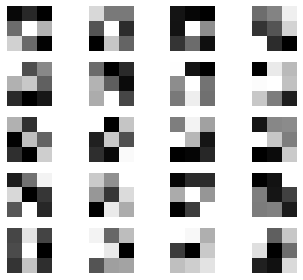

average of absolute gradients 1 tensor(3.4022e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6825e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4250e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9523e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8778e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4001e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3825e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5393e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5189e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3048e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3294e-06, device='cuda:0')


 32%|████████████████████████▉                                                      | 316/1000 [26:25<57:13,  5.02s/it]

Epoch: 316
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1916, -0.1347, -0.2077],
         [-0.0095,  0.2561,  0.1202],
         [ 0.1720, -0.0165, -0.2027]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


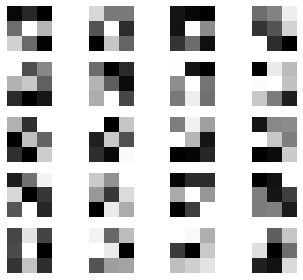

average of absolute gradients 1 tensor(3.2635e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5451e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8303e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2967e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1243e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2047e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9641e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1763e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7298e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1020e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2707e-06, device='cuda:0')


 32%|█████████████████████████                                                      | 317/1000 [26:30<57:09,  5.02s/it]

Epoch: 317
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1915, -0.1348, -0.2075],
         [-0.0091,  0.2564,  0.1199],
         [ 0.1718, -0.0164, -0.2025]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


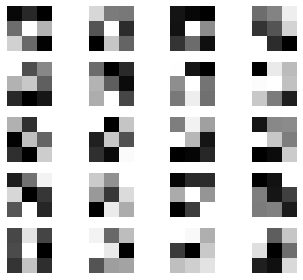

average of absolute gradients 1 tensor(2.7173e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2568e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4501e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8267e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2205e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4597e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3744e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5992e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4310e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0707e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9694e-06, device='cuda:0')


 32%|█████████████████████████                                                      | 318/1000 [26:35<57:15,  5.04s/it]

Epoch: 318
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1918, -0.1343, -0.2082],
         [-0.0085,  0.2558,  0.1197],
         [ 0.1715, -0.0161, -0.2025]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


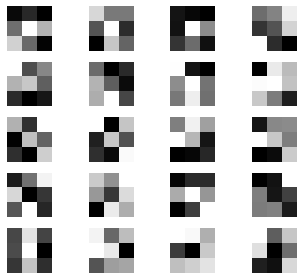

average of absolute gradients 1 tensor(2.9664e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7005e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8761e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1277e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0753e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4298e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7845e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5197e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5433e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0641e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3656e-06, device='cuda:0')


 32%|█████████████████████████▏                                                     | 319/1000 [26:40<57:21,  5.05s/it]

Epoch: 319
Accuracy of train set: 13%
Accuracy of test set: 7%

tensor([[[-0.1918, -0.1348, -0.2092],
         [-0.0078,  0.2543,  0.1203],
         [ 0.1713, -0.0174, -0.2024]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


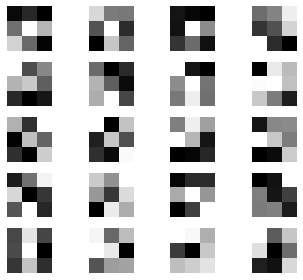

average of absolute gradients 1 tensor(3.3115e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7529e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2025e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7039e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5319e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0480e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2131e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5532e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3903e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1979e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3862e-06, device='cuda:0')


 32%|█████████████████████████▎                                                     | 320/1000 [26:45<57:14,  5.05s/it]

Epoch: 320
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1921, -0.1335, -0.2091],
         [-0.0076,  0.2552,  0.1199],
         [ 0.1713, -0.0161, -0.2018]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


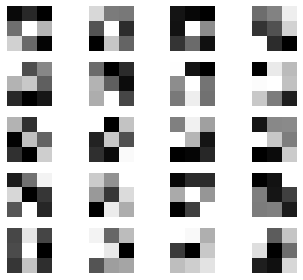

average of absolute gradients 1 tensor(2.6785e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3100e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6006e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7730e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4821e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4783e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3531e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8358e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2908e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8850e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7646e-06, device='cuda:0')


 32%|█████████████████████████▎                                                     | 321/1000 [26:50<57:07,  5.05s/it]

Epoch: 321
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1918, -0.1338, -0.2089],
         [-0.0069,  0.2559,  0.1196],
         [ 0.1702, -0.0162, -0.2018]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


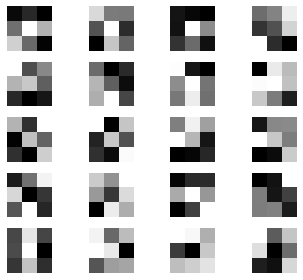

average of absolute gradients 1 tensor(2.8371e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5106e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6245e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4915e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8139e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7377e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7443e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4189e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7346e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3918e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.2434e-06, device='cuda:0')


 32%|█████████████████████████▍                                                     | 322/1000 [26:55<57:10,  5.06s/it]

Epoch: 322
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1915, -0.1330, -0.2091],
         [-0.0077,  0.2560,  0.1192],
         [ 0.1708, -0.0156, -0.2017]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


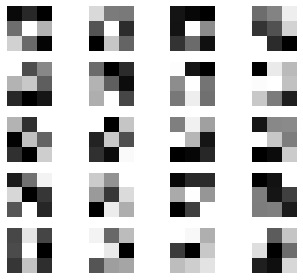

average of absolute gradients 1 tensor(2.6547e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5284e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6322e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6434e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7378e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2942e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6930e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7323e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3617e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1172e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6816e-06, device='cuda:0')


 32%|█████████████████████████▌                                                     | 323/1000 [27:00<57:02,  5.06s/it]

Epoch: 323
Accuracy of train set: 13%
Accuracy of test set: 7%

tensor([[[-0.1916, -0.1337, -0.2093],
         [-0.0077,  0.2555,  0.1189],
         [ 0.1705, -0.0158, -0.2016]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


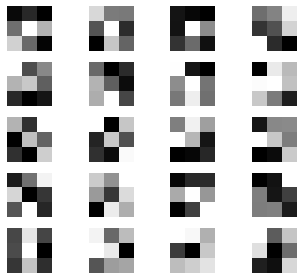

average of absolute gradients 1 tensor(3.1535e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5785e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1389e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5235e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7646e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6182e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5399e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4182e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0168e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0242e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4835e-06, device='cuda:0')


 32%|█████████████████████████▌                                                     | 324/1000 [27:05<56:49,  5.04s/it]

Epoch: 324
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1914, -0.1339, -0.2088],
         [-0.0069,  0.2553,  0.1192],
         [ 0.1703, -0.0163, -0.2018]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


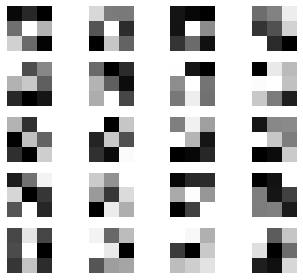

average of absolute gradients 1 tensor(2.4561e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0549e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4444e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7567e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3122e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9670e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7990e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4068e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8549e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6293e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7898e-06, device='cuda:0')


 32%|█████████████████████████▋                                                     | 325/1000 [27:10<56:42,  5.04s/it]

Epoch: 325
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1913, -0.1345, -0.2087],
         [-0.0067,  0.2551,  0.1195],
         [ 0.1691, -0.0175, -0.2022]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


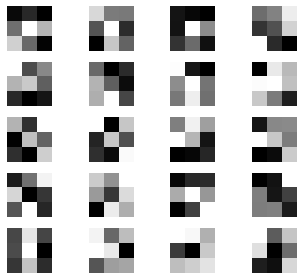

average of absolute gradients 1 tensor(2.9444e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4990e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7364e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5512e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2348e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2812e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5196e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2059e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9673e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6586e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2364e-06, device='cuda:0')


 33%|█████████████████████████▊                                                     | 326/1000 [27:16<56:32,  5.03s/it]

Epoch: 326
Accuracy of train set: 13%
Accuracy of test set: 8%

tensor([[[-0.1914, -0.1340, -0.2080],
         [-0.0066,  0.2547,  0.1200],
         [ 0.1700, -0.0177, -0.2022]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


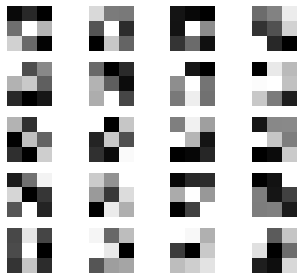

average of absolute gradients 1 tensor(2.1826e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0490e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7498e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3479e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2854e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7061e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6693e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6574e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7061e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7535e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9283e-06, device='cuda:0')


 33%|█████████████████████████▊                                                     | 327/1000 [27:21<56:24,  5.03s/it]

Epoch: 327
Accuracy of train set: 14%
Accuracy of test set: 8%

tensor([[[-0.1917, -0.1345, -0.2080],
         [-0.0066,  0.2545,  0.1197],
         [ 0.1691, -0.0181, -0.2022]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


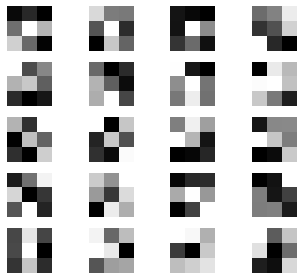

average of absolute gradients 1 tensor(2.3163e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5640e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3140e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7124e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5566e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9290e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6050e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5878e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3840e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3415e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3687e-06, device='cuda:0')


 33%|█████████████████████████▉                                                     | 328/1000 [27:26<56:27,  5.04s/it]

Epoch: 328
Accuracy of train set: 14%
Accuracy of test set: 8%

tensor([[[-0.1914, -0.1338, -0.2075],
         [-0.0059,  0.2552,  0.1203],
         [ 0.1690, -0.0180, -0.2019]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


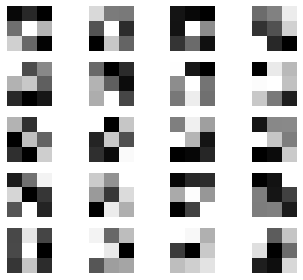

average of absolute gradients 1 tensor(2.7444e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8058e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3066e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9427e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9800e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3901e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9085e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7878e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4446e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4884e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7550e-06, device='cuda:0')


 33%|█████████████████████████▉                                                     | 329/1000 [27:31<56:13,  5.03s/it]

Epoch: 329
Accuracy of train set: 14%
Accuracy of test set: 8%

tensor([[[-0.1920, -0.1345, -0.2073],
         [-0.0064,  0.2549,  0.1203],
         [ 0.1684, -0.0184, -0.2017]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


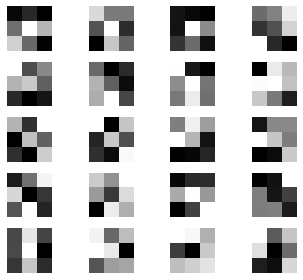

average of absolute gradients 1 tensor(3.1667e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4310e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9965e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0656e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2627e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2009e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3035e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6561e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6218e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6983e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2568e-06, device='cuda:0')


 33%|██████████████████████████                                                     | 330/1000 [27:36<56:06,  5.03s/it]

Epoch: 330
Accuracy of train set: 14%
Accuracy of test set: 8%

tensor([[[-0.1924, -0.1346, -0.2069],
         [-0.0064,  0.2550,  0.1199],
         [ 0.1684, -0.0183, -0.2013]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


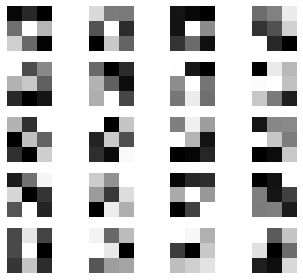

average of absolute gradients 1 tensor(2.6225e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3234e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7892e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5158e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4399e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4612e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4170e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0339e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8506e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9326e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4846e-06, device='cuda:0')


 33%|██████████████████████████▏                                                    | 331/1000 [27:41<55:55,  5.02s/it]

Epoch: 331
Accuracy of train set: 14%
Accuracy of test set: 8%

tensor([[[-0.1930, -0.1344, -0.2067],
         [-0.0072,  0.2547,  0.1200],
         [ 0.1679, -0.0184, -0.2012]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


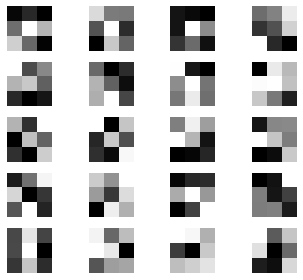

average of absolute gradients 1 tensor(2.1537e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0677e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2761e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6412e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5322e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7689e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6064e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2630e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6370e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9727e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3847e-06, device='cuda:0')


 33%|██████████████████████████▏                                                    | 332/1000 [27:46<55:44,  5.01s/it]

Epoch: 332
Accuracy of train set: 14%
Accuracy of test set: 8%

tensor([[[-0.1931, -0.1345, -0.2053],
         [-0.0060,  0.2559,  0.1211],
         [ 0.1668, -0.0187, -0.2008]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


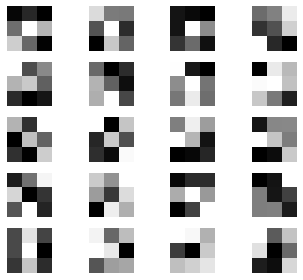

average of absolute gradients 1 tensor(3.1779e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8475e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6513e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1522e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9214e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8345e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4177e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7497e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5348e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0007e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8757e-06, device='cuda:0')


 33%|██████████████████████████▎                                                    | 333/1000 [27:51<55:42,  5.01s/it]

Epoch: 333
Accuracy of train set: 14%
Accuracy of test set: 8%

tensor([[[-0.1944, -0.1352, -0.2056],
         [-0.0072,  0.2543,  0.1199],
         [ 0.1668, -0.0185, -0.2011]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


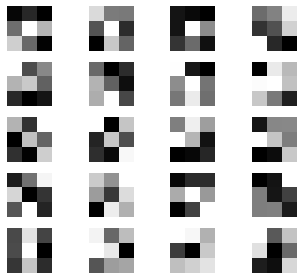

average of absolute gradients 1 tensor(3.1709e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1162e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8570e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3152e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1223e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5333e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4561e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8977e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1712e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1526e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7853e-06, device='cuda:0')


 33%|██████████████████████████▍                                                    | 334/1000 [27:56<55:44,  5.02s/it]

Epoch: 334
Accuracy of train set: 14%
Accuracy of test set: 8%

tensor([[[-0.1946, -0.1349, -0.2053],
         [-0.0071,  0.2546,  0.1207],
         [ 0.1661, -0.0182, -0.2008]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


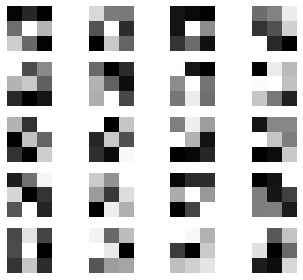

average of absolute gradients 1 tensor(2.7774e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8684e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8159e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6858e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5459e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8075e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4248e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2610e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1606e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8078e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8804e-06, device='cuda:0')


 34%|██████████████████████████▍                                                    | 335/1000 [28:01<55:34,  5.01s/it]

Epoch: 335
Accuracy of train set: 14%
Accuracy of test set: 7%

tensor([[[-0.1950, -0.1351, -0.2048],
         [-0.0072,  0.2541,  0.1209],
         [ 0.1662, -0.0181, -0.2007]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


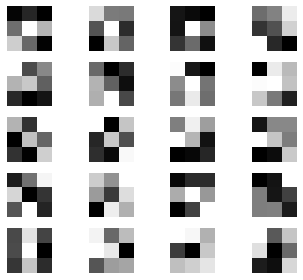

average of absolute gradients 1 tensor(2.9796e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9832e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9455e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8734e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5961e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7635e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1820e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6338e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2796e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1645e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1529e-06, device='cuda:0')


 34%|██████████████████████████▌                                                    | 336/1000 [28:06<55:37,  5.03s/it]

Epoch: 336
Accuracy of train set: 14%
Accuracy of test set: 8%

tensor([[[-0.1955, -0.1353, -0.2048],
         [-0.0066,  0.2535,  0.1206],
         [ 0.1662, -0.0186, -0.2006]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


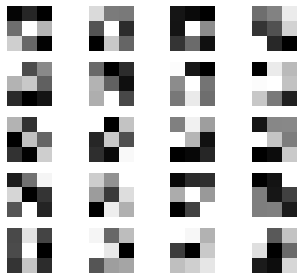

average of absolute gradients 1 tensor(2.9012e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6061e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3384e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2137e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1534e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3461e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3004e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2887e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1677e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3680e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1979e-06, device='cuda:0')


 34%|██████████████████████████▌                                                    | 337/1000 [28:11<55:29,  5.02s/it]

Epoch: 337
Accuracy of train set: 14%
Accuracy of test set: 8%

tensor([[[-0.1961, -0.1360, -0.2044],
         [-0.0069,  0.2527,  0.1210],
         [ 0.1659, -0.0190, -0.2005]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


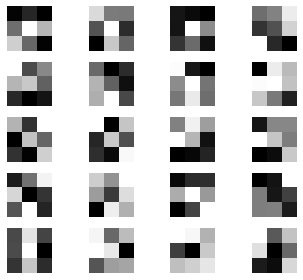

average of absolute gradients 1 tensor(3.3891e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4342e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7736e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0445e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8987e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3982e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3609e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2023e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1671e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6567e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3533e-06, device='cuda:0')


 34%|██████████████████████████▋                                                    | 338/1000 [28:16<55:20,  5.02s/it]

Epoch: 338
Accuracy of train set: 14%
Accuracy of test set: 8%

tensor([[[-0.1966, -0.1356, -0.2040],
         [-0.0067,  0.2525,  0.1213],
         [ 0.1660, -0.0193, -0.2001]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


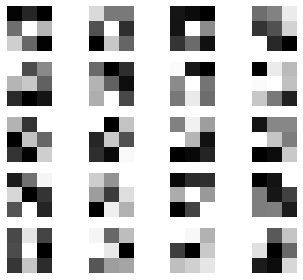

average of absolute gradients 1 tensor(3.1159e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9001e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9833e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0020e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6800e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1472e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6919e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9551e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3537e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2190e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3349e-06, device='cuda:0')


 34%|██████████████████████████▊                                                    | 339/1000 [28:21<55:13,  5.01s/it]

Epoch: 339
Accuracy of train set: 14%
Accuracy of test set: 8%

tensor([[[-0.1973, -0.1355, -0.2034],
         [-0.0070,  0.2525,  0.1204],
         [ 0.1662, -0.0193, -0.2002]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


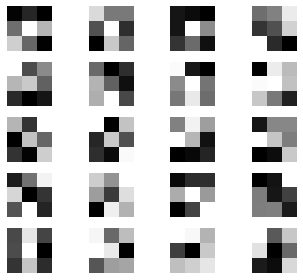

average of absolute gradients 1 tensor(4.7462e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9973e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5989e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8685e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4638e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4387e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3964e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0630e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8286e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9320e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6438e-06, device='cuda:0')


 34%|██████████████████████████▊                                                    | 340/1000 [28:26<55:15,  5.02s/it]

Epoch: 340
Accuracy of train set: 14%
Accuracy of test set: 8%

tensor([[[-0.1974, -0.1356, -0.2027],
         [-0.0066,  0.2528,  0.1205],
         [ 0.1664, -0.0198, -0.1996]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


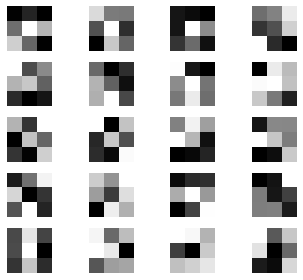

average of absolute gradients 1 tensor(3.7116e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7386e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3362e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5223e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2555e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2948e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3455e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6232e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7107e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4291e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9867e-06, device='cuda:0')


 34%|██████████████████████████▉                                                    | 341/1000 [28:31<55:14,  5.03s/it]

Epoch: 341
Accuracy of train set: 14%
Accuracy of test set: 8%

tensor([[[-0.1976, -0.1361, -0.2027],
         [-0.0070,  0.2514,  0.1214],
         [ 0.1666, -0.0199, -0.1997]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


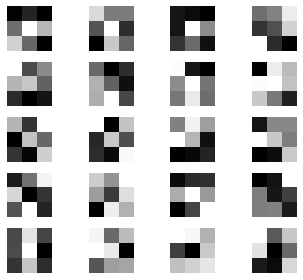

average of absolute gradients 1 tensor(4.0366e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7523e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7044e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6619e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8398e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9430e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1341e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7921e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2152e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8752e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5808e-06, device='cuda:0')


 34%|███████████████████████████                                                    | 342/1000 [28:36<55:09,  5.03s/it]

Epoch: 342
Accuracy of train set: 14%
Accuracy of test set: 8%

tensor([[[-0.1978, -0.1360, -0.2027],
         [-0.0066,  0.2516,  0.1215],
         [ 0.1664, -0.0201, -0.1990]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


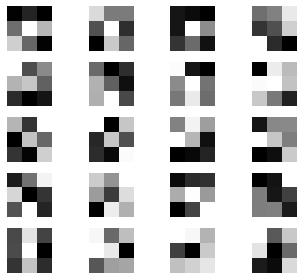

average of absolute gradients 1 tensor(3.7301e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1783e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5509e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9474e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0279e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4489e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5832e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9319e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2707e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9914e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0164e-06, device='cuda:0')


 34%|███████████████████████████                                                    | 343/1000 [28:41<55:00,  5.02s/it]

Epoch: 343
Accuracy of train set: 14%
Accuracy of test set: 7%

tensor([[[-0.1981, -0.1358, -0.2021],
         [-0.0065,  0.2515,  0.1215],
         [ 0.1666, -0.0206, -0.1989]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


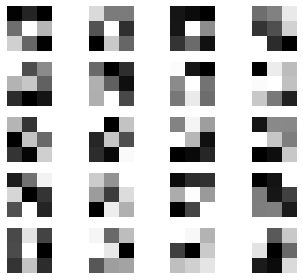

average of absolute gradients 1 tensor(4.8884e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4603e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7039e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8788e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5413e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1177e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5415e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3515e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0766e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1029e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2920e-06, device='cuda:0')


 34%|███████████████████████████▏                                                   | 344/1000 [28:46<54:54,  5.02s/it]

Epoch: 344
Accuracy of train set: 14%
Accuracy of test set: 8%

tensor([[[-0.1980, -0.1360, -0.2023],
         [-0.0068,  0.2510,  0.1225],
         [ 0.1658, -0.0215, -0.1988]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


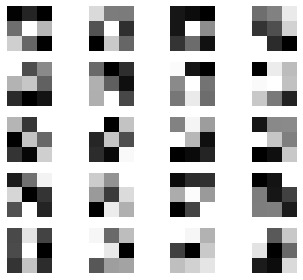

average of absolute gradients 1 tensor(3.4344e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8337e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0471e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3626e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5578e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4653e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2435e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6328e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8368e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1649e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0137e-06, device='cuda:0')


 34%|███████████████████████████▎                                                   | 345/1000 [28:51<54:42,  5.01s/it]

Epoch: 345
Accuracy of train set: 14%
Accuracy of test set: 8%

tensor([[[-0.1985, -0.1365, -0.2022],
         [-0.0077,  0.2497,  0.1222],
         [ 0.1660, -0.0217, -0.1992]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


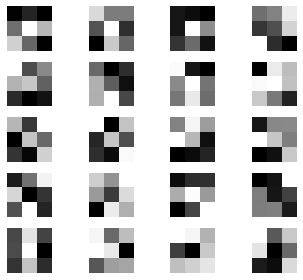

average of absolute gradients 1 tensor(5.2275e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4520e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0244e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0436e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4926e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9583e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8368e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1640e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3848e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4146e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6885e-06, device='cuda:0')


 35%|███████████████████████████▎                                                   | 346/1000 [28:56<54:35,  5.01s/it]

Epoch: 346
Accuracy of train set: 14%
Accuracy of test set: 8%

tensor([[[-0.1975, -0.1352, -0.2022],
         [-0.0080,  0.2499,  0.1238],
         [ 0.1667, -0.0219, -0.1989]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


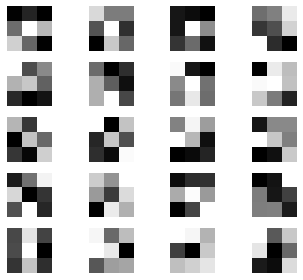

average of absolute gradients 1 tensor(3.5226e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9359e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8685e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1981e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5084e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9404e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6235e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3709e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9156e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0987e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6552e-06, device='cuda:0')


 35%|███████████████████████████▍                                                   | 347/1000 [29:01<54:30,  5.01s/it]

Epoch: 347
Accuracy of train set: 14%
Accuracy of test set: 8%

tensor([[[-0.1973, -0.1346, -0.2027],
         [-0.0080,  0.2498,  0.1244],
         [ 0.1662, -0.0212, -0.1988]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


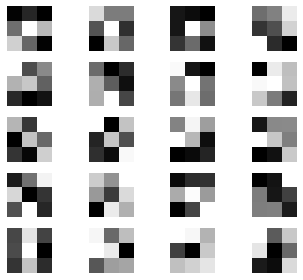

average of absolute gradients 1 tensor(3.4207e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6365e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6817e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7367e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3649e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0376e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4629e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9093e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4346e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2743e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8794e-06, device='cuda:0')


 35%|███████████████████████████▍                                                   | 348/1000 [29:06<54:24,  5.01s/it]

Epoch: 348
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.1975, -0.1346, -0.2028],
         [-0.0084,  0.2485,  0.1253],
         [ 0.1668, -0.0203, -0.1988]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


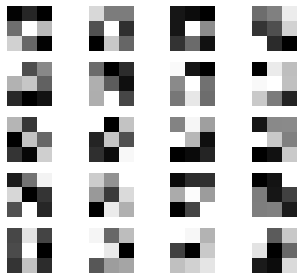

average of absolute gradients 1 tensor(3.8387e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6253e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8612e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3845e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2364e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6740e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8735e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1537e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0621e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8878e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0911e-06, device='cuda:0')


 35%|███████████████████████████▌                                                   | 349/1000 [29:11<54:21,  5.01s/it]

Epoch: 349
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.1971, -0.1343, -0.2024],
         [-0.0079,  0.2492,  0.1259],
         [ 0.1664, -0.0195, -0.1986]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


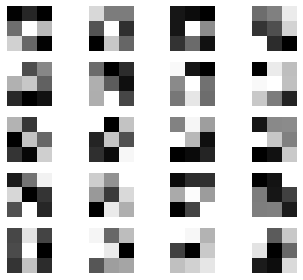

average of absolute gradients 1 tensor(3.9455e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9767e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6598e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9889e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2989e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0095e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1368e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9750e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0821e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8964e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6850e-06, device='cuda:0')


 35%|███████████████████████████▋                                                   | 350/1000 [29:16<54:17,  5.01s/it]

Epoch: 350
Accuracy of train set: 14%
Accuracy of test set: 7%

tensor([[[-0.1970, -0.1339, -0.2025],
         [-0.0081,  0.2490,  0.1263],
         [ 0.1670, -0.0197, -0.1978]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


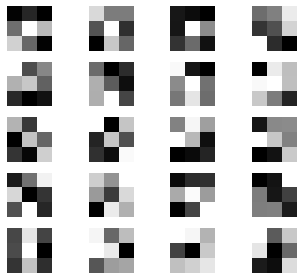

average of absolute gradients 1 tensor(5.0683e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2574e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4637e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6387e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0458e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6449e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5074e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3291e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4983e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2404e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6666e-06, device='cuda:0')


 35%|███████████████████████████▋                                                   | 351/1000 [29:21<54:12,  5.01s/it]

Epoch: 351
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.1972, -0.1342, -0.2022],
         [-0.0083,  0.2488,  0.1263],
         [ 0.1661, -0.0212, -0.1982]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


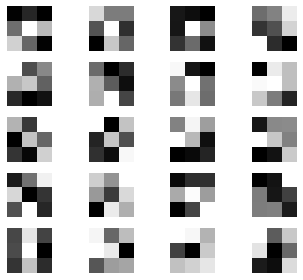

average of absolute gradients 1 tensor(3.2342e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9729e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2268e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0422e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3923e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1058e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5677e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3166e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9856e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7954e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7171e-06, device='cuda:0')


 35%|███████████████████████████▊                                                   | 352/1000 [29:26<54:20,  5.03s/it]

Epoch: 352
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.1981, -0.1344, -0.2020],
         [-0.0080,  0.2482,  0.1262],
         [ 0.1659, -0.0218, -0.1980]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


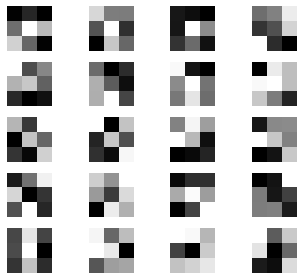

average of absolute gradients 1 tensor(3.0939e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2860e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2707e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1106e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2206e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8423e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2299e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0107e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5450e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8218e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0053e-06, device='cuda:0')


 35%|███████████████████████████▉                                                   | 353/1000 [29:31<54:09,  5.02s/it]

Epoch: 353
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.1984, -0.1343, -0.2021],
         [-0.0078,  0.2479,  0.1257],
         [ 0.1660, -0.0223, -0.1976]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


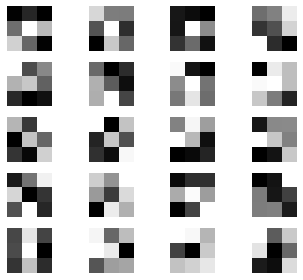

average of absolute gradients 1 tensor(3.1798e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8813e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0230e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0999e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9547e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1307e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8851e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9346e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4186e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5975e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3672e-06, device='cuda:0')


 35%|███████████████████████████▉                                                   | 354/1000 [29:36<54:00,  5.02s/it]

Epoch: 354
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.1992, -0.1339, -0.2023],
         [-0.0077,  0.2472,  0.1251],
         [ 0.1661, -0.0225, -0.1977]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


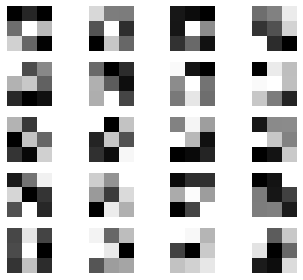

average of absolute gradients 1 tensor(3.6621e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9131e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5257e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0878e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1937e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3982e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5787e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5258e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5039e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0752e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1435e-06, device='cuda:0')


 36%|████████████████████████████                                                   | 355/1000 [29:41<53:54,  5.01s/it]

Epoch: 355
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.1992, -0.1330, -0.2018],
         [-0.0073,  0.2473,  0.1256],
         [ 0.1671, -0.0227, -0.1971]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


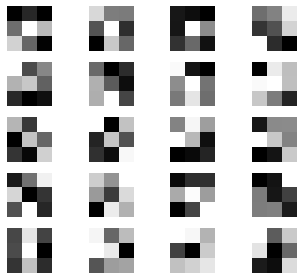

average of absolute gradients 1 tensor(4.3169e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8206e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7560e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5971e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0636e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0657e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6866e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1556e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3138e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3046e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7766e-06, device='cuda:0')


 36%|████████████████████████████                                                   | 356/1000 [29:46<53:48,  5.01s/it]

Epoch: 356
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.1996, -0.1335, -0.2020],
         [-0.0069,  0.2468,  0.1248],
         [ 0.1664, -0.0234, -0.1973]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


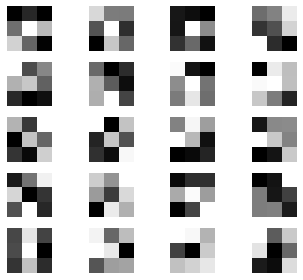

average of absolute gradients 1 tensor(2.5455e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6213e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0770e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4634e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8582e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6428e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9893e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3446e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5451e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6317e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3255e-06, device='cuda:0')


 36%|████████████████████████████▏                                                  | 357/1000 [29:51<53:40,  5.01s/it]

Epoch: 357
Accuracy of train set: 15%
Accuracy of test set: 9%

tensor([[[-0.1998, -0.1333, -0.2021],
         [-0.0070,  0.2464,  0.1253],
         [ 0.1660, -0.0243, -0.1972]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


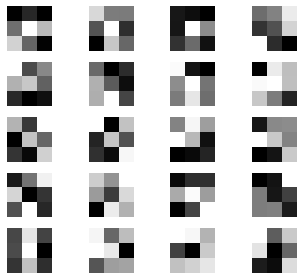

average of absolute gradients 1 tensor(3.6230e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9461e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6035e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9907e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3515e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6544e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0590e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6585e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3724e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3379e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7463e-06, device='cuda:0')


 36%|████████████████████████████▎                                                  | 358/1000 [29:56<53:35,  5.01s/it]

Epoch: 358
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.1999, -0.1331, -0.2023],
         [-0.0071,  0.2460,  0.1245],
         [ 0.1666, -0.0249, -0.1971]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


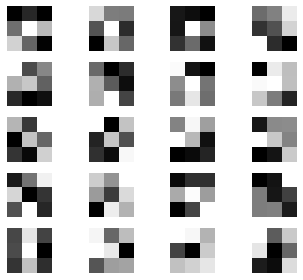

average of absolute gradients 1 tensor(3.7815e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1928e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6715e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4277e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2403e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1476e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5924e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4558e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7246e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0129e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4316e-06, device='cuda:0')


 36%|████████████████████████████▎                                                  | 359/1000 [30:01<53:31,  5.01s/it]

Epoch: 359
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.1997, -0.1334, -0.2022],
         [-0.0071,  0.2459,  0.1243],
         [ 0.1664, -0.0259, -0.1969]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


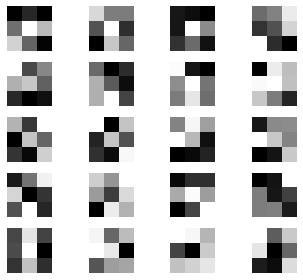

average of absolute gradients 1 tensor(2.9125e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6405e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9520e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2076e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1648e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9701e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0680e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8940e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5464e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8197e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0166e-06, device='cuda:0')


 36%|████████████████████████████▍                                                  | 360/1000 [30:06<53:40,  5.03s/it]

Epoch: 360
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.1992, -0.1329, -0.2026],
         [-0.0073,  0.2461,  0.1241],
         [ 0.1663, -0.0261, -0.1969]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


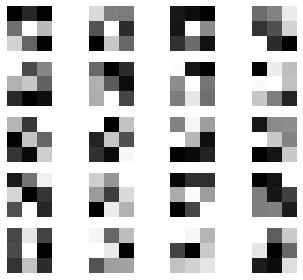

average of absolute gradients 1 tensor(3.6547e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2819e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9416e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7492e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5129e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7762e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0321e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8402e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8870e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6549e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8289e-06, device='cuda:0')


 36%|████████████████████████████▌                                                  | 361/1000 [30:11<53:36,  5.03s/it]

Epoch: 361
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.1993, -0.1333, -0.2020],
         [-0.0066,  0.2463,  0.1240],
         [ 0.1660, -0.0259, -0.1969]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


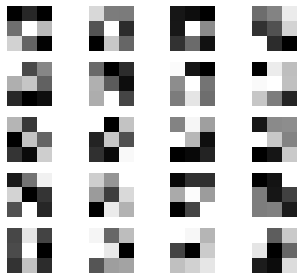

average of absolute gradients 1 tensor(2.8778e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9622e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8253e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3547e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4343e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9555e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2022e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7050e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0815e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9959e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5929e-06, device='cuda:0')


 36%|████████████████████████████▌                                                  | 362/1000 [30:16<53:22,  5.02s/it]

Epoch: 362
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.1990, -0.1334, -0.2012],
         [-0.0068,  0.2465,  0.1245],
         [ 0.1661, -0.0260, -0.1968]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


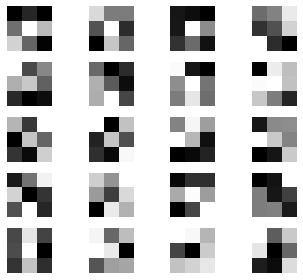

average of absolute gradients 1 tensor(2.7829e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8729e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3387e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1162e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1907e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6917e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9264e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0064e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2771e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0279e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0721e-06, device='cuda:0')


 36%|████████████████████████████▋                                                  | 363/1000 [30:21<53:21,  5.03s/it]

Epoch: 363
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.1996, -0.1337, -0.2013],
         [-0.0063,  0.2460,  0.1239],
         [ 0.1658, -0.0263, -0.1968]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


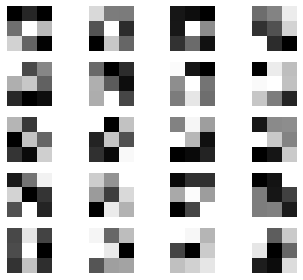

average of absolute gradients 1 tensor(3.2140e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3632e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1603e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4107e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9232e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8785e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0958e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4803e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4882e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3672e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4371e-06, device='cuda:0')


 36%|████████████████████████████▊                                                  | 364/1000 [30:26<53:22,  5.04s/it]

Epoch: 364
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.1991, -0.1331, -0.2004],
         [-0.0056,  0.2467,  0.1243],
         [ 0.1663, -0.0255, -0.1966]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


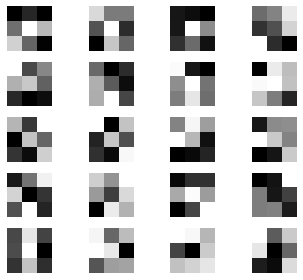

average of absolute gradients 1 tensor(4.1822e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2044e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7274e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0618e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8731e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3617e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5496e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2375e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9859e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8716e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2773e-06, device='cuda:0')


 36%|████████████████████████████▊                                                  | 365/1000 [30:31<53:18,  5.04s/it]

Epoch: 365
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.1996, -0.1344, -0.1998],
         [-0.0061,  0.2461,  0.1235],
         [ 0.1665, -0.0262, -0.1965]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


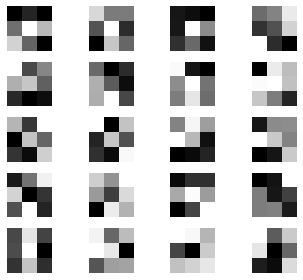

average of absolute gradients 1 tensor(4.5907e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2358e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2380e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8851e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4196e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5914e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6665e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3239e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0869e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8128e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5726e-06, device='cuda:0')


 37%|████████████████████████████▉                                                  | 366/1000 [30:36<53:09,  5.03s/it]

Epoch: 366
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.1992, -0.1338, -0.1988],
         [-0.0061,  0.2468,  0.1246],
         [ 0.1665, -0.0265, -0.1965]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


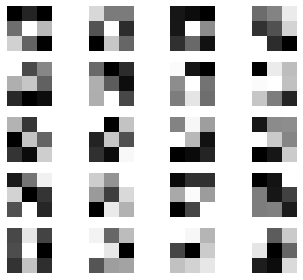

average of absolute gradients 1 tensor(3.2534e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3989e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2879e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4966e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8866e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2562e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9005e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0016e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7651e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1812e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0171e-06, device='cuda:0')


 37%|████████████████████████████▉                                                  | 367/1000 [30:41<52:58,  5.02s/it]

Epoch: 367
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.1998, -0.1335, -0.1984],
         [-0.0057,  0.2466,  0.1235],
         [ 0.1666, -0.0265, -0.1968]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


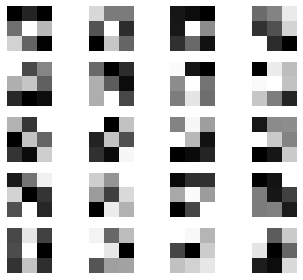

average of absolute gradients 1 tensor(3.0896e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9802e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1232e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6674e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6024e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4754e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6405e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8392e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2795e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6676e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1705e-06, device='cuda:0')


 37%|█████████████████████████████                                                  | 368/1000 [30:46<52:46,  5.01s/it]

Epoch: 368
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.1998, -0.1329, -0.1981],
         [-0.0059,  0.2471,  0.1229],
         [ 0.1666, -0.0262, -0.1967]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


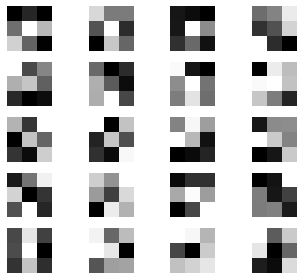

average of absolute gradients 1 tensor(2.7610e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0227e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7874e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7717e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1969e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8645e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5987e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7539e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2264e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5343e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5106e-06, device='cuda:0')


 37%|█████████████████████████████▏                                                 | 369/1000 [30:51<52:45,  5.02s/it]

Epoch: 369
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.1995, -0.1322, -0.1969],
         [-0.0052,  0.2483,  0.1228],
         [ 0.1673, -0.0262, -0.1965]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


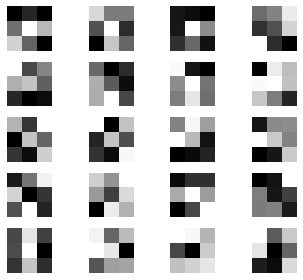

average of absolute gradients 1 tensor(2.6100e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9183e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2775e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0772e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4658e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8829e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6284e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5362e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3090e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4658e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7598e-06, device='cuda:0')


 37%|█████████████████████████████▏                                                 | 370/1000 [30:56<52:41,  5.02s/it]

Epoch: 370
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.2000, -0.1323, -0.1975],
         [-0.0053,  0.2471,  0.1222],
         [ 0.1669, -0.0268, -0.1970]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


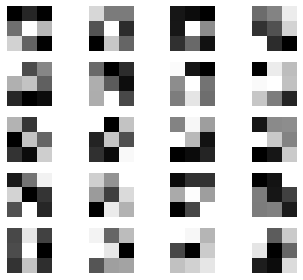

average of absolute gradients 1 tensor(3.3607e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3502e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3142e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5244e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3021e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5242e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7430e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2245e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3068e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9082e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7995e-06, device='cuda:0')


 37%|█████████████████████████████▎                                                 | 371/1000 [31:02<53:04,  5.06s/it]

Epoch: 371
Accuracy of train set: 15%
Accuracy of test set: 8%

tensor([[[-0.2002, -0.1323, -0.1972],
         [-0.0046,  0.2465,  0.1224],
         [ 0.1672, -0.0270, -0.1971]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


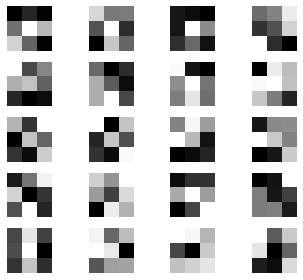

average of absolute gradients 1 tensor(3.3843e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0114e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1908e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7631e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1639e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5919e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0762e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0340e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1911e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2669e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0343e-06, device='cuda:0')


 37%|█████████████████████████████▍                                                 | 372/1000 [31:07<52:52,  5.05s/it]

Epoch: 372
Accuracy of train set: 15%
Accuracy of test set: 9%

tensor([[[-0.2004, -0.1316, -0.1963],
         [-0.0045,  0.2471,  0.1226],
         [ 0.1670, -0.0274, -0.1970]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


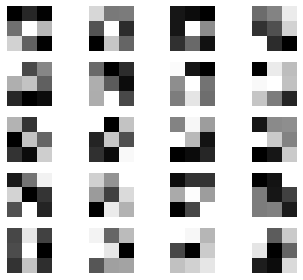

average of absolute gradients 1 tensor(3.9641e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0122e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4637e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4128e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9789e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5203e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8206e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8520e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7653e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8162e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1135e-06, device='cuda:0')


 37%|█████████████████████████████▍                                                 | 373/1000 [31:12<52:40,  5.04s/it]

Epoch: 373
Accuracy of train set: 16%
Accuracy of test set: 9%

tensor([[[-0.2004, -0.1323, -0.1959],
         [-0.0037,  0.2473,  0.1230],
         [ 0.1667, -0.0285, -0.1962]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


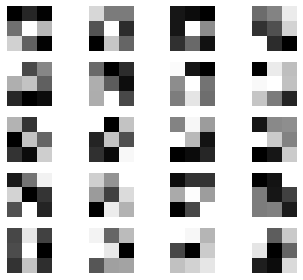

average of absolute gradients 1 tensor(4.0705e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4915e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7225e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4526e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4703e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3376e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7176e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6243e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0244e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5824e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6704e-06, device='cuda:0')


 37%|█████████████████████████████▌                                                 | 374/1000 [31:17<52:35,  5.04s/it]

Epoch: 374
Accuracy of train set: 16%
Accuracy of test set: 8%

tensor([[[-0.2008, -0.1314, -0.1961],
         [-0.0047,  0.2464,  0.1223],
         [ 0.1677, -0.0282, -0.1966]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


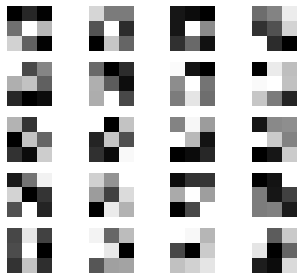

average of absolute gradients 1 tensor(4.6480e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6243e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0920e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3581e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4244e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4185e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5051e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0293e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9016e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7827e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9708e-06, device='cuda:0')


 38%|█████████████████████████████▋                                                 | 375/1000 [31:22<52:29,  5.04s/it]

Epoch: 375
Accuracy of train set: 16%
Accuracy of test set: 8%

tensor([[[-0.1994, -0.1307, -0.1952],
         [-0.0046,  0.2476,  0.1236],
         [ 0.1689, -0.0285, -0.1956]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


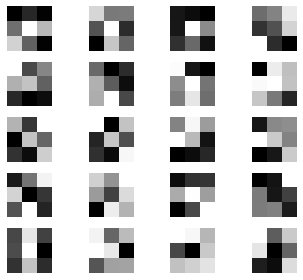

average of absolute gradients 1 tensor(4.7475e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9135e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8583e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0902e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1348e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1268e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9764e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4854e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4865e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3181e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4969e-06, device='cuda:0')


 38%|█████████████████████████████▋                                                 | 376/1000 [31:27<52:30,  5.05s/it]

Epoch: 376
Accuracy of train set: 16%
Accuracy of test set: 9%

tensor([[[-0.2000, -0.1319, -0.1957],
         [-0.0040,  0.2463,  0.1225],
         [ 0.1684, -0.0296, -0.1959]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


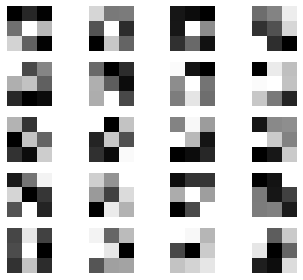

average of absolute gradients 1 tensor(5.4477e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7022e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9636e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3019e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4720e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0333e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2616e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4789e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7543e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0940e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2741e-06, device='cuda:0')


 38%|█████████████████████████████▊                                                 | 377/1000 [31:32<52:17,  5.04s/it]

Epoch: 377
Accuracy of train set: 16%
Accuracy of test set: 8%

tensor([[[-0.2002, -0.1320, -0.1945],
         [-0.0039,  0.2468,  0.1224],
         [ 0.1685, -0.0283, -0.1959]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


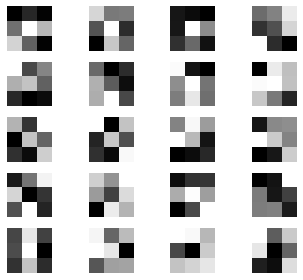

average of absolute gradients 1 tensor(4.7305e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5540e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7313e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1046e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4331e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8545e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2858e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9272e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7480e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8845e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6885e-06, device='cuda:0')


 38%|█████████████████████████████▊                                                 | 378/1000 [31:37<52:10,  5.03s/it]

Epoch: 378
Accuracy of train set: 16%
Accuracy of test set: 8%

tensor([[[-0.2008, -0.1318, -0.1949],
         [-0.0048,  0.2465,  0.1206],
         [ 0.1685, -0.0281, -0.1962]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


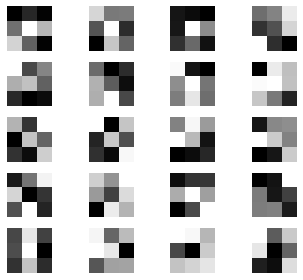

average of absolute gradients 1 tensor(6.0056e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4910e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1674e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4622e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1377e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1644e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3873e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4605e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7366e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8289e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.9402e-06, device='cuda:0')


 38%|█████████████████████████████▉                                                 | 379/1000 [31:42<52:06,  5.03s/it]

Epoch: 379
Accuracy of train set: 16%
Accuracy of test set: 6%

tensor([[[-0.1996, -0.1315, -0.1937],
         [-0.0047,  0.2472,  0.1210],
         [ 0.1691, -0.0280, -0.1967]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


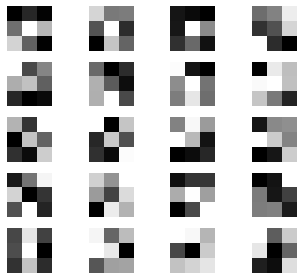

average of absolute gradients 1 tensor(9.7060e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.9066e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2263e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5098e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.9445e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2882e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8858e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7402e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3020e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1640e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9337e-06, device='cuda:0')


 38%|██████████████████████████████                                                 | 380/1000 [31:47<51:57,  5.03s/it]

Epoch: 380
Accuracy of train set: 16%
Accuracy of test set: 8%

tensor([[[-0.2002, -0.1310, -0.1949],
         [-0.0047,  0.2469,  0.1203],
         [ 0.1683, -0.0285, -0.1963]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


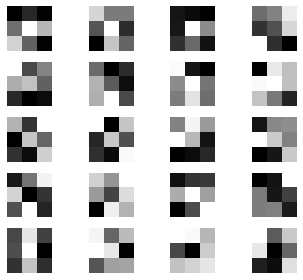

average of absolute gradients 1 tensor(5.8951e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5741e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9868e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8970e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5145e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3969e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0556e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8769e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4647e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3938e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.2688e-06, device='cuda:0')


 38%|██████████████████████████████                                                 | 381/1000 [31:52<51:48,  5.02s/it]

Epoch: 381
Accuracy of train set: 16%
Accuracy of test set: 9%

tensor([[[-0.2007, -0.1299, -0.1945],
         [-0.0051,  0.2483,  0.1205],
         [ 0.1673, -0.0292, -0.1956]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


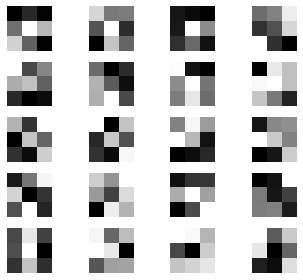

average of absolute gradients 1 tensor(5.8337e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3754e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4803e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2797e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6551e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4804e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5382e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1059e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2223e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6641e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9253e-06, device='cuda:0')


 38%|██████████████████████████████▏                                                | 382/1000 [31:57<51:39,  5.02s/it]

Epoch: 382
Accuracy of train set: 16%
Accuracy of test set: 9%

tensor([[[-0.2012, -0.1298, -0.1932],
         [-0.0043,  0.2490,  0.1204],
         [ 0.1671, -0.0292, -0.1952]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


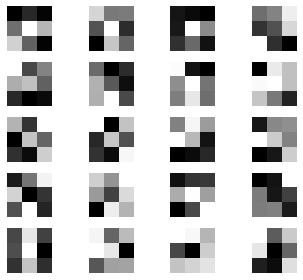

average of absolute gradients 1 tensor(4.6531e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5392e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7463e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6319e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2147e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3169e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7625e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4087e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5117e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0588e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0585e-06, device='cuda:0')


 38%|██████████████████████████████▎                                                | 383/1000 [32:02<51:35,  5.02s/it]

Epoch: 383
Accuracy of train set: 17%
Accuracy of test set: 9%

tensor([[[-0.2018, -0.1302, -0.1934],
         [-0.0047,  0.2490,  0.1186],
         [ 0.1666, -0.0294, -0.1952]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


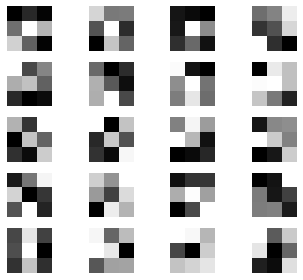

average of absolute gradients 1 tensor(5.9252e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0259e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6540e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2692e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2391e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9433e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1124e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0722e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2062e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0117e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8794e-06, device='cuda:0')


 38%|██████████████████████████████▎                                                | 384/1000 [32:07<51:30,  5.02s/it]

Epoch: 384
Accuracy of train set: 17%
Accuracy of test set: 9%

tensor([[[-0.2017, -0.1308, -0.1932],
         [-0.0051,  0.2487,  0.1178],
         [ 0.1669, -0.0304, -0.1953]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


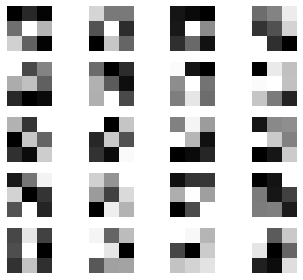

average of absolute gradients 1 tensor(6.0688e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5692e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4780e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3811e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6849e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6430e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2643e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2049e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2753e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6058e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5276e-06, device='cuda:0')


 38%|██████████████████████████████▍                                                | 385/1000 [32:12<51:20,  5.01s/it]

Epoch: 385
Accuracy of train set: 17%
Accuracy of test set: 9%

tensor([[[-0.2016, -0.1304, -0.1927],
         [-0.0054,  0.2496,  0.1182],
         [ 0.1668, -0.0305, -0.1944]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


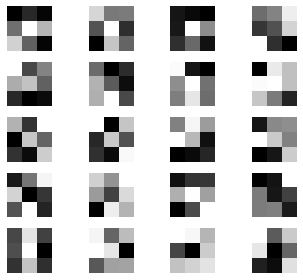

average of absolute gradients 1 tensor(4.4479e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4972e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1109e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1193e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7191e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6453e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2597e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3484e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0871e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2540e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1727e-06, device='cuda:0')


 39%|██████████████████████████████▍                                                | 386/1000 [32:17<51:13,  5.00s/it]

Epoch: 386
Accuracy of train set: 17%
Accuracy of test set: 9%

tensor([[[-0.2009, -0.1300, -0.1921],
         [-0.0046,  0.2507,  0.1175],
         [ 0.1676, -0.0305, -0.1940]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


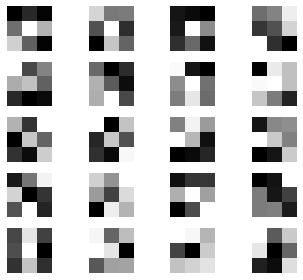

average of absolute gradients 1 tensor(5.5074e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3652e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1242e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8799e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6868e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3417e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2345e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0023e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8471e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0938e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.0428e-06, device='cuda:0')


 39%|██████████████████████████████▌                                                | 387/1000 [32:22<51:09,  5.01s/it]

Epoch: 387
Accuracy of train set: 17%
Accuracy of test set: 8%

tensor([[[-0.2021, -0.1314, -0.1931],
         [-0.0051,  0.2487,  0.1164],
         [ 0.1665, -0.0317, -0.1944]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


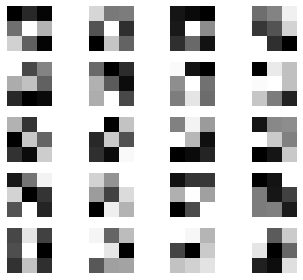

average of absolute gradients 1 tensor(6.8345e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2914e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5576e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1478e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.8117e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3967e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3771e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3062e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9482e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1863e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.9769e-06, device='cuda:0')


 39%|██████████████████████████████▋                                                | 388/1000 [32:27<51:20,  5.03s/it]

Epoch: 388
Accuracy of train set: 17%
Accuracy of test set: 8%

tensor([[[-0.2008, -0.1286, -0.1914],
         [-0.0033,  0.2509,  0.1167],
         [ 0.1698, -0.0308, -0.1934]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


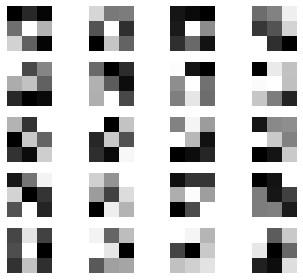

average of absolute gradients 1 tensor(7.8889e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5304e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6585e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.9807e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7662e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5145e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8107e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9120e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3751e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8464e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7881e-06, device='cuda:0')


 39%|██████████████████████████████▋                                                | 389/1000 [32:32<51:16,  5.03s/it]

Epoch: 389
Accuracy of train set: 17%
Accuracy of test set: 9%

tensor([[[-0.2021, -0.1302, -0.1930],
         [-0.0030,  0.2490,  0.1172],
         [ 0.1664, -0.0342, -0.1935]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


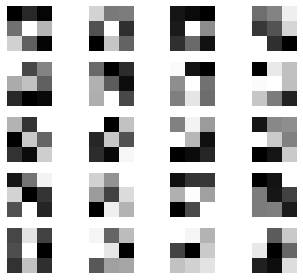

average of absolute gradients 1 tensor(6.3354e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1577e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3234e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8144e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6269e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5623e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7412e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3203e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.2278e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9581e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6139e-06, device='cuda:0')


 39%|██████████████████████████████▊                                                | 390/1000 [32:37<51:03,  5.02s/it]

Epoch: 390
Accuracy of train set: 17%
Accuracy of test set: 9%

tensor([[[-0.2017, -0.1287, -0.1930],
         [-0.0023,  0.2499,  0.1168],
         [ 0.1676, -0.0334, -0.1927]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


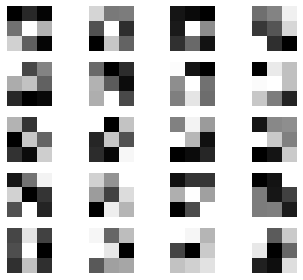

average of absolute gradients 1 tensor(5.0694e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6029e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4101e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9415e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4588e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2397e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8952e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4240e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5195e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8116e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4202e-06, device='cuda:0')


 39%|██████████████████████████████▉                                                | 391/1000 [32:42<50:56,  5.02s/it]

Epoch: 391
Accuracy of train set: 17%
Accuracy of test set: 9%

tensor([[[-0.2017, -0.1300, -0.1936],
         [-0.0021,  0.2487,  0.1157],
         [ 0.1661, -0.0351, -0.1941]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


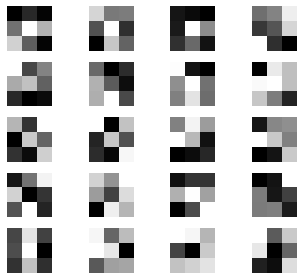

average of absolute gradients 1 tensor(7.0310e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0904e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5343e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1000e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2974e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1159e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7999e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3575e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8332e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3956e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2720e-06, device='cuda:0')


 39%|██████████████████████████████▉                                                | 392/1000 [32:47<50:52,  5.02s/it]

Epoch: 392
Accuracy of train set: 17%
Accuracy of test set: 9%

tensor([[[-0.2010, -0.1293, -0.1930],
         [-0.0010,  0.2495,  0.1165],
         [ 0.1668, -0.0349, -0.1935]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


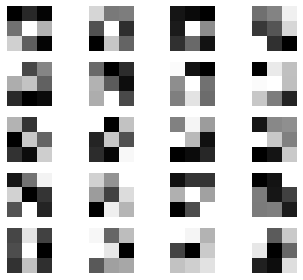

average of absolute gradients 1 tensor(4.8369e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2549e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8684e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6033e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8491e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8760e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0872e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4221e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7302e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1591e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6504e-06, device='cuda:0')


 39%|███████████████████████████████                                                | 393/1000 [32:52<50:47,  5.02s/it]

Epoch: 393
Accuracy of train set: 17%
Accuracy of test set: 9%

tensor([[[-0.2010, -0.1290, -0.1929],
         [-0.0013,  0.2498,  0.1157],
         [ 0.1667, -0.0343, -0.1937]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


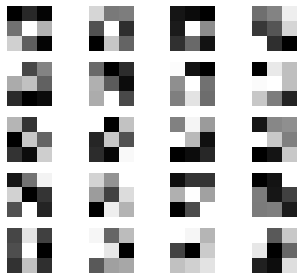

average of absolute gradients 1 tensor(6.2697e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3466e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9571e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1919e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6394e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8937e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4293e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1629e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7062e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5044e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7524e-06, device='cuda:0')


 39%|███████████████████████████████▏                                               | 394/1000 [32:57<50:52,  5.04s/it]

Epoch: 394
Accuracy of train set: 17%
Accuracy of test set: 9%

tensor([[[-0.2008, -0.1298, -0.1932],
         [-0.0014,  0.2489,  0.1155],
         [ 0.1663, -0.0351, -0.1942]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


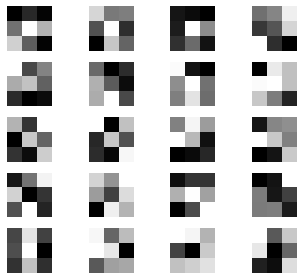

average of absolute gradients 1 tensor(5.1973e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6043e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4979e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4728e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6726e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9235e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5988e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0279e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1152e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4801e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0827e-06, device='cuda:0')


 40%|███████████████████████████████▏                                               | 395/1000 [33:02<50:41,  5.03s/it]

Epoch: 395
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2016, -0.1295, -0.1931],
         [-0.0015,  0.2486,  0.1149],
         [ 0.1656, -0.0354, -0.1946]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


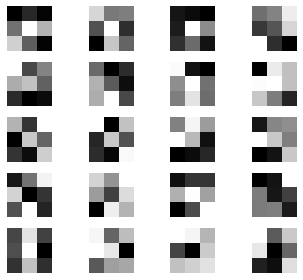

average of absolute gradients 1 tensor(5.4779e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3893e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0156e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7650e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3896e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1523e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2685e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6289e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6246e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8494e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0017e-05, device='cuda:0')


 40%|███████████████████████████████▎                                               | 396/1000 [33:07<50:31,  5.02s/it]

Epoch: 396
Accuracy of train set: 17%
Accuracy of test set: 9%

tensor([[[-0.2014, -0.1289, -0.1943],
         [-0.0018,  0.2480,  0.1150],
         [ 0.1644, -0.0356, -0.1953]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


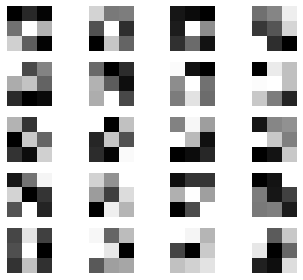

average of absolute gradients 1 tensor(7.8869e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5215e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9330e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0521e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0937e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2964e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8572e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8755e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2099e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5942e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.2156e-06, device='cuda:0')


 40%|███████████████████████████████▎                                               | 397/1000 [33:12<50:26,  5.02s/it]

Epoch: 397
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2016, -0.1287, -0.1935],
         [-0.0008,  0.2478,  0.1150],
         [ 0.1644, -0.0370, -0.1957]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


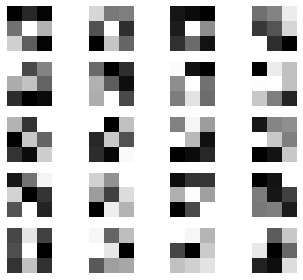

average of absolute gradients 1 tensor(5.7860e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3727e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0190e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1659e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1520e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4245e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0760e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9007e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2364e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1623e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4810e-06, device='cuda:0')


 40%|███████████████████████████████▍                                               | 398/1000 [33:17<50:23,  5.02s/it]

Epoch: 398
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2013, -0.1284, -0.1932],
         [ 0.0004,  0.2480,  0.1151],
         [ 0.1652, -0.0371, -0.1951]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


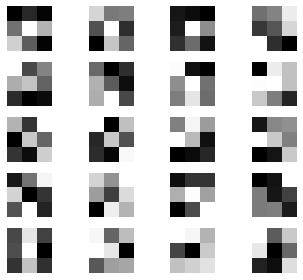

average of absolute gradients 1 tensor(5.9296e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4719e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5255e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6196e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4944e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2213e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2219e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.5118e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0190e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0290e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7005e-06, device='cuda:0')


 40%|███████████████████████████████▌                                               | 399/1000 [33:22<50:14,  5.02s/it]

Epoch: 399
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2011, -0.1287, -0.1927],
         [-0.0004,  0.2481,  0.1155],
         [ 0.1652, -0.0369, -0.1949]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


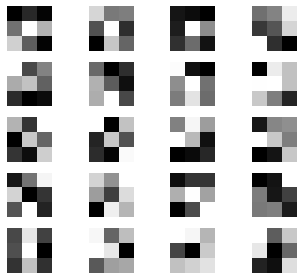

average of absolute gradients 1 tensor(5.8920e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1455e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8940e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5824e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0066e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3475e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8082e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8024e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2852e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6447e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4933e-06, device='cuda:0')


 40%|███████████████████████████████▌                                               | 400/1000 [33:27<50:14,  5.02s/it]

Epoch: 400
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2018, -0.1291, -0.1929],
         [-0.0011,  0.2474,  0.1155],
         [ 0.1638, -0.0371, -0.1953]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


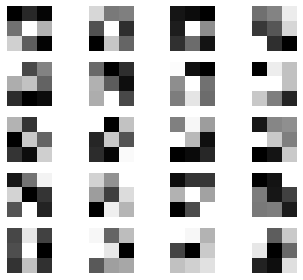

average of absolute gradients 1 tensor(4.9516e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5858e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2213e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4686e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9736e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5849e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2168e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0284e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3590e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2147e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.5643e-06, device='cuda:0')


 40%|███████████████████████████████▋                                               | 401/1000 [33:32<50:04,  5.02s/it]

Epoch: 401
Accuracy of train set: 18%
Accuracy of test set: 8%

tensor([[[-0.2022, -0.1294, -0.1929],
         [ 0.0006,  0.2475,  0.1148],
         [ 0.1636, -0.0368, -0.1949]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


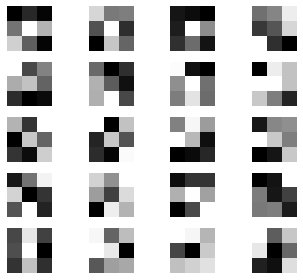

average of absolute gradients 1 tensor(7.9023e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.2924e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3553e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9396e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6415e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5375e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8676e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8960e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0233e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6351e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3703e-06, device='cuda:0')


 40%|███████████████████████████████▊                                               | 402/1000 [33:37<49:56,  5.01s/it]

Epoch: 402
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2025, -0.1289, -0.1921],
         [ 0.0003,  0.2476,  0.1154],
         [ 0.1637, -0.0362, -0.1948]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


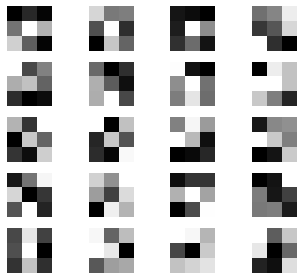

average of absolute gradients 1 tensor(5.7573e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9007e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8320e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9184e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9404e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5585e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8498e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3072e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1786e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4595e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8556e-06, device='cuda:0')


 40%|███████████████████████████████▊                                               | 403/1000 [33:42<49:54,  5.02s/it]

Epoch: 403
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-2.0164e-01, -1.2852e-01, -1.9174e-01],
         [ 7.5228e-05,  2.4801e-01,  1.1701e-01],
         [ 1.6390e-01, -3.5857e-02, -1.9446e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


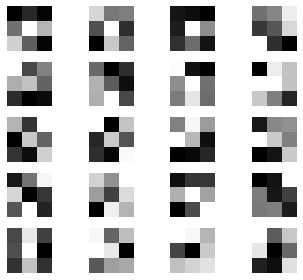

average of absolute gradients 1 tensor(5.2036e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1904e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4295e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0508e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9224e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7134e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2842e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6770e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0206e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4139e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3592e-06, device='cuda:0')


 40%|███████████████████████████████▉                                               | 404/1000 [33:47<49:46,  5.01s/it]

Epoch: 404
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-2.0158e-01, -1.2827e-01, -1.9178e-01],
         [ 2.0213e-04,  2.4728e-01,  1.1685e-01],
         [ 1.6510e-01, -3.5734e-02, -1.9434e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


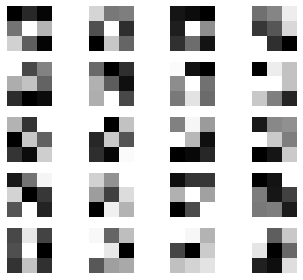

average of absolute gradients 1 tensor(6.3065e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5166e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6798e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6000e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4197e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2900e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1530e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9033e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0226e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0790e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7946e-06, device='cuda:0')


 40%|███████████████████████████████▉                                               | 405/1000 [33:52<49:42,  5.01s/it]

Epoch: 405
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-2.0134e-01, -1.2868e-01, -1.9244e-01],
         [-1.1602e-04,  2.4668e-01,  1.1657e-01],
         [ 1.6450e-01, -3.5996e-02, -1.9469e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


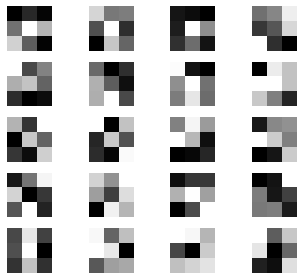

average of absolute gradients 1 tensor(4.8289e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3678e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2574e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1994e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7070e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1065e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8237e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1324e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2478e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5337e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7078e-06, device='cuda:0')


 41%|████████████████████████████████                                               | 406/1000 [33:57<49:41,  5.02s/it]

Epoch: 406
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-2.0129e-01, -1.2846e-01, -1.9230e-01],
         [-1.6951e-04,  2.4672e-01,  1.1709e-01],
         [ 1.6450e-01, -3.4938e-02, -1.9450e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


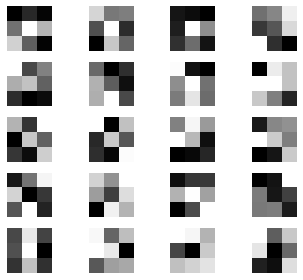

average of absolute gradients 1 tensor(5.1372e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0640e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6158e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8685e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1927e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9257e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7298e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7921e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6505e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2669e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0993e-06, device='cuda:0')


 41%|████████████████████████████████▏                                              | 407/1000 [34:02<49:43,  5.03s/it]

Epoch: 407
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2023, -0.1285, -0.1917],
         [-0.0009,  0.2463,  0.1171],
         [ 0.1636, -0.0350, -0.1948]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


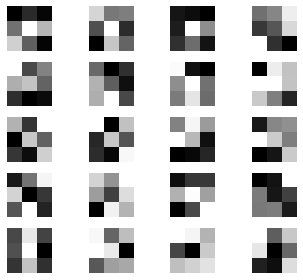

average of absolute gradients 1 tensor(5.7270e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4468e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1322e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4699e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8955e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9690e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1562e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2369e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1251e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5317e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3321e-06, device='cuda:0')


 41%|████████████████████████████████▏                                              | 408/1000 [34:07<49:34,  5.02s/it]

Epoch: 408
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2012, -0.1282, -0.1909],
         [-0.0012,  0.2481,  0.1178],
         [ 0.1634, -0.0339, -0.1943]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


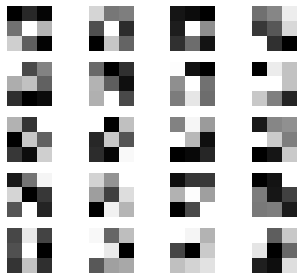

average of absolute gradients 1 tensor(4.9663e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4587e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6877e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4258e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7536e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4338e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1155e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5949e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4156e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1513e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6981e-06, device='cuda:0')


 41%|████████████████████████████████▎                                              | 409/1000 [34:12<49:26,  5.02s/it]

Epoch: 409
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2014, -0.1285, -0.1919],
         [-0.0017,  0.2466,  0.1174],
         [ 0.1632, -0.0337, -0.1949]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


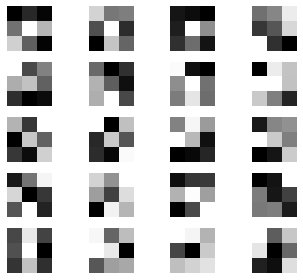

average of absolute gradients 1 tensor(5.2485e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4160e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5894e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5318e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2909e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1220e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3393e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4947e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1857e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3603e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6265e-06, device='cuda:0')


 41%|████████████████████████████████▍                                              | 410/1000 [34:17<49:17,  5.01s/it]

Epoch: 410
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2015, -0.1277, -0.1915],
         [-0.0011,  0.2473,  0.1183],
         [ 0.1626, -0.0330, -0.1946]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


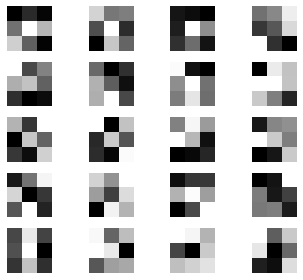

average of absolute gradients 1 tensor(4.6803e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1901e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3014e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7685e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1353e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8761e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7202e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7094e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3105e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8355e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5303e-06, device='cuda:0')


 41%|████████████████████████████████▍                                              | 411/1000 [34:22<49:11,  5.01s/it]

Epoch: 411
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2016, -0.1267, -0.1922],
         [-0.0017,  0.2462,  0.1173],
         [ 0.1641, -0.0345, -0.1946]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


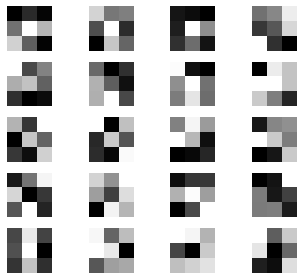

average of absolute gradients 1 tensor(6.5370e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2576e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4507e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2285e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9480e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6127e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9483e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6752e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4173e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7024e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1035e-06, device='cuda:0')


 41%|████████████████████████████████▌                                              | 412/1000 [34:27<49:11,  5.02s/it]

Epoch: 412
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2015, -0.1272, -0.1914],
         [-0.0020,  0.2464,  0.1180],
         [ 0.1634, -0.0345, -0.1946]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


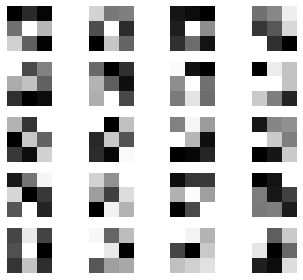

average of absolute gradients 1 tensor(4.7374e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7514e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7231e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2047e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1933e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0190e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9572e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2899e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7587e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5885e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.8530e-06, device='cuda:0')


 41%|████████████████████████████████▋                                              | 413/1000 [34:32<49:19,  5.04s/it]

Epoch: 413
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2025, -0.1277, -0.1916],
         [-0.0012,  0.2460,  0.1172],
         [ 0.1625, -0.0342, -0.1946]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


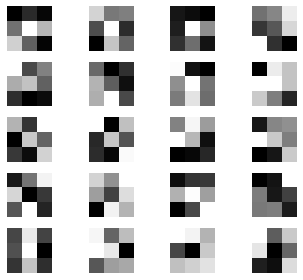

average of absolute gradients 1 tensor(7.2972e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8013e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2328e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1074e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6878e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9284e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9131e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2625e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0082e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9191e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7783e-06, device='cuda:0')


 41%|████████████████████████████████▋                                              | 414/1000 [34:38<49:16,  5.05s/it]

Epoch: 414
Accuracy of train set: 18%
Accuracy of test set: 8%

tensor([[[-2.0194e-01, -1.2655e-01, -1.8959e-01],
         [-2.2655e-04,  2.4802e-01,  1.1762e-01],
         [ 1.6300e-01, -3.3498e-02, -1.9442e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


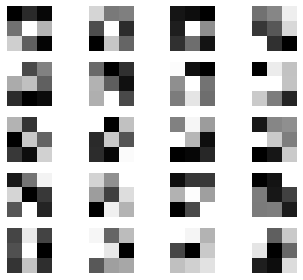

average of absolute gradients 1 tensor(6.5960e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0413e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3422e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2872e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7015e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5011e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8562e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1945e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5467e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7853e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6399e-06, device='cuda:0')


 42%|████████████████████████████████▊                                              | 415/1000 [34:43<49:09,  5.04s/it]

Epoch: 415
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2027, -0.1268, -0.1901],
         [-0.0008,  0.2460,  0.1170],
         [ 0.1634, -0.0340, -0.1950]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


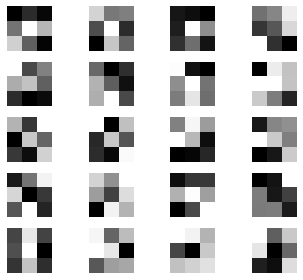

average of absolute gradients 1 tensor(5.2924e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9190e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4815e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4068e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4057e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6019e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6176e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7743e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8058e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8870e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1517e-06, device='cuda:0')


 42%|████████████████████████████████▊                                              | 416/1000 [34:48<48:56,  5.03s/it]

Epoch: 416
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2028, -0.1261, -0.1903],
         [ 0.0003,  0.2462,  0.1178],
         [ 0.1626, -0.0326, -0.1950]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


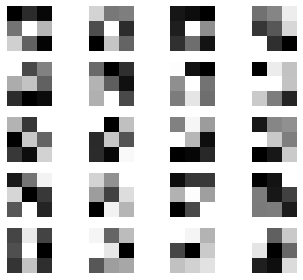

average of absolute gradients 1 tensor(5.0657e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7047e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3688e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7147e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2931e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0682e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9202e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9032e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0039e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9227e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.2053e-06, device='cuda:0')


 42%|████████████████████████████████▉                                              | 417/1000 [34:53<49:01,  5.05s/it]

Epoch: 417
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2029, -0.1261, -0.1906],
         [-0.0003,  0.2454,  0.1172],
         [ 0.1631, -0.0324, -0.1953]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


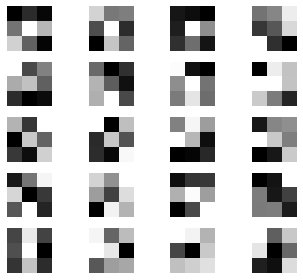

average of absolute gradients 1 tensor(4.2010e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3269e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9231e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8447e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1387e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3334e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2151e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0688e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0202e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2071e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4777e-06, device='cuda:0')


 42%|█████████████████████████████████                                              | 418/1000 [34:58<48:48,  5.03s/it]

Epoch: 418
Accuracy of train set: 18%
Accuracy of test set: 8%

tensor([[[-0.2031, -0.1266, -0.1905],
         [ 0.0006,  0.2455,  0.1177],
         [ 0.1616, -0.0329, -0.1953]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


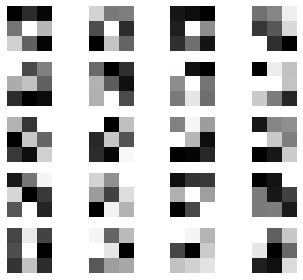

average of absolute gradients 1 tensor(8.8113e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.6024e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8581e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7571e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4270e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9524e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9118e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8689e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9778e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7300e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8439e-06, device='cuda:0')


 42%|█████████████████████████████████                                              | 419/1000 [35:03<48:45,  5.04s/it]

Epoch: 419
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-2.0329e-01, -1.2706e-01, -1.9190e-01],
         [ 9.8297e-05,  2.4418e-01,  1.1733e-01],
         [ 1.6105e-01, -3.3432e-02, -1.9529e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


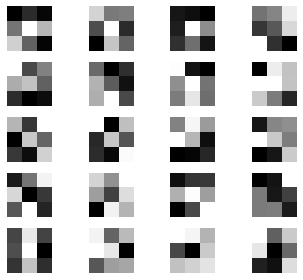

average of absolute gradients 1 tensor(4.4300e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8167e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8298e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9688e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5224e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0651e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2135e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0853e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0561e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7643e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9617e-06, device='cuda:0')


 42%|█████████████████████████████████▏                                             | 420/1000 [35:08<49:05,  5.08s/it]

Epoch: 420
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2032, -0.1267, -0.1916],
         [ 0.0007,  0.2450,  0.1176],
         [ 0.1605, -0.0330, -0.1949]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


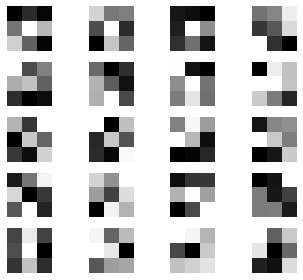

average of absolute gradients 1 tensor(4.2784e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3730e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8744e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1257e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6920e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6215e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5647e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2794e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0995e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5347e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8058e-06, device='cuda:0')


 42%|█████████████████████████████████▎                                             | 421/1000 [35:13<48:47,  5.06s/it]

Epoch: 421
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2029, -0.1268, -0.1919],
         [ 0.0006,  0.2449,  0.1167],
         [ 0.1609, -0.0335, -0.1948]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


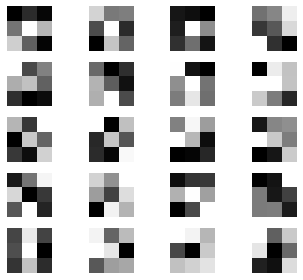

average of absolute gradients 1 tensor(3.8322e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7123e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3146e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5162e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2291e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9120e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8900e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5304e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8321e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0654e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5167e-06, device='cuda:0')


 42%|█████████████████████████████████▎                                             | 422/1000 [35:18<48:40,  5.05s/it]

Epoch: 422
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2032, -0.1271, -0.1918],
         [ 0.0003,  0.2444,  0.1163],
         [ 0.1615, -0.0332, -0.1944]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


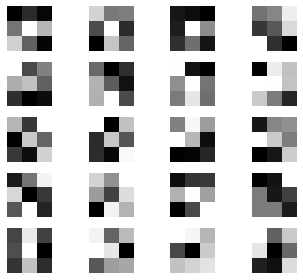

average of absolute gradients 1 tensor(4.2664e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1160e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6103e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5998e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4821e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4482e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2037e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6240e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8913e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0294e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7646e-06, device='cuda:0')


 42%|█████████████████████████████████▍                                             | 423/1000 [35:23<48:37,  5.06s/it]

Epoch: 423
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2026, -0.1273, -0.1919],
         [ 0.0010,  0.2449,  0.1169],
         [ 0.1609, -0.0333, -0.1939]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


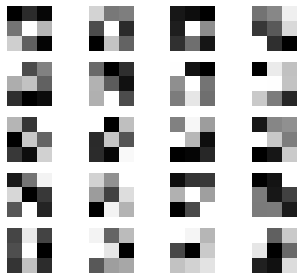

average of absolute gradients 1 tensor(4.9488e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7125e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4034e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5161e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4326e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8452e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8611e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6680e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3098e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2461e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1554e-06, device='cuda:0')


 42%|█████████████████████████████████▍                                             | 424/1000 [35:28<48:28,  5.05s/it]

Epoch: 424
Accuracy of train set: 18%
Accuracy of test set: 9%

tensor([[[-0.2026, -0.1274, -0.1917],
         [ 0.0010,  0.2449,  0.1165],
         [ 0.1608, -0.0337, -0.1940]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


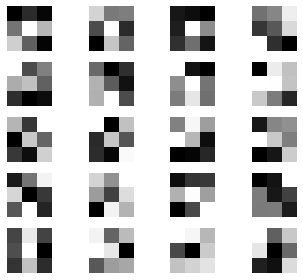

average of absolute gradients 1 tensor(3.7876e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0038e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4040e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1255e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9068e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4007e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1619e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0489e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9358e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3471e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4502e-06, device='cuda:0')


 42%|█████████████████████████████████▌                                             | 425/1000 [35:33<48:14,  5.03s/it]

Epoch: 425
Accuracy of train set: 19%
Accuracy of test set: 8%

tensor([[[-2.0265e-01, -1.2758e-01, -1.9129e-01],
         [-1.7768e-05,  2.4449e-01,  1.1575e-01],
         [ 1.6147e-01, -3.3576e-02, -1.9424e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


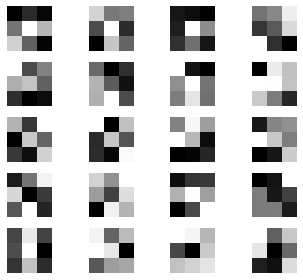

average of absolute gradients 1 tensor(5.7611e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0599e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8252e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9890e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7623e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5749e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0197e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0959e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6405e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9252e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6651e-06, device='cuda:0')


 43%|█████████████████████████████████▋                                             | 426/1000 [35:38<47:59,  5.02s/it]

Epoch: 426
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2027, -0.1283, -0.1915],
         [ 0.0005,  0.2438,  0.1150],
         [ 0.1621, -0.0330, -0.1941]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


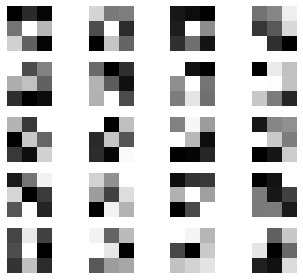

average of absolute gradients 1 tensor(4.0995e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9479e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8108e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9358e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2227e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8680e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5081e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3675e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2592e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5832e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3101e-06, device='cuda:0')


 43%|█████████████████████████████████▋                                             | 427/1000 [35:43<47:49,  5.01s/it]

Epoch: 427
Accuracy of train set: 19%
Accuracy of test set: 10%

tensor([[[-0.2024, -0.1289, -0.1911],
         [ 0.0007,  0.2440,  0.1148],
         [ 0.1619, -0.0332, -0.1940]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


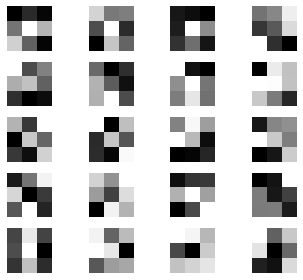

average of absolute gradients 1 tensor(4.1056e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0161e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1672e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0113e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0432e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4352e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3058e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7124e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8496e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6111e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8004e-06, device='cuda:0')


 43%|█████████████████████████████████▊                                             | 428/1000 [35:48<47:42,  5.00s/it]

Epoch: 428
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2026, -0.1294, -0.1905],
         [ 0.0007,  0.2443,  0.1150],
         [ 0.1611, -0.0327, -0.1939]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


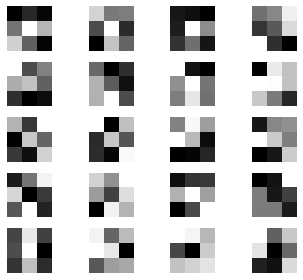

average of absolute gradients 1 tensor(4.2451e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1513e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0681e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6742e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0411e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4775e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5042e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7336e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7857e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9872e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2502e-06, device='cuda:0')


 43%|█████████████████████████████████▉                                             | 429/1000 [35:53<47:38,  5.01s/it]

Epoch: 429
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2026, -0.1292, -0.1898],
         [ 0.0008,  0.2447,  0.1148],
         [ 0.1617, -0.0319, -0.1937]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


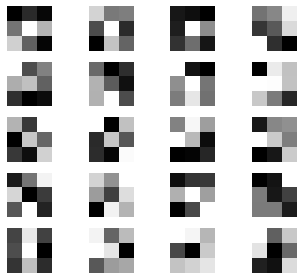

average of absolute gradients 1 tensor(3.6370e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6093e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2443e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6640e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9639e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0061e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1678e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7450e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8272e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8582e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1485e-06, device='cuda:0')


 43%|█████████████████████████████████▉                                             | 430/1000 [35:58<47:31,  5.00s/it]

Epoch: 430
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2027, -0.1297, -0.1895],
         [ 0.0010,  0.2444,  0.1137],
         [ 0.1621, -0.0324, -0.1939]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


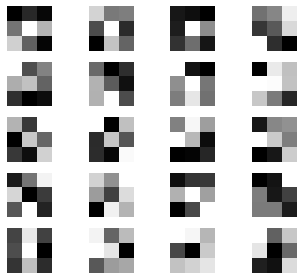

average of absolute gradients 1 tensor(4.5642e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8542e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9404e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7649e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2201e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9272e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6406e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3834e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5771e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9382e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5913e-06, device='cuda:0')


 43%|██████████████████████████████████                                             | 431/1000 [36:03<47:23,  5.00s/it]

Epoch: 431
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2028, -0.1303, -0.1895],
         [ 0.0008,  0.2435,  0.1139],
         [ 0.1621, -0.0324, -0.1940]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


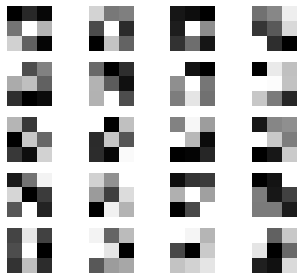

average of absolute gradients 1 tensor(4.2123e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3596e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4388e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6205e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9720e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7107e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3764e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3743e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3213e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7414e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9021e-06, device='cuda:0')


 43%|██████████████████████████████████▏                                            | 432/1000 [36:08<47:18,  5.00s/it]

Epoch: 432
Accuracy of train set: 19%
Accuracy of test set: 10%

tensor([[[-0.2031, -0.1313, -0.1900],
         [ 0.0010,  0.2424,  0.1132],
         [ 0.1617, -0.0339, -0.1940]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


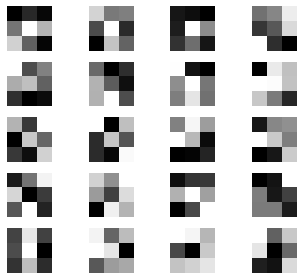

average of absolute gradients 1 tensor(3.5746e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9532e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8639e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3990e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3586e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2816e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0607e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1572e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8434e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7947e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8408e-06, device='cuda:0')


 43%|██████████████████████████████████▏                                            | 433/1000 [36:13<47:13,  5.00s/it]

Epoch: 433
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2028, -0.1307, -0.1897],
         [ 0.0012,  0.2428,  0.1138],
         [ 0.1617, -0.0333, -0.1939]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


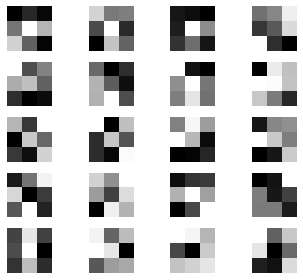

average of absolute gradients 1 tensor(4.4343e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2711e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1269e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1997e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6855e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4444e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8396e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1822e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2399e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0943e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8688e-06, device='cuda:0')


 43%|██████████████████████████████████▎                                            | 434/1000 [36:18<47:04,  4.99s/it]

Epoch: 434
Accuracy of train set: 19%
Accuracy of test set: 8%

tensor([[[-0.2031, -0.1309, -0.1901],
         [ 0.0010,  0.2422,  0.1135],
         [ 0.1616, -0.0334, -0.1938]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


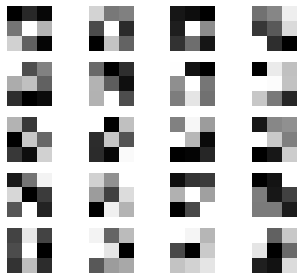

average of absolute gradients 1 tensor(4.5137e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9763e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1027e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3762e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6647e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7472e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3679e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7838e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6506e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4221e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0302e-06, device='cuda:0')


 44%|██████████████████████████████████▎                                            | 435/1000 [36:23<47:04,  5.00s/it]

Epoch: 435
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2035, -0.1306, -0.1899],
         [ 0.0015,  0.2418,  0.1142],
         [ 0.1614, -0.0326, -0.1936]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


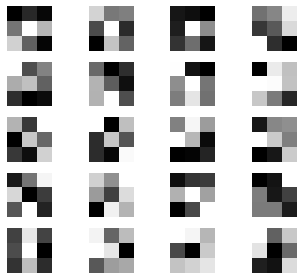

average of absolute gradients 1 tensor(4.2078e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9281e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5458e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0171e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2569e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9418e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8255e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2659e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1638e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7714e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6623e-06, device='cuda:0')


 44%|██████████████████████████████████▍                                            | 436/1000 [36:28<47:02,  5.00s/it]

Epoch: 436
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2038, -0.1307, -0.1895],
         [ 0.0012,  0.2421,  0.1138],
         [ 0.1613, -0.0327, -0.1933]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


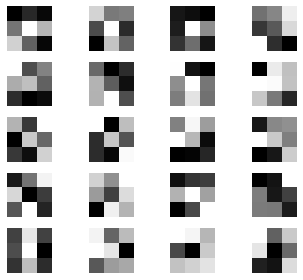

average of absolute gradients 1 tensor(4.5560e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4940e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6453e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7592e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2241e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3750e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9412e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9452e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7582e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6977e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5680e-06, device='cuda:0')


 44%|██████████████████████████████████▌                                            | 437/1000 [36:33<47:03,  5.01s/it]

Epoch: 437
Accuracy of train set: 19%
Accuracy of test set: 8%

tensor([[[-0.2040, -0.1307, -0.1902],
         [ 0.0012,  0.2415,  0.1125],
         [ 0.1618, -0.0324, -0.1932]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


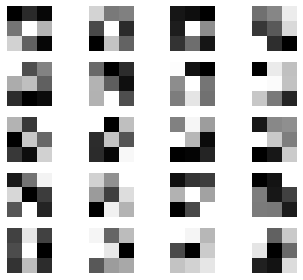

average of absolute gradients 1 tensor(4.2484e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8418e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1859e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7907e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7504e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5986e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2164e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5212e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3453e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8789e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1357e-06, device='cuda:0')


 44%|██████████████████████████████████▌                                            | 438/1000 [36:38<46:55,  5.01s/it]

Epoch: 438
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2039, -0.1307, -0.1903],
         [ 0.0012,  0.2415,  0.1128],
         [ 0.1623, -0.0321, -0.1924]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


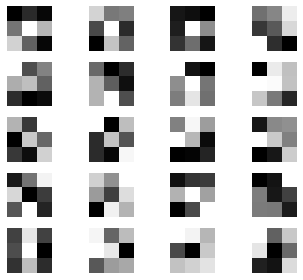

average of absolute gradients 1 tensor(3.6671e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3813e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0374e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3853e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6713e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6458e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4803e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5554e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6830e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4868e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7825e-06, device='cuda:0')


 44%|██████████████████████████████████▋                                            | 439/1000 [36:43<46:43,  5.00s/it]

Epoch: 439
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2047, -0.1312, -0.1912],
         [ 0.0004,  0.2406,  0.1116],
         [ 0.1613, -0.0324, -0.1925]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


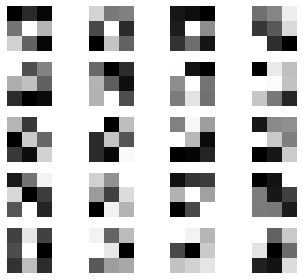

average of absolute gradients 1 tensor(5.1642e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9323e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1868e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4073e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0982e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8175e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0072e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5969e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0568e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7704e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8172e-06, device='cuda:0')


 44%|██████████████████████████████████▊                                            | 440/1000 [36:48<46:37,  5.00s/it]

Epoch: 440
Accuracy of train set: 19%
Accuracy of test set: 8%

tensor([[[-2.0428e-01, -1.2965e-01, -1.9039e-01],
         [-8.4640e-05,  2.4181e-01,  1.1271e-01],
         [ 1.6134e-01, -3.1872e-02, -1.9233e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


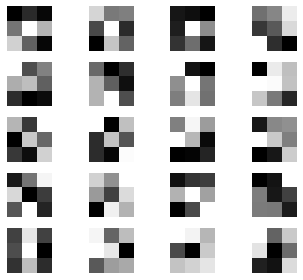

average of absolute gradients 1 tensor(4.9156e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3836e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5084e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1204e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1936e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5300e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9812e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6405e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6181e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0406e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8235e-06, device='cuda:0')


 44%|██████████████████████████████████▊                                            | 441/1000 [36:53<46:27,  4.99s/it]

Epoch: 441
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2038, -0.1301, -0.1899],
         [ 0.0005,  0.2419,  0.1136],
         [ 0.1616, -0.0328, -0.1917]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


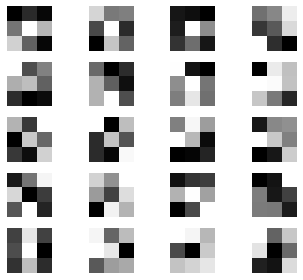

average of absolute gradients 1 tensor(5.0570e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0530e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8205e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8637e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5201e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3049e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6405e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7795e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6490e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3622e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8192e-06, device='cuda:0')


 44%|██████████████████████████████████▉                                            | 442/1000 [36:58<46:23,  4.99s/it]

Epoch: 442
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2038, -0.1300, -0.1903],
         [-0.0005,  0.2418,  0.1134],
         [ 0.1619, -0.0322, -0.1911]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


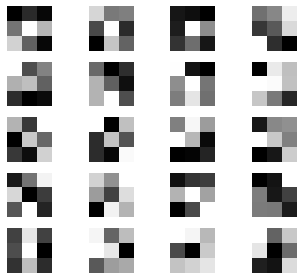

average of absolute gradients 1 tensor(4.0794e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7616e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3770e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3367e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3713e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8207e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8240e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8787e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4710e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2570e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7741e-06, device='cuda:0')


 44%|██████████████████████████████████▉                                            | 443/1000 [37:03<46:19,  4.99s/it]

Epoch: 443
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-2.0442e-01, -1.3042e-01, -1.9112e-01],
         [ 1.2945e-04,  2.4022e-01,  1.1311e-01],
         [ 1.6165e-01, -3.1974e-02, -1.9138e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


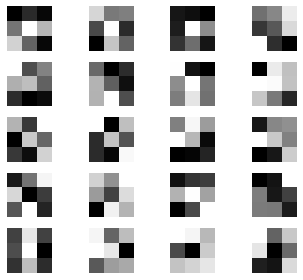

average of absolute gradients 1 tensor(3.1191e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8319e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9551e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0385e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4460e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7776e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5964e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3527e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3869e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0297e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5255e-06, device='cuda:0')


 44%|███████████████████████████████████                                            | 444/1000 [37:08<46:10,  4.98s/it]

Epoch: 444
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-2.0394e-01, -1.2965e-01, -1.9078e-01],
         [ 1.4051e-04,  2.4087e-01,  1.1331e-01],
         [ 1.6262e-01, -3.1680e-02, -1.9069e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


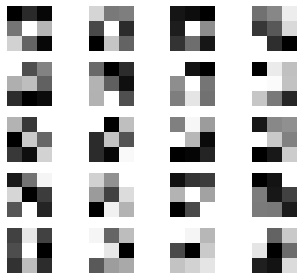

average of absolute gradients 1 tensor(3.7326e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2902e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3199e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9879e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3946e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6288e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2276e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7464e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2774e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1780e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6911e-06, device='cuda:0')


 44%|███████████████████████████████████▏                                           | 445/1000 [37:13<46:06,  4.99s/it]

Epoch: 445
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-2.0410e-01, -1.3039e-01, -1.9107e-01],
         [-2.1538e-05,  2.4011e-01,  1.1324e-01],
         [ 1.6207e-01, -3.1776e-02, -1.9082e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


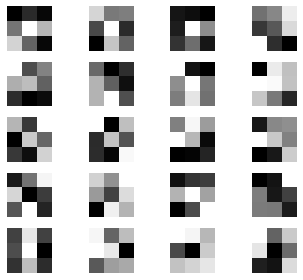

average of absolute gradients 1 tensor(3.3300e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0907e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9975e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2468e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5019e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3650e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0261e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8456e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3766e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4569e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6212e-06, device='cuda:0')


 45%|███████████████████████████████████▏                                           | 446/1000 [37:18<45:59,  4.98s/it]

Epoch: 446
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-2.0404e-01, -1.3005e-01, -1.9113e-01],
         [ 4.7310e-05,  2.4016e-01,  1.1313e-01],
         [ 1.6226e-01, -3.1339e-02, -1.9060e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


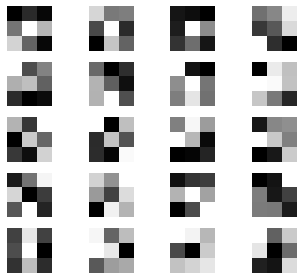

average of absolute gradients 1 tensor(4.2132e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1495e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0688e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5870e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2390e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6498e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8701e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9652e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8470e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1818e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0736e-06, device='cuda:0')


 45%|███████████████████████████████████▎                                           | 447/1000 [37:23<45:54,  4.98s/it]

Epoch: 447
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2040, -0.1299, -0.1912],
         [ 0.0003,  0.2403,  0.1133],
         [ 0.1621, -0.0312, -0.1903]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


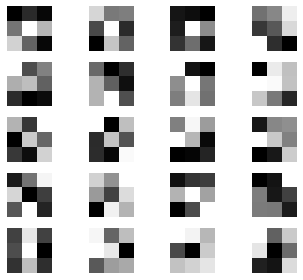

average of absolute gradients 1 tensor(3.1679e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8736e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9341e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3628e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8952e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2749e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4362e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9327e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0123e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4816e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6239e-06, device='cuda:0')


 45%|███████████████████████████████████▍                                           | 448/1000 [37:28<45:57,  5.00s/it]

Epoch: 448
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-2.0390e-01, -1.2988e-01, -1.9071e-01],
         [-1.0015e-04,  2.3998e-01,  1.1362e-01],
         [ 1.6274e-01, -3.0945e-02, -1.9017e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


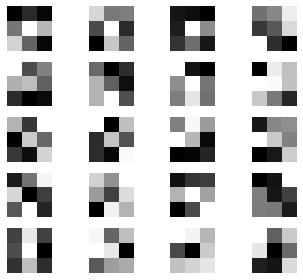

average of absolute gradients 1 tensor(3.9347e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4212e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1406e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0775e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5511e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8817e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2456e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0975e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3495e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2648e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6959e-06, device='cuda:0')


 45%|███████████████████████████████████▍                                           | 449/1000 [37:33<45:53,  5.00s/it]

Epoch: 449
Accuracy of train set: 19%
Accuracy of test set: 8%

tensor([[[-0.2039, -0.1301, -0.1910],
         [ 0.0006,  0.2397,  0.1135],
         [ 0.1628, -0.0307, -0.1898]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


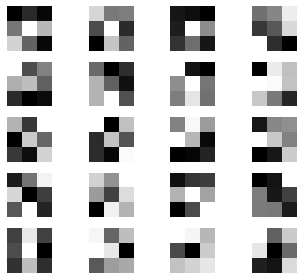

average of absolute gradients 1 tensor(3.2316e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7635e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3352e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7344e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7637e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2373e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6001e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9150e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5302e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2706e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7172e-06, device='cuda:0')


 45%|███████████████████████████████████▌                                           | 450/1000 [37:38<45:44,  4.99s/it]

Epoch: 450
Accuracy of train set: 19%
Accuracy of test set: 8%

tensor([[[-0.2045, -0.1301, -0.1916],
         [ 0.0005,  0.2389,  0.1129],
         [ 0.1626, -0.0306, -0.1898]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


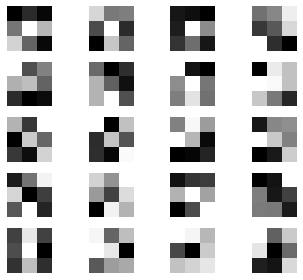

average of absolute gradients 1 tensor(4.5250e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9761e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1446e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3834e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9681e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3584e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2506e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5867e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9608e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9292e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7965e-06, device='cuda:0')


 45%|███████████████████████████████████▋                                           | 451/1000 [37:43<45:41,  4.99s/it]

Epoch: 451
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2038, -0.1301, -0.1910],
         [ 0.0003,  0.2396,  0.1136],
         [ 0.1625, -0.0303, -0.1896]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


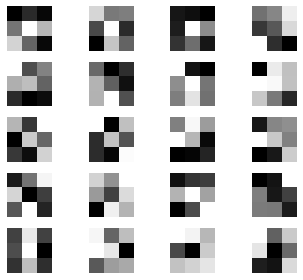

average of absolute gradients 1 tensor(3.8583e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1080e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2607e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4055e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4323e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4653e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0264e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8910e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9741e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6027e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1295e-06, device='cuda:0')


 45%|███████████████████████████████████▋                                           | 452/1000 [37:48<45:32,  4.99s/it]

Epoch: 452
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2039, -0.1295, -0.1910],
         [ 0.0003,  0.2399,  0.1131],
         [ 0.1624, -0.0302, -0.1896]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


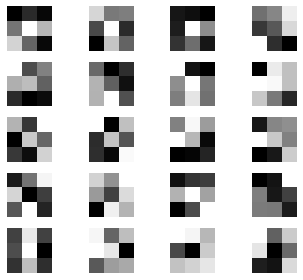

average of absolute gradients 1 tensor(4.5529e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1919e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0232e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8786e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8999e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2307e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8762e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7164e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9068e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5627e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0843e-06, device='cuda:0')


 45%|███████████████████████████████████▊                                           | 453/1000 [37:53<45:27,  4.99s/it]

Epoch: 453
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2037, -0.1299, -0.1907],
         [ 0.0009,  0.2398,  0.1132],
         [ 0.1624, -0.0309, -0.1894]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


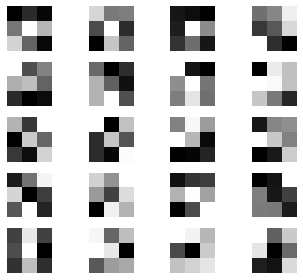

average of absolute gradients 1 tensor(3.5050e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0035e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1098e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2040e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1658e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4541e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2423e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8994e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5705e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5687e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9406e-06, device='cuda:0')


 45%|███████████████████████████████████▊                                           | 454/1000 [37:58<45:20,  4.98s/it]

Epoch: 454
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2040, -0.1297, -0.1907],
         [ 0.0006,  0.2393,  0.1134],
         [ 0.1624, -0.0311, -0.1894]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


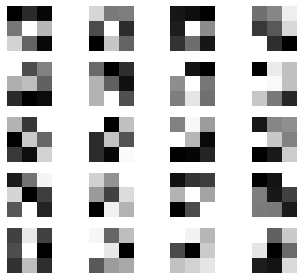

average of absolute gradients 1 tensor(3.6022e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2814e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2827e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3653e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8116e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3735e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7747e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4005e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1542e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5206e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8066e-06, device='cuda:0')


 46%|███████████████████████████████████▉                                           | 455/1000 [38:03<45:23,  5.00s/it]

Epoch: 455
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2040, -0.1298, -0.1909],
         [ 0.0008,  0.2390,  0.1132],
         [ 0.1624, -0.0315, -0.1891]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


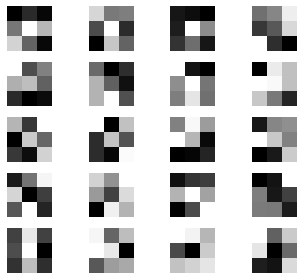

average of absolute gradients 1 tensor(3.5138e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9771e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1082e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9614e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4667e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1719e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0814e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9550e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9485e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0132e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9211e-06, device='cuda:0')


 46%|████████████████████████████████████                                           | 456/1000 [38:08<45:14,  4.99s/it]

Epoch: 456
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2041, -0.1300, -0.1906],
         [ 0.0012,  0.2389,  0.1135],
         [ 0.1621, -0.0316, -0.1891]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


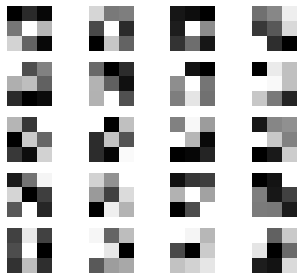

average of absolute gradients 1 tensor(3.2161e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4843e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9819e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2793e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1917e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9817e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8299e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0866e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4556e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5735e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7103e-06, device='cuda:0')


 46%|████████████████████████████████████                                           | 457/1000 [38:13<45:04,  4.98s/it]

Epoch: 457
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2040, -0.1300, -0.1905],
         [ 0.0011,  0.2387,  0.1137],
         [ 0.1623, -0.0313, -0.1890]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


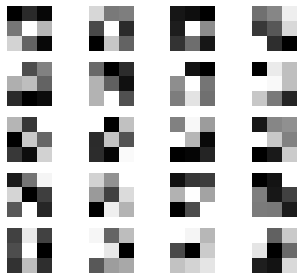

average of absolute gradients 1 tensor(3.5061e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5208e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0755e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0037e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8431e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2985e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3023e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2174e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4581e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7548e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8333e-06, device='cuda:0')


 46%|████████████████████████████████████▏                                          | 458/1000 [38:18<44:55,  4.97s/it]

Epoch: 458
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2042, -0.1295, -0.1909],
         [ 0.0011,  0.2389,  0.1140],
         [ 0.1614, -0.0309, -0.1887]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


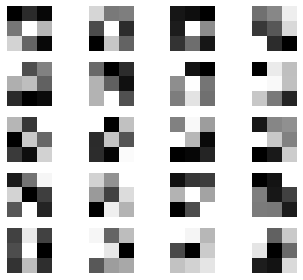

average of absolute gradients 1 tensor(3.3493e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1640e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5631e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3900e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3608e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9353e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9826e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4436e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3845e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2997e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1494e-06, device='cuda:0')


 46%|████████████████████████████████████▎                                          | 459/1000 [38:23<44:52,  4.98s/it]

Epoch: 459
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2044, -0.1290, -0.1910],
         [ 0.0011,  0.2385,  0.1140],
         [ 0.1622, -0.0305, -0.1883]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


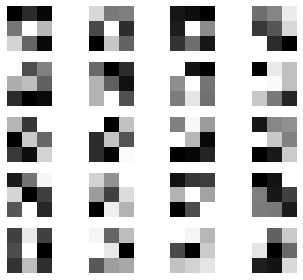

average of absolute gradients 1 tensor(4.5681e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9712e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0184e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1118e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3236e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9285e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4419e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9691e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8110e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1280e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4795e-06, device='cuda:0')


 46%|████████████████████████████████████▎                                          | 460/1000 [38:28<44:58,  5.00s/it]

Epoch: 460
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2048, -0.1292, -0.1913],
         [ 0.0006,  0.2373,  0.1140],
         [ 0.1623, -0.0309, -0.1884]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


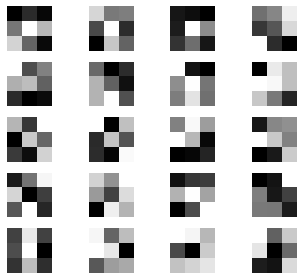

average of absolute gradients 1 tensor(2.9012e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2093e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0080e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3433e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9160e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0966e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1543e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8315e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1941e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0536e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3004e-06, device='cuda:0')


 46%|████████████████████████████████████▍                                          | 461/1000 [38:33<45:00,  5.01s/it]

Epoch: 461
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2047, -0.1292, -0.1911],
         [ 0.0007,  0.2376,  0.1139],
         [ 0.1622, -0.0302, -0.1882]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


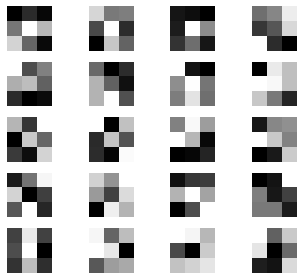

average of absolute gradients 1 tensor(3.1696e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0509e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0898e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0664e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1932e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7748e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1777e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5490e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1759e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5191e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3080e-06, device='cuda:0')


 46%|████████████████████████████████████▍                                          | 462/1000 [38:38<44:52,  5.00s/it]

Epoch: 462
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2045, -0.1295, -0.1914],
         [ 0.0014,  0.2368,  0.1136],
         [ 0.1628, -0.0306, -0.1882]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


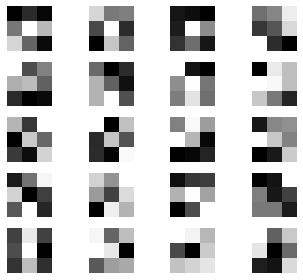

average of absolute gradients 1 tensor(3.4841e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2143e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2169e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3514e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9914e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8422e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0869e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5796e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9865e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9057e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6129e-06, device='cuda:0')


 46%|████████████████████████████████████▌                                          | 463/1000 [38:43<44:40,  4.99s/it]

Epoch: 463
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2044, -0.1290, -0.1910],
         [ 0.0016,  0.2370,  0.1139],
         [ 0.1633, -0.0300, -0.1879]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


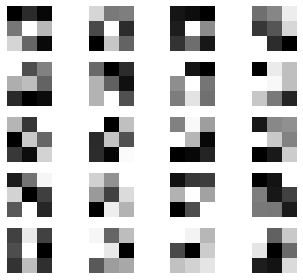

average of absolute gradients 1 tensor(3.0534e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1729e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9690e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7904e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0329e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2456e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2587e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7509e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5041e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4916e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8388e-06, device='cuda:0')


 46%|████████████████████████████████████▋                                          | 464/1000 [38:48<44:34,  4.99s/it]

Epoch: 464
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2044, -0.1293, -0.1910],
         [ 0.0016,  0.2369,  0.1133],
         [ 0.1634, -0.0303, -0.1878]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


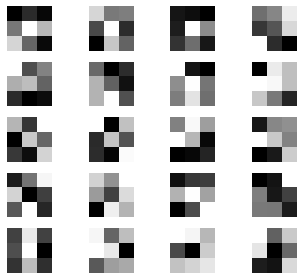

average of absolute gradients 1 tensor(3.4979e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8350e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5867e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9438e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9821e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0420e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7891e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7719e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1219e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1388e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1302e-06, device='cuda:0')


 46%|████████████████████████████████████▋                                          | 465/1000 [38:53<44:25,  4.98s/it]

Epoch: 465
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2042, -0.1295, -0.1910],
         [ 0.0023,  0.2368,  0.1131],
         [ 0.1632, -0.0304, -0.1878]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


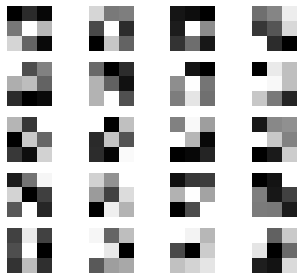

average of absolute gradients 1 tensor(3.3485e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8804e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9780e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5142e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8960e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8142e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9503e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4826e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7392e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6824e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8323e-06, device='cuda:0')


 47%|████████████████████████████████████▊                                          | 466/1000 [38:58<44:17,  4.98s/it]

Epoch: 466
Accuracy of train set: 19%
Accuracy of test set: 8%

tensor([[[-0.2043, -0.1294, -0.1909],
         [ 0.0021,  0.2367,  0.1123],
         [ 0.1635, -0.0302, -0.1881]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


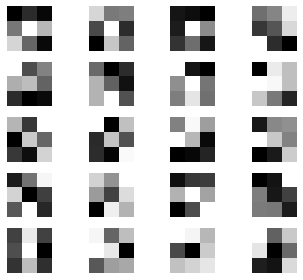

average of absolute gradients 1 tensor(2.9646e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5387e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1563e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6692e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3172e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9577e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4739e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1841e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6191e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8270e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9256e-06, device='cuda:0')


 47%|████████████████████████████████████▉                                          | 467/1000 [39:03<44:10,  4.97s/it]

Epoch: 467
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2037, -0.1291, -0.1907],
         [ 0.0022,  0.2372,  0.1132],
         [ 0.1634, -0.0299, -0.1876]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


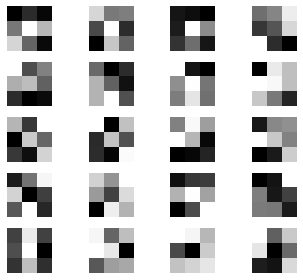

average of absolute gradients 1 tensor(3.1772e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3817e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3023e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4431e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2128e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0443e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2096e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1650e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1265e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0206e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3901e-06, device='cuda:0')


 47%|████████████████████████████████████▉                                          | 468/1000 [39:08<44:00,  4.96s/it]

Epoch: 468
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2041, -0.1296, -0.1910],
         [ 0.0023,  0.2361,  0.1130],
         [ 0.1632, -0.0299, -0.1879]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


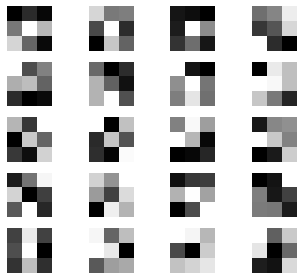

average of absolute gradients 1 tensor(3.0876e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4248e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3509e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1407e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1862e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8197e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6782e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9337e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2786e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6178e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0923e-06, device='cuda:0')


 47%|█████████████████████████████████████                                          | 469/1000 [39:13<44:00,  4.97s/it]

Epoch: 469
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2038, -0.1296, -0.1909],
         [ 0.0022,  0.2363,  0.1135],
         [ 0.1631, -0.0299, -0.1877]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


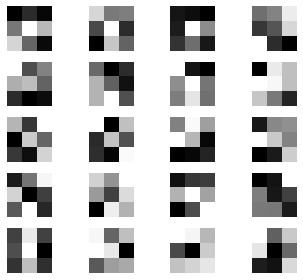

average of absolute gradients 1 tensor(4.1437e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5325e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1857e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6017e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6654e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0960e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3550e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2797e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1473e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1723e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0502e-06, device='cuda:0')


 47%|█████████████████████████████████████▏                                         | 470/1000 [39:18<44:02,  4.99s/it]

Epoch: 470
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2037, -0.1292, -0.1910],
         [ 0.0019,  0.2360,  0.1135],
         [ 0.1631, -0.0299, -0.1878]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


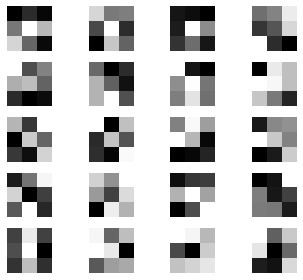

average of absolute gradients 1 tensor(3.4391e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9278e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4117e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5174e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1445e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2959e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4543e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5404e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5805e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9950e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5262e-06, device='cuda:0')


 47%|█████████████████████████████████████▏                                         | 471/1000 [39:23<43:57,  4.99s/it]

Epoch: 471
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2037, -0.1290, -0.1914],
         [ 0.0015,  0.2357,  0.1133],
         [ 0.1632, -0.0293, -0.1878]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


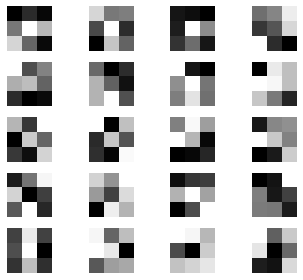

average of absolute gradients 1 tensor(3.0444e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0462e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9807e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3110e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5601e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4082e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2688e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0807e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6691e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8882e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1105e-06, device='cuda:0')


 47%|█████████████████████████████████████▎                                         | 472/1000 [39:28<43:57,  5.00s/it]

Epoch: 472
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2035, -0.1292, -0.1912],
         [ 0.0011,  0.2357,  0.1135],
         [ 0.1634, -0.0299, -0.1874]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


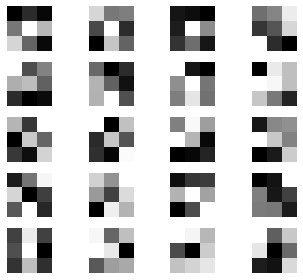

average of absolute gradients 1 tensor(3.3461e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0719e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4606e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6272e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4015e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4973e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9819e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6259e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5794e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3723e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5028e-06, device='cuda:0')


 47%|█████████████████████████████████████▎                                         | 473/1000 [39:32<43:48,  4.99s/it]

Epoch: 473
Accuracy of train set: 19%
Accuracy of test set: 9%

tensor([[[-0.2031, -0.1291, -0.1909],
         [ 0.0010,  0.2361,  0.1132],
         [ 0.1636, -0.0297, -0.1874]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


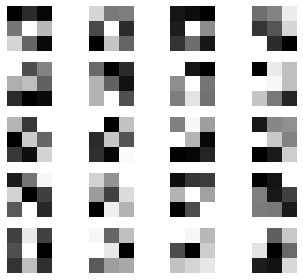

average of absolute gradients 1 tensor(4.2153e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7966e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1538e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9959e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3374e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8855e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5293e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4814e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7266e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9120e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2790e-06, device='cuda:0')


 47%|█████████████████████████████████████▍                                         | 474/1000 [39:38<43:45,  4.99s/it]

Epoch: 474
Accuracy of train set: 20%
Accuracy of test set: 8%

tensor([[[-0.2027, -0.1296, -0.1909],
         [ 0.0011,  0.2357,  0.1133],
         [ 0.1633, -0.0299, -0.1878]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


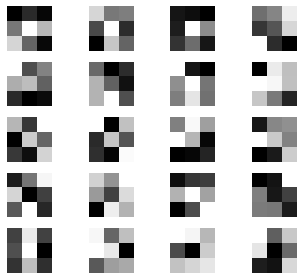

average of absolute gradients 1 tensor(3.6391e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6642e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9675e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3209e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5874e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9487e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1058e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8633e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0315e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2888e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9252e-06, device='cuda:0')


 48%|█████████████████████████████████████▌                                         | 475/1000 [39:42<43:40,  4.99s/it]

Epoch: 475
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2025, -0.1295, -0.1909],
         [ 0.0014,  0.2360,  0.1130],
         [ 0.1632, -0.0296, -0.1877]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


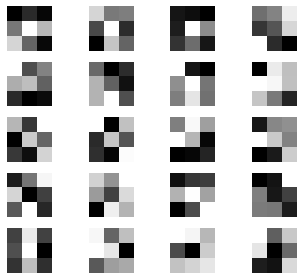

average of absolute gradients 1 tensor(4.7276e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6433e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2462e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4518e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6859e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8159e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7487e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1242e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6667e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1847e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3711e-06, device='cuda:0')


 48%|█████████████████████████████████████▌                                         | 476/1000 [39:47<43:30,  4.98s/it]

Epoch: 476
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2019, -0.1293, -0.1907],
         [ 0.0016,  0.2368,  0.1134],
         [ 0.1631, -0.0291, -0.1874]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


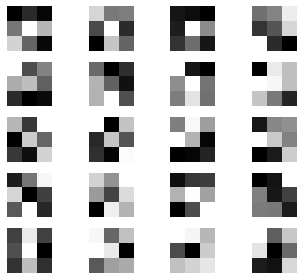

average of absolute gradients 1 tensor(4.1383e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3326e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1133e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6526e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6241e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2044e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2871e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5087e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2129e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0884e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4267e-06, device='cuda:0')


 48%|█████████████████████████████████████▋                                         | 477/1000 [39:52<43:23,  4.98s/it]

Epoch: 477
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2017, -0.1304, -0.1908],
         [ 0.0019,  0.2360,  0.1127],
         [ 0.1630, -0.0310, -0.1875]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


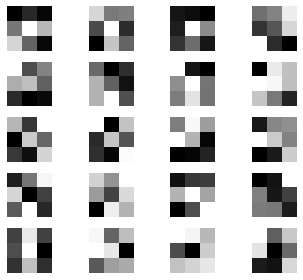

average of absolute gradients 1 tensor(5.4791e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8088e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5860e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7802e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4575e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5044e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6635e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3881e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5136e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8017e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3645e-06, device='cuda:0')


 48%|█████████████████████████████████████▊                                         | 478/1000 [39:57<43:18,  4.98s/it]

Epoch: 478
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2016, -0.1309, -0.1905],
         [ 0.0014,  0.2365,  0.1123],
         [ 0.1621, -0.0310, -0.1875]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


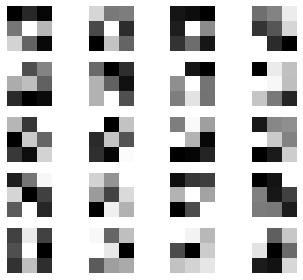

average of absolute gradients 1 tensor(4.6852e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3626e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4504e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9288e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9347e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8236e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7100e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0150e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3465e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6664e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2215e-06, device='cuda:0')


 48%|█████████████████████████████████████▊                                         | 479/1000 [40:02<43:19,  4.99s/it]

Epoch: 479
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2018, -0.1314, -0.1909],
         [ 0.0011,  0.2368,  0.1119],
         [ 0.1608, -0.0308, -0.1874]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


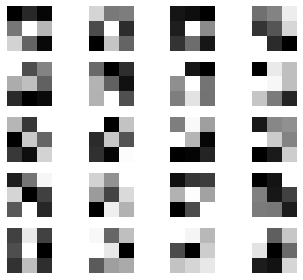

average of absolute gradients 1 tensor(3.9307e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9717e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8286e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1336e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0873e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2103e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4634e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1921e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8145e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4449e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1698e-06, device='cuda:0')


 48%|█████████████████████████████████████▉                                         | 480/1000 [40:07<43:14,  4.99s/it]

Epoch: 480
Accuracy of train set: 20%
Accuracy of test set: 8%

tensor([[[-2.0164e-01, -1.3122e-01, -1.9054e-01],
         [ 1.5994e-04,  2.3667e-01,  1.1117e-01],
         [ 1.6179e-01, -3.0636e-02, -1.8744e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


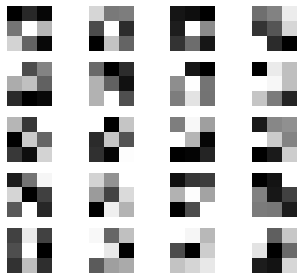

average of absolute gradients 1 tensor(5.2493e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1309e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2742e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9015e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0403e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4385e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1328e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7629e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1208e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1688e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5240e-06, device='cuda:0')


 48%|█████████████████████████████████████▉                                         | 481/1000 [40:12<43:08,  4.99s/it]

Epoch: 481
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2020, -0.1314, -0.1903],
         [ 0.0010,  0.2365,  0.1117],
         [ 0.1613, -0.0300, -0.1873]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


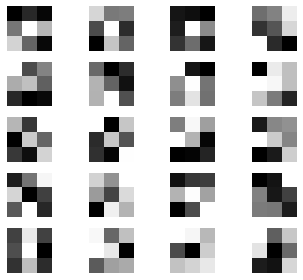

average of absolute gradients 1 tensor(5.7537e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9112e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9336e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4459e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7108e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6608e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5312e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4175e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0864e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3655e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9252e-06, device='cuda:0')


 48%|██████████████████████████████████████                                         | 482/1000 [40:17<43:00,  4.98s/it]

Epoch: 482
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2019, -0.1324, -0.1909],
         [ 0.0006,  0.2353,  0.1108],
         [ 0.1614, -0.0301, -0.1877]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


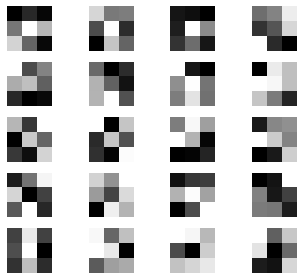

average of absolute gradients 1 tensor(4.5804e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6113e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2446e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1300e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8989e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7095e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5443e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1168e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4821e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3039e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2825e-06, device='cuda:0')


 48%|██████████████████████████████████████▏                                        | 483/1000 [40:22<43:00,  4.99s/it]

Epoch: 483
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2013, -0.1319, -0.1905],
         [ 0.0007,  0.2358,  0.1116],
         [ 0.1616, -0.0294, -0.1875]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


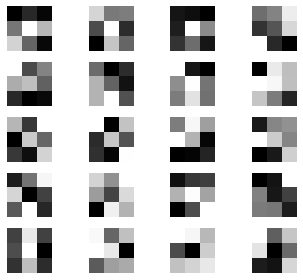

average of absolute gradients 1 tensor(3.9705e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5453e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1039e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0536e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6792e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7162e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6240e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7304e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1433e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3210e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4995e-06, device='cuda:0')


 48%|██████████████████████████████████████▏                                        | 484/1000 [40:27<42:59,  5.00s/it]

Epoch: 484
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-2.0166e-01, -1.3236e-01, -1.9107e-01],
         [-2.4956e-05,  2.3510e-01,  1.1074e-01],
         [ 1.6140e-01, -2.9566e-02, -1.8753e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


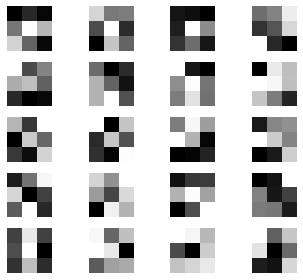

average of absolute gradients 1 tensor(3.9151e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5252e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4986e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5482e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7797e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4893e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7726e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6299e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3781e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7393e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1544e-06, device='cuda:0')


 48%|██████████████████████████████████████▎                                        | 485/1000 [40:32<43:03,  5.02s/it]

Epoch: 485
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2019, -0.1324, -0.1912],
         [ 0.0002,  0.2348,  0.1110],
         [ 0.1609, -0.0292, -0.1874]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


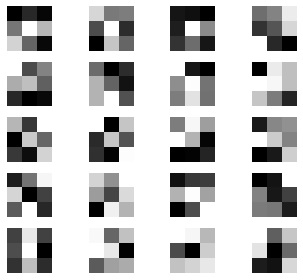

average of absolute gradients 1 tensor(4.7612e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9189e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5386e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1063e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4833e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1136e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8508e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1838e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7579e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4468e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9968e-06, device='cuda:0')


 49%|██████████████████████████████████████▍                                        | 486/1000 [40:37<42:56,  5.01s/it]

Epoch: 486
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-2.0224e-01, -1.3230e-01, -1.9143e-01],
         [ 1.1647e-04,  2.3490e-01,  1.1098e-01],
         [ 1.6030e-01, -2.9220e-02, -1.8706e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


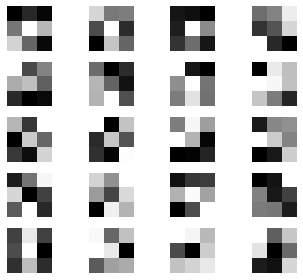

average of absolute gradients 1 tensor(3.7557e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8067e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0116e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3136e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9556e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9362e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6417e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6317e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6876e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6923e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0600e-06, device='cuda:0')


 49%|██████████████████████████████████████▍                                        | 487/1000 [40:42<42:44,  5.00s/it]

Epoch: 487
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2025, -0.1317, -0.1910],
         [-0.0003,  0.2346,  0.1109],
         [ 0.1610, -0.0296, -0.1871]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


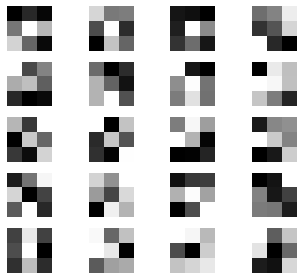

average of absolute gradients 1 tensor(4.7558e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6627e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6669e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7032e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8404e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2660e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8658e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4936e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0423e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1734e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1078e-06, device='cuda:0')


 49%|██████████████████████████████████████▌                                        | 488/1000 [40:47<42:48,  5.02s/it]

Epoch: 488
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2030, -0.1311, -0.1921],
         [-0.0008,  0.2339,  0.1107],
         [ 0.1602, -0.0299, -0.1872]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


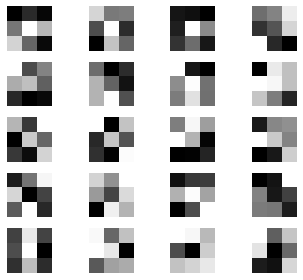

average of absolute gradients 1 tensor(4.2002e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0472e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1010e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3931e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0559e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2994e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0924e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9725e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5359e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7930e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2482e-06, device='cuda:0')


 49%|██████████████████████████████████████▋                                        | 489/1000 [40:53<43:00,  5.05s/it]

Epoch: 489
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2020, -0.1308, -0.1918],
         [-0.0003,  0.2344,  0.1115],
         [ 0.1601, -0.0307, -0.1872]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


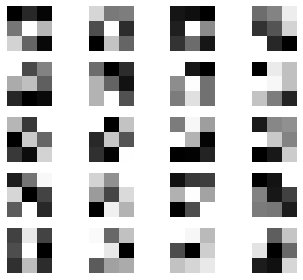

average of absolute gradients 1 tensor(4.6093e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1269e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5534e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8709e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1496e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6335e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9550e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1684e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7226e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6795e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1107e-06, device='cuda:0')


 49%|██████████████████████████████████████▋                                        | 490/1000 [40:58<42:53,  5.05s/it]

Epoch: 490
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2018, -0.1300, -0.1918],
         [-0.0009,  0.2348,  0.1124],
         [ 0.1592, -0.0304, -0.1875]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


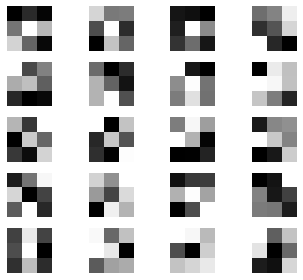

average of absolute gradients 1 tensor(5.2162e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6445e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9800e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2067e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8291e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6372e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1156e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9625e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4639e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3698e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2428e-06, device='cuda:0')


 49%|██████████████████████████████████████▊                                        | 491/1000 [41:03<42:38,  5.03s/it]

Epoch: 491
Accuracy of train set: 20%
Accuracy of test set: 8%

tensor([[[-0.2017, -0.1300, -0.1923],
         [-0.0011,  0.2344,  0.1119],
         [ 0.1593, -0.0302, -0.1876]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


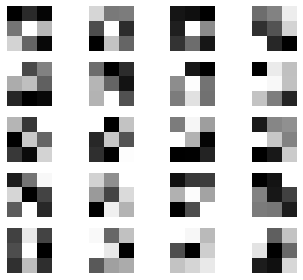

average of absolute gradients 1 tensor(4.5603e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7467e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0237e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1729e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3953e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7618e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2381e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9455e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6021e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1611e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2640e-06, device='cuda:0')


 49%|██████████████████████████████████████▊                                        | 492/1000 [41:08<42:52,  5.06s/it]

Epoch: 492
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2018, -0.1306, -0.1919],
         [-0.0011,  0.2341,  0.1123],
         [ 0.1588, -0.0303, -0.1876]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


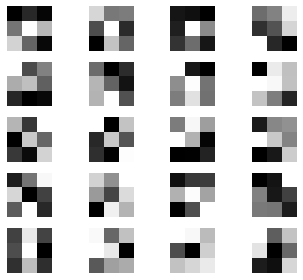

average of absolute gradients 1 tensor(4.1753e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2477e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6913e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5293e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8987e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3584e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7890e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4232e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2146e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9043e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1233e-06, device='cuda:0')


 49%|██████████████████████████████████████▉                                        | 493/1000 [41:13<42:43,  5.06s/it]

Epoch: 493
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-2.0150e-01, -1.3028e-01, -1.9160e-01],
         [-1.6477e-04,  2.3442e-01,  1.1339e-01],
         [ 1.5896e-01, -3.0069e-02, -1.8705e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


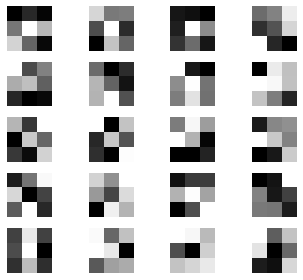

average of absolute gradients 1 tensor(4.2122e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5156e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6478e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6091e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5988e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1783e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3407e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6584e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3672e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9577e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3532e-06, device='cuda:0')


 49%|███████████████████████████████████████                                        | 494/1000 [41:18<42:35,  5.05s/it]

Epoch: 494
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-2.0138e-01, -1.3117e-01, -1.9144e-01],
         [ 1.9097e-04,  2.3374e-01,  1.1356e-01],
         [ 1.5911e-01, -3.0271e-02, -1.8699e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


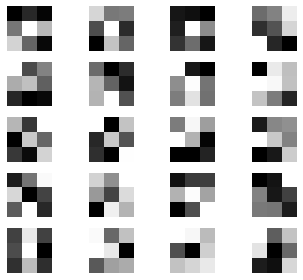

average of absolute gradients 1 tensor(4.2104e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1989e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2429e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3972e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0569e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8713e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6060e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2954e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2986e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4651e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2843e-06, device='cuda:0')


 50%|███████████████████████████████████████                                        | 495/1000 [41:23<42:25,  5.04s/it]

Epoch: 495
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-2.0158e-01, -1.3083e-01, -1.9130e-01],
         [-2.2879e-04,  2.3371e-01,  1.1368e-01],
         [ 1.5905e-01, -3.0304e-02, -1.8685e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


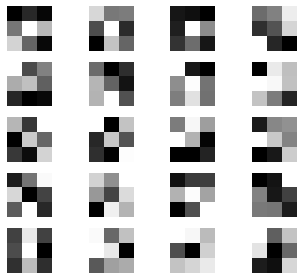

average of absolute gradients 1 tensor(4.9777e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7567e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2091e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6757e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5688e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5841e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4959e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2307e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0239e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4194e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0740e-06, device='cuda:0')


 50%|███████████████████████████████████████▏                                       | 496/1000 [41:28<42:24,  5.05s/it]

Epoch: 496
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-2.0192e-01, -1.3110e-01, -1.9108e-01],
         [ 1.3503e-04,  2.3312e-01,  1.1339e-01],
         [ 1.5922e-01, -3.0145e-02, -1.8701e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


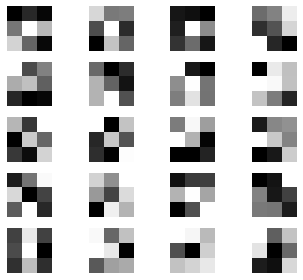

average of absolute gradients 1 tensor(4.3984e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2939e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3513e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9812e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3832e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6150e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7878e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4199e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4621e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7436e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6296e-06, device='cuda:0')


 50%|███████████████████████████████████████▎                                       | 497/1000 [41:33<42:22,  5.05s/it]

Epoch: 497
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2017, -0.1306, -0.1904],
         [ 0.0010,  0.2334,  0.1145],
         [ 0.1596, -0.0296, -0.1868]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


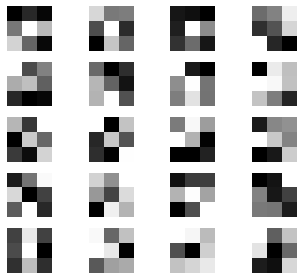

average of absolute gradients 1 tensor(4.5454e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3420e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1280e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7253e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5655e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3249e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6738e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4208e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9919e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3979e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0843e-06, device='cuda:0')


 50%|███████████████████████████████████████▎                                       | 498/1000 [41:38<42:12,  5.04s/it]

Epoch: 498
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-2.0240e-01, -1.3145e-01, -1.9128e-01],
         [ 1.8696e-04,  2.3219e-01,  1.1287e-01],
         [ 1.5867e-01, -2.9752e-02, -1.8742e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


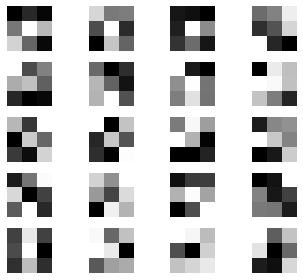

average of absolute gradients 1 tensor(4.8136e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4393e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8883e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4746e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3759e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0279e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0823e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0035e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6811e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3418e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4618e-06, device='cuda:0')


 50%|███████████████████████████████████████▍                                       | 499/1000 [41:43<42:02,  5.04s/it]

Epoch: 499
Accuracy of train set: 20%
Accuracy of test set: 8%

tensor([[[-0.2024, -0.1305, -0.1909],
         [ 0.0009,  0.2326,  0.1131],
         [ 0.1591, -0.0297, -0.1872]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


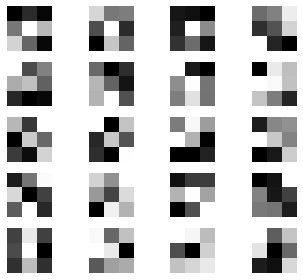

average of absolute gradients 1 tensor(3.9882e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6089e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1177e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7676e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5698e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6144e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1762e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0211e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9357e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8829e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8615e-06, device='cuda:0')


 50%|███████████████████████████████████████▌                                       | 500/1000 [41:48<41:54,  5.03s/it]

Epoch: 500
Accuracy of train set: 20%
Accuracy of test set: 8%

tensor([[[-0.2023, -0.1302, -0.1903],
         [ 0.0010,  0.2330,  0.1136],
         [ 0.1591, -0.0300, -0.1869]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


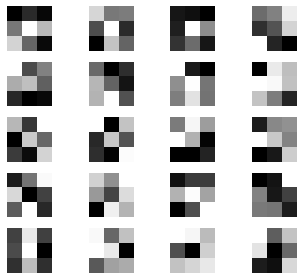

average of absolute gradients 1 tensor(4.4187e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8325e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7936e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4310e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5850e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6866e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5954e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0186e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3550e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3908e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4711e-06, device='cuda:0')


 50%|███████████████████████████████████████▌                                       | 501/1000 [41:53<41:55,  5.04s/it]

Epoch: 501
Accuracy of train set: 20%
Accuracy of test set: 8%

tensor([[[-0.2027, -0.1303, -0.1902],
         [ 0.0007,  0.2332,  0.1139],
         [ 0.1574, -0.0301, -0.1873]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


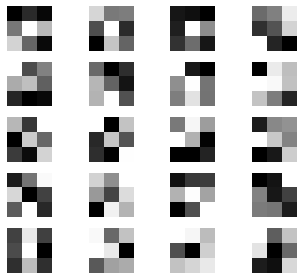

average of absolute gradients 1 tensor(5.3602e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9263e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4208e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2129e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3351e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7106e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8983e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1258e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8798e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2867e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9457e-06, device='cuda:0')


 50%|███████████████████████████████████████▋                                       | 502/1000 [41:58<41:41,  5.02s/it]

Epoch: 502
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2030, -0.1297, -0.1902],
         [ 0.0008,  0.2326,  0.1137],
         [ 0.1580, -0.0297, -0.1874]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


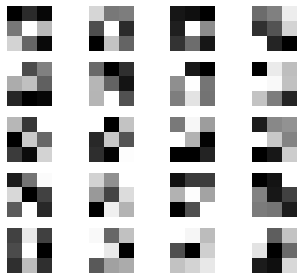

average of absolute gradients 1 tensor(3.6363e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4945e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7331e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2785e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6528e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3477e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5101e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1264e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1060e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7421e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1878e-06, device='cuda:0')


 50%|███████████████████████████████████████▋                                       | 503/1000 [42:03<41:35,  5.02s/it]

Epoch: 503
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2030, -0.1300, -0.1901],
         [ 0.0004,  0.2323,  0.1138],
         [ 0.1584, -0.0293, -0.1871]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


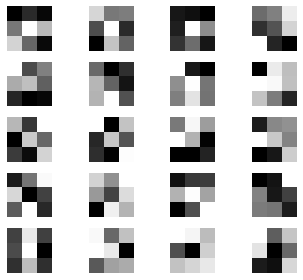

average of absolute gradients 1 tensor(3.0881e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8771e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2067e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8504e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2998e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6857e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0890e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6698e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2847e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1260e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4979e-06, device='cuda:0')


 50%|███████████████████████████████████████▊                                       | 504/1000 [42:08<41:34,  5.03s/it]

Epoch: 504
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2027, -0.1298, -0.1904],
         [ 0.0005,  0.2321,  0.1140],
         [ 0.1587, -0.0292, -0.1868]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


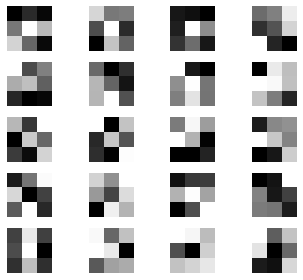

average of absolute gradients 1 tensor(3.7264e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1210e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8121e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1953e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7575e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8406e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4874e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1634e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8973e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8139e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6994e-06, device='cuda:0')


 50%|███████████████████████████████████████▉                                       | 505/1000 [42:13<41:33,  5.04s/it]

Epoch: 505
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2026, -0.1300, -0.1902],
         [ 0.0003,  0.2318,  0.1139],
         [ 0.1592, -0.0295, -0.1865]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


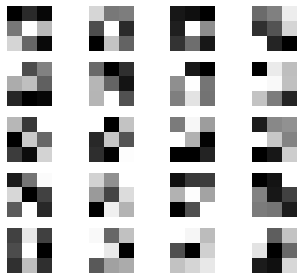

average of absolute gradients 1 tensor(3.6666e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3252e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8423e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0899e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4554e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2019e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2773e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2850e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7962e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5498e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2501e-06, device='cuda:0')


 51%|███████████████████████████████████████▉                                       | 506/1000 [42:18<41:30,  5.04s/it]

Epoch: 506
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-2.0268e-01, -1.2993e-01, -1.9048e-01],
         [ 1.8140e-04,  2.3165e-01,  1.1362e-01],
         [ 1.5895e-01, -2.9464e-02, -1.8652e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


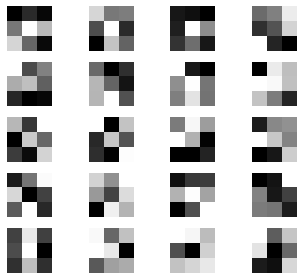

average of absolute gradients 1 tensor(3.5689e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9225e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7564e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5101e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2019e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7296e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7486e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2098e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5129e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3406e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2778e-06, device='cuda:0')


 51%|████████████████████████████████████████                                       | 507/1000 [42:23<41:21,  5.03s/it]

Epoch: 507
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2028, -0.1303, -0.1903],
         [-0.0002,  0.2315,  0.1132],
         [ 0.1587, -0.0293, -0.1866]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


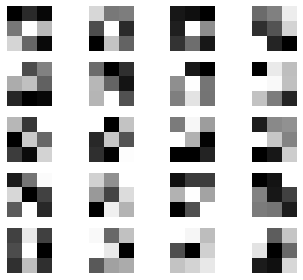

average of absolute gradients 1 tensor(4.1064e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3531e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2167e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5672e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5193e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2204e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1183e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7803e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9454e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8421e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2269e-06, device='cuda:0')


 51%|████████████████████████████████████████▏                                      | 508/1000 [42:28<41:22,  5.05s/it]

Epoch: 508
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2030, -0.1299, -0.1900],
         [ 0.0003,  0.2314,  0.1133],
         [ 0.1591, -0.0298, -0.1864]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


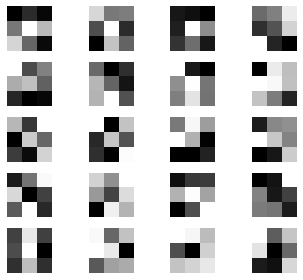

average of absolute gradients 1 tensor(4.5974e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4023e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4553e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4107e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9742e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6182e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5043e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4274e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7881e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6078e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1461e-06, device='cuda:0')


 51%|████████████████████████████████████████▏                                      | 509/1000 [42:33<41:27,  5.07s/it]

Epoch: 509
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-2.0250e-01, -1.2921e-01, -1.8961e-01],
         [ 6.2220e-05,  2.3234e-01,  1.1324e-01],
         [ 1.5905e-01, -2.9798e-02, -1.8643e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


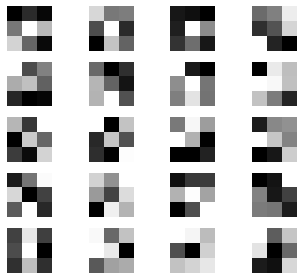

average of absolute gradients 1 tensor(4.5386e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2549e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4752e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5904e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2744e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1593e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0671e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5860e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3314e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4542e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8563e-06, device='cuda:0')


 51%|████████████████████████████████████████▎                                      | 510/1000 [42:39<41:21,  5.06s/it]

Epoch: 510
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-2.0235e-01, -1.2969e-01, -1.8998e-01],
         [-8.4426e-05,  2.3139e-01,  1.1315e-01],
         [ 1.5913e-01, -3.0201e-02, -1.8668e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


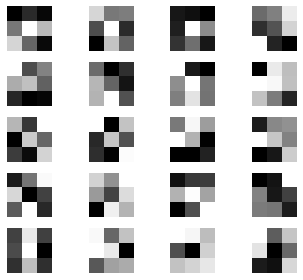

average of absolute gradients 1 tensor(3.4233e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0141e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6253e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7594e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3932e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9417e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8018e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1401e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4894e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5763e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4202e-06, device='cuda:0')


 51%|████████████████████████████████████████▎                                      | 511/1000 [42:44<41:12,  5.06s/it]

Epoch: 511
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2023, -0.1301, -0.1895],
         [ 0.0006,  0.2313,  0.1131],
         [ 0.1593, -0.0304, -0.1865]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


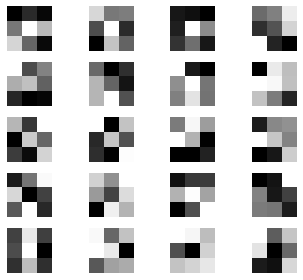

average of absolute gradients 1 tensor(3.4612e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4747e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8878e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4795e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3213e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9683e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7006e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0037e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0293e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0293e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6403e-06, device='cuda:0')


 51%|████████████████████████████████████████▍                                      | 512/1000 [42:49<41:00,  5.04s/it]

Epoch: 512
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-2.0263e-01, -1.3063e-01, -1.8956e-01],
         [ 1.1518e-05,  2.3084e-01,  1.1272e-01],
         [ 1.5902e-01, -3.0496e-02, -1.8653e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


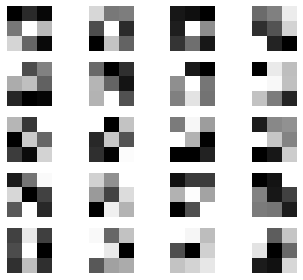

average of absolute gradients 1 tensor(3.5677e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3838e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2393e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6973e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9979e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5016e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8851e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7174e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0844e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9386e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4282e-06, device='cuda:0')


 51%|████████████████████████████████████████▌                                      | 513/1000 [42:54<40:51,  5.03s/it]

Epoch: 513
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2023, -0.1307, -0.1892],
         [ 0.0004,  0.2314,  0.1132],
         [ 0.1590, -0.0300, -0.1861]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


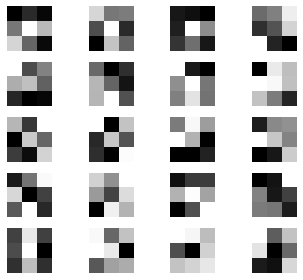

average of absolute gradients 1 tensor(3.3440e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7990e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9981e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1314e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5686e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1563e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8991e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8597e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2612e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4616e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7298e-06, device='cuda:0')


 51%|████████████████████████████████████████▌                                      | 514/1000 [42:59<40:45,  5.03s/it]

Epoch: 514
Accuracy of train set: 20%
Accuracy of test set: 8%

tensor([[[-2.0252e-01, -1.3062e-01, -1.8924e-01],
         [-1.8077e-04,  2.3134e-01,  1.1278e-01],
         [ 1.5857e-01, -3.0225e-02, -1.8613e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


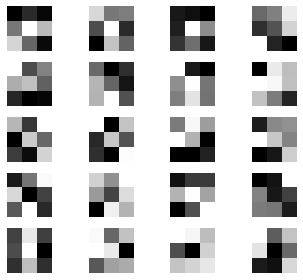

average of absolute gradients 1 tensor(3.7489e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0962e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3090e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1204e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9362e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4707e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8430e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7277e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0005e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1164e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6563e-06, device='cuda:0')


 52%|████████████████████████████████████████▋                                      | 515/1000 [43:04<40:45,  5.04s/it]

Epoch: 515
Accuracy of train set: 20%
Accuracy of test set: 8%

tensor([[[-0.2022, -0.1302, -0.1892],
         [-0.0003,  0.2316,  0.1123],
         [ 0.1587, -0.0303, -0.1863]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


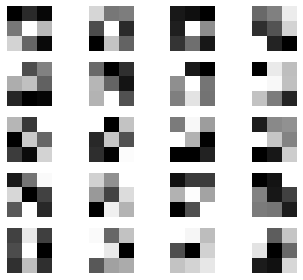

average of absolute gradients 1 tensor(2.8376e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9479e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4254e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1809e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4405e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0978e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1754e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3453e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4690e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5649e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4798e-06, device='cuda:0')


 52%|████████████████████████████████████████▊                                      | 516/1000 [43:09<40:39,  5.04s/it]

Epoch: 516
Accuracy of train set: 20%
Accuracy of test set: 8%

tensor([[[-0.2021, -0.1302, -0.1891],
         [-0.0002,  0.2318,  0.1122],
         [ 0.1586, -0.0303, -0.1862]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


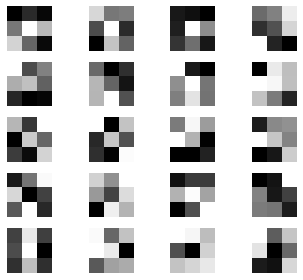

average of absolute gradients 1 tensor(3.6440e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1255e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0901e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4619e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1887e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1673e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1965e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3002e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7258e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7733e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6084e-06, device='cuda:0')


 52%|████████████████████████████████████████▊                                      | 517/1000 [43:14<40:37,  5.05s/it]

Epoch: 517
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-2.0185e-01, -1.3018e-01, -1.8905e-01],
         [ 8.6191e-05,  2.3167e-01,  1.1262e-01],
         [ 1.5880e-01, -2.9812e-02, -1.8600e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


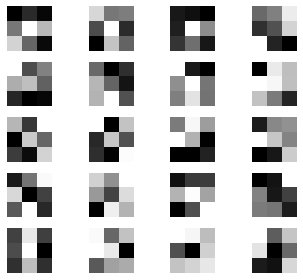

average of absolute gradients 1 tensor(4.0834e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0270e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6584e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9937e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6508e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0712e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7810e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2853e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4944e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1405e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4527e-06, device='cuda:0')


 52%|████████████████████████████████████████▉                                      | 518/1000 [43:19<40:28,  5.04s/it]

Epoch: 518
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-0.2027, -0.1303, -0.1895],
         [-0.0004,  0.2313,  0.1116],
         [ 0.1579, -0.0302, -0.1861]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


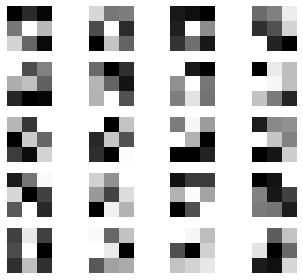

average of absolute gradients 1 tensor(3.2153e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8027e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3590e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9143e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6482e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9312e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3117e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6255e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6281e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2876e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7444e-06, device='cuda:0')


 52%|█████████████████████████████████████████                                      | 519/1000 [43:24<40:26,  5.04s/it]

Epoch: 519
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.2022, -0.1305, -0.1892],
         [ 0.0006,  0.2312,  0.1120],
         [ 0.1586, -0.0305, -0.1856]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


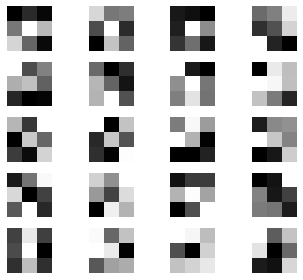

average of absolute gradients 1 tensor(3.5335e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2155e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5617e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0661e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5574e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4813e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1124e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0357e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2031e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7793e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6136e-06, device='cuda:0')


 52%|█████████████████████████████████████████                                      | 520/1000 [43:29<40:21,  5.04s/it]

Epoch: 520
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-2.0228e-01, -1.3066e-01, -1.8934e-01],
         [ 3.8226e-06,  2.3119e-01,  1.1187e-01],
         [ 1.5821e-01, -2.9985e-02, -1.8550e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


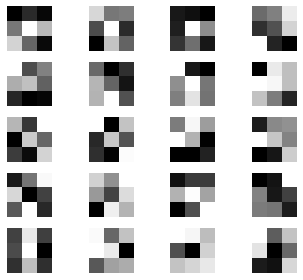

average of absolute gradients 1 tensor(3.4064e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9649e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2166e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6063e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7835e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0066e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9293e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4670e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7612e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1190e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3864e-06, device='cuda:0')


 52%|█████████████████████████████████████████▏                                     | 521/1000 [43:34<40:14,  5.04s/it]

Epoch: 521
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.2023, -0.1307, -0.1894],
         [-0.0003,  0.2308,  0.1117],
         [ 0.1583, -0.0300, -0.1855]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


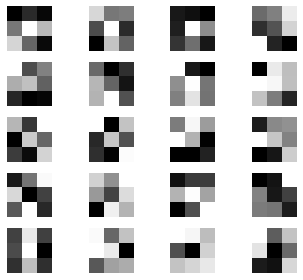

average of absolute gradients 1 tensor(3.7886e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0457e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9352e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3625e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4276e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0838e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0227e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4706e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9505e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4755e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2393e-06, device='cuda:0')


 52%|█████████████████████████████████████████▏                                     | 522/1000 [43:39<40:06,  5.04s/it]

Epoch: 522
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-2.0187e-01, -1.3064e-01, -1.8908e-01],
         [-1.2546e-04,  2.3109e-01,  1.1201e-01],
         [ 1.5848e-01, -2.9805e-02, -1.8546e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


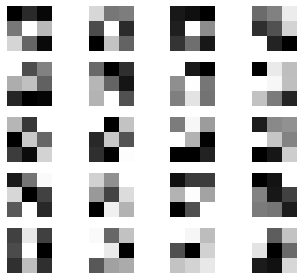

average of absolute gradients 1 tensor(3.2264e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9980e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9423e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5841e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3086e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4368e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3385e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4052e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8368e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5560e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0614e-06, device='cuda:0')


 52%|█████████████████████████████████████████▎                                     | 523/1000 [43:44<40:07,  5.05s/it]

Epoch: 523
Accuracy of train set: 20%
Accuracy of test set: 9%

tensor([[[-2.0194e-01, -1.3077e-01, -1.8909e-01],
         [ 1.4067e-05,  2.3091e-01,  1.1167e-01],
         [ 1.5834e-01, -3.0140e-02, -1.8547e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


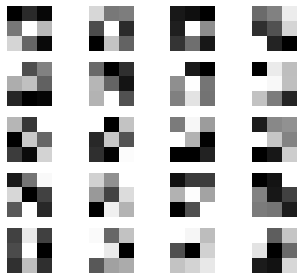

average of absolute gradients 1 tensor(3.0590e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7666e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0577e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2158e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8913e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6697e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0838e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0822e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2763e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7191e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8938e-06, device='cuda:0')


 52%|█████████████████████████████████████████▍                                     | 524/1000 [43:49<40:00,  5.04s/it]

Epoch: 524
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-2.0210e-01, -1.3100e-01, -1.8904e-01],
         [-9.8561e-05,  2.3053e-01,  1.1151e-01],
         [ 1.5846e-01, -3.0439e-02, -1.8529e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


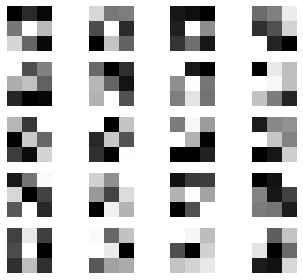

average of absolute gradients 1 tensor(3.2459e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8350e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8188e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8371e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3116e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4582e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4257e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7038e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0624e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7525e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.5915e-06, device='cuda:0')


 52%|█████████████████████████████████████████▍                                     | 525/1000 [43:54<39:51,  5.03s/it]

Epoch: 525
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-2.0202e-01, -1.3088e-01, -1.8856e-01],
         [-4.0959e-05,  2.3069e-01,  1.1127e-01],
         [ 1.5906e-01, -3.0555e-02, -1.8506e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


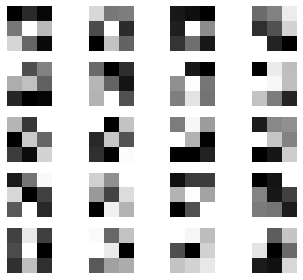

average of absolute gradients 1 tensor(3.4211e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6590e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9162e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4554e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8708e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4907e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7742e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0904e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3249e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4763e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0014e-06, device='cuda:0')


 53%|█████████████████████████████████████████▌                                     | 526/1000 [43:59<39:45,  5.03s/it]

Epoch: 526
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-2.0231e-01, -1.3067e-01, -1.8880e-01],
         [ 4.7301e-05,  2.3048e-01,  1.1065e-01],
         [ 1.5888e-01, -3.0641e-02, -1.8513e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


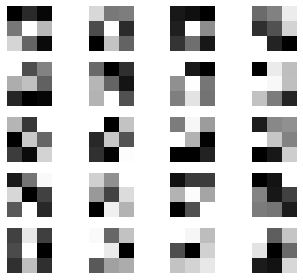

average of absolute gradients 1 tensor(3.2873e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1960e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7056e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8616e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5331e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3331e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9819e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3154e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5960e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7211e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6650e-06, device='cuda:0')


 53%|█████████████████████████████████████████▋                                     | 527/1000 [44:04<39:42,  5.04s/it]

Epoch: 527
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-2.0217e-01, -1.3061e-01, -1.8846e-01],
         [-6.5346e-05,  2.3057e-01,  1.1085e-01],
         [ 1.5941e-01, -3.0747e-02, -1.8465e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


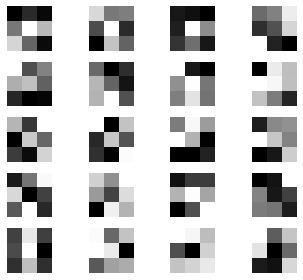

average of absolute gradients 1 tensor(2.9329e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4865e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6631e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3307e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8410e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3314e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7623e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2218e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0248e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2083e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2985e-06, device='cuda:0')


 53%|█████████████████████████████████████████▋                                     | 528/1000 [44:09<39:39,  5.04s/it]

Epoch: 528
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-2.0226e-01, -1.3097e-01, -1.8837e-01],
         [-5.9900e-05,  2.3025e-01,  1.1105e-01],
         [ 1.5960e-01, -3.0557e-02, -1.8425e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


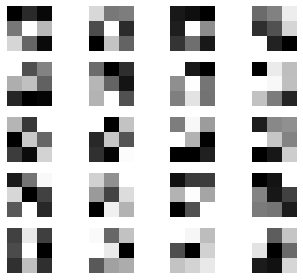

average of absolute gradients 1 tensor(2.9431e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3639e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9841e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6269e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1187e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9662e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3214e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0590e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3903e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6933e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3452e-06, device='cuda:0')


 53%|█████████████████████████████████████████▊                                     | 529/1000 [44:14<39:30,  5.03s/it]

Epoch: 529
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-2.0226e-01, -1.3190e-01, -1.8756e-01],
         [-8.0373e-05,  2.2934e-01,  1.1106e-01],
         [ 1.6109e-01, -3.0744e-02, -1.8393e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


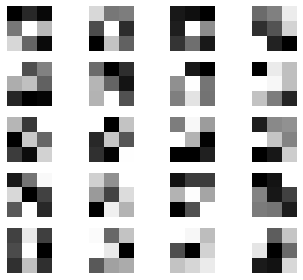

average of absolute gradients 1 tensor(4.5818e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9043e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4743e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3936e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9324e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0845e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9555e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9702e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8860e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1678e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3325e-06, device='cuda:0')


 53%|█████████████████████████████████████████▊                                     | 530/1000 [44:19<39:27,  5.04s/it]

Epoch: 530
Accuracy of train set: 21%
Accuracy of test set: 8%

tensor([[[-2.0256e-01, -1.3177e-01, -1.8776e-01],
         [-5.7017e-05,  2.2964e-01,  1.1118e-01],
         [ 1.5961e-01, -3.0843e-02, -1.8404e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


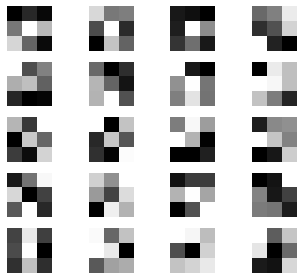

average of absolute gradients 1 tensor(2.9423e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7938e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9573e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7809e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9783e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0795e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0721e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3835e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3733e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7159e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8588e-06, device='cuda:0')


 53%|█████████████████████████████████████████▉                                     | 531/1000 [44:24<39:19,  5.03s/it]

Epoch: 531
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-2.0266e-01, -1.3201e-01, -1.8798e-01],
         [ 1.0900e-04,  2.2941e-01,  1.1140e-01],
         [ 1.5906e-01, -3.0405e-02, -1.8395e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


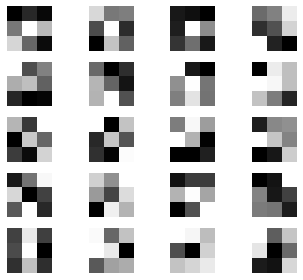

average of absolute gradients 1 tensor(2.9225e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0016e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7179e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6558e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9830e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5887e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1855e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5151e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9201e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1971e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4876e-06, device='cuda:0')


 53%|██████████████████████████████████████████                                     | 532/1000 [44:29<39:18,  5.04s/it]

Epoch: 532
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-2.0280e-01, -1.3196e-01, -1.8796e-01],
         [-1.2639e-04,  2.2943e-01,  1.1117e-01],
         [ 1.5896e-01, -3.0429e-02, -1.8374e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


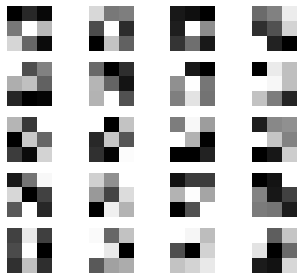

average of absolute gradients 1 tensor(2.9565e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5452e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1661e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7370e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6532e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1909e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1115e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4179e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0652e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8577e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7488e-06, device='cuda:0')


 53%|██████████████████████████████████████████                                     | 533/1000 [44:34<39:19,  5.05s/it]

Epoch: 533
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-2.0222e-01, -1.3178e-01, -1.8777e-01],
         [-1.8070e-05,  2.2984e-01,  1.1137e-01],
         [ 1.5929e-01, -3.0123e-02, -1.8352e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


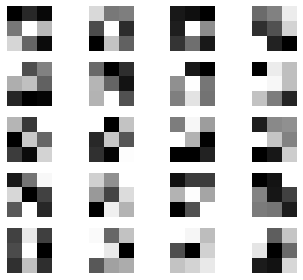

average of absolute gradients 1 tensor(3.2418e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0854e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0450e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7423e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6579e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9043e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9552e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8301e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0365e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8233e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0457e-06, device='cuda:0')


 53%|██████████████████████████████████████████▏                                    | 534/1000 [44:40<39:18,  5.06s/it]

Epoch: 534
Accuracy of train set: 21%
Accuracy of test set: 8%

tensor([[[-0.2028, -0.1318, -0.1882],
         [-0.0006,  0.2295,  0.1108],
         [ 0.1585, -0.0304, -0.1835]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


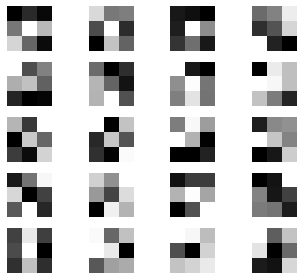

average of absolute gradients 1 tensor(3.3544e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2792e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7392e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1004e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8753e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8566e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8395e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8905e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3727e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8942e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2319e-06, device='cuda:0')


 54%|██████████████████████████████████████████▎                                    | 535/1000 [44:45<39:08,  5.05s/it]

Epoch: 535
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.2028, -0.1317, -0.1879],
         [-0.0007,  0.2293,  0.1110],
         [ 0.1590, -0.0304, -0.1833]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


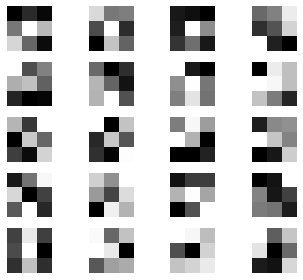

average of absolute gradients 1 tensor(2.7809e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8435e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2250e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1293e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6213e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5697e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1763e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4457e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6543e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1851e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3608e-06, device='cuda:0')


 54%|██████████████████████████████████████████▎                                    | 536/1000 [44:50<39:01,  5.05s/it]

Epoch: 536
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.2025, -0.1316, -0.1879],
         [-0.0006,  0.2294,  0.1111],
         [ 0.1590, -0.0305, -0.1831]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


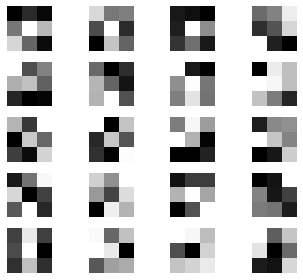

average of absolute gradients 1 tensor(2.5847e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2787e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4294e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0068e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4115e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9566e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9461e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5779e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1456e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2113e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4349e-06, device='cuda:0')


 54%|██████████████████████████████████████████▍                                    | 537/1000 [44:55<38:53,  5.04s/it]

Epoch: 537
Accuracy of train set: 21%
Accuracy of test set: 8%

tensor([[[-0.2026, -0.1317, -0.1883],
         [-0.0009,  0.2290,  0.1107],
         [ 0.1588, -0.0305, -0.1832]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


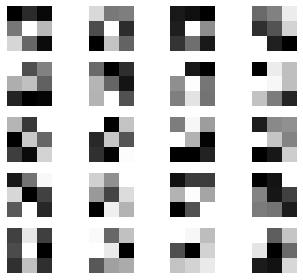

average of absolute gradients 1 tensor(3.4818e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7811e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9594e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9486e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0049e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4327e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7798e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1627e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9856e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0376e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.7969e-06, device='cuda:0')


 54%|██████████████████████████████████████████▌                                    | 538/1000 [45:00<38:44,  5.03s/it]

Epoch: 538
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.2024, -0.1315, -0.1884],
         [-0.0006,  0.2293,  0.1105],
         [ 0.1588, -0.0302, -0.1831]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


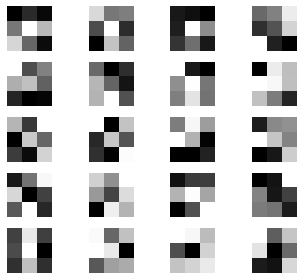

average of absolute gradients 1 tensor(3.5122e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9812e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8316e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7902e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9628e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1188e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1781e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1142e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5883e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6572e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5298e-06, device='cuda:0')


 54%|██████████████████████████████████████████▌                                    | 539/1000 [45:05<38:37,  5.03s/it]

Epoch: 539
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.2017, -0.1311, -0.1885],
         [-0.0010,  0.2293,  0.1110],
         [ 0.1591, -0.0302, -0.1831]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


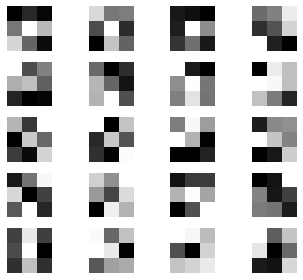

average of absolute gradients 1 tensor(2.6654e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6132e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6843e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4732e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5346e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6263e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9487e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3603e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0959e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2381e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5949e-06, device='cuda:0')


 54%|██████████████████████████████████████████▋                                    | 540/1000 [45:10<38:40,  5.04s/it]

Epoch: 540
Accuracy of train set: 21%
Accuracy of test set: 8%

tensor([[[-0.2016, -0.1310, -0.1885],
         [-0.0007,  0.2296,  0.1113],
         [ 0.1584, -0.0303, -0.1831]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


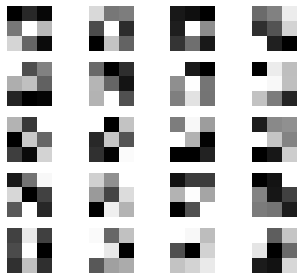

average of absolute gradients 1 tensor(2.9911e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9920e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9762e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9477e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2437e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7388e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0246e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0644e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3683e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4408e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8945e-06, device='cuda:0')


 54%|██████████████████████████████████████████▋                                    | 541/1000 [45:15<38:31,  5.04s/it]

Epoch: 541
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.2013, -0.1315, -0.1886],
         [-0.0004,  0.2291,  0.1114],
         [ 0.1586, -0.0306, -0.1830]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


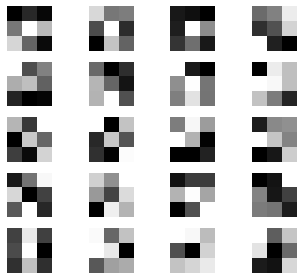

average of absolute gradients 1 tensor(3.3350e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4830e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9131e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3054e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5200e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3706e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4702e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1831e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0388e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5389e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.8165e-06, device='cuda:0')


 54%|██████████████████████████████████████████▊                                    | 542/1000 [45:20<38:35,  5.05s/it]

Epoch: 542
Accuracy of train set: 21%
Accuracy of test set: 8%

tensor([[[-2.0123e-01, -1.3132e-01, -1.8847e-01],
         [-2.2423e-04,  2.2927e-01,  1.1112e-01],
         [ 1.5870e-01, -3.0689e-02, -1.8285e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


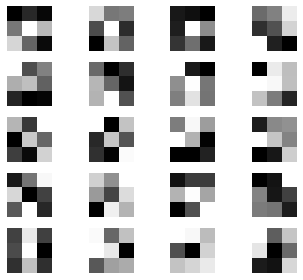

average of absolute gradients 1 tensor(2.8183e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1997e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5512e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7731e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1021e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7551e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8096e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5530e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2873e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8804e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.6901e-06, device='cuda:0')


 54%|██████████████████████████████████████████▉                                    | 543/1000 [45:25<38:25,  5.05s/it]

Epoch: 543
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.2012, -0.1315, -0.1885],
         [-0.0005,  0.2286,  0.1112],
         [ 0.1589, -0.0307, -0.1830]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


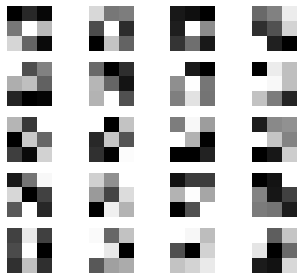

average of absolute gradients 1 tensor(2.7815e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8540e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8394e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4915e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0162e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8088e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8377e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0869e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8244e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7653e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3603e-06, device='cuda:0')


 54%|██████████████████████████████████████████▉                                    | 544/1000 [45:30<38:21,  5.05s/it]

Epoch: 544
Accuracy of train set: 21%
Accuracy of test set: 8%

tensor([[[-0.2010, -0.1316, -0.1884],
         [-0.0005,  0.2285,  0.1113],
         [ 0.1589, -0.0306, -0.1831]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


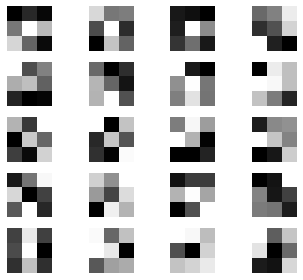

average of absolute gradients 1 tensor(2.9342e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8207e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0413e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4777e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5650e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6978e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5605e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3745e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7698e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1612e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9618e-06, device='cuda:0')


 55%|███████████████████████████████████████████                                    | 545/1000 [45:35<38:16,  5.05s/it]

Epoch: 545
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.2010, -0.1314, -0.1885],
         [-0.0008,  0.2284,  0.1113],
         [ 0.1590, -0.0309, -0.1829]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


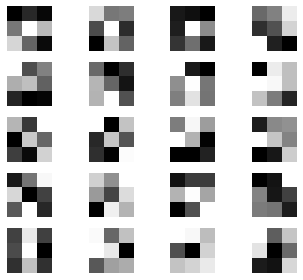

average of absolute gradients 1 tensor(3.2154e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0733e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7277e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0034e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1152e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2213e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2494e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5895e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6811e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3209e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8618e-06, device='cuda:0')


 55%|███████████████████████████████████████████▏                                   | 546/1000 [45:40<38:10,  5.04s/it]

Epoch: 546
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.2009, -0.1314, -0.1886],
         [-0.0009,  0.2285,  0.1109],
         [ 0.1588, -0.0310, -0.1828]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


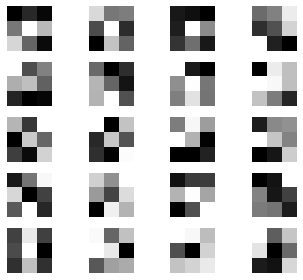

average of absolute gradients 1 tensor(2.9804e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7688e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7901e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5992e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7510e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7382e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1105e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0595e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6490e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6282e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8054e-06, device='cuda:0')


 55%|███████████████████████████████████████████▏                                   | 547/1000 [45:45<38:02,  5.04s/it]

Epoch: 547
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.2009, -0.1315, -0.1884],
         [-0.0007,  0.2285,  0.1108],
         [ 0.1587, -0.0312, -0.1828]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


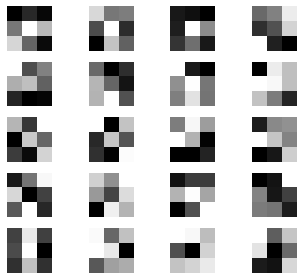

average of absolute gradients 1 tensor(3.3382e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0272e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3442e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8764e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4383e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9372e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4783e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0616e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5295e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4185e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0736e-06, device='cuda:0')


 55%|███████████████████████████████████████████▎                                   | 548/1000 [45:50<38:02,  5.05s/it]

Epoch: 548
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.2007, -0.1310, -0.1884],
         [-0.0005,  0.2286,  0.1111],
         [ 0.1590, -0.0310, -0.1825]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


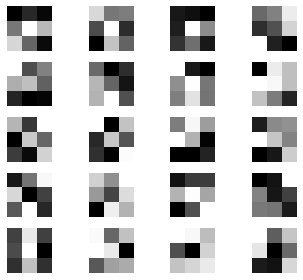

average of absolute gradients 1 tensor(2.9874e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5260e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5898e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4240e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8054e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5570e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6559e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3378e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8014e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4456e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3465e-06, device='cuda:0')


 55%|███████████████████████████████████████████▎                                   | 549/1000 [45:55<37:51,  5.04s/it]

Epoch: 549
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.2007, -0.1314, -0.1884],
         [-0.0007,  0.2280,  0.1109],
         [ 0.1590, -0.0312, -0.1827]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


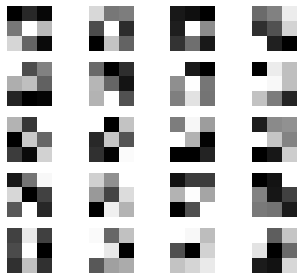

average of absolute gradients 1 tensor(3.2075e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9047e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7560e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8574e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5393e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4645e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1976e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7366e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4979e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5970e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1870e-06, device='cuda:0')


 55%|███████████████████████████████████████████▍                                   | 550/1000 [46:00<37:50,  5.05s/it]

Epoch: 550
Accuracy of train set: 21%
Accuracy of test set: 8%

tensor([[[-0.2006, -0.1315, -0.1884],
         [-0.0005,  0.2281,  0.1112],
         [ 0.1586, -0.0311, -0.1826]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


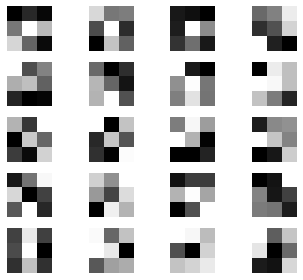

average of absolute gradients 1 tensor(2.9318e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0619e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7471e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6655e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9507e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5542e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7785e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9468e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3173e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8284e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1150e-06, device='cuda:0')


 55%|███████████████████████████████████████████▌                                   | 551/1000 [46:05<38:00,  5.08s/it]

Epoch: 551
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.2003, -0.1314, -0.1882],
         [-0.0005,  0.2281,  0.1112],
         [ 0.1590, -0.0309, -0.1825]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


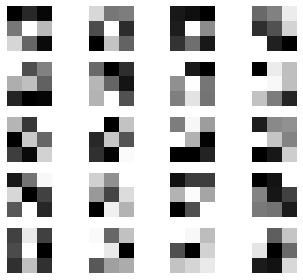

average of absolute gradients 1 tensor(3.0357e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9071e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0513e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9164e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8128e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4857e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7732e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9118e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4286e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4611e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8227e-06, device='cuda:0')


 55%|███████████████████████████████████████████▌                                   | 552/1000 [46:10<37:53,  5.08s/it]

Epoch: 552
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.2006, -0.1318, -0.1886],
         [-0.0004,  0.2272,  0.1111],
         [ 0.1587, -0.0310, -0.1827]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


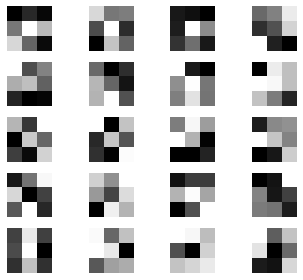

average of absolute gradients 1 tensor(2.9587e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7713e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9144e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0808e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5866e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0877e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4422e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9816e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8107e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2079e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1543e-06, device='cuda:0')


 55%|███████████████████████████████████████████▋                                   | 553/1000 [46:15<37:42,  5.06s/it]

Epoch: 553
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.2004, -0.1319, -0.1885],
         [-0.0005,  0.2272,  0.1109],
         [ 0.1588, -0.0312, -0.1826]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


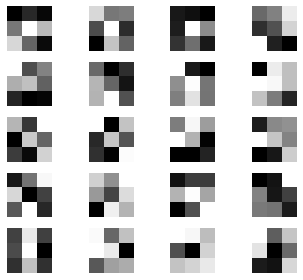

average of absolute gradients 1 tensor(2.9206e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6384e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6115e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1738e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6206e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9022e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1595e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8004e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6428e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2180e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0827e-06, device='cuda:0')


 55%|███████████████████████████████████████████▊                                   | 554/1000 [46:20<37:33,  5.05s/it]

Epoch: 554
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.2001, -0.1316, -0.1882],
         [-0.0008,  0.2277,  0.1110],
         [ 0.1589, -0.0307, -0.1825]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


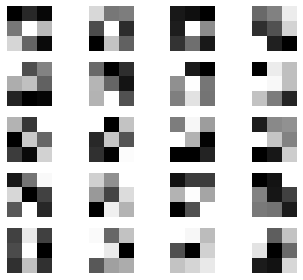

average of absolute gradients 1 tensor(2.8176e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1244e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2994e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2633e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9605e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2874e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7637e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9922e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2152e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5831e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3010e-06, device='cuda:0')


 56%|███████████████████████████████████████████▊                                   | 555/1000 [46:25<37:25,  5.05s/it]

Epoch: 555
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.2000, -0.1319, -0.1882],
         [-0.0007,  0.2271,  0.1106],
         [ 0.1592, -0.0314, -0.1827]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


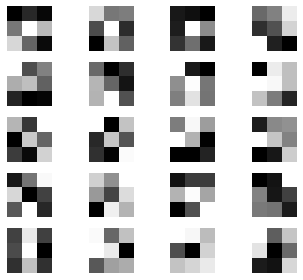

average of absolute gradients 1 tensor(3.6507e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8306e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1259e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1519e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7293e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1692e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6493e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6188e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7584e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5430e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2252e-06, device='cuda:0')


 56%|███████████████████████████████████████████▉                                   | 556/1000 [46:31<37:31,  5.07s/it]

Epoch: 556
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.2000, -0.1316, -0.1881],
         [-0.0007,  0.2272,  0.1108],
         [ 0.1593, -0.0311, -0.1826]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


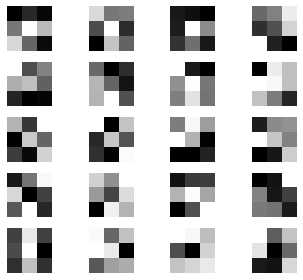

average of absolute gradients 1 tensor(3.5375e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7871e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3049e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5413e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7500e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6427e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2420e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5180e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8818e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4053e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4901e-06, device='cuda:0')


 56%|████████████████████████████████████████████                                   | 557/1000 [46:36<37:26,  5.07s/it]

Epoch: 557
Accuracy of train set: 21%
Accuracy of test set: 8%

tensor([[[-0.1997, -0.1318, -0.1879],
         [-0.0006,  0.2273,  0.1109],
         [ 0.1592, -0.0312, -0.1825]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


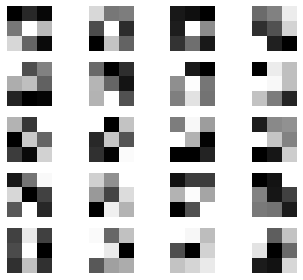

average of absolute gradients 1 tensor(2.6913e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3033e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6157e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0772e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7858e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7089e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9909e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1306e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1895e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3454e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6326e-06, device='cuda:0')


 56%|████████████████████████████████████████████                                   | 558/1000 [46:41<37:18,  5.06s/it]

Epoch: 558
Accuracy of train set: 21%
Accuracy of test set: 8%

tensor([[[-0.1998, -0.1319, -0.1881],
         [-0.0008,  0.2270,  0.1107],
         [ 0.1588, -0.0314, -0.1826]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


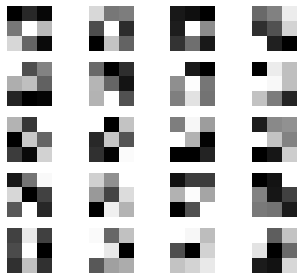

average of absolute gradients 1 tensor(2.6892e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9489e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7583e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5729e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2141e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8301e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8440e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8521e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2447e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8973e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8625e-06, device='cuda:0')


 56%|████████████████████████████████████████████▏                                  | 559/1000 [46:46<37:05,  5.05s/it]

Epoch: 559
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.1996, -0.1315, -0.1882],
         [-0.0006,  0.2271,  0.1108],
         [ 0.1592, -0.0316, -0.1824]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


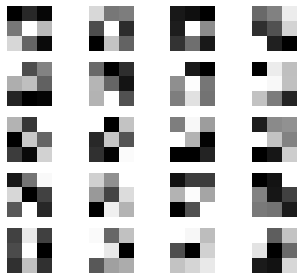

average of absolute gradients 1 tensor(2.7362e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7196e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3891e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7478e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4238e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1355e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2888e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9541e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8681e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1673e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4862e-06, device='cuda:0')


 56%|████████████████████████████████████████████▏                                  | 560/1000 [46:51<37:05,  5.06s/it]

Epoch: 560
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.1996, -0.1318, -0.1882],
         [-0.0006,  0.2268,  0.1107],
         [ 0.1591, -0.0317, -0.1823]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


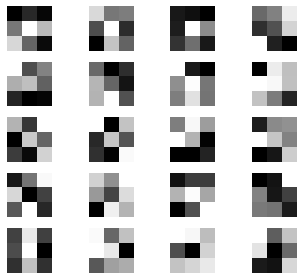

average of absolute gradients 1 tensor(2.8782e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2666e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0476e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8873e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8953e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9913e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7989e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2439e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0275e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1848e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9953e-06, device='cuda:0')


 56%|████████████████████████████████████████████▎                                  | 561/1000 [46:56<37:01,  5.06s/it]

Epoch: 561
Accuracy of train set: 21%
Accuracy of test set: 8%

tensor([[[-0.1995, -0.1316, -0.1882],
         [-0.0008,  0.2269,  0.1105],
         [ 0.1590, -0.0316, -0.1823]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


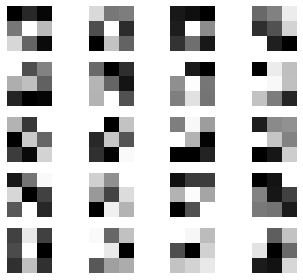

average of absolute gradients 1 tensor(3.0875e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8001e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1868e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8273e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8689e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8952e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9174e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8821e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3880e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8182e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4589e-06, device='cuda:0')


 56%|████████████████████████████████████████████▍                                  | 562/1000 [47:01<36:57,  5.06s/it]

Epoch: 562
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.1991, -0.1312, -0.1881],
         [-0.0010,  0.2272,  0.1106],
         [ 0.1592, -0.0317, -0.1822]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


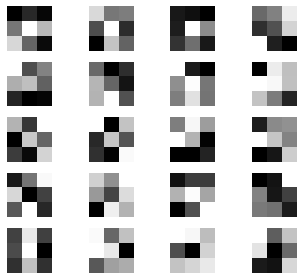

average of absolute gradients 1 tensor(3.1300e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2464e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3791e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4574e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9784e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2525e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1789e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6669e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1756e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8896e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1457e-06, device='cuda:0')


 56%|████████████████████████████████████████████▍                                  | 563/1000 [47:06<36:46,  5.05s/it]

Epoch: 563
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.1989, -0.1316, -0.1881],
         [-0.0008,  0.2270,  0.1108],
         [ 0.1588, -0.0320, -0.1824]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


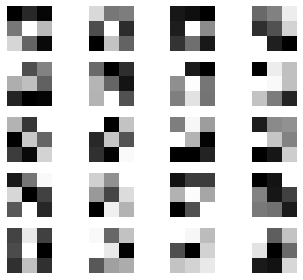

average of absolute gradients 1 tensor(3.3092e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2873e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3269e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1904e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1462e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7113e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0893e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9219e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4622e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3054e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4776e-06, device='cuda:0')


 56%|████████████████████████████████████████████▌                                  | 564/1000 [47:11<36:41,  5.05s/it]

Epoch: 564
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.1990, -0.1318, -0.1881],
         [-0.0009,  0.2265,  0.1106],
         [ 0.1587, -0.0321, -0.1825]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


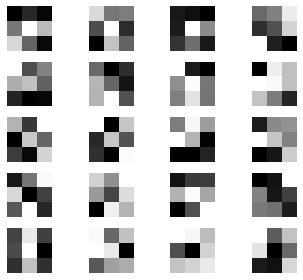

average of absolute gradients 1 tensor(4.1974e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1179e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2934e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7609e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6034e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0633e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7769e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4541e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9909e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3134e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9784e-06, device='cuda:0')


 56%|████████████████████████████████████████████▋                                  | 565/1000 [47:16<36:34,  5.04s/it]

Epoch: 565
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.1992, -0.1320, -0.1882],
         [-0.0006,  0.2266,  0.1101],
         [ 0.1583, -0.0323, -0.1824]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


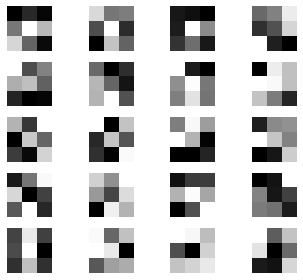

average of absolute gradients 1 tensor(3.4774e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5006e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9461e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1424e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7133e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7489e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1354e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0337e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6281e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8495e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6999e-06, device='cuda:0')


 57%|████████████████████████████████████████████▋                                  | 566/1000 [47:21<36:30,  5.05s/it]

Epoch: 566
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.1990, -0.1317, -0.1880],
         [-0.0012,  0.2264,  0.1109],
         [ 0.1585, -0.0324, -0.1822]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


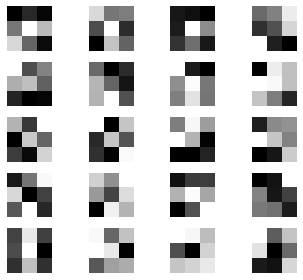

average of absolute gradients 1 tensor(3.5553e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3771e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6519e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0056e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0750e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8478e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1817e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5680e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2075e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8476e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3331e-06, device='cuda:0')


 57%|████████████████████████████████████████████▊                                  | 567/1000 [47:26<36:21,  5.04s/it]

Epoch: 567
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.1990, -0.1318, -0.1879],
         [-0.0006,  0.2265,  0.1112],
         [ 0.1584, -0.0320, -0.1820]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


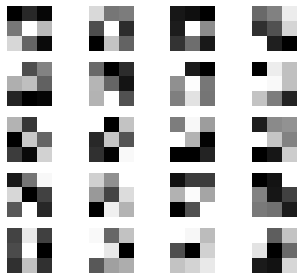

average of absolute gradients 1 tensor(4.8749e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5297e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3575e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0210e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6113e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6166e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1074e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7420e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8788e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0106e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4552e-06, device='cuda:0')


 57%|████████████████████████████████████████████▊                                  | 568/1000 [47:31<36:24,  5.06s/it]

Epoch: 568
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.1986, -0.1316, -0.1874],
         [-0.0007,  0.2267,  0.1116],
         [ 0.1589, -0.0317, -0.1817]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


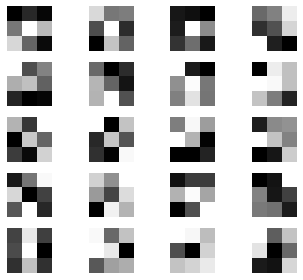

average of absolute gradients 1 tensor(5.0210e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3601e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7166e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2014e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4850e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6617e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5848e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8444e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3475e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6575e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4971e-06, device='cuda:0')


 57%|████████████████████████████████████████████▉                                  | 569/1000 [47:36<36:18,  5.05s/it]

Epoch: 569
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.1986, -0.1316, -0.1876],
         [-0.0010,  0.2266,  0.1120],
         [ 0.1584, -0.0317, -0.1816]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


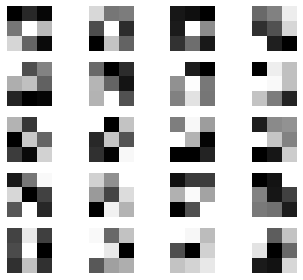

average of absolute gradients 1 tensor(3.5767e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8523e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6169e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2484e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4756e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6607e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6213e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1723e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4265e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8924e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8537e-06, device='cuda:0')


 57%|█████████████████████████████████████████████                                  | 570/1000 [47:41<36:17,  5.06s/it]

Epoch: 570
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.1984, -0.1312, -0.1871],
         [-0.0009,  0.2268,  0.1120],
         [ 0.1591, -0.0319, -0.1816]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


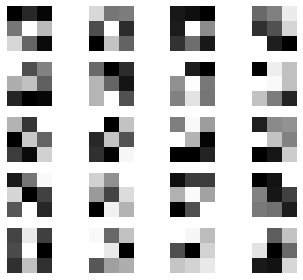

average of absolute gradients 1 tensor(4.0851e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2182e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5223e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5964e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6221e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8331e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0784e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8542e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6189e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3777e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8016e-06, device='cuda:0')


 57%|█████████████████████████████████████████████                                  | 571/1000 [47:46<36:08,  5.05s/it]

Epoch: 571
Accuracy of train set: 21%
Accuracy of test set: 9%

tensor([[[-0.1984, -0.1313, -0.1877],
         [-0.0011,  0.2263,  0.1117],
         [ 0.1591, -0.0318, -0.1815]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


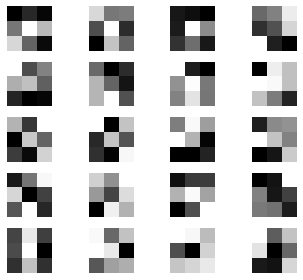

average of absolute gradients 1 tensor(4.9603e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6231e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0372e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8659e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8777e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1609e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0914e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6853e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9311e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0310e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2951e-06, device='cuda:0')


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [47:51<36:06,  5.06s/it]

Epoch: 572
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1981, -0.1306, -0.1872],
         [-0.0013,  0.2263,  0.1119],
         [ 0.1603, -0.0315, -0.1814]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


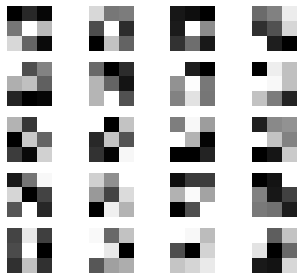

average of absolute gradients 1 tensor(5.5989e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3368e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3641e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1354e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2257e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3363e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8859e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5568e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8022e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0267e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3265e-06, device='cuda:0')


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [47:56<35:54,  5.05s/it]

Epoch: 573
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1980, -0.1305, -0.1873],
         [-0.0007,  0.2264,  0.1122],
         [ 0.1594, -0.0318, -0.1817]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


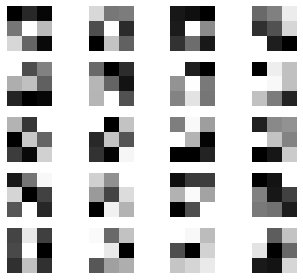

average of absolute gradients 1 tensor(4.6140e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8309e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0384e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8418e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7845e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7004e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7631e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8194e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5369e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1673e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6489e-06, device='cuda:0')


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [48:02<35:55,  5.06s/it]

Epoch: 574
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1978, -0.1302, -0.1879],
         [-0.0007,  0.2260,  0.1116],
         [ 0.1602, -0.0313, -0.1814]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


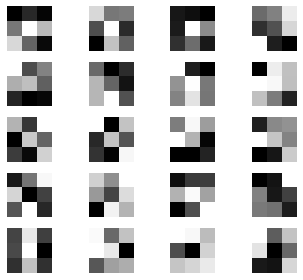

average of absolute gradients 1 tensor(5.0738e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2482e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9962e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0743e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1328e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2291e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9137e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2907e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4505e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4933e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0098e-06, device='cuda:0')


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [48:07<35:43,  5.04s/it]

Epoch: 575
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1980, -0.1293, -0.1878],
         [-0.0004,  0.2267,  0.1115],
         [ 0.1601, -0.0310, -0.1811]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


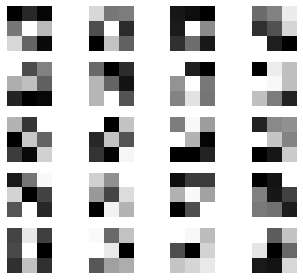

average of absolute gradients 1 tensor(4.8285e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4866e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2100e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4699e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5548e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3054e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3138e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4569e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2640e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3170e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4973e-06, device='cuda:0')


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [48:12<35:38,  5.04s/it]

Epoch: 576
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1978, -0.1294, -0.1882],
         [-0.0006,  0.2265,  0.1112],
         [ 0.1600, -0.0309, -0.1810]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


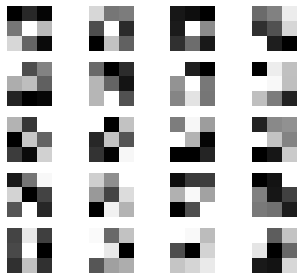

average of absolute gradients 1 tensor(6.0216e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6487e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1922e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0889e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9814e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9495e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7538e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3469e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0405e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5758e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9333e-06, device='cuda:0')


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [48:17<35:32,  5.04s/it]

Epoch: 577
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1981, -0.1295, -0.1882],
         [-0.0003,  0.2261,  0.1115],
         [ 0.1601, -0.0318, -0.1805]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


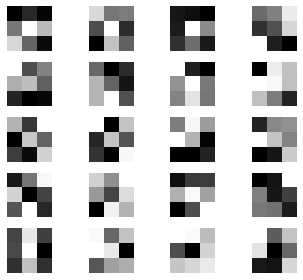

average of absolute gradients 1 tensor(5.1897e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0658e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5944e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5674e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7868e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6377e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1911e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9489e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7887e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5977e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6254e-06, device='cuda:0')


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [48:22<35:30,  5.05s/it]

Epoch: 578
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1981, -0.1291, -0.1882],
         [-0.0003,  0.2265,  0.1105],
         [ 0.1604, -0.0316, -0.1803]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


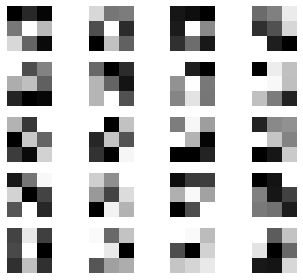

average of absolute gradients 1 tensor(5.1974e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2126e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5521e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1467e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0255e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1335e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5676e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9626e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3837e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6296e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5096e-06, device='cuda:0')


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [48:27<35:24,  5.05s/it]

Epoch: 579
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1980, -0.1286, -0.1876],
         [-0.0003,  0.2265,  0.1108],
         [ 0.1612, -0.0322, -0.1801]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


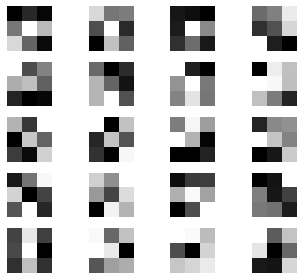

average of absolute gradients 1 tensor(4.0851e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0062e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0505e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6500e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5616e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7313e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7212e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7286e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9364e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6010e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0150e-06, device='cuda:0')


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [48:32<35:29,  5.07s/it]

Epoch: 580
Accuracy of train set: 22%
Accuracy of test set: 10%

tensor([[[-0.1979, -0.1290, -0.1878],
         [ 0.0005,  0.2270,  0.1105],
         [ 0.1603, -0.0327, -0.1798]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


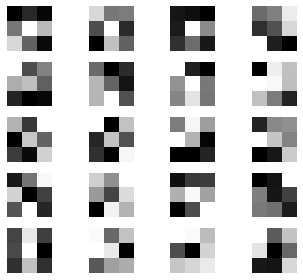

average of absolute gradients 1 tensor(4.5894e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1151e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3041e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0698e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2731e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6973e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4278e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3364e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7513e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4624e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8035e-06, device='cuda:0')


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [48:37<35:20,  5.06s/it]

Epoch: 581
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1980, -0.1289, -0.1879],
         [-0.0003,  0.2267,  0.1096],
         [ 0.1605, -0.0330, -0.1800]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


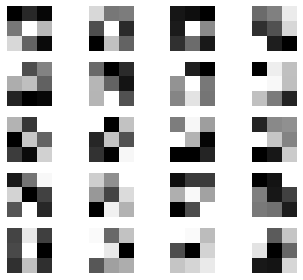

average of absolute gradients 1 tensor(5.0690e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1697e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7653e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3431e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1103e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8257e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0702e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6220e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2607e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0403e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1773e-06, device='cuda:0')


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [48:42<35:12,  5.05s/it]

Epoch: 582
Accuracy of train set: 22%
Accuracy of test set: 10%

tensor([[[-1.9796e-01, -1.2836e-01, -1.8825e-01],
         [-3.5912e-06,  2.2650e-01,  1.0999e-01],
         [ 1.6054e-01, -3.2932e-02, -1.7993e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


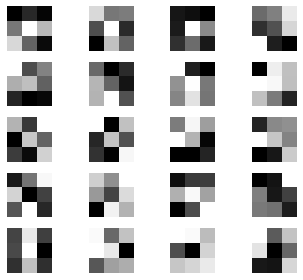

average of absolute gradients 1 tensor(4.9636e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6292e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2422e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8327e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3061e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6874e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5743e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6087e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1488e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9417e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.7246e-06, device='cuda:0')


 58%|██████████████████████████████████████████████                                 | 583/1000 [48:47<35:02,  5.04s/it]

Epoch: 583
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1980, -0.1286, -0.1885],
         [-0.0006,  0.2262,  0.1094],
         [ 0.1605, -0.0332, -0.1800]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


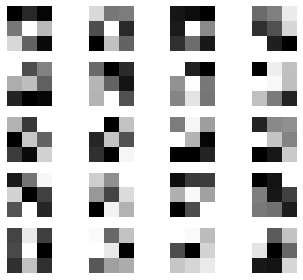

average of absolute gradients 1 tensor(4.2951e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6823e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5154e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9824e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5702e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3342e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2017e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6115e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0797e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4930e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9712e-06, device='cuda:0')


 58%|██████████████████████████████████████████████▏                                | 584/1000 [48:52<34:58,  5.04s/it]

Epoch: 584
Accuracy of train set: 22%
Accuracy of test set: 10%

tensor([[[-1.9798e-01, -1.2869e-01, -1.8840e-01],
         [-2.0186e-04,  2.2605e-01,  1.0951e-01],
         [ 1.6041e-01, -3.3645e-02, -1.7983e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


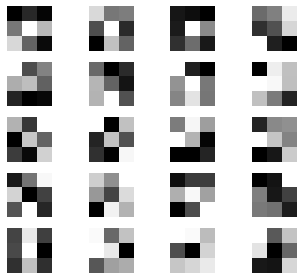

average of absolute gradients 1 tensor(4.2137e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1346e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3124e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9389e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8706e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4443e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4182e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1465e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7342e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5370e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1113e-06, device='cuda:0')


 58%|██████████████████████████████████████████████▏                                | 585/1000 [48:57<34:51,  5.04s/it]

Epoch: 585
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1978, -0.1287, -0.1884],
         [ 0.0004,  0.2262,  0.1094],
         [ 0.1605, -0.0335, -0.1796]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


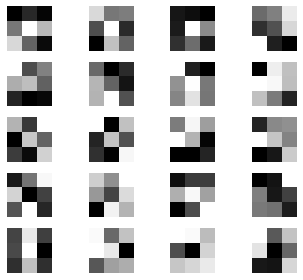

average of absolute gradients 1 tensor(4.2875e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6724e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1982e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5023e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5437e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3565e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5283e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2952e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4580e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4653e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6071e-06, device='cuda:0')


 59%|██████████████████████████████████████████████▎                                | 586/1000 [49:02<34:51,  5.05s/it]

Epoch: 586
Accuracy of train set: 22%
Accuracy of test set: 10%

tensor([[[-1.9776e-01, -1.2871e-01, -1.8877e-01],
         [-2.1990e-04,  2.2610e-01,  1.0972e-01],
         [ 1.5986e-01, -3.2973e-02, -1.7958e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


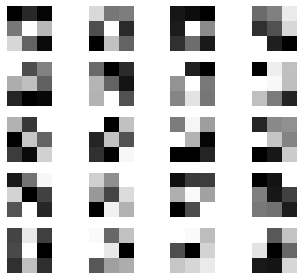

average of absolute gradients 1 tensor(4.2410e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7217e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8468e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0401e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9890e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4858e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0161e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9353e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1386e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8805e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1450e-06, device='cuda:0')


 59%|██████████████████████████████████████████████▎                                | 587/1000 [49:07<34:46,  5.05s/it]

Epoch: 587
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-1.9778e-01, -1.2825e-01, -1.8892e-01],
         [-2.0212e-04,  2.2609e-01,  1.0972e-01],
         [ 1.5997e-01, -3.2926e-02, -1.7940e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


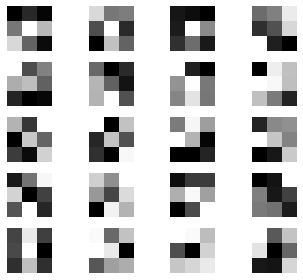

average of absolute gradients 1 tensor(3.7110e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0179e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0431e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5391e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3317e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3580e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3240e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3891e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8975e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5472e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7241e-06, device='cuda:0')


 59%|██████████████████████████████████████████████▍                                | 588/1000 [49:12<34:39,  5.05s/it]

Epoch: 588
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-1.9781e-01, -1.2838e-01, -1.8897e-01],
         [-8.6151e-05,  2.2571e-01,  1.0977e-01],
         [ 1.6003e-01, -3.3014e-02, -1.7933e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


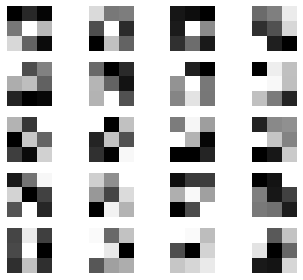

average of absolute gradients 1 tensor(4.2670e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4326e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0843e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7787e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5501e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8472e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2940e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2128e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1279e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2849e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5415e-06, device='cuda:0')


 59%|██████████████████████████████████████████████▌                                | 589/1000 [49:17<34:30,  5.04s/it]

Epoch: 589
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1976, -0.1284, -0.1887],
         [-0.0004,  0.2258,  0.1100],
         [ 0.1602, -0.0328, -0.1791]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


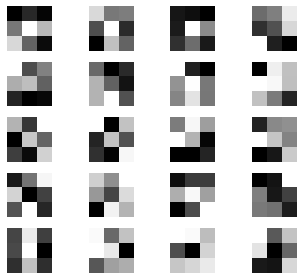

average of absolute gradients 1 tensor(4.6612e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3610e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7580e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0293e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4409e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7360e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1577e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5639e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9852e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5637e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0841e-06, device='cuda:0')


 59%|██████████████████████████████████████████████▌                                | 590/1000 [49:22<34:25,  5.04s/it]

Epoch: 590
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1976, -0.1292, -0.1889],
         [-0.0007,  0.2256,  0.1104],
         [ 0.1591, -0.0328, -0.1791]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


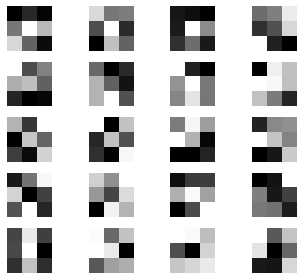

average of absolute gradients 1 tensor(3.8098e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7813e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7194e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8956e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1864e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5705e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9902e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0521e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9034e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6379e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8680e-06, device='cuda:0')


 59%|██████████████████████████████████████████████▋                                | 591/1000 [49:27<34:21,  5.04s/it]

Epoch: 591
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1977, -0.1286, -0.1887],
         [-0.0003,  0.2259,  0.1098],
         [ 0.1598, -0.0327, -0.1789]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


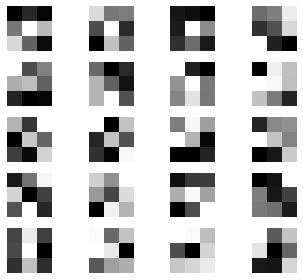

average of absolute gradients 1 tensor(4.2995e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7451e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4805e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5924e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2668e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3465e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1601e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0512e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5512e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4661e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1789e-06, device='cuda:0')


 59%|██████████████████████████████████████████████▊                                | 592/1000 [49:32<34:15,  5.04s/it]

Epoch: 592
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1976, -0.1291, -0.1886],
         [-0.0005,  0.2256,  0.1097],
         [ 0.1597, -0.0332, -0.1788]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


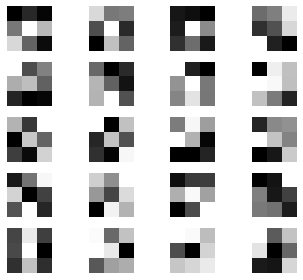

average of absolute gradients 1 tensor(3.7811e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2028e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4333e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4080e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0636e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4041e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0115e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5686e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1130e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5126e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0126e-06, device='cuda:0')


 59%|██████████████████████████████████████████████▊                                | 593/1000 [49:37<34:07,  5.03s/it]

Epoch: 593
Accuracy of train set: 22%
Accuracy of test set: 10%

tensor([[[-0.1976, -0.1291, -0.1887],
         [-0.0005,  0.2258,  0.1096],
         [ 0.1594, -0.0329, -0.1787]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


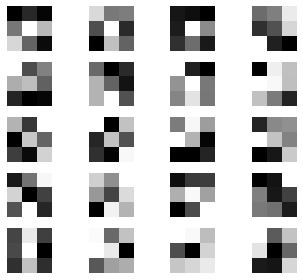

average of absolute gradients 1 tensor(3.8106e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3287e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3245e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4116e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3346e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3137e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2295e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6663e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1267e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6160e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2843e-06, device='cuda:0')


 59%|██████████████████████████████████████████████▉                                | 594/1000 [49:42<34:05,  5.04s/it]

Epoch: 594
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1972, -0.1293, -0.1887],
         [-0.0005,  0.2256,  0.1101],
         [ 0.1595, -0.0334, -0.1785]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


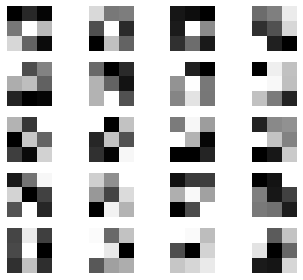

average of absolute gradients 1 tensor(3.8303e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8634e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5067e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0597e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8503e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8545e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0918e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4475e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2561e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6179e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2536e-06, device='cuda:0')


 60%|███████████████████████████████████████████████                                | 595/1000 [49:47<34:00,  5.04s/it]

Epoch: 595
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1973, -0.1292, -0.1886],
         [-0.0005,  0.2256,  0.1097],
         [ 0.1595, -0.0332, -0.1785]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


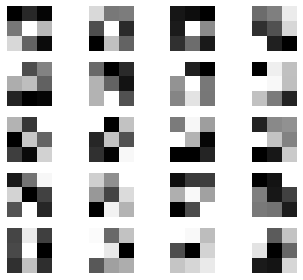

average of absolute gradients 1 tensor(3.8229e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0741e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3063e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3817e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7088e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0595e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2182e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7263e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2857e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3025e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5943e-06, device='cuda:0')


 60%|███████████████████████████████████████████████                                | 596/1000 [49:53<33:58,  5.05s/it]

Epoch: 596
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1966, -0.1289, -0.1886],
         [-0.0004,  0.2259,  0.1102],
         [ 0.1596, -0.0334, -0.1783]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


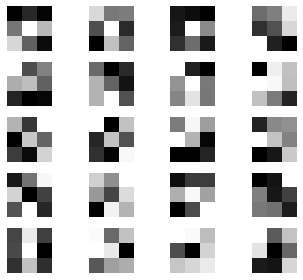

average of absolute gradients 1 tensor(3.5249e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2734e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4516e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6995e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9505e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2378e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5613e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9796e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9991e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1330e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6916e-06, device='cuda:0')


 60%|███████████████████████████████████████████████▏                               | 597/1000 [49:58<33:51,  5.04s/it]

Epoch: 597
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1967, -0.1290, -0.1887],
         [-0.0004,  0.2257,  0.1097],
         [ 0.1598, -0.0336, -0.1781]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


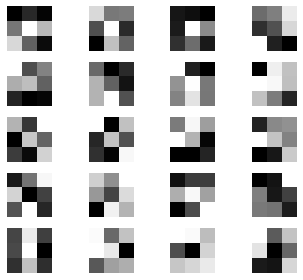

average of absolute gradients 1 tensor(3.9123e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6109e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0280e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6829e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5319e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7240e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8068e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8171e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7451e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4512e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4224e-06, device='cuda:0')


 60%|███████████████████████████████████████████████▏                               | 598/1000 [50:03<33:47,  5.04s/it]

Epoch: 598
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-1.9653e-01, -1.2935e-01, -1.8861e-01],
         [-1.3113e-04,  2.2599e-01,  1.0989e-01],
         [ 1.5915e-01, -3.3342e-02, -1.7814e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


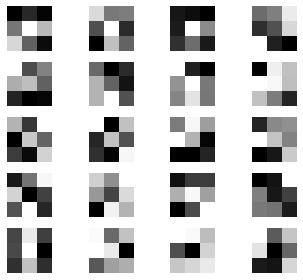

average of absolute gradients 1 tensor(4.0007e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7950e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3653e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4556e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7694e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6972e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5638e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0889e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1162e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6728e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7741e-06, device='cuda:0')


 60%|███████████████████████████████████████████████▎                               | 599/1000 [50:08<33:39,  5.04s/it]

Epoch: 599
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-1.9673e-01, -1.2937e-01, -1.8837e-01],
         [-2.9273e-05,  2.2565e-01,  1.0962e-01],
         [ 1.5945e-01, -3.3276e-02, -1.7824e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


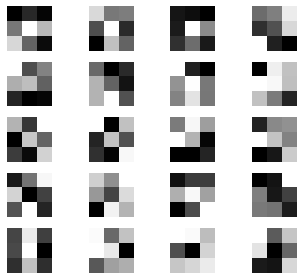

average of absolute gradients 1 tensor(3.5455e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3496e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0052e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0942e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4170e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2127e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0830e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5292e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4725e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1150e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0259e-06, device='cuda:0')


 60%|███████████████████████████████████████████████▍                               | 600/1000 [50:13<33:33,  5.03s/it]

Epoch: 600
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1970, -0.1294, -0.1885],
         [-0.0005,  0.2253,  0.1093],
         [ 0.1593, -0.0333, -0.1782]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


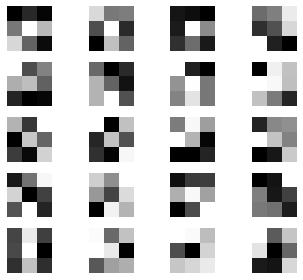

average of absolute gradients 1 tensor(4.3777e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0920e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4791e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1282e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9598e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2342e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0859e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1192e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8861e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7518e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8306e-06, device='cuda:0')


 60%|███████████████████████████████████████████████▍                               | 601/1000 [50:18<33:25,  5.03s/it]

Epoch: 601
Accuracy of train set: 22%
Accuracy of test set: 10%

tensor([[[-0.1969, -0.1301, -0.1883],
         [-0.0004,  0.2247,  0.1094],
         [ 0.1595, -0.0334, -0.1784]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


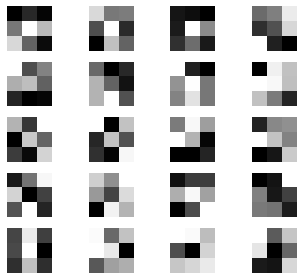

average of absolute gradients 1 tensor(3.4944e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6391e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5618e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3477e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1937e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4347e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6656e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1246e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9240e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9299e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9499e-06, device='cuda:0')


 60%|███████████████████████████████████████████████▌                               | 602/1000 [50:23<33:21,  5.03s/it]

Epoch: 602
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-1.9703e-01, -1.3024e-01, -1.8811e-01],
         [-5.5924e-05,  2.2459e-01,  1.0968e-01],
         [ 1.5915e-01, -3.3471e-02, -1.7832e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


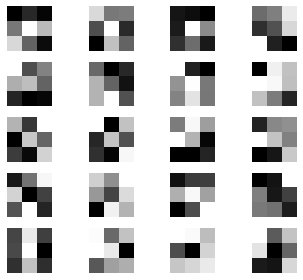

average of absolute gradients 1 tensor(3.7975e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4470e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1053e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0659e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3893e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9057e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5019e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0081e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6262e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6576e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0609e-06, device='cuda:0')


 60%|███████████████████████████████████████████████▋                               | 603/1000 [50:28<33:20,  5.04s/it]

Epoch: 603
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1972, -0.1303, -0.1883],
         [-0.0003,  0.2241,  0.1096],
         [ 0.1590, -0.0337, -0.1783]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


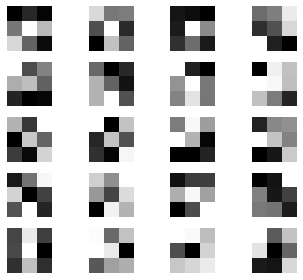

average of absolute gradients 1 tensor(5.0554e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1731e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1067e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6026e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8392e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1995e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3958e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7120e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5988e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0044e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1958e-06, device='cuda:0')


 60%|███████████████████████████████████████████████▋                               | 604/1000 [50:33<33:27,  5.07s/it]

Epoch: 604
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-1.9698e-01, -1.3015e-01, -1.8796e-01],
         [-1.1072e-04,  2.2434e-01,  1.0966e-01],
         [ 1.5938e-01, -3.3220e-02, -1.7827e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


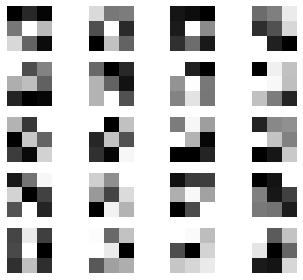

average of absolute gradients 1 tensor(3.0892e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7886e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6188e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0070e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2160e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7795e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8296e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4839e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3169e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3532e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6445e-06, device='cuda:0')


 60%|███████████████████████████████████████████████▊                               | 605/1000 [50:38<33:18,  5.06s/it]

Epoch: 605
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-1.9686e-01, -1.3025e-01, -1.8803e-01],
         [ 5.5464e-05,  2.2432e-01,  1.0974e-01],
         [ 1.5881e-01, -3.3430e-02, -1.7844e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


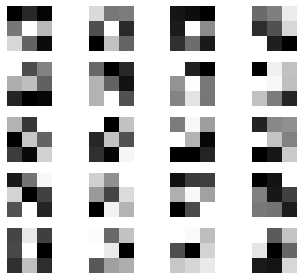

average of absolute gradients 1 tensor(3.2119e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8210e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0573e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3252e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0125e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5115e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8074e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3144e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7735e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8063e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4750e-06, device='cuda:0')


 61%|███████████████████████████████████████████████▊                               | 606/1000 [50:43<33:11,  5.06s/it]

Epoch: 606
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-1.9697e-01, -1.3019e-01, -1.8778e-01],
         [-1.3942e-04,  2.2416e-01,  1.0963e-01],
         [ 1.5928e-01, -3.3140e-02, -1.7829e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


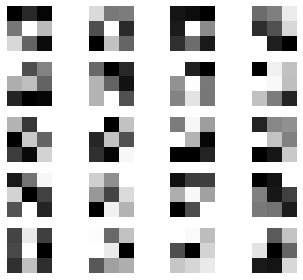

average of absolute gradients 1 tensor(3.4443e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9126e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3096e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2836e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5637e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7758e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5515e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8652e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9089e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0404e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3039e-06, device='cuda:0')


 61%|███████████████████████████████████████████████▉                               | 607/1000 [50:48<33:00,  5.04s/it]

Epoch: 607
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1971, -0.1303, -0.1880],
         [-0.0003,  0.2239,  0.1096],
         [ 0.1587, -0.0334, -0.1784]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


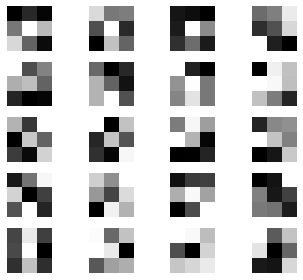

average of absolute gradients 1 tensor(3.3014e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3603e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5757e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0551e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3154e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1949e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2429e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9991e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9410e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3080e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3364e-06, device='cuda:0')


 61%|████████████████████████████████████████████████                               | 608/1000 [50:53<32:57,  5.04s/it]

Epoch: 608
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-0.1970, -0.1302, -0.1875],
         [ 0.0003,  0.2243,  0.1101],
         [ 0.1587, -0.0331, -0.1781]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


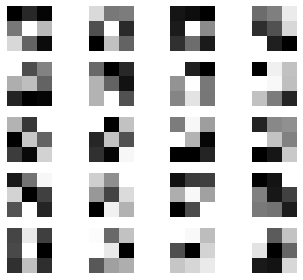

average of absolute gradients 1 tensor(3.6551e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5765e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1890e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0551e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4913e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4930e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2169e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2229e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2477e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1704e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4456e-06, device='cuda:0')


 61%|████████████████████████████████████████████████                               | 609/1000 [50:58<32:48,  5.03s/it]

Epoch: 609
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-1.9684e-01, -1.3048e-01, -1.8760e-01],
         [-4.4423e-05,  2.2366e-01,  1.1040e-01],
         [ 1.5902e-01, -3.3427e-02, -1.7799e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


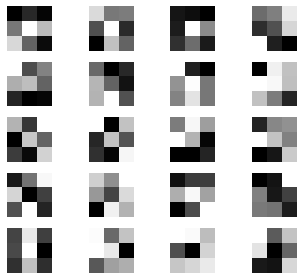

average of absolute gradients 1 tensor(5.0228e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5385e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1129e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3401e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5429e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4247e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7307e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9823e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0858e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2146e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8092e-06, device='cuda:0')


 61%|████████████████████████████████████████████████▏                              | 610/1000 [51:03<32:46,  5.04s/it]

Epoch: 610
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-1.9716e-01, -1.3015e-01, -1.8777e-01],
         [ 5.1343e-05,  2.2320e-01,  1.1003e-01],
         [ 1.5904e-01, -3.3351e-02, -1.7826e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


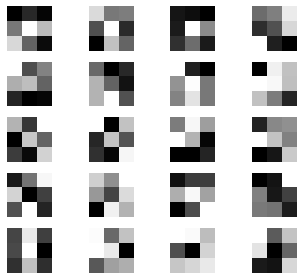

average of absolute gradients 1 tensor(3.6747e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6041e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7004e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8711e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6490e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2720e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9518e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5305e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7203e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9040e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8586e-06, device='cuda:0')


 61%|████████████████████████████████████████████████▎                              | 611/1000 [51:08<32:35,  5.03s/it]

Epoch: 611
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-1.9701e-01, -1.2990e-01, -1.8735e-01],
         [-3.2002e-05,  2.2397e-01,  1.1024e-01],
         [ 1.5885e-01, -3.2822e-02, -1.7797e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


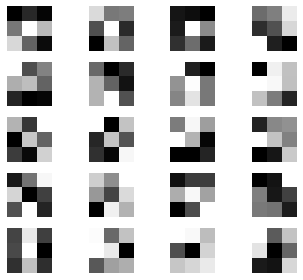

average of absolute gradients 1 tensor(4.9782e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9274e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4060e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4453e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0170e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8267e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0455e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5329e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9857e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1193e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.2581e-06, device='cuda:0')


 61%|████████████████████████████████████████████████▎                              | 612/1000 [51:13<32:33,  5.03s/it]

Epoch: 612
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-1.9765e-01, -1.3089e-01, -1.8723e-01],
         [ 1.8430e-04,  2.2263e-01,  1.0980e-01],
         [ 1.5906e-01, -3.2899e-02, -1.7817e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


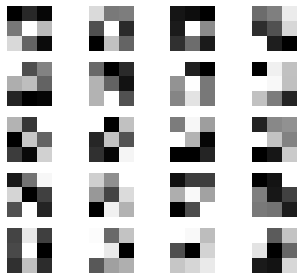

average of absolute gradients 1 tensor(5.1598e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6908e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9169e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4460e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7769e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4640e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1659e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6641e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9663e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6474e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0013e-06, device='cuda:0')


 61%|████████████████████████████████████████████████▍                              | 613/1000 [51:18<32:30,  5.04s/it]

Epoch: 613
Accuracy of train set: 22%
Accuracy of test set: 9%

tensor([[[-1.9712e-01, -1.3035e-01, -1.8689e-01],
         [-1.2544e-05,  2.2343e-01,  1.1045e-01],
         [ 1.5886e-01, -3.2976e-02, -1.7804e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


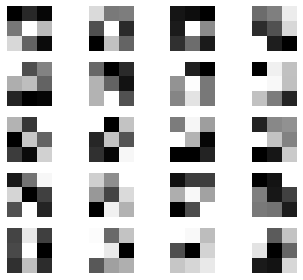

average of absolute gradients 1 tensor(4.5445e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0022e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3265e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1617e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2300e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4940e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1771e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9075e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3844e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8815e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4675e-06, device='cuda:0')


 61%|████████████████████████████████████████████████▌                              | 614/1000 [51:23<32:26,  5.04s/it]

Epoch: 614
Accuracy of train set: 22%
Accuracy of test set: 10%

tensor([[[-1.9713e-01, -1.3074e-01, -1.8641e-01],
         [ 2.1458e-04,  2.2330e-01,  1.1051e-01],
         [ 1.5894e-01, -3.2877e-02, -1.7808e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


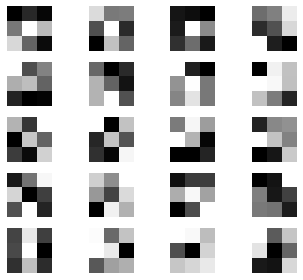

average of absolute gradients 1 tensor(4.8820e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6633e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8863e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8687e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0829e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6322e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0680e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0058e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0586e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8280e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0000e-06, device='cuda:0')


 62%|████████████████████████████████████████████████▌                              | 615/1000 [51:28<32:19,  5.04s/it]

Epoch: 615
Accuracy of train set: 22%
Accuracy of test set: 10%

tensor([[[-1.9670e-01, -1.3105e-01, -1.8600e-01],
         [ 1.7862e-04,  2.2368e-01,  1.1109e-01],
         [ 1.5884e-01, -3.2809e-02, -1.7776e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


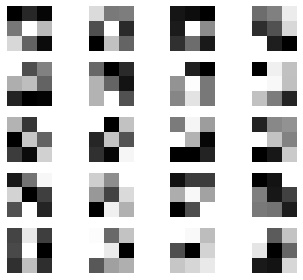

average of absolute gradients 1 tensor(4.2631e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4078e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0169e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8044e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1288e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6948e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8468e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1435e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.5272e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1108e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3113e-06, device='cuda:0')


 62%|████████████████████████████████████████████████▋                              | 616/1000 [51:33<32:17,  5.05s/it]

Epoch: 616
Accuracy of train set: 22%
Accuracy of test set: 10%

tensor([[[-0.1966, -0.1313, -0.1861],
         [-0.0008,  0.2232,  0.1105],
         [ 0.1592, -0.0328, -0.1780]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


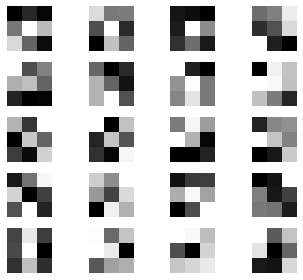

average of absolute gradients 1 tensor(4.6270e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3889e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3394e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7239e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1362e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9528e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3545e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2728e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0533e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5299e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7082e-06, device='cuda:0')


 62%|████████████████████████████████████████████████▋                              | 617/1000 [51:38<32:07,  5.03s/it]

Epoch: 617
Accuracy of train set: 23%
Accuracy of test set: 9%

tensor([[[-0.1966, -0.1314, -0.1858],
         [-0.0007,  0.2236,  0.1107],
         [ 0.1589, -0.0326, -0.1777]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


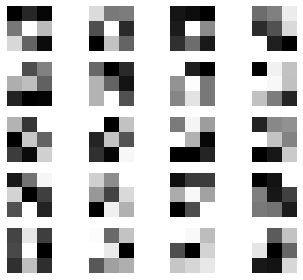

average of absolute gradients 1 tensor(4.2955e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0253e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9719e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0016e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3355e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3545e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5311e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7078e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2882e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5574e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7130e-06, device='cuda:0')


 62%|████████████████████████████████████████████████▊                              | 618/1000 [51:43<32:04,  5.04s/it]

Epoch: 618
Accuracy of train set: 23%
Accuracy of test set: 9%

tensor([[[-0.1966, -0.1318, -0.1857],
         [-0.0004,  0.2233,  0.1107],
         [ 0.1589, -0.0334, -0.1775]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


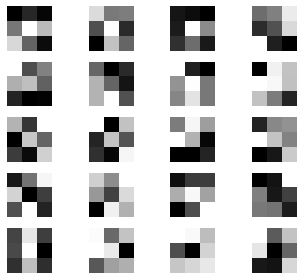

average of absolute gradients 1 tensor(6.7958e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1894e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1988e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0563e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3802e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2810e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3545e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1648e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9397e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8029e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.0201e-06, device='cuda:0')


 62%|████████████████████████████████████████████████▉                              | 619/1000 [51:48<31:56,  5.03s/it]

Epoch: 619
Accuracy of train set: 23%
Accuracy of test set: 9%

tensor([[[-1.9660e-01, -1.3206e-01, -1.8552e-01],
         [ 1.3802e-05,  2.2388e-01,  1.1002e-01],
         [ 1.5824e-01, -3.3477e-02, -1.7750e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


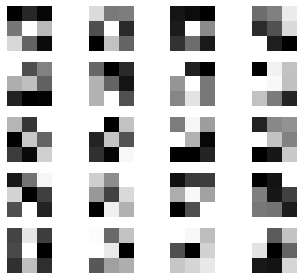

average of absolute gradients 1 tensor(5.8303e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4430e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3292e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9656e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2267e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6705e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1084e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0454e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5587e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2673e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4586e-06, device='cuda:0')


 62%|████████████████████████████████████████████████▉                              | 620/1000 [51:53<31:57,  5.05s/it]

Epoch: 620
Accuracy of train set: 23%
Accuracy of test set: 9%

tensor([[[-0.1963, -0.1323, -0.1854],
         [-0.0005,  0.2241,  0.1103],
         [ 0.1575, -0.0336, -0.1778]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


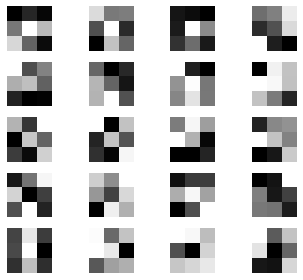

average of absolute gradients 1 tensor(5.1777e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0041e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7716e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8693e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7467e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4992e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2340e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1049e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8835e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3997e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4941e-06, device='cuda:0')


 62%|█████████████████████████████████████████████████                              | 621/1000 [51:59<31:53,  5.05s/it]

Epoch: 621
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1965, -0.1320, -0.1856],
         [-0.0007,  0.2238,  0.1102],
         [ 0.1571, -0.0333, -0.1781]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


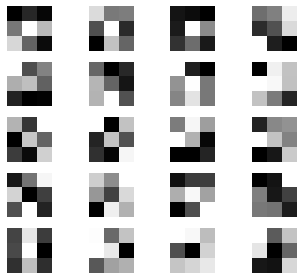

average of absolute gradients 1 tensor(5.3390e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0947e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7636e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8240e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2012e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6896e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5839e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8982e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7396e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2554e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0843e-06, device='cuda:0')


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [52:04<31:52,  5.06s/it]

Epoch: 622
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1966, -0.1318, -0.1855],
         [-0.0003,  0.2242,  0.1100],
         [ 0.1569, -0.0326, -0.1779]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


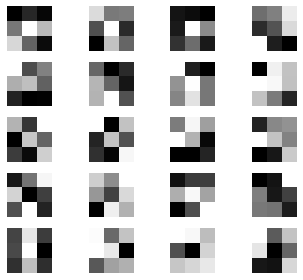

average of absolute gradients 1 tensor(5.6337e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4627e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2835e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1481e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6852e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9536e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7194e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6018e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9216e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5282e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0743e-06, device='cuda:0')


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [52:09<31:47,  5.06s/it]

Epoch: 623
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1968, -0.1326, -0.1858],
         [-0.0008,  0.2237,  0.1093],
         [ 0.1563, -0.0332, -0.1782]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


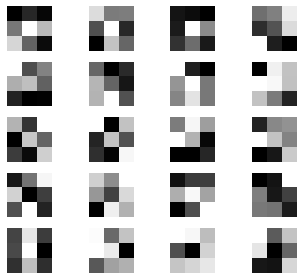

average of absolute gradients 1 tensor(5.5566e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7257e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9713e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2768e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1725e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2575e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1746e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4227e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2979e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2530e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3300e-06, device='cuda:0')


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [52:14<31:41,  5.06s/it]

Epoch: 624
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1957, -0.1316, -0.1852],
         [-0.0005,  0.2246,  0.1108],
         [ 0.1569, -0.0323, -0.1779]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


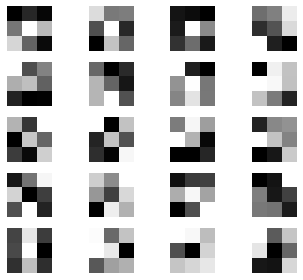

average of absolute gradients 1 tensor(4.4282e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0050e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1674e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5888e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9778e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6240e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3481e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5263e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9580e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8910e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0926e-06, device='cuda:0')


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [52:19<31:33,  5.05s/it]

Epoch: 625
Accuracy of train set: 23%
Accuracy of test set: 9%

tensor([[[-0.1961, -0.1322, -0.1860],
         [-0.0010,  0.2235,  0.1105],
         [ 0.1561, -0.0330, -0.1782]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


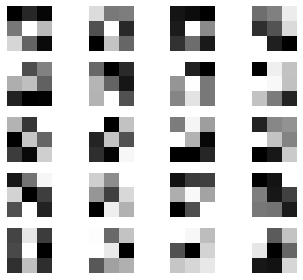

average of absolute gradients 1 tensor(5.1318e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4688e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6394e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9050e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4755e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4672e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4453e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0336e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7372e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9429e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6430e-06, device='cuda:0')


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [52:24<31:27,  5.05s/it]

Epoch: 626
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1958, -0.1321, -0.1857],
         [-0.0008,  0.2235,  0.1106],
         [ 0.1565, -0.0329, -0.1783]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


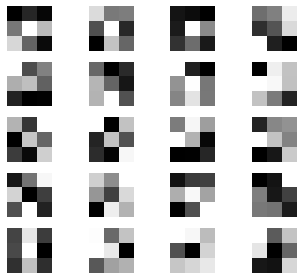

average of absolute gradients 1 tensor(5.5292e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6421e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9180e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9481e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9493e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8923e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0633e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3842e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5116e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3314e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.2365e-06, device='cuda:0')


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [52:29<31:30,  5.07s/it]

Epoch: 627
Accuracy of train set: 23%
Accuracy of test set: 9%

tensor([[[-0.1957, -0.1319, -0.1857],
         [-0.0010,  0.2238,  0.1107],
         [ 0.1559, -0.0329, -0.1785]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


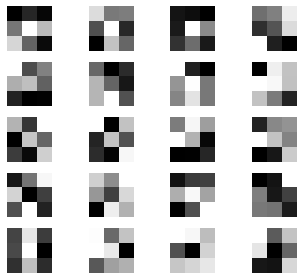

average of absolute gradients 1 tensor(6.3310e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3057e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8892e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2092e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1025e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4036e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4411e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0983e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0676e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2665e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1378e-06, device='cuda:0')


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [52:34<31:29,  5.08s/it]

Epoch: 628
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1958, -0.1316, -0.1856],
         [-0.0011,  0.2237,  0.1101],
         [ 0.1564, -0.0329, -0.1785]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


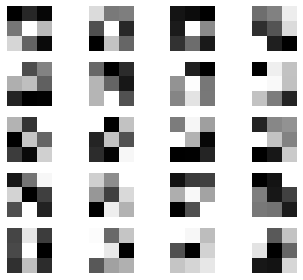

average of absolute gradients 1 tensor(5.2435e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7218e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3178e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8402e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8537e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7199e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7022e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2286e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8331e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0609e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3026e-06, device='cuda:0')


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [52:39<31:22,  5.07s/it]

Epoch: 629
Accuracy of train set: 23%
Accuracy of test set: 9%

tensor([[[-0.1956, -0.1315, -0.1851],
         [-0.0009,  0.2239,  0.1110],
         [ 0.1562, -0.0331, -0.1784]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


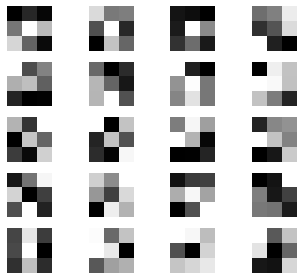

average of absolute gradients 1 tensor(5.8612e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9906e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8995e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4626e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9594e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3857e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3562e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7928e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3217e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4577e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2995e-06, device='cuda:0')


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [52:44<31:12,  5.06s/it]

Epoch: 630
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1963, -0.1319, -0.1853],
         [-0.0009,  0.2233,  0.1098],
         [ 0.1563, -0.0329, -0.1784]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


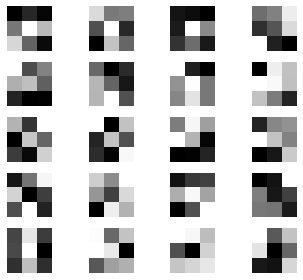

average of absolute gradients 1 tensor(6.2285e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0481e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6168e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8963e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0130e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2500e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1571e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2510e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3723e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7477e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5478e-06, device='cuda:0')


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [52:49<31:07,  5.06s/it]

Epoch: 631
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1962, -0.1318, -0.1849],
         [-0.0007,  0.2237,  0.1102],
         [ 0.1561, -0.0329, -0.1782]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


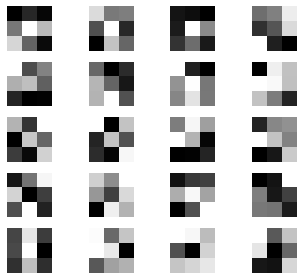

average of absolute gradients 1 tensor(4.6984e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7548e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1007e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4351e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0871e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3673e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6521e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5644e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5496e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6012e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.0794e-06, device='cuda:0')


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [52:54<31:18,  5.10s/it]

Epoch: 632
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1958, -0.1323, -0.1849],
         [-0.0014,  0.2235,  0.1100],
         [ 0.1564, -0.0334, -0.1780]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


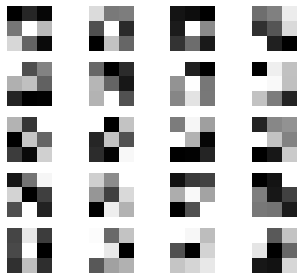

average of absolute gradients 1 tensor(5.7358e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5293e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7553e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0913e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9336e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8477e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9427e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5931e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8646e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5175e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7038e-06, device='cuda:0')


 63%|██████████████████████████████████████████████████                             | 633/1000 [53:00<31:15,  5.11s/it]

Epoch: 633
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1959, -0.1325, -0.1847],
         [-0.0015,  0.2236,  0.1097],
         [ 0.1564, -0.0329, -0.1778]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


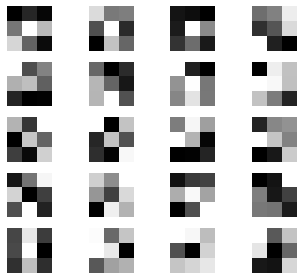

average of absolute gradients 1 tensor(4.7820e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4460e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4350e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7815e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1880e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7663e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1444e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4237e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3719e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9734e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8217e-06, device='cuda:0')


 63%|██████████████████████████████████████████████████                             | 634/1000 [53:05<31:06,  5.10s/it]

Epoch: 634
Accuracy of train set: 23%
Accuracy of test set: 9%

tensor([[[-0.1960, -0.1326, -0.1848],
         [-0.0019,  0.2236,  0.1093],
         [ 0.1566, -0.0326, -0.1776]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


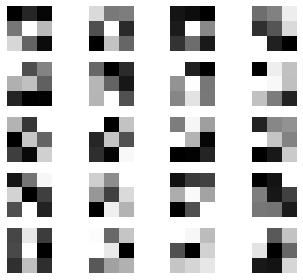

average of absolute gradients 1 tensor(5.0302e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1399e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6425e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7218e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5021e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3019e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8236e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5085e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7908e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4035e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8217e-06, device='cuda:0')


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [53:10<31:03,  5.11s/it]

Epoch: 635
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1959, -0.1325, -0.1845],
         [-0.0018,  0.2236,  0.1095],
         [ 0.1568, -0.0329, -0.1773]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


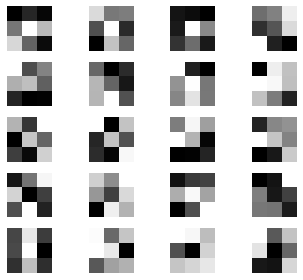

average of absolute gradients 1 tensor(4.3354e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2534e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7670e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5132e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1267e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5684e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2661e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2305e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9001e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4328e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8770e-06, device='cuda:0')


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [53:15<30:57,  5.10s/it]

Epoch: 636
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1962, -0.1329, -0.1848],
         [-0.0020,  0.2233,  0.1087],
         [ 0.1564, -0.0328, -0.1774]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


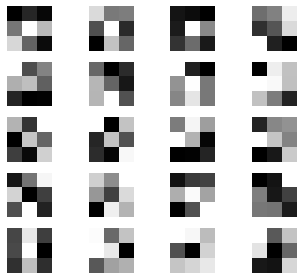

average of absolute gradients 1 tensor(5.5273e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0250e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1685e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4145e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2027e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0631e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4981e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9844e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5936e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1152e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4746e-06, device='cuda:0')


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [53:20<30:46,  5.09s/it]

Epoch: 637
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1956, -0.1323, -0.1845],
         [-0.0021,  0.2240,  0.1092],
         [ 0.1568, -0.0326, -0.1771]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


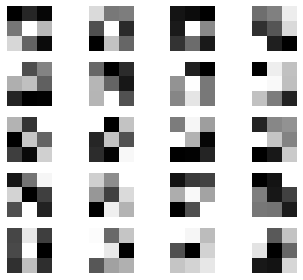

average of absolute gradients 1 tensor(4.7422e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9359e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3376e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9517e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8490e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5903e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3936e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5039e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8347e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3666e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9882e-06, device='cuda:0')


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [53:25<30:41,  5.09s/it]

Epoch: 638
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1957, -0.1328, -0.1843],
         [-0.0021,  0.2235,  0.1090],
         [ 0.1571, -0.0329, -0.1770]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


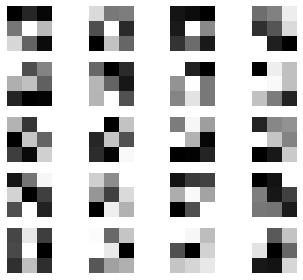

average of absolute gradients 1 tensor(4.5420e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6994e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2892e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3204e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1365e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8689e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1516e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5994e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9394e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4650e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3797e-06, device='cuda:0')


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [53:30<30:38,  5.09s/it]

Epoch: 639
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1956, -0.1327, -0.1842],
         [-0.0019,  0.2236,  0.1088],
         [ 0.1575, -0.0329, -0.1767]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


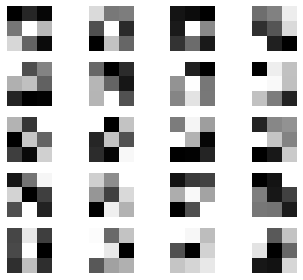

average of absolute gradients 1 tensor(4.3983e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7594e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3172e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7945e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9470e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5973e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4052e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6119e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2310e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7803e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1499e-06, device='cuda:0')


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [53:35<30:39,  5.11s/it]

Epoch: 640
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1948, -0.1324, -0.1841],
         [-0.0020,  0.2242,  0.1092],
         [ 0.1580, -0.0327, -0.1763]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


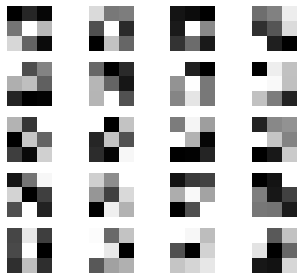

average of absolute gradients 1 tensor(5.4919e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0050e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6461e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9631e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7783e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2237e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6418e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5123e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9768e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6235e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1544e-06, device='cuda:0')


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [53:40<30:36,  5.11s/it]

Epoch: 641
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1951, -0.1326, -0.1843],
         [-0.0021,  0.2241,  0.1088],
         [ 0.1577, -0.0329, -0.1761]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


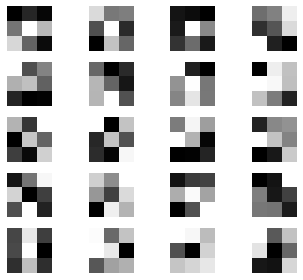

average of absolute gradients 1 tensor(4.2811e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5859e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2091e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7475e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9269e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1461e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3759e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3063e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3386e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6822e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0075e-06, device='cuda:0')


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [53:45<30:25,  5.10s/it]

Epoch: 642
Accuracy of train set: 23%
Accuracy of test set: 9%

tensor([[[-0.1949, -0.1322, -0.1844],
         [-0.0024,  0.2245,  0.1085],
         [ 0.1577, -0.0328, -0.1759]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


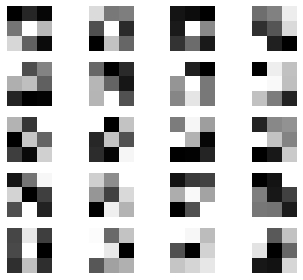

average of absolute gradients 1 tensor(5.0645e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9104e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6547e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5754e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6268e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8220e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8074e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9091e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1320e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6407e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8549e-06, device='cuda:0')


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [53:51<30:21,  5.10s/it]

Epoch: 643
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1951, -0.1324, -0.1846],
         [-0.0026,  0.2238,  0.1086],
         [ 0.1577, -0.0332, -0.1759]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


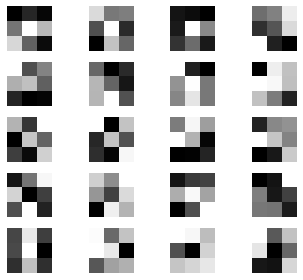

average of absolute gradients 1 tensor(3.4183e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0998e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9639e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4684e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3313e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8252e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1842e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9242e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3675e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1197e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4503e-06, device='cuda:0')


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [53:56<30:15,  5.10s/it]

Epoch: 644
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1947, -0.1319, -0.1845],
         [-0.0022,  0.2244,  0.1085],
         [ 0.1578, -0.0333, -0.1757]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


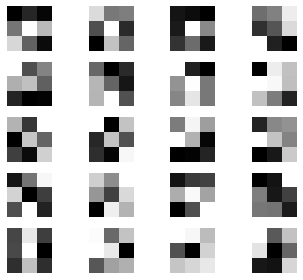

average of absolute gradients 1 tensor(3.9748e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2958e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9899e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3643e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8534e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0052e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2593e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0180e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2840e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2183e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0458e-06, device='cuda:0')


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [54:01<30:06,  5.09s/it]

Epoch: 645
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1945, -0.1321, -0.1843],
         [-0.0026,  0.2244,  0.1090],
         [ 0.1574, -0.0332, -0.1757]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


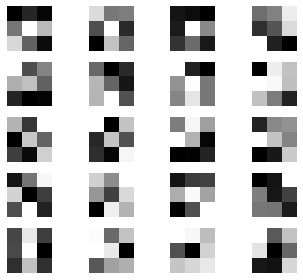

average of absolute gradients 1 tensor(4.5043e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1470e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3120e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0067e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3181e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8256e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1394e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0511e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2439e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5016e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9496e-06, device='cuda:0')


 65%|███████████████████████████████████████████████████                            | 646/1000 [54:06<30:09,  5.11s/it]

Epoch: 646
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1945, -0.1323, -0.1845],
         [-0.0025,  0.2242,  0.1084],
         [ 0.1576, -0.0334, -0.1756]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


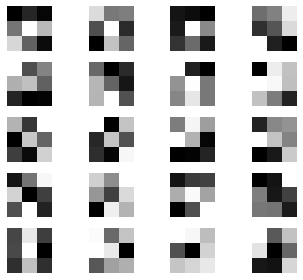

average of absolute gradients 1 tensor(3.3859e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6744e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7307e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8444e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8737e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0199e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8198e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5892e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6197e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0487e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1452e-06, device='cuda:0')


 65%|███████████████████████████████████████████████████                            | 647/1000 [54:11<30:06,  5.12s/it]

Epoch: 647
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1948, -0.1323, -0.1850],
         [-0.0022,  0.2239,  0.1081],
         [ 0.1573, -0.0337, -0.1755]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


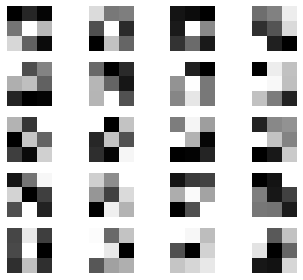

average of absolute gradients 1 tensor(4.6477e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3576e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6305e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2907e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6664e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3456e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2449e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6198e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8754e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1332e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9112e-06, device='cuda:0')


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [54:16<30:11,  5.15s/it]

Epoch: 648
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1948, -0.1322, -0.1850],
         [-0.0026,  0.2237,  0.1082],
         [ 0.1574, -0.0339, -0.1753]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


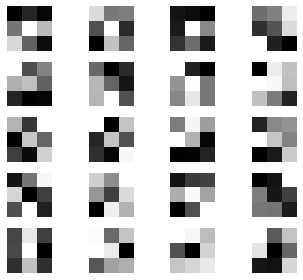

average of absolute gradients 1 tensor(5.0434e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4424e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6840e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6662e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6274e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1040e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5519e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2148e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8699e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8835e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5481e-06, device='cuda:0')


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [54:21<29:58,  5.12s/it]

Epoch: 649
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1947, -0.1315, -0.1851],
         [-0.0025,  0.2243,  0.1083],
         [ 0.1571, -0.0338, -0.1750]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


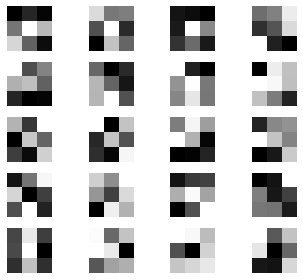

average of absolute gradients 1 tensor(4.4016e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4735e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2004e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6562e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3549e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9957e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6800e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6570e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1702e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5221e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9348e-06, device='cuda:0')


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [54:26<29:50,  5.12s/it]

Epoch: 650
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1950, -0.1324, -0.1851],
         [-0.0023,  0.2237,  0.1081],
         [ 0.1568, -0.0345, -0.1748]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


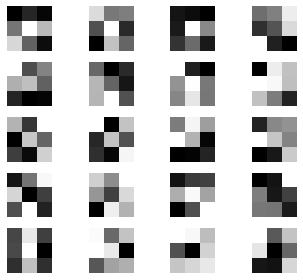

average of absolute gradients 1 tensor(4.2989e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3120e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7375e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3971e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8347e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0069e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9804e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0129e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5836e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4624e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5028e-06, device='cuda:0')


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [54:32<30:04,  5.17s/it]

Epoch: 651
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1949, -0.1318, -0.1849],
         [-0.0021,  0.2243,  0.1082],
         [ 0.1569, -0.0342, -0.1746]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


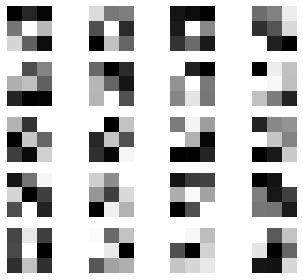

average of absolute gradients 1 tensor(4.2763e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6712e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9443e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4126e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5057e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1191e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9493e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7136e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7097e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4881e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8804e-06, device='cuda:0')


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [54:37<29:56,  5.16s/it]

Epoch: 652
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1949, -0.1320, -0.1853],
         [-0.0027,  0.2239,  0.1079],
         [ 0.1567, -0.0347, -0.1746]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


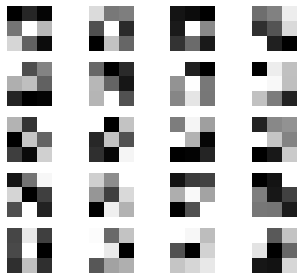

average of absolute gradients 1 tensor(4.2835e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0585e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7334e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9641e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4858e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4984e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6665e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3196e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9717e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7680e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2634e-06, device='cuda:0')


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [54:42<29:44,  5.14s/it]

Epoch: 653
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1946, -0.1318, -0.1851],
         [-0.0025,  0.2241,  0.1079],
         [ 0.1570, -0.0349, -0.1745]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


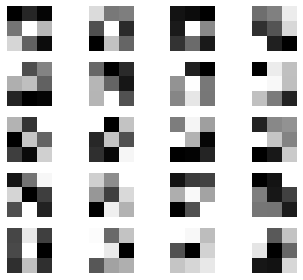

average of absolute gradients 1 tensor(4.9050e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4968e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5944e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2194e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4356e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0066e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5734e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4709e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8880e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8722e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9063e-06, device='cuda:0')


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [54:47<29:36,  5.13s/it]

Epoch: 654
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1946, -0.1320, -0.1849],
         [-0.0026,  0.2243,  0.1081],
         [ 0.1566, -0.0351, -0.1742]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


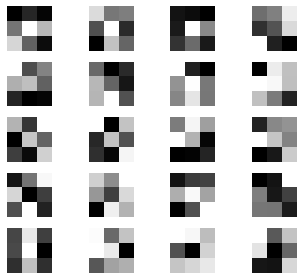

average of absolute gradients 1 tensor(5.1974e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8070e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7191e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3364e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8680e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9592e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8217e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4290e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1212e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7067e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3428e-06, device='cuda:0')


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [54:52<29:27,  5.12s/it]

Epoch: 655
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1947, -0.1323, -0.1848],
         [-0.0027,  0.2240,  0.1078],
         [ 0.1568, -0.0351, -0.1741]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


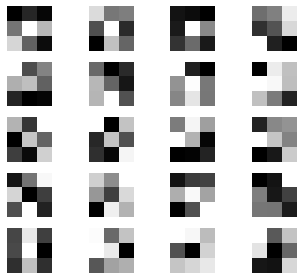

average of absolute gradients 1 tensor(5.9974e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1435e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7611e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5359e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5982e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8125e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2297e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7127e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3811e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3321e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1219e-06, device='cuda:0')


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [54:57<29:24,  5.13s/it]

Epoch: 656
Accuracy of train set: 23%
Accuracy of test set: 10%

tensor([[[-0.1948, -0.1323, -0.1848],
         [-0.0022,  0.2238,  0.1077],
         [ 0.1567, -0.0357, -0.1741]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


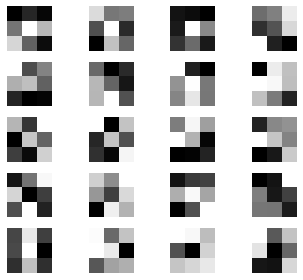

average of absolute gradients 1 tensor(7.4984e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5460e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2793e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2350e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8107e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6582e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8893e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6004e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5710e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0596e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9608e-06, device='cuda:0')


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [55:02<29:22,  5.14s/it]

Epoch: 657
Accuracy of train set: 24%
Accuracy of test set: 10%

tensor([[[-0.1942, -0.1320, -0.1849],
         [-0.0020,  0.2243,  0.1083],
         [ 0.1567, -0.0354, -0.1736]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


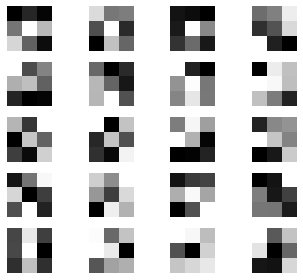

average of absolute gradients 1 tensor(4.2990e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6262e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8812e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1601e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7252e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2709e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9142e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1431e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7202e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1432e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7963e-06, device='cuda:0')


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [55:07<29:09,  5.12s/it]

Epoch: 658
Accuracy of train set: 24%
Accuracy of test set: 10%

tensor([[[-0.1942, -0.1325, -0.1850],
         [-0.0023,  0.2236,  0.1082],
         [ 0.1572, -0.0356, -0.1735]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


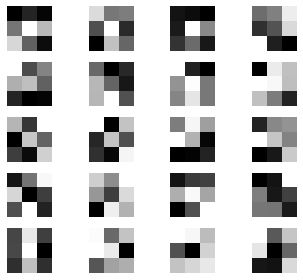

average of absolute gradients 1 tensor(6.5339e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7342e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9350e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.3061e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6749e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7669e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5856e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9665e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4026e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7472e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.3760e-06, device='cuda:0')


 66%|████████████████████████████████████████████████████                           | 659/1000 [55:13<28:59,  5.10s/it]

Epoch: 659
Accuracy of train set: 24%
Accuracy of test set: 9%

tensor([[[-0.1940, -0.1332, -0.1850],
         [-0.0028,  0.2229,  0.1079],
         [ 0.1576, -0.0359, -0.1735]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


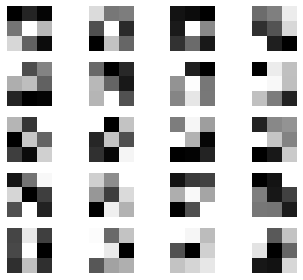

average of absolute gradients 1 tensor(6.6111e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1457e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1112e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4777e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6196e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1857e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.4739e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0736e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2080e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.4963e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9904e-06, device='cuda:0')


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [55:18<28:48,  5.09s/it]

Epoch: 660
Accuracy of train set: 24%
Accuracy of test set: 10%

tensor([[[-0.1943, -0.1335, -0.1854],
         [-0.0032,  0.2228,  0.1076],
         [ 0.1567, -0.0361, -0.1735]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


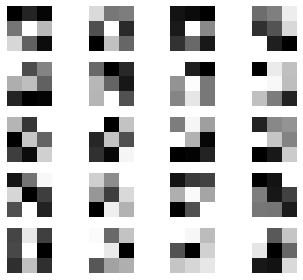

average of absolute gradients 1 tensor(5.7805e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8899e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8600e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3106e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0849e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6105e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4864e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4944e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5373e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8621e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.2302e-06, device='cuda:0')


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [55:23<28:44,  5.09s/it]

Epoch: 661
Accuracy of train set: 24%
Accuracy of test set: 9%

tensor([[[-0.1940, -0.1334, -0.1854],
         [-0.0034,  0.2232,  0.1080],
         [ 0.1561, -0.0360, -0.1735]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


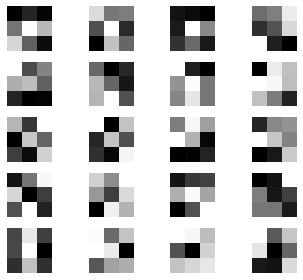

average of absolute gradients 1 tensor(5.5277e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7093e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1800e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3479e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5319e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2106e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0843e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8844e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5918e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.1997e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2306e-06, device='cuda:0')


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [55:28<28:41,  5.09s/it]

Epoch: 662
Accuracy of train set: 24%
Accuracy of test set: 9%

tensor([[[-0.1935, -0.1331, -0.1853],
         [-0.0034,  0.2231,  0.1080],
         [ 0.1568, -0.0363, -0.1736]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


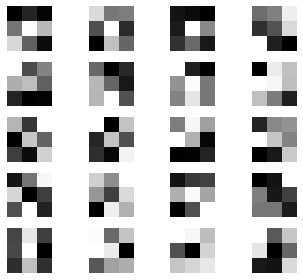

average of absolute gradients 1 tensor(7.4315e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4530e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7096e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3800e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9738e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.0060e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0320e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9865e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3563e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2197e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4473e-06, device='cuda:0')


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [55:33<28:41,  5.11s/it]

Epoch: 663
Accuracy of train set: 24%
Accuracy of test set: 10%

tensor([[[-0.1934, -0.1335, -0.1855],
         [-0.0029,  0.2227,  0.1083],
         [ 0.1567, -0.0360, -0.1737]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


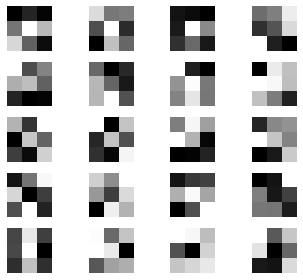

average of absolute gradients 1 tensor(6.0795e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0388e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9080e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3205e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.2718e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.2571e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3040e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.4990e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9865e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0146e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.4096e-06, device='cuda:0')


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [55:38<28:41,  5.12s/it]

Epoch: 664
Accuracy of train set: 24%
Accuracy of test set: 9%

tensor([[[-0.1928, -0.1334, -0.1860],
         [-0.0028,  0.2226,  0.1084],
         [ 0.1563, -0.0361, -0.1737]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


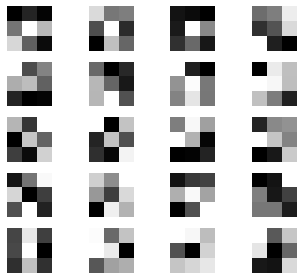

average of absolute gradients 1 tensor(8.5375e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2296e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4771e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1858e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.9855e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8801e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6875e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7723e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2822e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5589e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5353e-06, device='cuda:0')


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [55:43<28:29,  5.10s/it]

Epoch: 665
Accuracy of train set: 24%
Accuracy of test set: 10%

tensor([[[-0.1929, -0.1334, -0.1857],
         [-0.0039,  0.2226,  0.1078],
         [ 0.1569, -0.0357, -0.1739]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


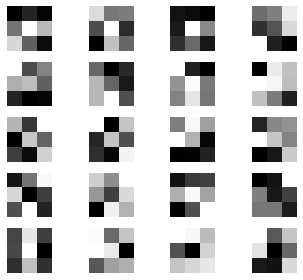

average of absolute gradients 1 tensor(5.9706e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4682e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7014e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5597e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1742e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6107e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8798e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6046e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5142e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5560e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1830e-06, device='cuda:0')


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [55:48<28:21,  5.10s/it]

Epoch: 666
Accuracy of train set: 24%
Accuracy of test set: 9%

tensor([[[-0.1933, -0.1337, -0.1857],
         [-0.0029,  0.2222,  0.1083],
         [ 0.1561, -0.0362, -0.1739]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


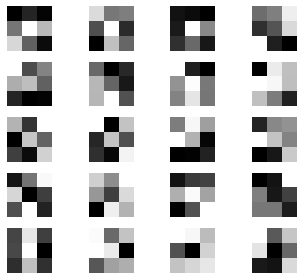

average of absolute gradients 1 tensor(6.6669e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4445e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2524e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7801e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1561e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1746e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.9029e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8875e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0896e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3964e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4774e-06, device='cuda:0')


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [55:53<28:09,  5.07s/it]

Epoch: 667
Accuracy of train set: 24%
Accuracy of test set: 10%

tensor([[[-0.1938, -0.1337, -0.1858],
         [-0.0031,  0.2218,  0.1079],
         [ 0.1558, -0.0365, -0.1739]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


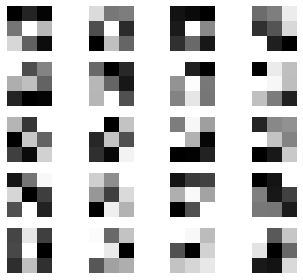

average of absolute gradients 1 tensor(6.3794e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.1726e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7899e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1959e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2591e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5035e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5939e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5628e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.9512e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2453e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3547e-06, device='cuda:0')


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [55:58<28:02,  5.07s/it]

Epoch: 668
Accuracy of train set: 24%
Accuracy of test set: 10%

tensor([[[-0.1936, -0.1333, -0.1855],
         [-0.0028,  0.2220,  0.1084],
         [ 0.1565, -0.0363, -0.1735]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


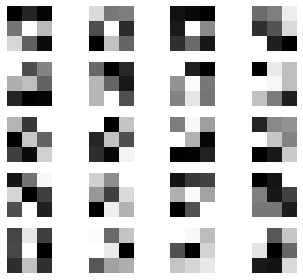

average of absolute gradients 1 tensor(6.2316e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9848e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6900e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.0661e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9081e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0222e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0576e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0107e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1670e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1283e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7398e-06, device='cuda:0')


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [56:03<27:56,  5.07s/it]

Epoch: 669
Accuracy of train set: 24%
Accuracy of test set: 10%

tensor([[[-0.1939, -0.1333, -0.1859],
         [-0.0028,  0.2218,  0.1079],
         [ 0.1559, -0.0359, -0.1735]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


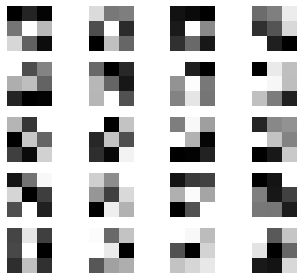

average of absolute gradients 1 tensor(5.9539e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7064e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0345e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3193e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1879e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2734e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8933e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8778e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7866e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8339e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.6232e-06, device='cuda:0')


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [56:08<27:49,  5.06s/it]

Epoch: 670
Accuracy of train set: 24%
Accuracy of test set: 9%

tensor([[[-0.1939, -0.1338, -0.1853],
         [-0.0015,  0.2221,  0.1080],
         [ 0.1558, -0.0361, -0.1733]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


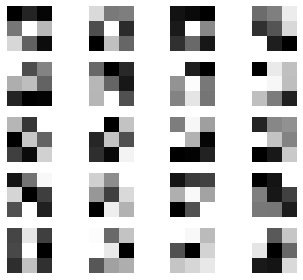

average of absolute gradients 1 tensor(7.0087e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8624e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7443e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2199e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4586e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7933e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5437e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6108e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6950e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5395e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9483e-06, device='cuda:0')


 67%|█████████████████████████████████████████████████████                          | 671/1000 [56:13<27:42,  5.05s/it]

Epoch: 671
Accuracy of train set: 24%
Accuracy of test set: 10%

tensor([[[-0.1945, -0.1341, -0.1856],
         [-0.0024,  0.2213,  0.1070],
         [ 0.1555, -0.0366, -0.1736]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


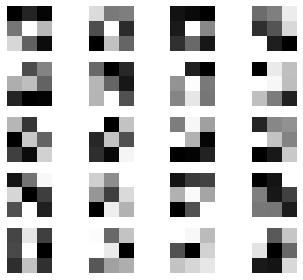

average of absolute gradients 1 tensor(5.6634e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7313e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6961e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4758e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9244e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1461e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5143e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3229e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8613e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8292e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.4574e-06, device='cuda:0')


 67%|█████████████████████████████████████████████████████                          | 672/1000 [56:19<27:39,  5.06s/it]

Epoch: 672
Accuracy of train set: 24%
Accuracy of test set: 10%

tensor([[[-0.1947, -0.1339, -0.1853],
         [-0.0023,  0.2214,  0.1073],
         [ 0.1554, -0.0361, -0.1735]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


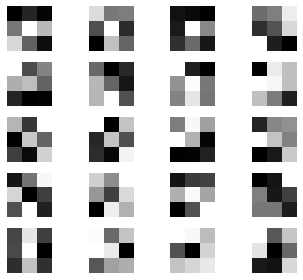

average of absolute gradients 1 tensor(7.1872e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3755e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9662e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1979e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7214e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0085e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5169e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6476e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5357e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8823e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.6823e-06, device='cuda:0')


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [56:24<27:31,  5.05s/it]

Epoch: 673
Accuracy of train set: 24%
Accuracy of test set: 10%

tensor([[[-0.1946, -0.1333, -0.1846],
         [-0.0017,  0.2218,  0.1079],
         [ 0.1558, -0.0367, -0.1733]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


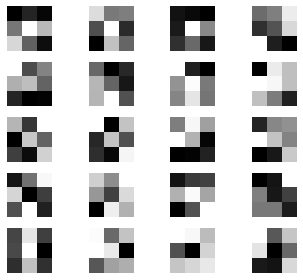

average of absolute gradients 1 tensor(5.6135e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8769e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2307e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0514e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8364e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1178e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0287e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.6307e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2089e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.9579e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8644e-06, device='cuda:0')


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [56:29<27:28,  5.06s/it]

Epoch: 674
Accuracy of train set: 24%
Accuracy of test set: 9%

tensor([[[-0.1949, -0.1337, -0.1851],
         [-0.0026,  0.2210,  0.1075],
         [ 0.1551, -0.0372, -0.1736]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


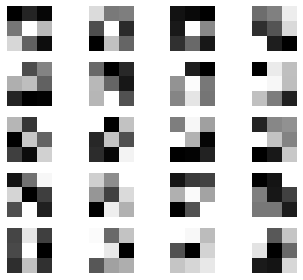

average of absolute gradients 1 tensor(7.5403e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4170e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9911e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2301e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1107e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0658e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7038e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7479e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3850e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4016e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5677e-06, device='cuda:0')


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [56:34<27:28,  5.07s/it]

Epoch: 675
Accuracy of train set: 24%
Accuracy of test set: 10%

tensor([[[-0.1945, -0.1334, -0.1847],
         [-0.0029,  0.2216,  0.1070],
         [ 0.1555, -0.0370, -0.1737]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


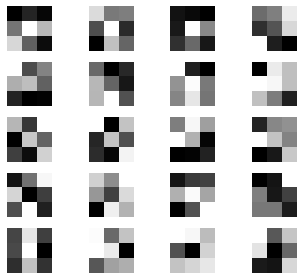

average of absolute gradients 1 tensor(6.4669e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4996e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7196e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4800e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6037e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.0794e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3810e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9897e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0484e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.9687e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9529e-06, device='cuda:0')


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [56:39<27:20,  5.06s/it]

Epoch: 676
Accuracy of train set: 24%
Accuracy of test set: 9%

tensor([[[-0.1944, -0.1332, -0.1844],
         [-0.0026,  0.2221,  0.1070],
         [ 0.1556, -0.0359, -0.1737]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


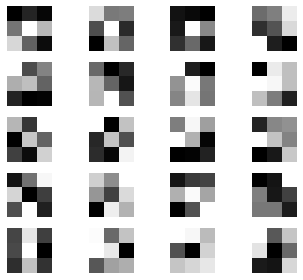

average of absolute gradients 1 tensor(5.5478e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7456e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5857e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7697e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7755e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3063e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9065e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0821e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2324e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.6365e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5189e-06, device='cuda:0')


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [56:44<27:13,  5.06s/it]

Epoch: 677
Accuracy of train set: 24%
Accuracy of test set: 10%

tensor([[[-0.1947, -0.1339, -0.1847],
         [-0.0028,  0.2215,  0.1069],
         [ 0.1549, -0.0367, -0.1737]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


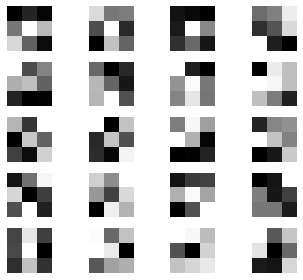

average of absolute gradients 1 tensor(5.4349e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3930e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9945e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4790e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6823e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5505e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3041e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.5916e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7059e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3583e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9148e-06, device='cuda:0')


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [56:49<27:08,  5.06s/it]

Epoch: 678
Accuracy of train set: 24%
Accuracy of test set: 10%

tensor([[[-0.1944, -0.1337, -0.1845],
         [-0.0030,  0.2217,  0.1069],
         [ 0.1552, -0.0365, -0.1737]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


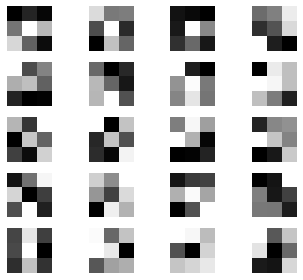

average of absolute gradients 1 tensor(5.7083e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5293e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7266e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7233e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9775e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7570e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1061e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5304e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.3489e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7812e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5498e-06, device='cuda:0')


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [56:54<27:02,  5.05s/it]

Epoch: 679
Accuracy of train set: 24%
Accuracy of test set: 10%

tensor([[[-0.1942, -0.1342, -0.1845],
         [-0.0034,  0.2214,  0.1069],
         [ 0.1551, -0.0366, -0.1737]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


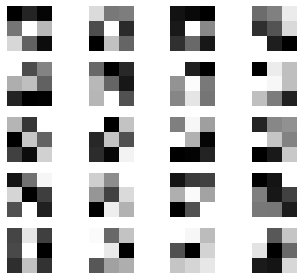

average of absolute gradients 1 tensor(5.6438e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4446e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9315e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4548e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6982e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2082e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4373e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8997e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.9067e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1449e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.4887e-06, device='cuda:0')


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [56:59<26:55,  5.05s/it]

Epoch: 680
Accuracy of train set: 24%
Accuracy of test set: 10%

tensor([[[-0.1941, -0.1341, -0.1843],
         [-0.0033,  0.2218,  0.1068],
         [ 0.1550, -0.0363, -0.1736]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


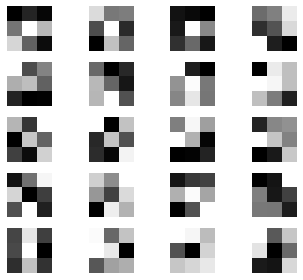

average of absolute gradients 1 tensor(5.7327e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1590e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4943e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0586e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5926e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3205e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4190e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2649e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3388e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1482e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.0894e-06, device='cuda:0')


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [57:04<26:48,  5.04s/it]

Epoch: 681
Accuracy of train set: 24%
Accuracy of test set: 9%

tensor([[[-0.1939, -0.1334, -0.1841],
         [-0.0041,  0.2224,  0.1068],
         [ 0.1556, -0.0359, -0.1733]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


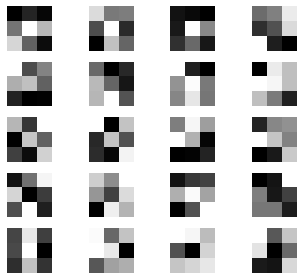

average of absolute gradients 1 tensor(5.9070e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7845e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6909e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.1456e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7808e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1909e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9272e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0617e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0959e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.9001e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.2754e-06, device='cuda:0')


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [57:09<26:45,  5.05s/it]

Epoch: 682
Accuracy of train set: 24%
Accuracy of test set: 9%

tensor([[[-0.1941, -0.1337, -0.1845],
         [-0.0044,  0.2226,  0.1067],
         [ 0.1542, -0.0360, -0.1732]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


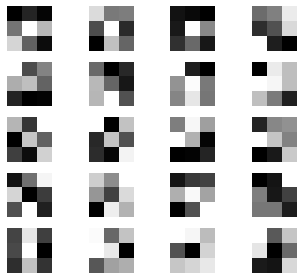

average of absolute gradients 1 tensor(5.6869e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7693e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6062e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5650e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4130e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9096e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.1521e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.0061e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1990e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.2198e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9383e-06, device='cuda:0')


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [57:14<26:42,  5.06s/it]

Epoch: 683
Accuracy of train set: 24%
Accuracy of test set: 9%

tensor([[[-0.1935, -0.1333, -0.1846],
         [-0.0047,  0.2231,  0.1073],
         [ 0.1540, -0.0353, -0.1730]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


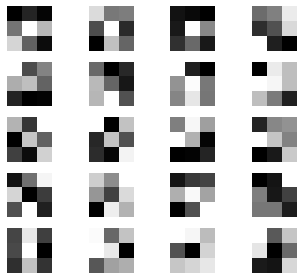

average of absolute gradients 1 tensor(6.7383e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2465e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1186e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9751e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3060e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.0089e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6526e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0670e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.4874e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9834e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1406e-06, device='cuda:0')


 68%|██████████████████████████████████████████████████████                         | 684/1000 [57:19<26:37,  5.06s/it]

Epoch: 684
Accuracy of train set: 24%
Accuracy of test set: 9%

tensor([[[-0.1935, -0.1335, -0.1849],
         [-0.0056,  0.2225,  0.1068],
         [ 0.1544, -0.0358, -0.1731]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


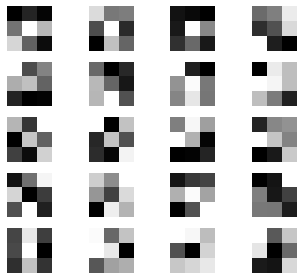

average of absolute gradients 1 tensor(6.0876e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5405e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6937e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4953e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0538e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8498e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6148e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8079e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.5212e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0353e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3760e-06, device='cuda:0')


 68%|██████████████████████████████████████████████████████                         | 685/1000 [57:24<26:30,  5.05s/it]

Epoch: 685
Accuracy of train set: 24%
Accuracy of test set: 10%

tensor([[[-0.1933, -0.1335, -0.1852],
         [-0.0055,  0.2226,  0.1069],
         [ 0.1539, -0.0358, -0.1730]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


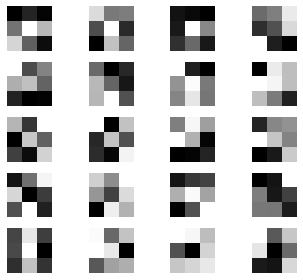

average of absolute gradients 1 tensor(5.4462e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8414e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7899e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2625e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4927e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2536e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3787e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2499e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5729e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.9033e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.1152e-06, device='cuda:0')


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [57:29<26:30,  5.07s/it]

Epoch: 686
Accuracy of train set: 24%
Accuracy of test set: 9%

tensor([[[-0.1934, -0.1335, -0.1852],
         [-0.0054,  0.2227,  0.1067],
         [ 0.1536, -0.0358, -0.1730]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


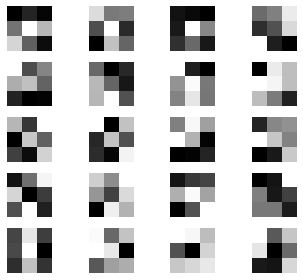

average of absolute gradients 1 tensor(7.3229e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6433e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1996e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9160e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.8286e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1445e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7590e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9786e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3280e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3357e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4002e-06, device='cuda:0')


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [57:34<26:21,  5.05s/it]

Epoch: 687
Accuracy of train set: 24%
Accuracy of test set: 9%

tensor([[[-0.1937, -0.1336, -0.1852],
         [-0.0057,  0.2225,  0.1063],
         [ 0.1537, -0.0357, -0.1728]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


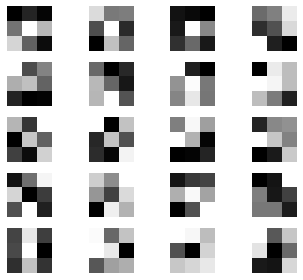

average of absolute gradients 1 tensor(5.8405e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3552e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5922e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0380e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6127e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2996e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5613e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9787e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.7448e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2966e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0384e-06, device='cuda:0')


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [57:39<26:25,  5.08s/it]

Epoch: 688
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1933, -0.1334, -0.1849],
         [-0.0058,  0.2228,  0.1066],
         [ 0.1540, -0.0355, -0.1727]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


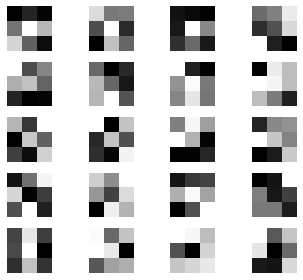

average of absolute gradients 1 tensor(6.7138e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8344e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6609e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0452e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2462e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2535e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5162e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6637e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2994e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1951e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6993e-06, device='cuda:0')


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [57:45<26:17,  5.07s/it]

Epoch: 689
Accuracy of train set: 24%
Accuracy of test set: 10%

tensor([[[-0.1928, -0.1334, -0.1846],
         [-0.0054,  0.2230,  0.1073],
         [ 0.1539, -0.0354, -0.1727]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


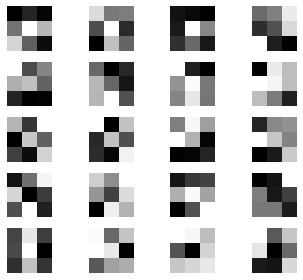

average of absolute gradients 1 tensor(6.5000e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2578e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0762e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4011e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.9774e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6729e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0230e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.6391e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2141e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4970e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2596e-06, device='cuda:0')


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [57:50<26:18,  5.09s/it]

Epoch: 690
Accuracy of train set: 25%
Accuracy of test set: 9%

tensor([[[-0.1932, -0.1333, -0.1847],
         [-0.0055,  0.2227,  0.1063],
         [ 0.1545, -0.0352, -0.1727]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


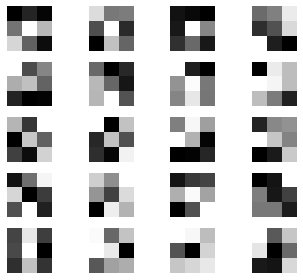

average of absolute gradients 1 tensor(6.9519e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.0380e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5782e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6722e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0802e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8241e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4371e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7654e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4484e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5405e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9748e-06, device='cuda:0')


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [57:55<26:14,  5.10s/it]

Epoch: 691
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1933, -0.1337, -0.1844],
         [-0.0052,  0.2225,  0.1068],
         [ 0.1537, -0.0356, -0.1729]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


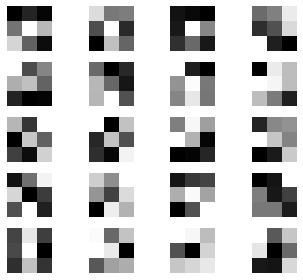

average of absolute gradients 1 tensor(6.1709e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3526e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2220e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9706e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4896e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6498e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7768e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0985e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7279e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9106e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0980e-06, device='cuda:0')


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [58:00<26:08,  5.09s/it]

Epoch: 692
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1934, -0.1340, -0.1841],
         [-0.0056,  0.2220,  0.1064],
         [ 0.1542, -0.0359, -0.1731]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


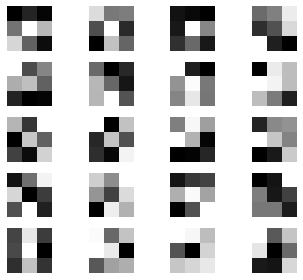

average of absolute gradients 1 tensor(5.8193e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8335e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1423e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4283e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4521e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3111e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3243e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0042e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2788e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0541e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4278e-06, device='cuda:0')


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [58:05<26:00,  5.08s/it]

Epoch: 693
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1933, -0.1337, -0.1838],
         [-0.0055,  0.2222,  0.1071],
         [ 0.1541, -0.0355, -0.1731]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


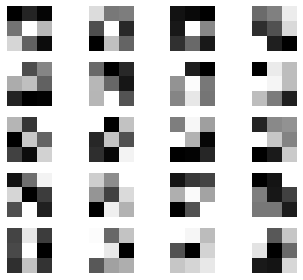

average of absolute gradients 1 tensor(5.8037e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2485e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4395e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9244e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6128e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3893e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2914e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8923e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5580e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3421e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9021e-06, device='cuda:0')


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [58:10<25:54,  5.08s/it]

Epoch: 694
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1932, -0.1338, -0.1840],
         [-0.0058,  0.2221,  0.1071],
         [ 0.1537, -0.0356, -0.1731]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


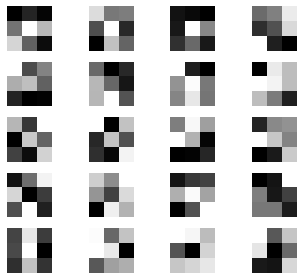

average of absolute gradients 1 tensor(4.6173e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7534e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8210e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3786e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8921e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5782e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8307e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1614e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6449e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8144e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9647e-06, device='cuda:0')


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [58:15<25:59,  5.11s/it]

Epoch: 695
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1935, -0.1340, -0.1838],
         [-0.0059,  0.2217,  0.1071],
         [ 0.1536, -0.0359, -0.1734]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


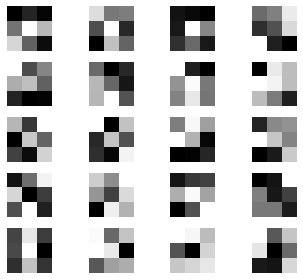

average of absolute gradients 1 tensor(6.3642e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3073e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9196e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5680e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2732e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1249e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2000e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1362e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0296e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6791e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3522e-06, device='cuda:0')


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [58:20<26:00,  5.13s/it]

Epoch: 696
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1934, -0.1335, -0.1834],
         [-0.0061,  0.2221,  0.1074],
         [ 0.1538, -0.0353, -0.1733]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


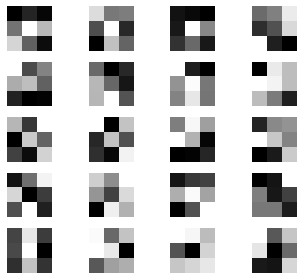

average of absolute gradients 1 tensor(7.2819e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3643e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5385e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7050e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0061e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4883e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9776e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8469e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8335e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5799e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1475e-06, device='cuda:0')


 70%|███████████████████████████████████████████████████████                        | 697/1000 [58:26<26:04,  5.16s/it]

Epoch: 697
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1933, -0.1330, -0.1834],
         [-0.0061,  0.2224,  0.1076],
         [ 0.1538, -0.0354, -0.1731]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


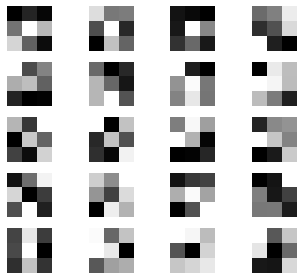

average of absolute gradients 1 tensor(6.9396e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0187e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8345e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7587e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0999e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2857e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7515e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7041e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6076e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.1880e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2769e-06, device='cuda:0')


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [58:31<26:05,  5.18s/it]

Epoch: 698
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1934, -0.1334, -0.1836],
         [-0.0064,  0.2218,  0.1075],
         [ 0.1537, -0.0356, -0.1731]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


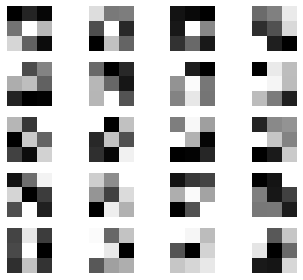

average of absolute gradients 1 tensor(7.8751e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5090e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7509e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0389e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1955e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5332e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7734e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9389e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1143e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0959e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5935e-06, device='cuda:0')


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [58:36<25:54,  5.16s/it]

Epoch: 699
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1932, -0.1335, -0.1835],
         [-0.0064,  0.2217,  0.1072],
         [ 0.1541, -0.0352, -0.1732]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


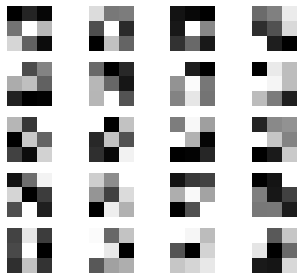

average of absolute gradients 1 tensor(6.3308e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4776e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0879e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9517e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9845e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5762e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2680e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6571e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.0775e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2008e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0803e-06, device='cuda:0')


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [58:41<25:36,  5.12s/it]

Epoch: 700
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1929, -0.1335, -0.1832],
         [-0.0065,  0.2221,  0.1076],
         [ 0.1537, -0.0348, -0.1733]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


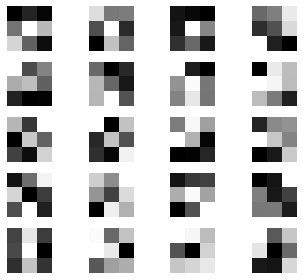

average of absolute gradients 1 tensor(5.6081e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0003e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.0880e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7053e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8014e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7212e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8478e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0949e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9483e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3879e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.0661e-06, device='cuda:0')


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [58:46<25:25,  5.10s/it]

Epoch: 701
Accuracy of train set: 25%
Accuracy of test set: 9%

tensor([[[-0.1927, -0.1340, -0.1833],
         [-0.0065,  0.2218,  0.1077],
         [ 0.1533, -0.0355, -0.1733]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


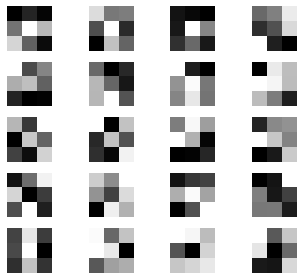

average of absolute gradients 1 tensor(7.8928e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3523e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6488e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5267e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6118e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8615e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6116e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9773e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5875e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2565e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1454e-06, device='cuda:0')


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [58:51<25:17,  5.09s/it]

Epoch: 702
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1927, -0.1338, -0.1830],
         [-0.0070,  0.2218,  0.1076],
         [ 0.1537, -0.0353, -0.1734]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


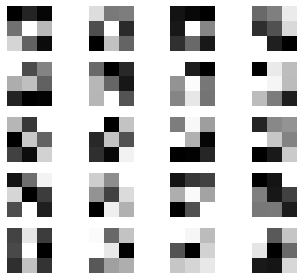

average of absolute gradients 1 tensor(5.9168e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6947e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3505e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0775e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2855e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8448e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4772e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9235e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5694e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2045e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2560e-06, device='cuda:0')


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [58:56<25:13,  5.10s/it]

Epoch: 703
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1927, -0.1337, -0.1825],
         [-0.0066,  0.2222,  0.1078],
         [ 0.1537, -0.0353, -0.1732]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


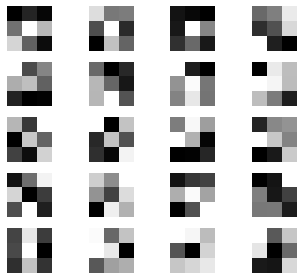

average of absolute gradients 1 tensor(7.0517e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4653e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0451e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9616e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6875e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6826e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8752e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9767e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2809e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1767e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9037e-06, device='cuda:0')


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [59:01<25:04,  5.08s/it]

Epoch: 704
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1923, -0.1333, -0.1821],
         [-0.0068,  0.2225,  0.1083],
         [ 0.1541, -0.0352, -0.1731]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


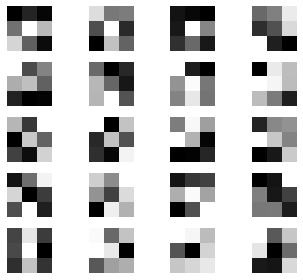

average of absolute gradients 1 tensor(5.5865e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0636e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3041e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0139e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7576e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8264e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.3130e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8329e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3293e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4062e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8204e-06, device='cuda:0')


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [59:06<24:56,  5.07s/it]

Epoch: 705
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1923, -0.1338, -0.1822],
         [-0.0066,  0.2221,  0.1086],
         [ 0.1533, -0.0359, -0.1734]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


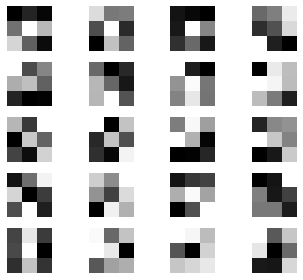

average of absolute gradients 1 tensor(5.5656e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0650e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2021e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.6384e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9532e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5414e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9886e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8164e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6361e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3366e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2447e-06, device='cuda:0')


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [59:11<24:53,  5.08s/it]

Epoch: 706
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1923, -0.1336, -0.1820],
         [-0.0067,  0.2221,  0.1085],
         [ 0.1535, -0.0358, -0.1735]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


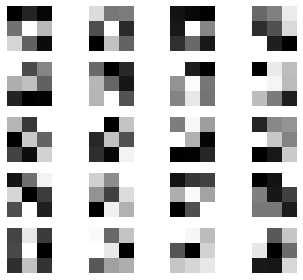

average of absolute gradients 1 tensor(4.8283e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5661e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8278e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1510e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2542e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5443e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1661e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2710e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4556e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5555e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8407e-06, device='cuda:0')


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [59:16<24:50,  5.09s/it]

Epoch: 707
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1921, -0.1335, -0.1815],
         [-0.0064,  0.2223,  0.1090],
         [ 0.1535, -0.0360, -0.1735]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


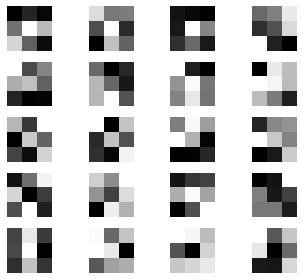

average of absolute gradients 1 tensor(5.8014e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9673e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.9581e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1633e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2690e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2251e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1542e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9527e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2038e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9015e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4531e-06, device='cuda:0')


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [59:22<24:48,  5.10s/it]

Epoch: 708
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1921, -0.1334, -0.1815],
         [-0.0061,  0.2225,  0.1088],
         [ 0.1535, -0.0358, -0.1734]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


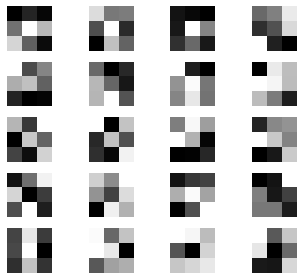

average of absolute gradients 1 tensor(6.4003e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1211e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0775e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7661e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1314e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3083e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9231e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6491e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7061e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3605e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.7628e-06, device='cuda:0')


 71%|████████████████████████████████████████████████████████                       | 709/1000 [59:27<24:46,  5.11s/it]

Epoch: 709
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1922, -0.1335, -0.1812],
         [-0.0056,  0.2225,  0.1089],
         [ 0.1530, -0.0359, -0.1736]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


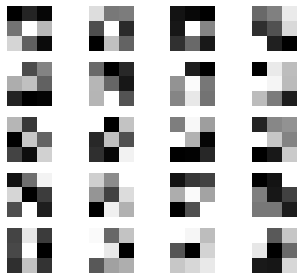

average of absolute gradients 1 tensor(6.4469e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2223e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2405e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4680e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1366e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9865e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.0883e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7137e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6687e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4125e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3060e-06, device='cuda:0')


 71%|████████████████████████████████████████████████████████                       | 710/1000 [59:32<24:46,  5.13s/it]

Epoch: 710
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1925, -0.1334, -0.1814],
         [-0.0056,  0.2220,  0.1085],
         [ 0.1530, -0.0359, -0.1738]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


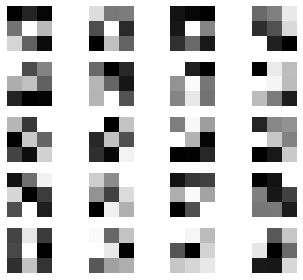

average of absolute gradients 1 tensor(5.7815e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9979e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6236e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5830e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6958e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1044e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3764e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8969e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6015e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1373e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9277e-06, device='cuda:0')


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [59:37<24:45,  5.14s/it]

Epoch: 711
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1925, -0.1338, -0.1814],
         [-0.0055,  0.2218,  0.1085],
         [ 0.1526, -0.0360, -0.1740]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


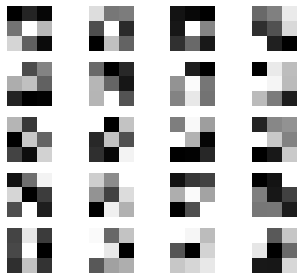

average of absolute gradients 1 tensor(5.3649e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3878e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1600e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8192e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6851e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1608e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0221e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2247e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6100e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7014e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7839e-06, device='cuda:0')


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [59:42<24:45,  5.16s/it]

Epoch: 712
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1927, -0.1336, -0.1812],
         [-0.0054,  0.2217,  0.1085],
         [ 0.1526, -0.0357, -0.1741]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


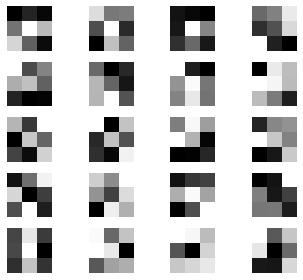

average of absolute gradients 1 tensor(5.0778e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5951e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5202e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5509e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4014e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0354e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4598e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6537e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1695e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8043e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4949e-06, device='cuda:0')


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [59:47<24:34,  5.14s/it]

Epoch: 713
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1924, -0.1335, -0.1809],
         [-0.0055,  0.2217,  0.1087],
         [ 0.1531, -0.0357, -0.1740]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


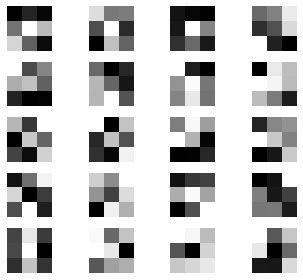

average of absolute gradients 1 tensor(5.4030e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4788e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1531e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1403e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6002e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2684e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6951e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4904e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9429e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7966e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5542e-06, device='cuda:0')


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [59:52<24:23,  5.12s/it]

Epoch: 714
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1924, -0.1335, -0.1809],
         [-0.0057,  0.2216,  0.1086],
         [ 0.1530, -0.0359, -0.1741]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


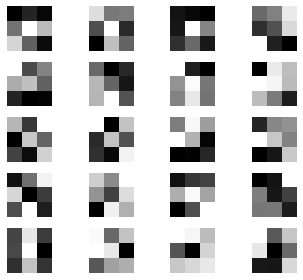

average of absolute gradients 1 tensor(5.3659e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5090e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2773e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7916e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4750e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5979e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6647e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5152e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3668e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3769e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6218e-06, device='cuda:0')


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [59:58<24:16,  5.11s/it]

Epoch: 715
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1926, -0.1336, -0.1807],
         [-0.0057,  0.2214,  0.1086],
         [ 0.1529, -0.0362, -0.1741]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


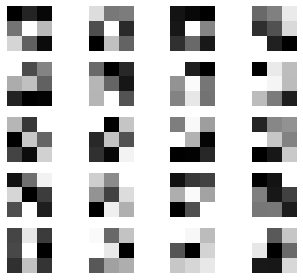

average of absolute gradients 1 tensor(4.5459e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2532e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3357e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4681e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9901e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7199e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1490e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7807e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2801e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4948e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2596e-06, device='cuda:0')


 72%|███████████████████████████████████████████████████████▏                     | 716/1000 [1:00:03<24:13,  5.12s/it]

Epoch: 716
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1927, -0.1335, -0.1807],
         [-0.0058,  0.2216,  0.1084],
         [ 0.1528, -0.0361, -0.1740]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


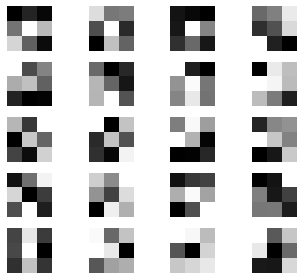

average of absolute gradients 1 tensor(5.1684e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0080e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4031e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7418e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5936e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2914e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7169e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2098e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7016e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3501e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3761e-06, device='cuda:0')


 72%|███████████████████████████████████████████████████████▏                     | 717/1000 [1:00:08<24:14,  5.14s/it]

Epoch: 717
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1928, -0.1333, -0.1807],
         [-0.0056,  0.2214,  0.1085],
         [ 0.1528, -0.0361, -0.1741]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


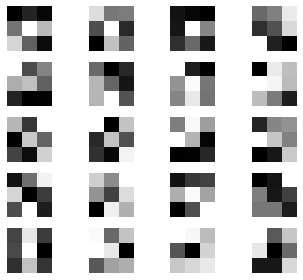

average of absolute gradients 1 tensor(5.2958e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0085e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9060e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8257e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4816e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7252e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0919e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8000e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5770e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7751e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9826e-06, device='cuda:0')


 72%|███████████████████████████████████████████████████████▎                     | 718/1000 [1:00:13<24:07,  5.13s/it]

Epoch: 718
Accuracy of train set: 25%
Accuracy of test set: 11%

tensor([[[-0.1928, -0.1332, -0.1806],
         [-0.0057,  0.2213,  0.1087],
         [ 0.1529, -0.0363, -0.1739]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


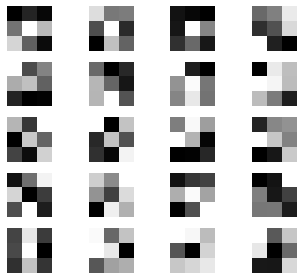

average of absolute gradients 1 tensor(3.9844e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9468e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2685e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8355e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1208e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4769e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6956e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3805e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7014e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3200e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4814e-06, device='cuda:0')


 72%|███████████████████████████████████████████████████████▎                     | 719/1000 [1:00:18<23:58,  5.12s/it]

Epoch: 719
Accuracy of train set: 25%
Accuracy of test set: 11%

tensor([[[-0.1929, -0.1328, -0.1805],
         [-0.0055,  0.2215,  0.1088],
         [ 0.1528, -0.0362, -0.1738]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


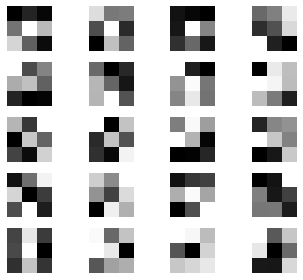

average of absolute gradients 1 tensor(5.0793e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4994e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3036e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4853e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2670e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2754e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9513e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8614e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1130e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3729e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5583e-06, device='cuda:0')


 72%|███████████████████████████████████████████████████████▍                     | 720/1000 [1:00:23<23:48,  5.10s/it]

Epoch: 720
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1929, -0.1331, -0.1805],
         [-0.0058,  0.2214,  0.1089],
         [ 0.1526, -0.0362, -0.1736]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


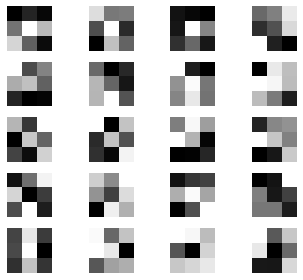

average of absolute gradients 1 tensor(5.7766e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5450e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8019e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6039e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6816e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1916e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7939e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5895e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3854e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4763e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5805e-06, device='cuda:0')


 72%|███████████████████████████████████████████████████████▌                     | 721/1000 [1:00:28<23:43,  5.10s/it]

Epoch: 721
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1929, -0.1330, -0.1806],
         [-0.0057,  0.2213,  0.1091],
         [ 0.1526, -0.0366, -0.1733]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


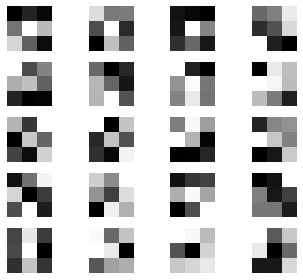

average of absolute gradients 1 tensor(5.8400e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9658e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4220e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5195e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2950e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4208e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1783e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8023e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6782e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7679e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9684e-06, device='cuda:0')


 72%|███████████████████████████████████████████████████████▌                     | 722/1000 [1:00:33<23:50,  5.15s/it]

Epoch: 722
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1929, -0.1330, -0.1803],
         [-0.0058,  0.2213,  0.1091],
         [ 0.1527, -0.0370, -0.1732]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


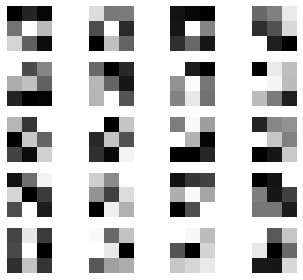

average of absolute gradients 1 tensor(4.8503e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8056e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8697e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1446e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5701e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4508e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8715e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3068e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6803e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8759e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5780e-06, device='cuda:0')


 72%|███████████████████████████████████████████████████████▋                     | 723/1000 [1:00:39<23:47,  5.15s/it]

Epoch: 723
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1928, -0.1326, -0.1803],
         [-0.0059,  0.2215,  0.1089],
         [ 0.1528, -0.0371, -0.1731]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


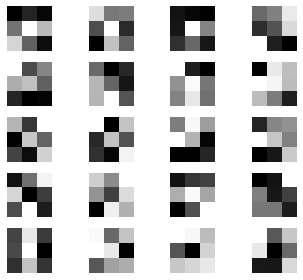

average of absolute gradients 1 tensor(5.1132e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8297e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1206e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0105e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4156e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6645e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8226e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1317e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9376e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6305e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2266e-06, device='cuda:0')


 72%|███████████████████████████████████████████████████████▋                     | 724/1000 [1:00:44<23:40,  5.15s/it]

Epoch: 724
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1930, -0.1327, -0.1801],
         [-0.0060,  0.2214,  0.1092],
         [ 0.1528, -0.0370, -0.1730]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


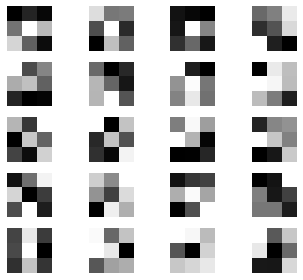

average of absolute gradients 1 tensor(5.6535e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8124e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3072e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8540e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4097e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1130e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2106e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1578e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5186e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1978e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0976e-06, device='cuda:0')


 72%|███████████████████████████████████████████████████████▊                     | 725/1000 [1:00:49<23:33,  5.14s/it]

Epoch: 725
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1931, -0.1327, -0.1801],
         [-0.0059,  0.2214,  0.1092],
         [ 0.1526, -0.0370, -0.1729]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


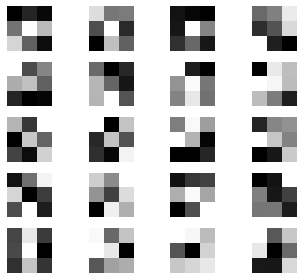

average of absolute gradients 1 tensor(5.3246e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5908e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9319e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2597e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3401e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9185e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8205e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0415e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7656e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2035e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.9044e-06, device='cuda:0')


 73%|███████████████████████████████████████████████████████▉                     | 726/1000 [1:00:54<23:22,  5.12s/it]

Epoch: 726
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1933, -0.1330, -0.1799],
         [-0.0062,  0.2210,  0.1092],
         [ 0.1524, -0.0374, -0.1730]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


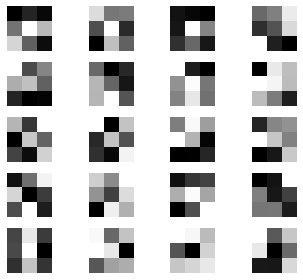

average of absolute gradients 1 tensor(4.8931e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3586e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9567e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8090e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3269e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5728e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5889e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0034e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8206e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0379e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0299e-06, device='cuda:0')


 73%|███████████████████████████████████████████████████████▉                     | 727/1000 [1:00:59<23:18,  5.12s/it]

Epoch: 727
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1934, -0.1327, -0.1798],
         [-0.0056,  0.2213,  0.1091],
         [ 0.1524, -0.0372, -0.1729]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


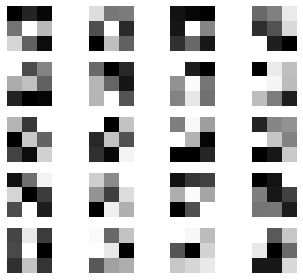

average of absolute gradients 1 tensor(4.6540e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0486e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7096e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7570e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8906e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3741e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7862e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4139e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2761e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5550e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5899e-06, device='cuda:0')


 73%|████████████████████████████████████████████████████████                     | 728/1000 [1:01:04<23:16,  5.14s/it]

Epoch: 728
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1936, -0.1326, -0.1800],
         [-0.0059,  0.2208,  0.1090],
         [ 0.1526, -0.0370, -0.1727]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


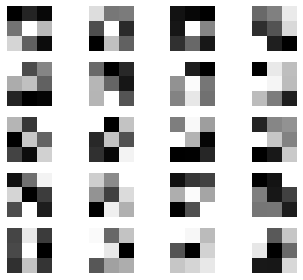

average of absolute gradients 1 tensor(4.7724e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9194e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4135e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4645e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4142e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1308e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2642e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3315e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5581e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5165e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5491e-06, device='cuda:0')


 73%|████████████████████████████████████████████████████████▏                    | 729/1000 [1:01:09<23:18,  5.16s/it]

Epoch: 729
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1937, -0.1325, -0.1797],
         [-0.0057,  0.2211,  0.1091],
         [ 0.1525, -0.0371, -0.1727]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


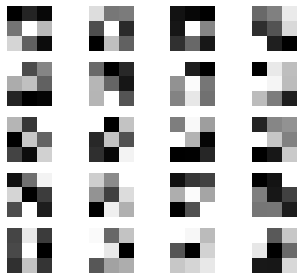

average of absolute gradients 1 tensor(4.5002e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8209e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3101e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9990e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2914e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4917e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6845e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7377e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5334e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7800e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1735e-06, device='cuda:0')


 73%|████████████████████████████████████████████████████████▏                    | 730/1000 [1:01:15<23:16,  5.17s/it]

Epoch: 730
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1937, -0.1325, -0.1798],
         [-0.0056,  0.2209,  0.1090],
         [ 0.1526, -0.0373, -0.1725]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


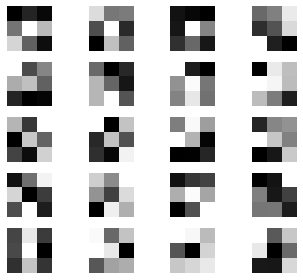

average of absolute gradients 1 tensor(5.0898e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1162e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4634e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4914e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6323e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7539e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0323e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5750e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0987e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9205e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8584e-06, device='cuda:0')


 73%|████████████████████████████████████████████████████████▎                    | 731/1000 [1:01:20<23:14,  5.18s/it]

Epoch: 731
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1938, -0.1323, -0.1798],
         [-0.0056,  0.2211,  0.1092],
         [ 0.1522, -0.0374, -0.1724]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


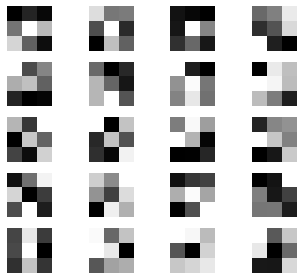

average of absolute gradients 1 tensor(5.4769e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3761e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8623e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5823e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5050e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6795e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5947e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7590e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5653e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2209e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9500e-06, device='cuda:0')


 73%|████████████████████████████████████████████████████████▎                    | 732/1000 [1:01:25<22:58,  5.14s/it]

Epoch: 732
Accuracy of train set: 25%
Accuracy of test set: 9%

tensor([[[-0.1940, -0.1322, -0.1798],
         [-0.0057,  0.2209,  0.1092],
         [ 0.1525, -0.0372, -0.1722]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


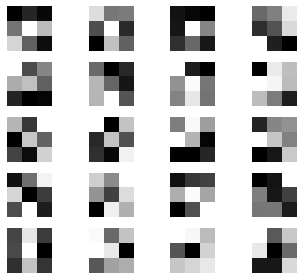

average of absolute gradients 1 tensor(4.7916e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4439e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7393e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0385e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5193e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7114e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7337e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0926e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8627e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7721e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3523e-06, device='cuda:0')


 73%|████████████████████████████████████████████████████████▍                    | 733/1000 [1:01:30<22:51,  5.14s/it]

Epoch: 733
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1941, -0.1321, -0.1797],
         [-0.0058,  0.2208,  0.1091],
         [ 0.1524, -0.0373, -0.1721]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


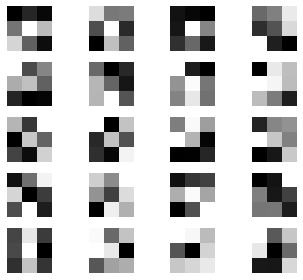

average of absolute gradients 1 tensor(4.0378e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5817e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9635e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6491e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2179e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8230e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8686e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0378e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8615e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4458e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0363e-06, device='cuda:0')


 73%|████████████████████████████████████████████████████████▌                    | 734/1000 [1:01:35<22:41,  5.12s/it]

Epoch: 734
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1939, -0.1318, -0.1795],
         [-0.0055,  0.2213,  0.1092],
         [ 0.1525, -0.0370, -0.1720]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


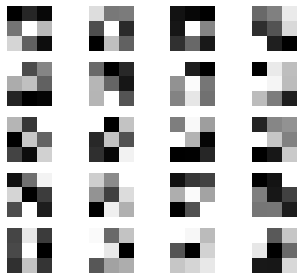

average of absolute gradients 1 tensor(5.5233e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8720e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0187e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6693e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3476e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4548e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2481e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9117e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9830e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7235e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0269e-06, device='cuda:0')


 74%|████████████████████████████████████████████████████████▌                    | 735/1000 [1:01:40<22:28,  5.09s/it]

Epoch: 735
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1941, -0.1318, -0.1796],
         [-0.0057,  0.2208,  0.1091],
         [ 0.1526, -0.0373, -0.1721]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


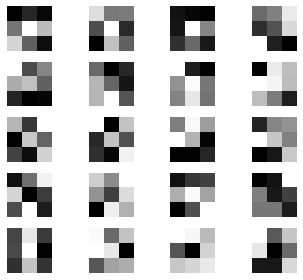

average of absolute gradients 1 tensor(4.0782e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0357e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8453e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7514e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5182e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3451e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6332e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1241e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3883e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6066e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4380e-06, device='cuda:0')


 74%|████████████████████████████████████████████████████████▋                    | 736/1000 [1:01:45<22:27,  5.10s/it]

Epoch: 736
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1942, -0.1317, -0.1794],
         [-0.0057,  0.2209,  0.1091],
         [ 0.1525, -0.0372, -0.1720]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


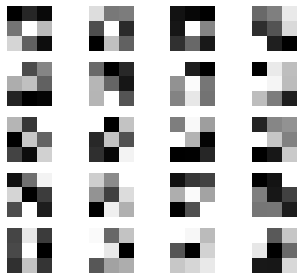

average of absolute gradients 1 tensor(4.2731e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7995e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5211e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6620e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1050e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6984e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3415e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3559e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9274e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7545e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6361e-06, device='cuda:0')


 74%|████████████████████████████████████████████████████████▋                    | 737/1000 [1:01:50<22:24,  5.11s/it]

Epoch: 737
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1941, -0.1315, -0.1792],
         [-0.0055,  0.2212,  0.1095],
         [ 0.1522, -0.0371, -0.1719]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


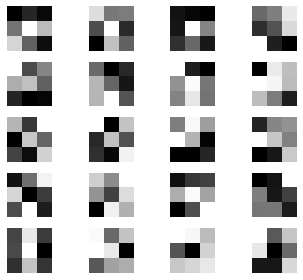

average of absolute gradients 1 tensor(5.2973e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5341e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4685e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7467e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6543e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9476e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9278e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5220e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5166e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0912e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6995e-06, device='cuda:0')


 74%|████████████████████████████████████████████████████████▊                    | 738/1000 [1:01:56<22:17,  5.10s/it]

Epoch: 738
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1943, -0.1318, -0.1794],
         [-0.0056,  0.2208,  0.1092],
         [ 0.1520, -0.0374, -0.1720]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


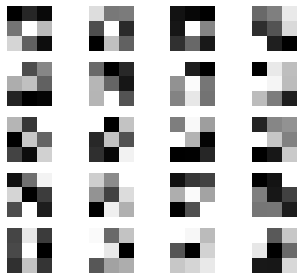

average of absolute gradients 1 tensor(4.7938e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5809e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2596e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8410e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2468e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1440e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7988e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7126e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9024e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5384e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3987e-06, device='cuda:0')


 74%|████████████████████████████████████████████████████████▉                    | 739/1000 [1:02:01<22:09,  5.09s/it]

Epoch: 739
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1942, -0.1316, -0.1790],
         [-0.0056,  0.2212,  0.1093],
         [ 0.1520, -0.0373, -0.1719]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


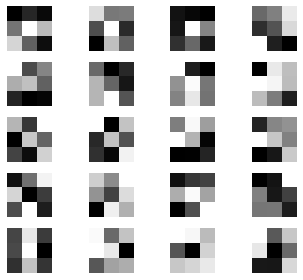

average of absolute gradients 1 tensor(4.5101e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9608e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8990e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4723e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9339e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1484e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8401e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4287e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8543e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3392e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8368e-06, device='cuda:0')


 74%|████████████████████████████████████████████████████████▉                    | 740/1000 [1:02:06<22:02,  5.09s/it]

Epoch: 740
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1943, -0.1318, -0.1791],
         [-0.0055,  0.2210,  0.1089],
         [ 0.1522, -0.0373, -0.1718]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


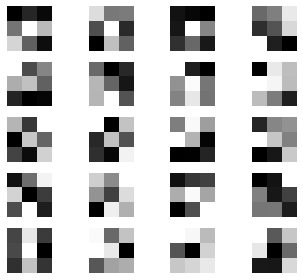

average of absolute gradients 1 tensor(4.6584e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3222e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3381e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7567e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4699e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5276e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6250e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1983e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5831e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7508e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0504e-06, device='cuda:0')


 74%|█████████████████████████████████████████████████████████                    | 741/1000 [1:02:11<21:58,  5.09s/it]

Epoch: 741
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1944, -0.1319, -0.1792],
         [-0.0054,  0.2212,  0.1088],
         [ 0.1516, -0.0372, -0.1717]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


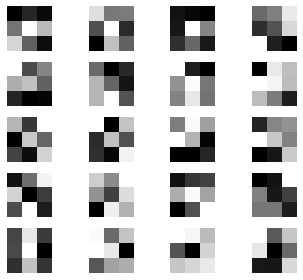

average of absolute gradients 1 tensor(5.5054e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7975e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3010e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7994e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3342e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1093e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5936e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3769e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3346e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1073e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3593e-06, device='cuda:0')


 74%|█████████████████████████████████████████████████████████▏                   | 742/1000 [1:02:16<22:00,  5.12s/it]

Epoch: 742
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1944, -0.1317, -0.1791],
         [-0.0054,  0.2212,  0.1090],
         [ 0.1516, -0.0371, -0.1716]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


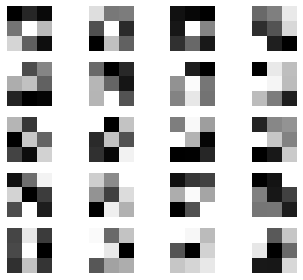

average of absolute gradients 1 tensor(4.0290e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8485e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3000e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8762e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6808e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4392e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.2093e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4115e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4081e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6684e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9387e-06, device='cuda:0')


 74%|█████████████████████████████████████████████████████████▏                   | 743/1000 [1:02:21<21:51,  5.10s/it]

Epoch: 743
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1943, -0.1316, -0.1789],
         [-0.0055,  0.2212,  0.1094],
         [ 0.1518, -0.0369, -0.1715]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


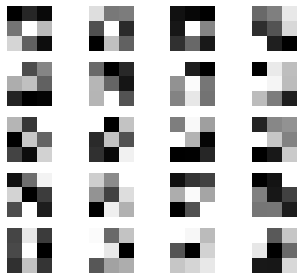

average of absolute gradients 1 tensor(6.3166e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0169e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4432e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7260e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1612e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0994e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2651e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4948e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3550e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5711e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4082e-06, device='cuda:0')


 74%|█████████████████████████████████████████████████████████▎                   | 744/1000 [1:02:26<21:49,  5.11s/it]

Epoch: 744
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1943, -0.1316, -0.1789],
         [-0.0056,  0.2211,  0.1090],
         [ 0.1519, -0.0366, -0.1716]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


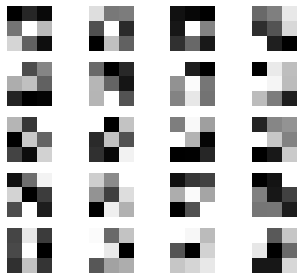

average of absolute gradients 1 tensor(6.0609e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0848e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0464e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8558e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4157e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1270e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0916e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9533e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0527e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3472e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3456e-06, device='cuda:0')


 74%|█████████████████████████████████████████████████████████▎                   | 745/1000 [1:02:31<21:47,  5.13s/it]

Epoch: 745
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1944, -0.1320, -0.1791],
         [-0.0061,  0.2204,  0.1090],
         [ 0.1520, -0.0368, -0.1717]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


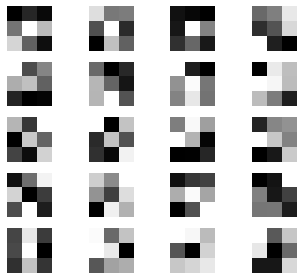

average of absolute gradients 1 tensor(4.9298e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3840e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2862e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3808e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7965e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2341e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5278e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6072e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.1074e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2910e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9552e-06, device='cuda:0')


 75%|█████████████████████████████████████████████████████████▍                   | 746/1000 [1:02:36<21:44,  5.13s/it]

Epoch: 746
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1939, -0.1316, -0.1786],
         [-0.0059,  0.2208,  0.1096],
         [ 0.1526, -0.0362, -0.1715]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


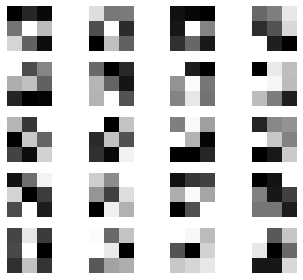

average of absolute gradients 1 tensor(5.6183e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3022e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6010e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6684e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8265e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6053e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2112e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9999e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1565e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.1678e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0208e-06, device='cuda:0')


 75%|█████████████████████████████████████████████████████████▌                   | 747/1000 [1:02:42<21:33,  5.11s/it]

Epoch: 747
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1941, -0.1319, -0.1789],
         [-0.0058,  0.2206,  0.1094],
         [ 0.1519, -0.0357, -0.1716]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


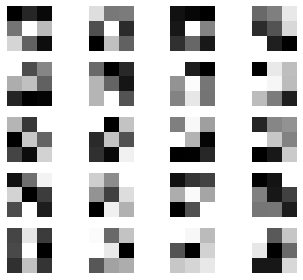

average of absolute gradients 1 tensor(4.8093e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0115e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0763e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5939e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4044e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1996e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8961e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8758e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9638e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4935e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4239e-06, device='cuda:0')


 75%|█████████████████████████████████████████████████████████▌                   | 748/1000 [1:02:47<21:33,  5.13s/it]

Epoch: 748
Accuracy of train set: 25%
Accuracy of test set: 10%

tensor([[[-0.1940, -0.1319, -0.1788],
         [-0.0056,  0.2203,  0.1097],
         [ 0.1525, -0.0355, -0.1716]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


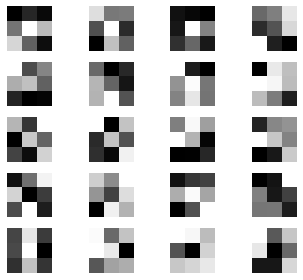

average of absolute gradients 1 tensor(5.7172e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6175e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8473e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2932e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6333e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3308e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6472e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4595e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0374e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4627e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6859e-06, device='cuda:0')


 75%|█████████████████████████████████████████████████████████▋                   | 749/1000 [1:02:52<21:24,  5.12s/it]

Epoch: 749
Accuracy of train set: 25%
Accuracy of test set: 11%

tensor([[[-0.1942, -0.1325, -0.1790],
         [-0.0057,  0.2198,  0.1097],
         [ 0.1519, -0.0357, -0.1716]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


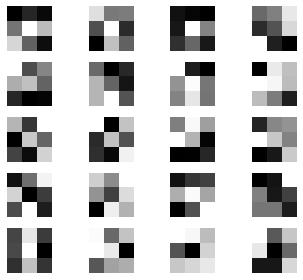

average of absolute gradients 1 tensor(6.3814e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5522e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0367e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7500e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8016e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3843e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9119e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0158e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7200e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3033e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8030e-06, device='cuda:0')


 75%|█████████████████████████████████████████████████████████▊                   | 750/1000 [1:02:57<21:21,  5.13s/it]

Epoch: 750
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1942, -0.1321, -0.1788],
         [-0.0055,  0.2200,  0.1102],
         [ 0.1520, -0.0352, -0.1715]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


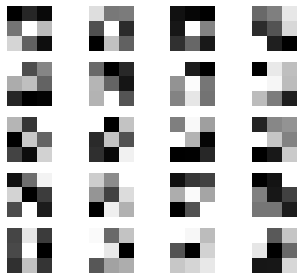

average of absolute gradients 1 tensor(5.6351e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6584e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1340e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1053e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4538e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.0031e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4653e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9144e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2472e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5577e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7216e-06, device='cuda:0')


 75%|█████████████████████████████████████████████████████████▊                   | 751/1000 [1:03:02<21:21,  5.15s/it]

Epoch: 751
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1944, -0.1323, -0.1791],
         [-0.0056,  0.2196,  0.1099],
         [ 0.1515, -0.0348, -0.1717]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


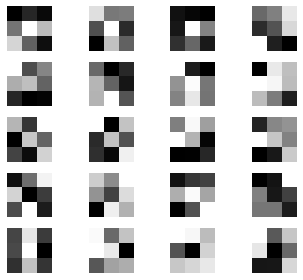

average of absolute gradients 1 tensor(5.4372e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3758e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9199e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1502e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7614e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4454e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7097e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9734e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8503e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6846e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3565e-06, device='cuda:0')


 75%|█████████████████████████████████████████████████████████▉                   | 752/1000 [1:03:07<21:13,  5.14s/it]

Epoch: 752
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1943, -0.1323, -0.1789],
         [-0.0057,  0.2198,  0.1102],
         [ 0.1515, -0.0349, -0.1715]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


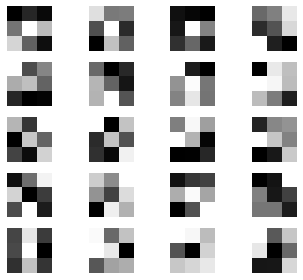

average of absolute gradients 1 tensor(5.3179e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7125e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6378e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7985e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4954e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2455e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6163e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7854e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3170e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6197e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5786e-06, device='cuda:0')


 75%|█████████████████████████████████████████████████████████▉                   | 753/1000 [1:03:12<21:13,  5.16s/it]

Epoch: 753
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1946, -0.1323, -0.1789],
         [-0.0057,  0.2196,  0.1097],
         [ 0.1516, -0.0347, -0.1716]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


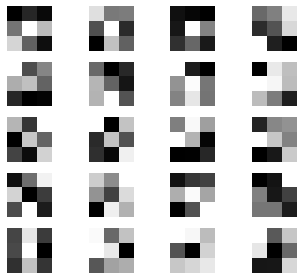

average of absolute gradients 1 tensor(5.0039e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9295e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.9509e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3865e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0908e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9334e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8311e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8918e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3841e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1439e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9870e-06, device='cuda:0')


 75%|██████████████████████████████████████████████████████████                   | 754/1000 [1:03:18<21:07,  5.15s/it]

Epoch: 754
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1945, -0.1322, -0.1790],
         [-0.0057,  0.2197,  0.1098],
         [ 0.1512, -0.0344, -0.1716]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


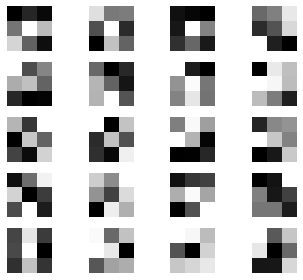

average of absolute gradients 1 tensor(6.2119e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8932e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6465e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2847e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7688e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2149e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1781e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2799e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6419e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6673e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9961e-06, device='cuda:0')


 76%|██████████████████████████████████████████████████████████▏                  | 755/1000 [1:03:23<20:55,  5.12s/it]

Epoch: 755
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1946, -0.1323, -0.1791],
         [-0.0056,  0.2194,  0.1098],
         [ 0.1513, -0.0343, -0.1716]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


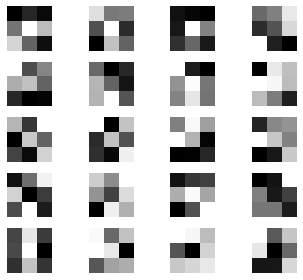

average of absolute gradients 1 tensor(5.2626e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4842e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6628e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5267e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2956e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8039e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2828e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4383e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7564e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9456e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.4737e-06, device='cuda:0')


 76%|██████████████████████████████████████████████████████████▏                  | 756/1000 [1:03:28<20:51,  5.13s/it]

Epoch: 756
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1947, -0.1321, -0.1791],
         [-0.0057,  0.2191,  0.1103],
         [ 0.1514, -0.0343, -0.1714]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


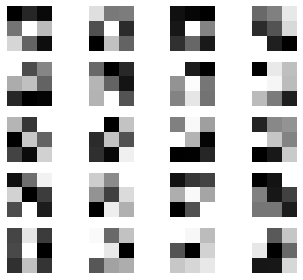

average of absolute gradients 1 tensor(4.8714e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2005e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9292e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3118e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0553e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8510e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2949e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4812e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2016e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8502e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4088e-06, device='cuda:0')


 76%|██████████████████████████████████████████████████████████▎                  | 757/1000 [1:03:33<20:37,  5.09s/it]

Epoch: 757
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1946, -0.1316, -0.1792],
         [-0.0053,  0.2194,  0.1099],
         [ 0.1517, -0.0340, -0.1714]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


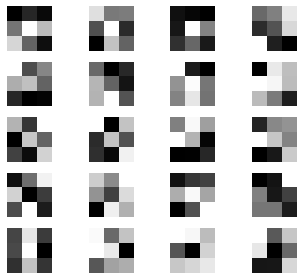

average of absolute gradients 1 tensor(4.7920e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5878e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6146e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2200e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0657e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7577e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8073e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9677e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5602e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8300e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5058e-06, device='cuda:0')


 76%|██████████████████████████████████████████████████████████▎                  | 758/1000 [1:03:38<20:34,  5.10s/it]

Epoch: 758
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1947, -0.1321, -0.1794],
         [-0.0055,  0.2189,  0.1099],
         [ 0.1511, -0.0342, -0.1715]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


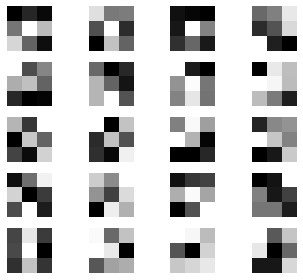

average of absolute gradients 1 tensor(4.8996e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0263e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5016e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8538e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7099e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2032e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9952e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9497e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1071e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6233e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6814e-06, device='cuda:0')


 76%|██████████████████████████████████████████████████████████▍                  | 759/1000 [1:03:43<20:20,  5.06s/it]

Epoch: 759
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1944, -0.1318, -0.1793],
         [-0.0054,  0.2193,  0.1103],
         [ 0.1512, -0.0339, -0.1714]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


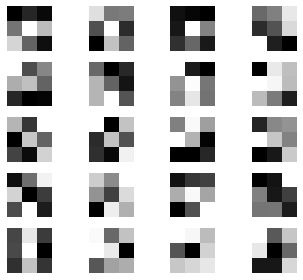

average of absolute gradients 1 tensor(5.0781e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6980e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8873e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6173e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1597e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5330e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9793e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8160e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7539e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2279e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9249e-06, device='cuda:0')


 76%|██████████████████████████████████████████████████████████▌                  | 760/1000 [1:03:48<20:10,  5.04s/it]

Epoch: 760
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1945, -0.1319, -0.1795],
         [-0.0053,  0.2189,  0.1101],
         [ 0.1511, -0.0342, -0.1715]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


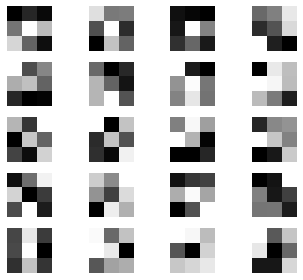

average of absolute gradients 1 tensor(5.6279e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3894e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2570e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9236e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6105e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8810e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6989e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4569e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5425e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8717e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2123e-06, device='cuda:0')


 76%|██████████████████████████████████████████████████████████▌                  | 761/1000 [1:03:53<20:11,  5.07s/it]

Epoch: 761
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1944, -0.1316, -0.1795],
         [-0.0054,  0.2188,  0.1101],
         [ 0.1512, -0.0341, -0.1716]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


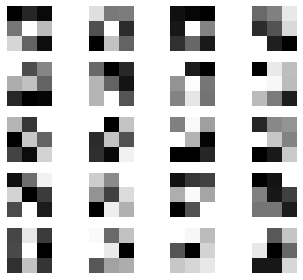

average of absolute gradients 1 tensor(4.3435e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8411e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1958e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0652e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7501e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1800e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2354e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9242e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1423e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0470e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8700e-06, device='cuda:0')


 76%|██████████████████████████████████████████████████████████▋                  | 762/1000 [1:03:58<20:08,  5.08s/it]

Epoch: 762
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1945, -0.1313, -0.1795],
         [-0.0056,  0.2188,  0.1100],
         [ 0.1514, -0.0340, -0.1716]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


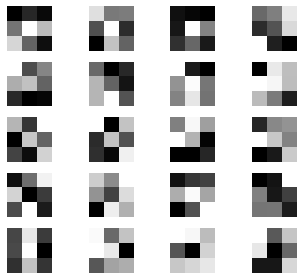

average of absolute gradients 1 tensor(5.2398e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5382e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7036e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9510e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6069e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7953e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9861e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6423e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3136e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.0585e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9599e-06, device='cuda:0')


 76%|██████████████████████████████████████████████████████████▊                  | 763/1000 [1:04:03<19:59,  5.06s/it]

Epoch: 763
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1943, -0.1313, -0.1795],
         [-0.0055,  0.2188,  0.1101],
         [ 0.1513, -0.0339, -0.1717]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


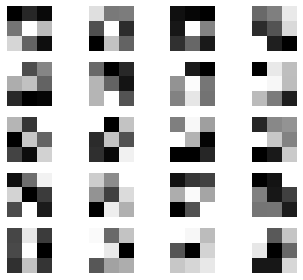

average of absolute gradients 1 tensor(5.7208e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3497e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3076e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3133e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4863e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4532e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6592e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3990e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2770e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9747e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1439e-06, device='cuda:0')


 76%|██████████████████████████████████████████████████████████▊                  | 764/1000 [1:04:08<20:06,  5.11s/it]

Epoch: 764
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1944, -0.1314, -0.1796],
         [-0.0057,  0.2185,  0.1099],
         [ 0.1514, -0.0340, -0.1717]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


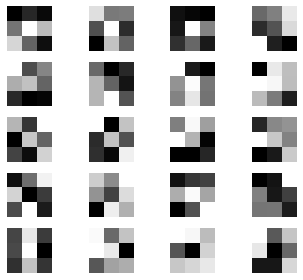

average of absolute gradients 1 tensor(4.9363e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6350e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5862e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6530e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9631e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0747e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8625e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3261e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8167e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0690e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4867e-06, device='cuda:0')


 76%|██████████████████████████████████████████████████████████▉                  | 765/1000 [1:04:13<19:59,  5.11s/it]

Epoch: 765
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1946, -0.1314, -0.1798],
         [-0.0055,  0.2181,  0.1096],
         [ 0.1513, -0.0342, -0.1718]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


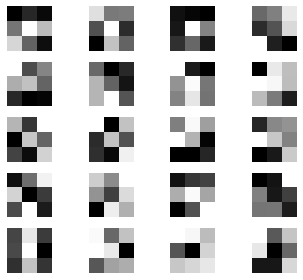

average of absolute gradients 1 tensor(3.7159e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7284e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1145e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4886e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7703e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0006e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8706e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9196e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0393e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3646e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2544e-06, device='cuda:0')


 77%|██████████████████████████████████████████████████████████▉                  | 766/1000 [1:04:19<19:52,  5.09s/it]

Epoch: 766
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1946, -0.1311, -0.1796],
         [-0.0054,  0.2183,  0.1098],
         [ 0.1514, -0.0339, -0.1717]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


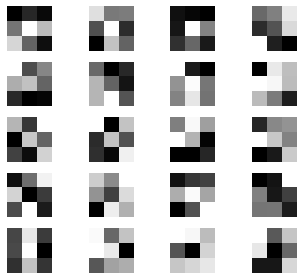

average of absolute gradients 1 tensor(4.5132e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8542e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8780e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0210e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3872e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5207e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6893e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0170e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0760e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5868e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1031e-06, device='cuda:0')


 77%|███████████████████████████████████████████████████████████                  | 767/1000 [1:04:24<19:48,  5.10s/it]

Epoch: 767
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1946, -0.1312, -0.1798],
         [-0.0058,  0.2179,  0.1097],
         [ 0.1513, -0.0341, -0.1718]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


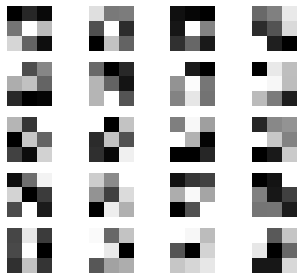

average of absolute gradients 1 tensor(4.5699e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3734e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8709e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5924e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4435e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7077e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3897e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5942e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4918e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0114e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3317e-06, device='cuda:0')


 77%|███████████████████████████████████████████████████████████▏                 | 768/1000 [1:04:29<19:44,  5.11s/it]

Epoch: 768
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1945, -0.1309, -0.1798],
         [-0.0053,  0.2182,  0.1098],
         [ 0.1512, -0.0340, -0.1718]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


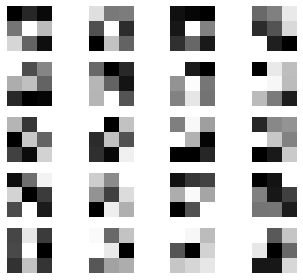

average of absolute gradients 1 tensor(4.1264e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6914e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0894e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9256e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8197e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6880e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8261e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7585e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7851e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5852e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3200e-06, device='cuda:0')


 77%|███████████████████████████████████████████████████████████▏                 | 769/1000 [1:04:34<19:48,  5.15s/it]

Epoch: 769
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1946, -0.1309, -0.1797],
         [-0.0055,  0.2179,  0.1099],
         [ 0.1512, -0.0341, -0.1718]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


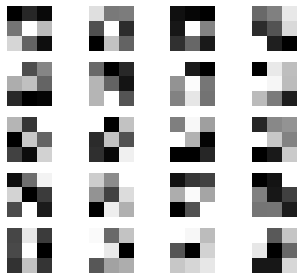

average of absolute gradients 1 tensor(4.5768e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3453e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1233e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3696e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8807e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2309e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2532e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4979e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7099e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0636e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0349e-06, device='cuda:0')


 77%|███████████████████████████████████████████████████████████▎                 | 770/1000 [1:04:39<19:40,  5.13s/it]

Epoch: 770
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1946, -0.1309, -0.1797],
         [-0.0055,  0.2176,  0.1100],
         [ 0.1513, -0.0340, -0.1719]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


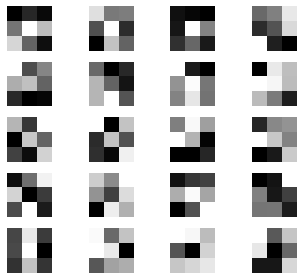

average of absolute gradients 1 tensor(4.8564e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6748e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4125e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0364e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1072e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7093e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7739e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6762e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3024e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9697e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8542e-06, device='cuda:0')


 77%|███████████████████████████████████████████████████████████▎                 | 771/1000 [1:04:44<19:32,  5.12s/it]

Epoch: 771
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1945, -0.1310, -0.1797],
         [-0.0054,  0.2177,  0.1101],
         [ 0.1511, -0.0338, -0.1719]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


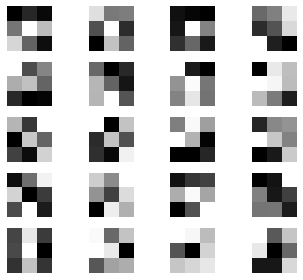

average of absolute gradients 1 tensor(4.6679e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6731e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6589e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1424e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0528e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1369e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3397e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2084e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4607e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8161e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.0523e-06, device='cuda:0')


 77%|███████████████████████████████████████████████████████████▍                 | 772/1000 [1:04:49<19:24,  5.11s/it]

Epoch: 772
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1944, -0.1313, -0.1798],
         [-0.0054,  0.2177,  0.1099],
         [ 0.1508, -0.0339, -0.1720]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


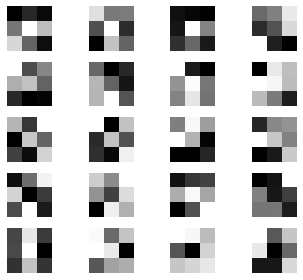

average of absolute gradients 1 tensor(4.2195e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6296e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4504e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9287e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7425e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3511e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8980e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5808e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7231e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7679e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.3252e-06, device='cuda:0')


 77%|███████████████████████████████████████████████████████████▌                 | 773/1000 [1:04:54<19:20,  5.11s/it]

Epoch: 773
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1945, -0.1312, -0.1796],
         [-0.0056,  0.2175,  0.1100],
         [ 0.1511, -0.0338, -0.1719]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


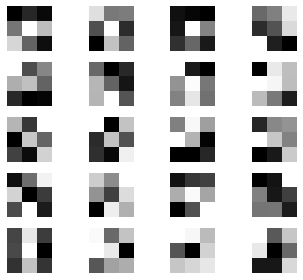

average of absolute gradients 1 tensor(5.8981e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1863e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3013e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6416e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3864e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7065e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2625e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2478e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5414e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0502e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7933e-06, device='cuda:0')


 77%|███████████████████████████████████████████████████████████▌                 | 774/1000 [1:04:59<19:14,  5.11s/it]

Epoch: 774
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1941, -0.1308, -0.1793],
         [-0.0054,  0.2180,  0.1107],
         [ 0.1512, -0.0336, -0.1717]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


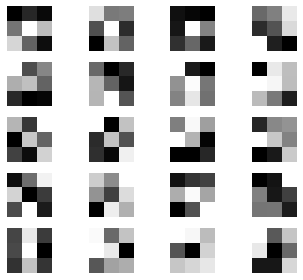

average of absolute gradients 1 tensor(4.7631e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8196e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1676e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2684e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1813e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1668e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6490e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5804e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9895e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6152e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.4178e-06, device='cuda:0')


 78%|███████████████████████████████████████████████████████████▋                 | 775/1000 [1:05:05<19:09,  5.11s/it]

Epoch: 775
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1941, -0.1306, -0.1793],
         [-0.0054,  0.2178,  0.1108],
         [ 0.1512, -0.0335, -0.1718]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


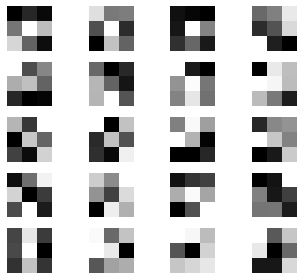

average of absolute gradients 1 tensor(4.8883e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0448e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1569e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0178e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5642e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1136e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1567e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6586e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1405e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0151e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0909e-06, device='cuda:0')


 78%|███████████████████████████████████████████████████████████▊                 | 776/1000 [1:05:10<19:04,  5.11s/it]

Epoch: 776
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1942, -0.1307, -0.1794],
         [-0.0055,  0.2175,  0.1107],
         [ 0.1513, -0.0334, -0.1718]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


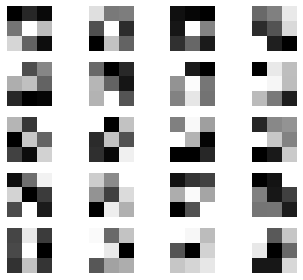

average of absolute gradients 1 tensor(4.7220e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3817e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4552e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3680e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5519e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4039e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7266e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8897e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0279e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8856e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9613e-06, device='cuda:0')


 78%|███████████████████████████████████████████████████████████▊                 | 777/1000 [1:05:15<18:58,  5.10s/it]

Epoch: 777
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1941, -0.1307, -0.1793],
         [-0.0054,  0.2175,  0.1109],
         [ 0.1512, -0.0333, -0.1718]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


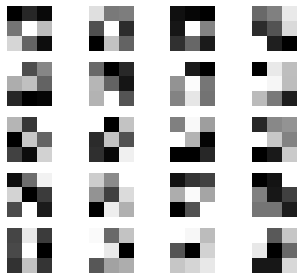

average of absolute gradients 1 tensor(4.3567e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7312e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4261e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7579e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5822e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9487e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3735e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7410e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3914e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5714e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2089e-06, device='cuda:0')


 78%|███████████████████████████████████████████████████████████▉                 | 778/1000 [1:05:20<19:20,  5.23s/it]

Epoch: 778
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1943, -0.1307, -0.1794],
         [-0.0053,  0.2174,  0.1106],
         [ 0.1511, -0.0334, -0.1719]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


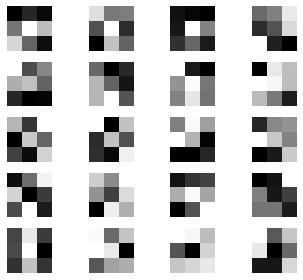

average of absolute gradients 1 tensor(4.5641e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1441e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8499e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0646e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2755e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8114e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2235e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1062e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8628e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5727e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4304e-06, device='cuda:0')


 78%|███████████████████████████████████████████████████████████▉                 | 779/1000 [1:05:26<19:16,  5.23s/it]

Epoch: 779
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1942, -0.1308, -0.1793],
         [-0.0051,  0.2174,  0.1107],
         [ 0.1510, -0.0334, -0.1718]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


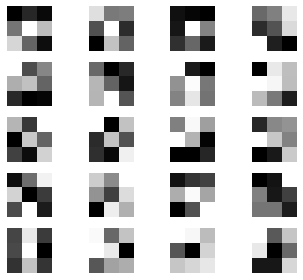

average of absolute gradients 1 tensor(3.8468e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9208e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7417e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2660e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7907e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7799e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8278e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9259e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0711e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5320e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9153e-06, device='cuda:0')


 78%|████████████████████████████████████████████████████████████                 | 780/1000 [1:05:31<19:06,  5.21s/it]

Epoch: 780
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1942, -0.1308, -0.1793],
         [-0.0051,  0.2173,  0.1105],
         [ 0.1510, -0.0333, -0.1719]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


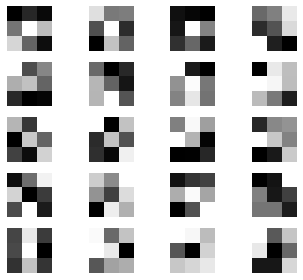

average of absolute gradients 1 tensor(4.1408e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1962e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7251e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4887e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4959e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4547e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7092e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1145e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2090e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0189e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2810e-06, device='cuda:0')


 78%|████████████████████████████████████████████████████████████▏                | 781/1000 [1:05:36<18:54,  5.18s/it]

Epoch: 781
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1942, -0.1308, -0.1793],
         [-0.0051,  0.2171,  0.1103],
         [ 0.1513, -0.0333, -0.1719]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


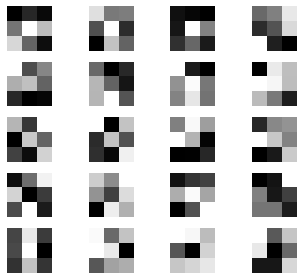

average of absolute gradients 1 tensor(3.8235e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5295e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1068e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4450e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9723e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1203e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1668e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7582e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7989e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0057e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6776e-06, device='cuda:0')


 78%|████████████████████████████████████████████████████████████▏                | 782/1000 [1:05:41<18:44,  5.16s/it]

Epoch: 782
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1943, -0.1308, -0.1793],
         [-0.0050,  0.2171,  0.1102],
         [ 0.1512, -0.0331, -0.1719]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


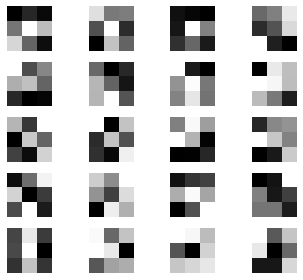

average of absolute gradients 1 tensor(4.2289e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8593e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1841e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6578e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1059e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6835e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4579e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8424e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5699e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1954e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2782e-06, device='cuda:0')


 78%|████████████████████████████████████████████████████████████▎                | 783/1000 [1:05:46<18:34,  5.14s/it]

Epoch: 783
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1944, -0.1309, -0.1792],
         [-0.0048,  0.2170,  0.1103],
         [ 0.1509, -0.0333, -0.1719]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


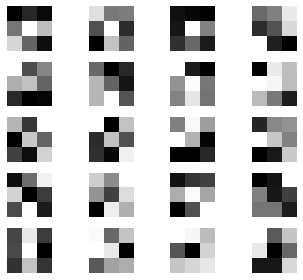

average of absolute gradients 1 tensor(3.8459e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4102e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3440e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0034e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3436e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2472e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6635e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9005e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7029e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8693e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9942e-06, device='cuda:0')


 78%|████████████████████████████████████████████████████████████▎                | 784/1000 [1:05:51<18:28,  5.13s/it]

Epoch: 784
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1944, -0.1310, -0.1792],
         [-0.0049,  0.2169,  0.1104],
         [ 0.1511, -0.0331, -0.1718]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


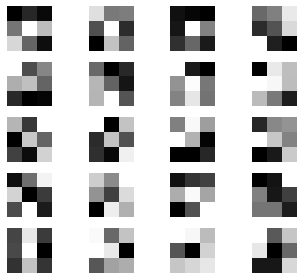

average of absolute gradients 1 tensor(3.5913e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6873e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0428e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8952e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6520e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1422e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9459e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8880e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9244e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7495e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.0332e-06, device='cuda:0')


 78%|████████████████████████████████████████████████████████████▍                | 785/1000 [1:05:56<18:22,  5.13s/it]

Epoch: 785
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1945, -0.1310, -0.1791],
         [-0.0050,  0.2169,  0.1102],
         [ 0.1510, -0.0331, -0.1717]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


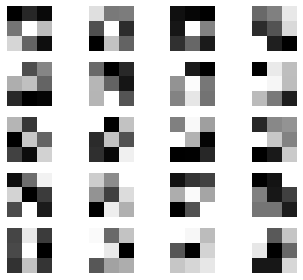

average of absolute gradients 1 tensor(5.5477e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7745e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9941e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0502e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1589e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6935e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0406e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0097e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5569e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0714e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6883e-06, device='cuda:0')


 79%|████████████████████████████████████████████████████████████▌                | 786/1000 [1:06:01<18:15,  5.12s/it]

Epoch: 786
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1944, -0.1308, -0.1789],
         [-0.0047,  0.2172,  0.1103],
         [ 0.1512, -0.0329, -0.1715]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


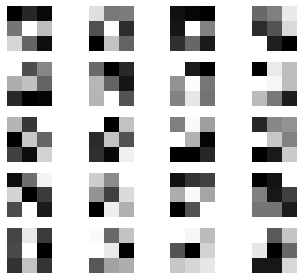

average of absolute gradients 1 tensor(3.6540e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6012e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8544e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3225e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5529e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7401e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3985e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9400e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5638e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9810e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.7828e-06, device='cuda:0')


 79%|████████████████████████████████████████████████████████████▌                | 787/1000 [1:06:06<18:10,  5.12s/it]

Epoch: 787
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1943, -0.1305, -0.1790],
         [-0.0046,  0.2175,  0.1102],
         [ 0.1513, -0.0325, -0.1714]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


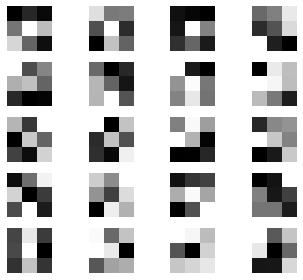

average of absolute gradients 1 tensor(4.8102e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9140e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4928e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9964e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2601e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3664e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0937e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5996e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0262e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7071e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5824e-06, device='cuda:0')


 79%|████████████████████████████████████████████████████████████▋                | 788/1000 [1:06:12<18:02,  5.11s/it]

Epoch: 788
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1945, -0.1309, -0.1790],
         [-0.0046,  0.2171,  0.1099],
         [ 0.1512, -0.0325, -0.1714]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


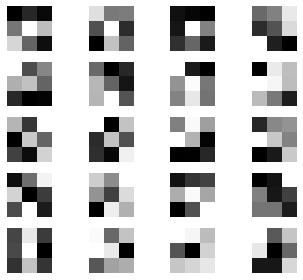

average of absolute gradients 1 tensor(3.7586e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3047e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8373e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6292e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3372e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5709e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3841e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3354e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4655e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5595e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4157e-06, device='cuda:0')


 79%|████████████████████████████████████████████████████████████▊                | 789/1000 [1:06:17<17:58,  5.11s/it]

Epoch: 789
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1944, -0.1310, -0.1792],
         [-0.0044,  0.2169,  0.1101],
         [ 0.1510, -0.0325, -0.1714]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


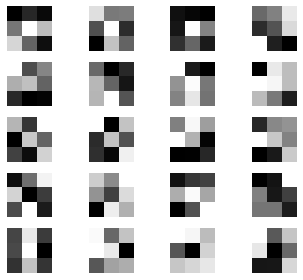

average of absolute gradients 1 tensor(4.4925e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5636e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6252e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2614e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3778e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7938e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7614e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9091e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0060e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1258e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2226e-06, device='cuda:0')


 79%|████████████████████████████████████████████████████████████▊                | 790/1000 [1:06:22<17:50,  5.10s/it]

Epoch: 790
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1944, -0.1310, -0.1792],
         [-0.0044,  0.2170,  0.1101],
         [ 0.1508, -0.0325, -0.1714]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


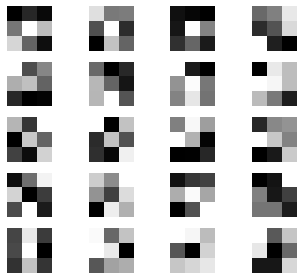

average of absolute gradients 1 tensor(3.7731e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2665e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1095e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8347e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3423e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6634e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9521e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2296e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6460e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3395e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1354e-06, device='cuda:0')


 79%|████████████████████████████████████████████████████████████▉                | 791/1000 [1:06:27<17:46,  5.10s/it]

Epoch: 791
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1944, -0.1312, -0.1791],
         [-0.0044,  0.2167,  0.1101],
         [ 0.1511, -0.0326, -0.1713]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


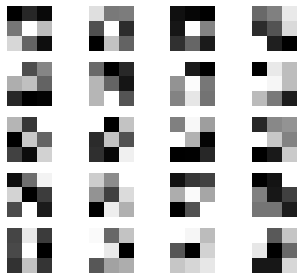

average of absolute gradients 1 tensor(3.9855e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7021e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6255e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2174e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6283e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6268e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0807e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4013e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2220e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2163e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1797e-06, device='cuda:0')


 79%|████████████████████████████████████████████████████████████▉                | 792/1000 [1:06:32<17:47,  5.13s/it]

Epoch: 792
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1944, -0.1312, -0.1791],
         [-0.0044,  0.2167,  0.1100],
         [ 0.1510, -0.0326, -0.1714]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


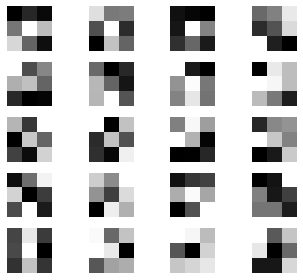

average of absolute gradients 1 tensor(3.8064e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0873e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7474e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5210e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2759e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6069e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8703e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5626e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8300e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4746e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1501e-06, device='cuda:0')


 79%|█████████████████████████████████████████████████████████████                | 793/1000 [1:06:37<17:40,  5.12s/it]

Epoch: 793
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1945, -0.1314, -0.1792],
         [-0.0044,  0.2164,  0.1097],
         [ 0.1509, -0.0328, -0.1715]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


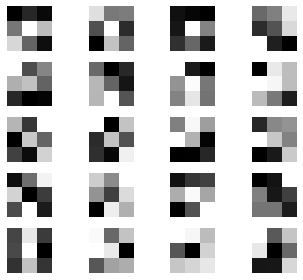

average of absolute gradients 1 tensor(3.9664e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7968e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4609e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1236e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0044e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2597e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4671e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6712e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0335e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4096e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8368e-06, device='cuda:0')


 79%|█████████████████████████████████████████████████████████████▏               | 794/1000 [1:06:42<17:35,  5.12s/it]

Epoch: 794
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1943, -0.1310, -0.1790],
         [-0.0043,  0.2167,  0.1098],
         [ 0.1510, -0.0326, -0.1714]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


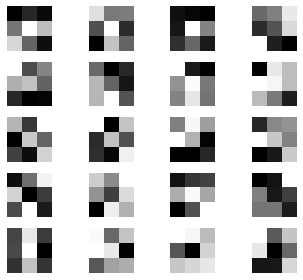

average of absolute gradients 1 tensor(4.2469e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3610e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8967e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3133e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1382e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9946e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8417e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0936e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7965e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6847e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8918e-06, device='cuda:0')


 80%|█████████████████████████████████████████████████████████████▏               | 795/1000 [1:06:47<17:29,  5.12s/it]

Epoch: 795
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1944, -0.1310, -0.1791],
         [-0.0044,  0.2166,  0.1097],
         [ 0.1512, -0.0327, -0.1713]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


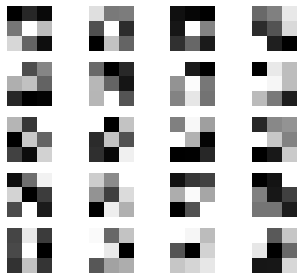

average of absolute gradients 1 tensor(4.2221e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5073e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6587e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0492e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5685e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3189e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5141e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2143e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5033e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6309e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3911e-06, device='cuda:0')


 80%|█████████████████████████████████████████████████████████████▎               | 796/1000 [1:06:52<17:22,  5.11s/it]

Epoch: 796
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1943, -0.1310, -0.1791],
         [-0.0043,  0.2165,  0.1097],
         [ 0.1511, -0.0325, -0.1713]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


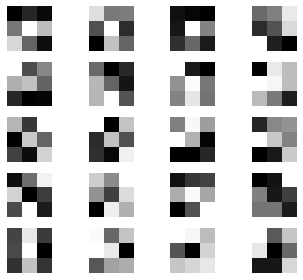

average of absolute gradients 1 tensor(4.0202e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8233e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5807e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3029e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0352e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1974e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9520e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2522e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0971e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7007e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6394e-06, device='cuda:0')


 80%|█████████████████████████████████████████████████████████████▎               | 797/1000 [1:06:58<17:17,  5.11s/it]

Epoch: 797
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1943, -0.1310, -0.1790],
         [-0.0044,  0.2164,  0.1098],
         [ 0.1513, -0.0326, -0.1713]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


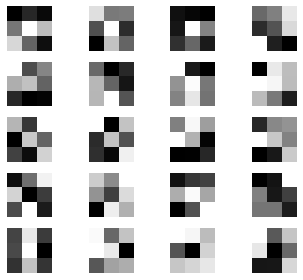

average of absolute gradients 1 tensor(4.0936e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2417e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9703e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7337e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6041e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1144e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5943e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2780e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2282e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7584e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0953e-05, device='cuda:0')


 80%|█████████████████████████████████████████████████████████████▍               | 798/1000 [1:07:03<17:11,  5.11s/it]

Epoch: 798
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1944, -0.1310, -0.1791],
         [-0.0044,  0.2162,  0.1099],
         [ 0.1510, -0.0329, -0.1714]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


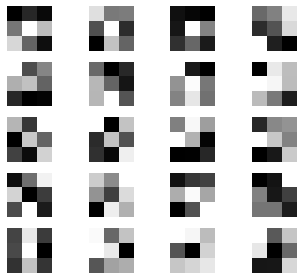

average of absolute gradients 1 tensor(4.3578e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1033e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1364e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1161e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2949e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3750e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5634e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5240e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4924e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2909e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.0433e-06, device='cuda:0')


 80%|█████████████████████████████████████████████████████████████▌               | 799/1000 [1:07:08<17:04,  5.10s/it]

Epoch: 799
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1943, -0.1309, -0.1790],
         [-0.0044,  0.2164,  0.1099],
         [ 0.1508, -0.0328, -0.1714]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


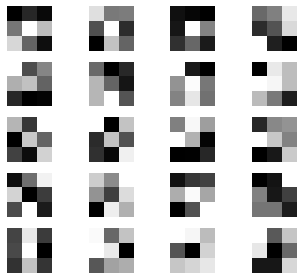

average of absolute gradients 1 tensor(3.7869e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5903e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0511e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6058e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1281e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8216e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3599e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0771e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0034e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2294e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8170e-06, device='cuda:0')


 80%|█████████████████████████████████████████████████████████████▌               | 800/1000 [1:07:13<17:00,  5.10s/it]

Epoch: 800
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1944, -0.1309, -0.1790],
         [-0.0044,  0.2164,  0.1098],
         [ 0.1508, -0.0327, -0.1714]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


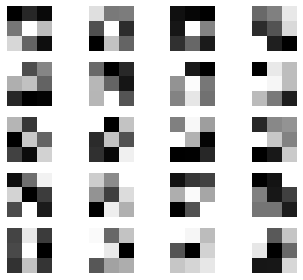

average of absolute gradients 1 tensor(4.6876e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3378e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3773e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9064e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7311e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7523e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0315e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1376e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2770e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7391e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1696e-06, device='cuda:0')


 80%|█████████████████████████████████████████████████████████████▋               | 801/1000 [1:07:18<16:55,  5.10s/it]

Epoch: 801
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1944, -0.1308, -0.1789],
         [-0.0043,  0.2165,  0.1098],
         [ 0.1509, -0.0326, -0.1712]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


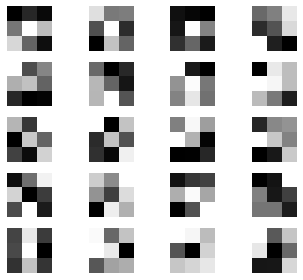

average of absolute gradients 1 tensor(3.7500e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2896e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2328e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1698e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1569e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0156e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4372e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0959e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9897e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5249e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0853e-06, device='cuda:0')


 80%|█████████████████████████████████████████████████████████████▊               | 802/1000 [1:07:23<16:50,  5.11s/it]

Epoch: 802
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1944, -0.1309, -0.1790],
         [-0.0045,  0.2162,  0.1098],
         [ 0.1508, -0.0328, -0.1713]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


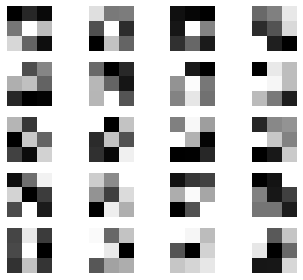

average of absolute gradients 1 tensor(3.4497e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9859e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8095e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9147e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9500e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6325e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6772e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1055e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4029e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5852e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8448e-06, device='cuda:0')


 80%|█████████████████████████████████████████████████████████████▊               | 803/1000 [1:07:28<16:46,  5.11s/it]

Epoch: 803
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1943, -0.1307, -0.1789],
         [-0.0045,  0.2164,  0.1100],
         [ 0.1508, -0.0326, -0.1712]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


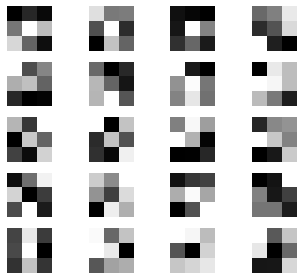

average of absolute gradients 1 tensor(3.7656e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6418e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7671e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3076e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9109e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7606e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7762e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9139e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4314e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5036e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5894e-06, device='cuda:0')


 80%|█████████████████████████████████████████████████████████████▉               | 804/1000 [1:07:33<16:42,  5.12s/it]

Epoch: 804
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1943, -0.1308, -0.1789],
         [-0.0045,  0.2162,  0.1098],
         [ 0.1509, -0.0326, -0.1712]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


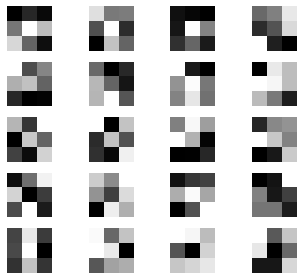

average of absolute gradients 1 tensor(4.1711e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6030e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2642e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6110e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0984e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0433e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6820e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2760e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1363e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9058e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3222e-06, device='cuda:0')


 80%|█████████████████████████████████████████████████████████████▉               | 805/1000 [1:07:38<16:34,  5.10s/it]

Epoch: 805
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1944, -0.1309, -0.1790],
         [-0.0044,  0.2162,  0.1098],
         [ 0.1507, -0.0325, -0.1712]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


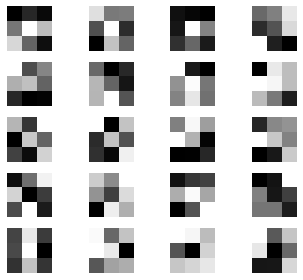

average of absolute gradients 1 tensor(3.5595e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9492e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0306e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8756e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4237e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7974e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2375e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9045e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5896e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0018e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2690e-06, device='cuda:0')


 81%|██████████████████████████████████████████████████████████████               | 806/1000 [1:07:44<16:30,  5.11s/it]

Epoch: 806
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1944, -0.1309, -0.1790],
         [-0.0044,  0.2161,  0.1098],
         [ 0.1505, -0.0325, -0.1712]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


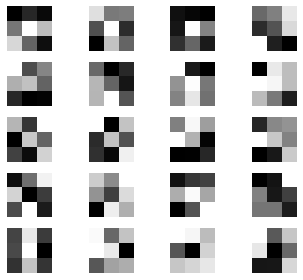

average of absolute gradients 1 tensor(3.9866e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3521e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1537e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5710e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0815e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0161e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8811e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2443e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0911e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8763e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5582e-06, device='cuda:0')


 81%|██████████████████████████████████████████████████████████████▏              | 807/1000 [1:07:49<16:24,  5.10s/it]

Epoch: 807
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1943, -0.1306, -0.1789],
         [-0.0044,  0.2163,  0.1098],
         [ 0.1507, -0.0325, -0.1711]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


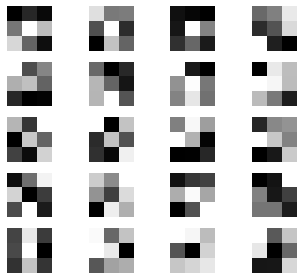

average of absolute gradients 1 tensor(4.3213e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6207e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8919e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5183e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0986e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8247e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2949e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6601e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7273e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9064e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9184e-06, device='cuda:0')


 81%|██████████████████████████████████████████████████████████████▏              | 808/1000 [1:07:54<16:20,  5.10s/it]

Epoch: 808
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1944, -0.1307, -0.1788],
         [-0.0044,  0.2163,  0.1097],
         [ 0.1506, -0.0325, -0.1711]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


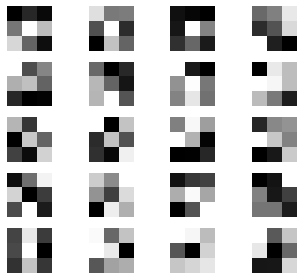

average of absolute gradients 1 tensor(3.9861e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8312e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0079e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2508e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4951e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4082e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8212e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4489e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1673e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6178e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7112e-06, device='cuda:0')


 81%|██████████████████████████████████████████████████████████████▎              | 809/1000 [1:07:59<16:15,  5.11s/it]

Epoch: 809
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1944, -0.1308, -0.1788],
         [-0.0043,  0.2161,  0.1097],
         [ 0.1505, -0.0326, -0.1711]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


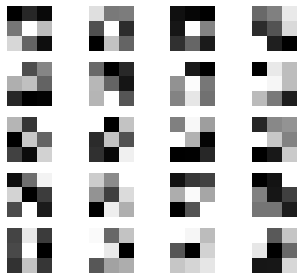

average of absolute gradients 1 tensor(3.8128e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0091e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5867e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0825e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9678e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8610e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1167e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4643e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3397e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5888e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9916e-06, device='cuda:0')


 81%|██████████████████████████████████████████████████████████████▎              | 810/1000 [1:08:04<16:10,  5.11s/it]

Epoch: 810
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1945, -0.1308, -0.1789],
         [-0.0043,  0.2159,  0.1096],
         [ 0.1506, -0.0324, -0.1711]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


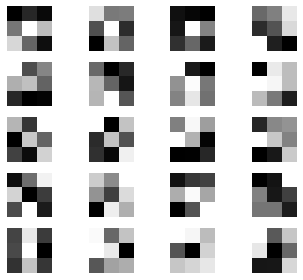

average of absolute gradients 1 tensor(4.5778e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2634e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7634e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8442e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4346e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7294e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9142e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4324e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5011e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6687e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1336e-06, device='cuda:0')


 81%|██████████████████████████████████████████████████████████████▍              | 811/1000 [1:08:09<16:05,  5.11s/it]

Epoch: 811
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1944, -0.1308, -0.1789],
         [-0.0043,  0.2159,  0.1096],
         [ 0.1505, -0.0327, -0.1712]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


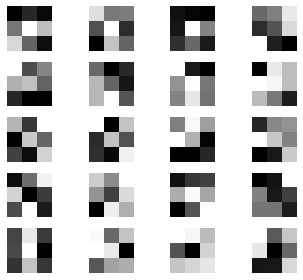

average of absolute gradients 1 tensor(3.7707e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2889e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1488e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8838e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2700e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9663e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7838e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0119e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7556e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7746e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8496e-06, device='cuda:0')


 81%|██████████████████████████████████████████████████████████████▌              | 812/1000 [1:08:14<16:00,  5.11s/it]

Epoch: 812
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1944, -0.1308, -0.1788],
         [-0.0043,  0.2158,  0.1095],
         [ 0.1505, -0.0326, -0.1712]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


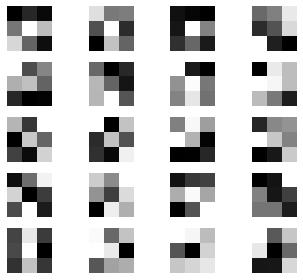

average of absolute gradients 1 tensor(4.0443e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9000e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0183e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7254e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0020e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2988e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5920e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0777e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4855e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5381e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3127e-06, device='cuda:0')


 81%|██████████████████████████████████████████████████████████████▌              | 813/1000 [1:08:19<15:54,  5.10s/it]

Epoch: 813
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1944, -0.1306, -0.1787],
         [-0.0041,  0.2159,  0.1096],
         [ 0.1506, -0.0326, -0.1711]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


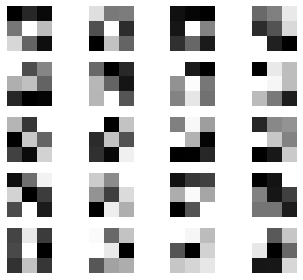

average of absolute gradients 1 tensor(3.6520e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0808e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8113e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9825e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3081e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9071e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7856e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3529e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8042e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5434e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.1458e-06, device='cuda:0')


 81%|██████████████████████████████████████████████████████████████▋              | 814/1000 [1:08:24<15:49,  5.10s/it]

Epoch: 814
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1946, -0.1307, -0.1788],
         [-0.0042,  0.2157,  0.1095],
         [ 0.1506, -0.0326, -0.1710]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


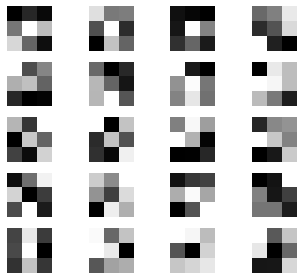

average of absolute gradients 1 tensor(3.2441e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5749e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3933e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6214e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6686e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4667e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8415e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4776e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8831e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9034e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.9408e-06, device='cuda:0')


 82%|██████████████████████████████████████████████████████████████▊              | 815/1000 [1:08:30<15:46,  5.11s/it]

Epoch: 815
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1946, -0.1306, -0.1788],
         [-0.0040,  0.2158,  0.1095],
         [ 0.1504, -0.0326, -0.1710]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


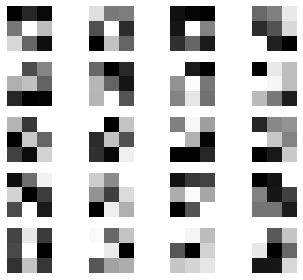

average of absolute gradients 1 tensor(4.6945e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8425e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6042e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3358e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5328e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8598e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0054e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5999e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6579e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3199e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4043e-06, device='cuda:0')


 82%|██████████████████████████████████████████████████████████████▊              | 816/1000 [1:08:35<15:43,  5.13s/it]

Epoch: 816
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1948, -0.1307, -0.1788],
         [-0.0041,  0.2156,  0.1093],
         [ 0.1505, -0.0327, -0.1709]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


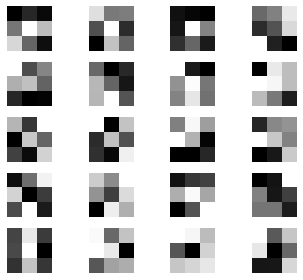

average of absolute gradients 1 tensor(3.9140e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5901e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1874e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9987e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8323e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8336e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1398e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7130e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7649e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6294e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9942e-06, device='cuda:0')


 82%|██████████████████████████████████████████████████████████████▉              | 817/1000 [1:08:40<15:37,  5.12s/it]

Epoch: 817
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1946, -0.1307, -0.1787],
         [-0.0043,  0.2156,  0.1094],
         [ 0.1506, -0.0327, -0.1709]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


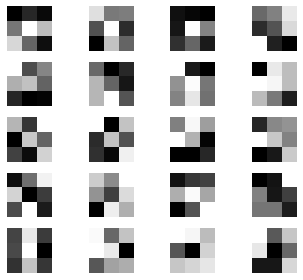

average of absolute gradients 1 tensor(4.3323e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6050e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4917e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9515e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6466e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9804e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1979e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7246e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5897e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0362e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2904e-06, device='cuda:0')


 82%|██████████████████████████████████████████████████████████████▉              | 818/1000 [1:08:45<15:31,  5.12s/it]

Epoch: 818
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1947, -0.1306, -0.1788],
         [-0.0041,  0.2155,  0.1094],
         [ 0.1506, -0.0326, -0.1708]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


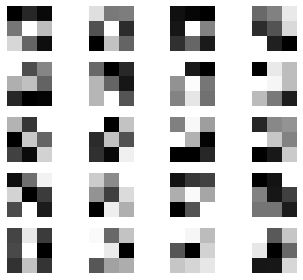

average of absolute gradients 1 tensor(4.3022e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3735e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9539e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4148e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5730e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7723e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6545e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1273e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0827e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5736e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9444e-06, device='cuda:0')


 82%|███████████████████████████████████████████████████████████████              | 819/1000 [1:08:50<15:25,  5.11s/it]

Epoch: 819
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1947, -0.1307, -0.1788],
         [-0.0040,  0.2154,  0.1094],
         [ 0.1506, -0.0324, -0.1708]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


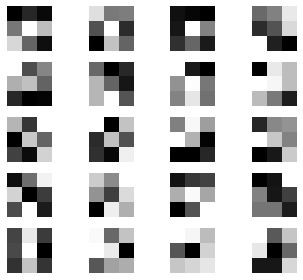

average of absolute gradients 1 tensor(4.6671e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1117e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2627e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4146e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8856e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4603e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1215e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1275e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3966e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2209e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9776e-06, device='cuda:0')


 82%|███████████████████████████████████████████████████████████████▏             | 820/1000 [1:08:55<15:20,  5.11s/it]

Epoch: 820
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1947, -0.1304, -0.1786],
         [-0.0039,  0.2157,  0.1097],
         [ 0.1504, -0.0324, -0.1707]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


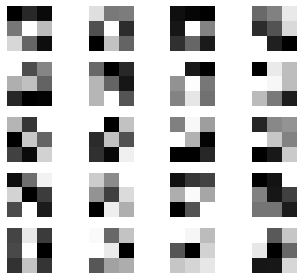

average of absolute gradients 1 tensor(3.4105e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3778e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7630e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6496e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6027e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3910e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4179e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4109e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6253e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1268e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4343e-06, device='cuda:0')


 82%|███████████████████████████████████████████████████████████████▏             | 821/1000 [1:09:00<15:15,  5.12s/it]

Epoch: 821
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1948, -0.1305, -0.1788],
         [-0.0041,  0.2154,  0.1095],
         [ 0.1503, -0.0325, -0.1707]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


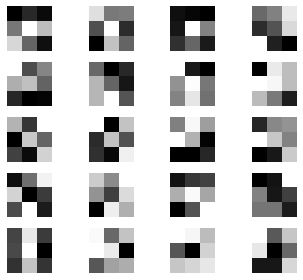

average of absolute gradients 1 tensor(3.6445e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4528e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6930e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3424e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4323e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5735e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7801e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7819e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4286e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3163e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.4699e-06, device='cuda:0')


 82%|███████████████████████████████████████████████████████████████▎             | 822/1000 [1:09:05<15:09,  5.11s/it]

Epoch: 822
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1948, -0.1306, -0.1788],
         [-0.0040,  0.2153,  0.1094],
         [ 0.1504, -0.0325, -0.1707]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


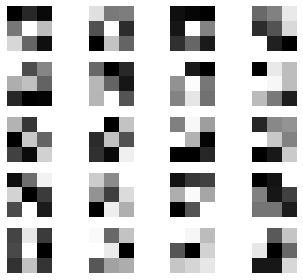

average of absolute gradients 1 tensor(3.6948e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0238e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9222e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6143e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1435e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3752e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1177e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4907e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5987e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8248e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6769e-06, device='cuda:0')


 82%|███████████████████████████████████████████████████████████████▎             | 823/1000 [1:09:10<15:03,  5.11s/it]

Epoch: 823
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1948, -0.1307, -0.1787],
         [-0.0041,  0.2153,  0.1094],
         [ 0.1503, -0.0325, -0.1707]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


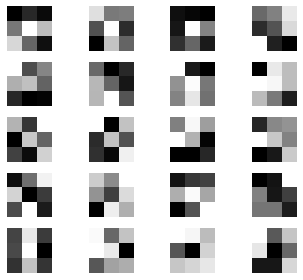

average of absolute gradients 1 tensor(3.4322e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9363e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2680e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0715e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1236e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3612e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0885e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4191e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4857e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9530e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4831e-06, device='cuda:0')


 82%|███████████████████████████████████████████████████████████████▍             | 824/1000 [1:09:16<14:58,  5.11s/it]

Epoch: 824
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1948, -0.1305, -0.1786],
         [-0.0040,  0.2154,  0.1094],
         [ 0.1503, -0.0325, -0.1706]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


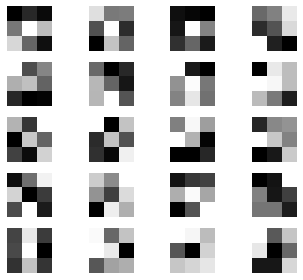

average of absolute gradients 1 tensor(4.1318e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1243e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7225e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2851e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3853e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5530e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0649e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5297e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6124e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3295e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4719e-06, device='cuda:0')


 82%|███████████████████████████████████████████████████████████████▌             | 825/1000 [1:09:21<14:53,  5.11s/it]

Epoch: 825
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1950, -0.1306, -0.1787],
         [-0.0041,  0.2151,  0.1092],
         [ 0.1503, -0.0326, -0.1707]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


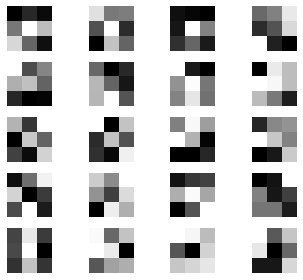

average of absolute gradients 1 tensor(3.7818e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8061e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2346e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2555e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4270e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7164e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7575e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2178e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8895e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3989e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1254e-06, device='cuda:0')


 83%|███████████████████████████████████████████████████████████████▌             | 826/1000 [1:09:26<14:47,  5.10s/it]

Epoch: 826
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1948, -0.1305, -0.1786],
         [-0.0039,  0.2152,  0.1092],
         [ 0.1505, -0.0325, -0.1707]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


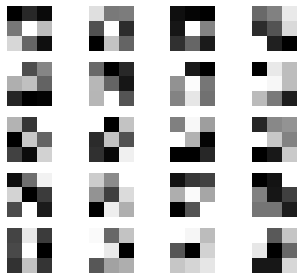

average of absolute gradients 1 tensor(3.7601e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1751e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6334e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6030e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2758e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9405e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0881e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2819e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6899e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1786e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3985e-06, device='cuda:0')


 83%|███████████████████████████████████████████████████████████████▋             | 827/1000 [1:09:31<14:45,  5.12s/it]

Epoch: 827
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1949, -0.1306, -0.1786],
         [-0.0038,  0.2150,  0.1093],
         [ 0.1503, -0.0325, -0.1706]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


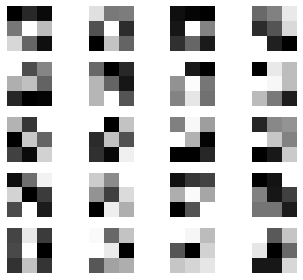

average of absolute gradients 1 tensor(4.3191e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8430e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3565e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4422e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9420e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1282e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9667e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2557e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4122e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1093e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9515e-06, device='cuda:0')


 83%|███████████████████████████████████████████████████████████████▊             | 828/1000 [1:09:36<14:39,  5.11s/it]

Epoch: 828
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1948, -0.1305, -0.1786],
         [-0.0039,  0.2152,  0.1094],
         [ 0.1503, -0.0325, -0.1706]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


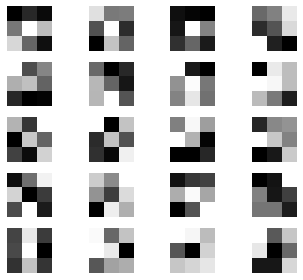

average of absolute gradients 1 tensor(3.2525e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6936e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9889e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5014e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1808e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0761e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3177e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7607e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6250e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5236e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6343e-06, device='cuda:0')


 83%|███████████████████████████████████████████████████████████████▊             | 829/1000 [1:09:41<14:33,  5.11s/it]

Epoch: 829
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1949, -0.1305, -0.1787],
         [-0.0039,  0.2150,  0.1092],
         [ 0.1502, -0.0326, -0.1706]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


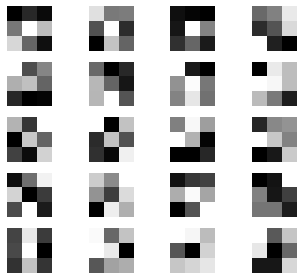

average of absolute gradients 1 tensor(4.4515e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7857e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6196e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8682e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5711e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8072e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7067e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4285e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8879e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8387e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6386e-06, device='cuda:0')


 83%|███████████████████████████████████████████████████████████████▉             | 830/1000 [1:09:46<14:28,  5.11s/it]

Epoch: 830
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1948, -0.1305, -0.1787],
         [-0.0038,  0.2150,  0.1092],
         [ 0.1502, -0.0327, -0.1706]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


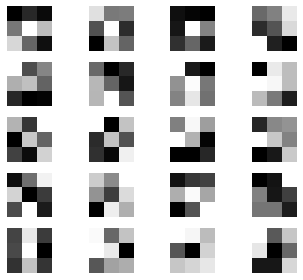

average of absolute gradients 1 tensor(3.8148e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7188e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4796e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8871e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4675e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2120e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4379e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4344e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0367e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6452e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7719e-06, device='cuda:0')


 83%|███████████████████████████████████████████████████████████████▉             | 831/1000 [1:09:51<14:23,  5.11s/it]

Epoch: 831
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1948, -0.1307, -0.1788],
         [-0.0038,  0.2149,  0.1090],
         [ 0.1503, -0.0327, -0.1705]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


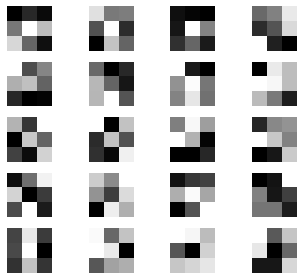

average of absolute gradients 1 tensor(3.7785e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3686e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5635e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3482e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5274e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8597e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2658e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8372e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6959e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7806e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7042e-06, device='cuda:0')


 83%|████████████████████████████████████████████████████████████████             | 832/1000 [1:09:56<14:16,  5.10s/it]

Epoch: 832
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1948, -0.1306, -0.1788],
         [-0.0036,  0.2147,  0.1092],
         [ 0.1502, -0.0327, -0.1705]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


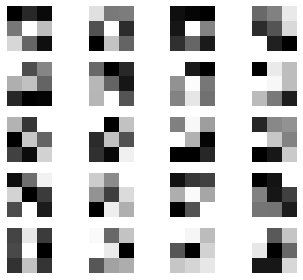

average of absolute gradients 1 tensor(4.4300e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1117e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6161e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3797e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1792e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9584e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5791e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4948e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2006e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4099e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3893e-06, device='cuda:0')


 83%|████████████████████████████████████████████████████████████████▏            | 833/1000 [1:10:01<14:10,  5.10s/it]

Epoch: 833
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1948, -0.1304, -0.1788],
         [-0.0035,  0.2148,  0.1093],
         [ 0.1502, -0.0326, -0.1704]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


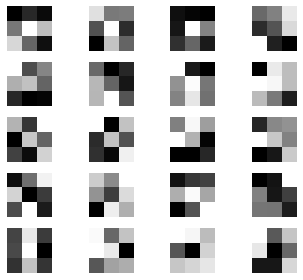

average of absolute gradients 1 tensor(3.7916e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2601e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9344e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7188e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6344e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9963e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7851e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9221e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6917e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0707e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6898e-06, device='cuda:0')


 83%|████████████████████████████████████████████████████████████████▏            | 834/1000 [1:10:07<14:06,  5.10s/it]

Epoch: 834
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1949, -0.1305, -0.1789],
         [-0.0035,  0.2147,  0.1093],
         [ 0.1500, -0.0325, -0.1704]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


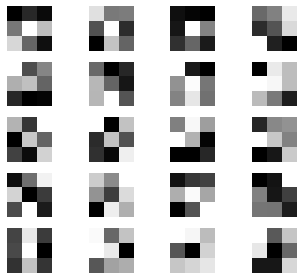

average of absolute gradients 1 tensor(3.6834e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8267e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8927e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1072e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4363e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2405e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5418e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5961e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3492e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9087e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0476e-06, device='cuda:0')


 84%|████████████████████████████████████████████████████████████████▎            | 835/1000 [1:10:12<14:02,  5.11s/it]

Epoch: 835
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1949, -0.1305, -0.1789],
         [-0.0034,  0.2147,  0.1093],
         [ 0.1500, -0.0325, -0.1704]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


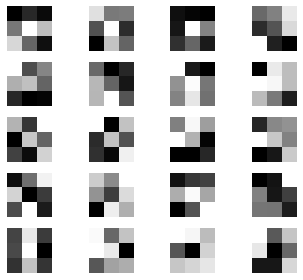

average of absolute gradients 1 tensor(4.1067e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1525e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5073e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8560e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6424e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9679e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0722e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7068e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9799e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4158e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1813e-06, device='cuda:0')


 84%|████████████████████████████████████████████████████████████████▎            | 836/1000 [1:10:17<14:00,  5.12s/it]

Epoch: 836
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1950, -0.1305, -0.1789],
         [-0.0033,  0.2146,  0.1091],
         [ 0.1500, -0.0325, -0.1704]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


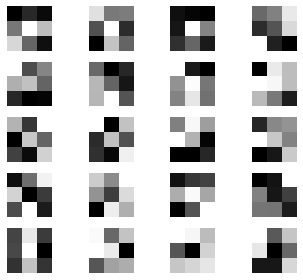

average of absolute gradients 1 tensor(4.2352e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9486e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4016e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5959e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9770e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7080e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8303e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8888e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2963e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3742e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9955e-06, device='cuda:0')


 84%|████████████████████████████████████████████████████████████████▍            | 837/1000 [1:10:22<13:57,  5.14s/it]

Epoch: 837
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1951, -0.1304, -0.1789],
         [-0.0033,  0.2146,  0.1090],
         [ 0.1500, -0.0325, -0.1703]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


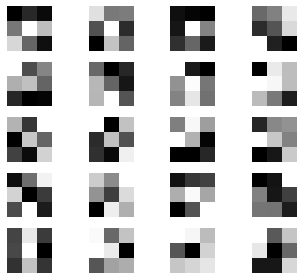

average of absolute gradients 1 tensor(4.0443e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0852e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9418e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8819e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9077e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3300e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8120e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9239e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2363e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3344e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8251e-06, device='cuda:0')


 84%|████████████████████████████████████████████████████████████████▌            | 838/1000 [1:10:27<13:52,  5.14s/it]

Epoch: 838
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1951, -0.1305, -0.1791],
         [-0.0033,  0.2143,  0.1089],
         [ 0.1501, -0.0325, -0.1703]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


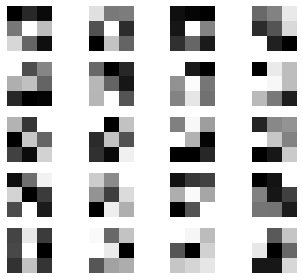

average of absolute gradients 1 tensor(3.2225e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4454e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2209e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2655e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6639e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4313e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2373e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4838e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1109e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9441e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3159e-06, device='cuda:0')


 84%|████████████████████████████████████████████████████████████████▌            | 839/1000 [1:10:33<13:59,  5.21s/it]

Epoch: 839
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1952, -0.1304, -0.1791],
         [-0.0031,  0.2142,  0.1089],
         [ 0.1501, -0.0324, -0.1703]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


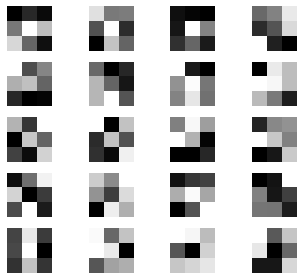

average of absolute gradients 1 tensor(4.3522e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8010e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4701e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7676e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4505e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2689e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8479e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9588e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6220e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1337e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5115e-06, device='cuda:0')


 84%|████████████████████████████████████████████████████████████████▋            | 840/1000 [1:10:38<13:52,  5.21s/it]

Epoch: 840
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1952, -0.1302, -0.1792],
         [-0.0030,  0.2141,  0.1088],
         [ 0.1502, -0.0322, -0.1703]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


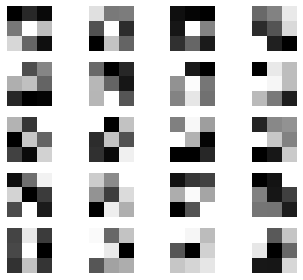

average of absolute gradients 1 tensor(4.1064e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3666e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3662e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5484e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4832e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8275e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9678e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0089e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2328e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9631e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1306e-06, device='cuda:0')


 84%|████████████████████████████████████████████████████████████████▊            | 841/1000 [1:10:43<13:43,  5.18s/it]

Epoch: 841
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1953, -0.1303, -0.1793],
         [-0.0030,  0.2140,  0.1088],
         [ 0.1500, -0.0323, -0.1702]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


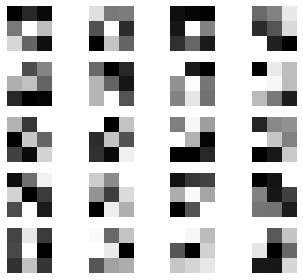

average of absolute gradients 1 tensor(4.4689e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2369e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3383e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6646e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3311e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5066e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1018e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5881e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1300e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5875e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0093e-06, device='cuda:0')


 84%|████████████████████████████████████████████████████████████████▊            | 842/1000 [1:10:48<13:33,  5.15s/it]

Epoch: 842
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1953, -0.1302, -0.1792],
         [-0.0028,  0.2140,  0.1088],
         [ 0.1502, -0.0322, -0.1701]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


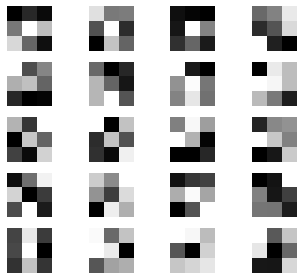

average of absolute gradients 1 tensor(4.3407e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1003e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7404e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2432e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1944e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5170e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3862e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7409e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8332e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2300e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3745e-06, device='cuda:0')


 84%|████████████████████████████████████████████████████████████████▉            | 843/1000 [1:10:53<13:26,  5.14s/it]

Epoch: 843
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1953, -0.1303, -0.1790],
         [-0.0024,  0.2141,  0.1091],
         [ 0.1502, -0.0322, -0.1699]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


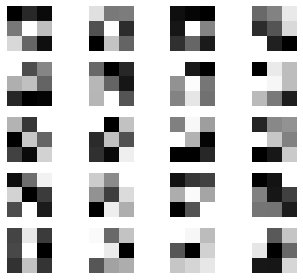

average of absolute gradients 1 tensor(4.6058e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8136e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3920e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1984e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4193e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1446e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5590e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6666e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4681e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5823e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5976e-06, device='cuda:0')


 84%|████████████████████████████████████████████████████████████████▉            | 844/1000 [1:10:58<13:19,  5.12s/it]

Epoch: 844
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1954, -0.1302, -0.1789],
         [-0.0024,  0.2140,  0.1090],
         [ 0.1504, -0.0321, -0.1698]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


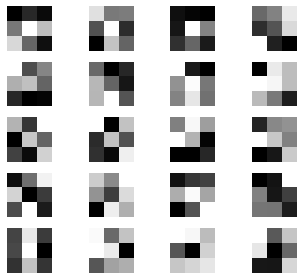

average of absolute gradients 1 tensor(4.1690e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2022e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4786e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6570e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5088e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9584e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7430e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4620e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7236e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2371e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4653e-06, device='cuda:0')


 84%|█████████████████████████████████████████████████████████████████            | 845/1000 [1:11:03<13:13,  5.12s/it]

Epoch: 845
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1956, -0.1302, -0.1789],
         [-0.0022,  0.2139,  0.1090],
         [ 0.1504, -0.0320, -0.1698]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


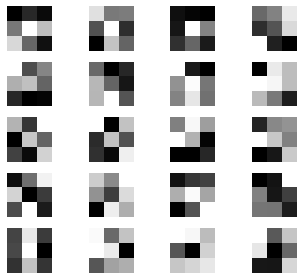

average of absolute gradients 1 tensor(3.7011e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6509e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1383e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6999e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1939e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2810e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5852e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2312e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3368e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8762e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2821e-06, device='cuda:0')


 85%|█████████████████████████████████████████████████████████████████▏           | 846/1000 [1:11:08<13:06,  5.11s/it]

Epoch: 846
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1956, -0.1300, -0.1788],
         [-0.0021,  0.2141,  0.1090],
         [ 0.1502, -0.0319, -0.1697]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


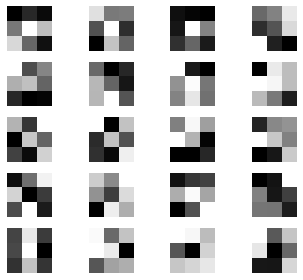

average of absolute gradients 1 tensor(4.2899e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1098e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7895e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7635e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1671e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7788e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1463e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0874e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6714e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8359e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.2247e-06, device='cuda:0')


 85%|█████████████████████████████████████████████████████████████████▏           | 847/1000 [1:11:13<12:59,  5.09s/it]

Epoch: 847
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1957, -0.1301, -0.1790],
         [-0.0020,  0.2140,  0.1088],
         [ 0.1502, -0.0320, -0.1696]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


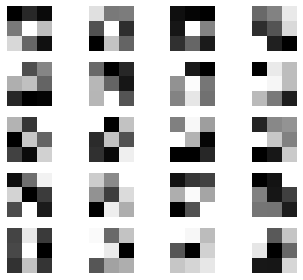

average of absolute gradients 1 tensor(4.5142e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1169e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5312e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3312e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7093e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7761e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6976e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1868e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1842e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8740e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6223e-06, device='cuda:0')


 85%|█████████████████████████████████████████████████████████████████▎           | 848/1000 [1:11:19<12:54,  5.10s/it]

Epoch: 848
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1957, -0.1299, -0.1790],
         [-0.0019,  0.2140,  0.1089],
         [ 0.1503, -0.0320, -0.1694]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


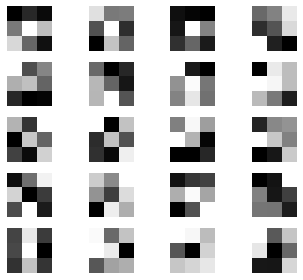

average of absolute gradients 1 tensor(4.3234e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1039e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1111e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2734e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9571e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0166e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8465e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6790e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7178e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3540e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2924e-06, device='cuda:0')


 85%|█████████████████████████████████████████████████████████████████▎           | 849/1000 [1:11:24<12:50,  5.10s/it]

Epoch: 849
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1958, -0.1299, -0.1790],
         [-0.0018,  0.2138,  0.1088],
         [ 0.1506, -0.0321, -0.1693]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


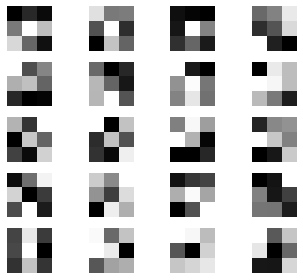

average of absolute gradients 1 tensor(5.3080e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3397e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1406e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7009e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2882e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8894e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0349e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1367e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3128e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6661e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4544e-06, device='cuda:0')


 85%|█████████████████████████████████████████████████████████████████▍           | 850/1000 [1:11:29<12:46,  5.11s/it]

Epoch: 850
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1959, -0.1299, -0.1789],
         [-0.0016,  0.2138,  0.1088],
         [ 0.1507, -0.0321, -0.1691]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


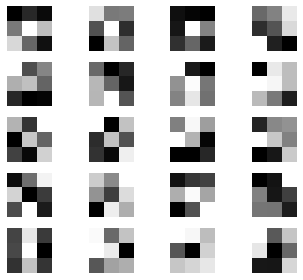

average of absolute gradients 1 tensor(4.8936e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5859e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6871e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7845e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7024e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1562e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5802e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0849e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7585e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1302e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5760e-06, device='cuda:0')


 85%|█████████████████████████████████████████████████████████████████▌           | 851/1000 [1:11:34<12:42,  5.12s/it]

Epoch: 851
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1960, -0.1299, -0.1789],
         [-0.0014,  0.2137,  0.1087],
         [ 0.1507, -0.0322, -0.1690]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


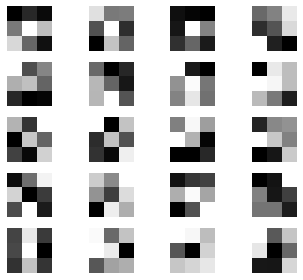

average of absolute gradients 1 tensor(4.7999e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3561e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2436e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6018e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3221e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3199e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5732e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5209e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2225e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6286e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.1625e-06, device='cuda:0')


 85%|█████████████████████████████████████████████████████████████████▌           | 852/1000 [1:11:39<12:36,  5.11s/it]

Epoch: 852
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1959, -0.1296, -0.1786],
         [-0.0011,  0.2142,  0.1088],
         [ 0.1509, -0.0320, -0.1687]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


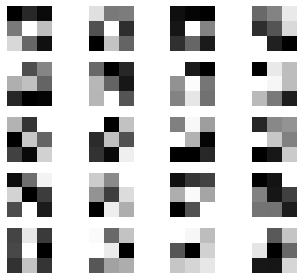

average of absolute gradients 1 tensor(5.3640e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8809e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0982e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1962e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6515e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2261e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0493e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3755e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2852e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4446e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3255e-06, device='cuda:0')


 85%|█████████████████████████████████████████████████████████████████▋           | 853/1000 [1:11:44<12:30,  5.10s/it]

Epoch: 853
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1961, -0.1297, -0.1787],
         [-0.0013,  0.2138,  0.1086],
         [ 0.1509, -0.0323, -0.1687]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


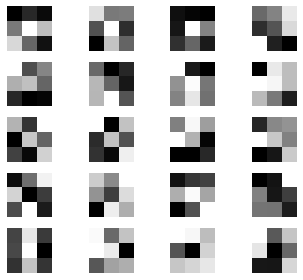

average of absolute gradients 1 tensor(4.9041e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6715e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1747e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6735e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9992e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2579e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4219e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1384e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7321e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5558e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2540e-06, device='cuda:0')


 85%|█████████████████████████████████████████████████████████████████▊           | 854/1000 [1:11:49<12:25,  5.10s/it]

Epoch: 854
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1962, -0.1295, -0.1786],
         [-0.0013,  0.2139,  0.1087],
         [ 0.1511, -0.0319, -0.1685]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


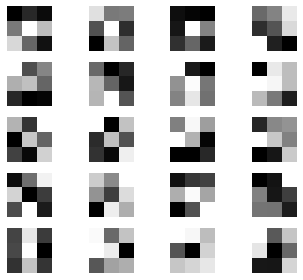

average of absolute gradients 1 tensor(5.8244e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3049e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2838e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0097e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7191e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1544e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2520e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4908e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3104e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3153e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0755e-06, device='cuda:0')


 86%|█████████████████████████████████████████████████████████████████▊           | 855/1000 [1:11:54<12:20,  5.11s/it]

Epoch: 855
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1964, -0.1297, -0.1786],
         [-0.0013,  0.2138,  0.1084],
         [ 0.1510, -0.0321, -0.1685]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


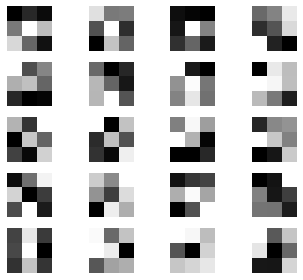

average of absolute gradients 1 tensor(5.5707e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7699e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2639e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8535e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4786e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4859e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2010e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9600e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3238e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0804e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1228e-06, device='cuda:0')


 86%|█████████████████████████████████████████████████████████████████▉           | 856/1000 [1:11:59<12:14,  5.10s/it]

Epoch: 856
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1964, -0.1298, -0.1786],
         [-0.0015,  0.2137,  0.1084],
         [ 0.1510, -0.0321, -0.1684]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


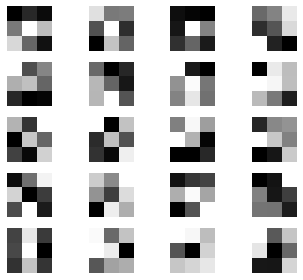

average of absolute gradients 1 tensor(5.2672e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4620e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9055e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1786e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9417e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3312e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9180e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5553e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1164e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7488e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6433e-06, device='cuda:0')


 86%|█████████████████████████████████████████████████████████████████▉           | 857/1000 [1:12:04<12:09,  5.10s/it]

Epoch: 857
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1963, -0.1299, -0.1785],
         [-0.0014,  0.2138,  0.1083],
         [ 0.1511, -0.0321, -0.1683]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


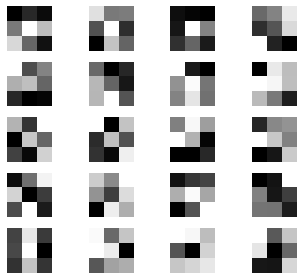

average of absolute gradients 1 tensor(5.4682e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6009e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6765e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7091e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7744e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6232e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9262e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0513e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8564e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1828e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8182e-06, device='cuda:0')


 86%|██████████████████████████████████████████████████████████████████           | 858/1000 [1:12:10<12:03,  5.09s/it]

Epoch: 858
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1962, -0.1297, -0.1784],
         [-0.0011,  0.2141,  0.1085],
         [ 0.1510, -0.0319, -0.1683]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


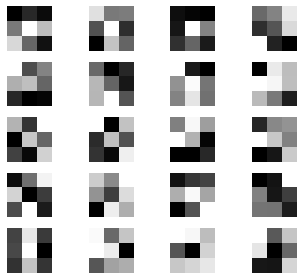

average of absolute gradients 1 tensor(5.4128e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7711e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1044e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0159e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0491e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0483e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7783e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4652e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9776e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5168e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.3772e-06, device='cuda:0')


 86%|██████████████████████████████████████████████████████████████████▏          | 859/1000 [1:12:15<11:57,  5.09s/it]

Epoch: 859
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1961, -0.1300, -0.1787],
         [-0.0012,  0.2138,  0.1083],
         [ 0.1508, -0.0321, -0.1683]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


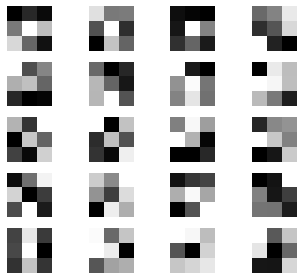

average of absolute gradients 1 tensor(5.1456e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4350e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5719e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7515e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1582e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5429e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0782e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0242e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9936e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2737e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4705e-06, device='cuda:0')


 86%|██████████████████████████████████████████████████████████████████▏          | 860/1000 [1:12:20<11:52,  5.09s/it]

Epoch: 860
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1959, -0.1299, -0.1787],
         [-0.0011,  0.2140,  0.1083],
         [ 0.1511, -0.0318, -0.1681]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


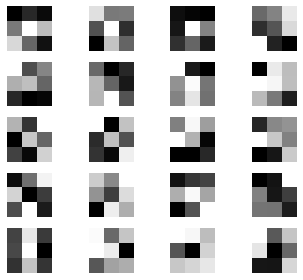

average of absolute gradients 1 tensor(5.0425e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0138e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7442e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2244e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6136e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5112e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7783e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.2316e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2380e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4614e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8385e-06, device='cuda:0')


 86%|██████████████████████████████████████████████████████████████████▎          | 861/1000 [1:12:25<11:46,  5.08s/it]

Epoch: 861
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1960, -0.1302, -0.1789],
         [-0.0011,  0.2138,  0.1080],
         [ 0.1508, -0.0320, -0.1682]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


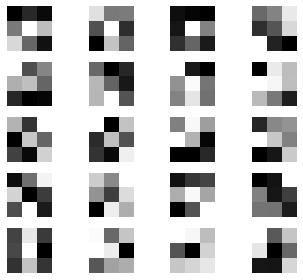

average of absolute gradients 1 tensor(5.3526e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5117e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3095e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0722e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4694e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0211e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5164e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0455e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7913e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5391e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3445e-06, device='cuda:0')


 86%|██████████████████████████████████████████████████████████████████▎          | 862/1000 [1:12:30<11:44,  5.10s/it]

Epoch: 862
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1958, -0.1302, -0.1787],
         [-0.0011,  0.2139,  0.1081],
         [ 0.1511, -0.0319, -0.1681]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


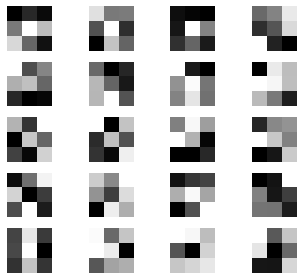

average of absolute gradients 1 tensor(5.4499e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7182e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6685e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3626e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6317e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8542e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8491e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1439e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3997e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8828e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7331e-06, device='cuda:0')


 86%|██████████████████████████████████████████████████████████████████▍          | 863/1000 [1:12:35<11:42,  5.13s/it]

Epoch: 863
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1959, -0.1303, -0.1789],
         [-0.0011,  0.2136,  0.1077],
         [ 0.1512, -0.0318, -0.1681]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


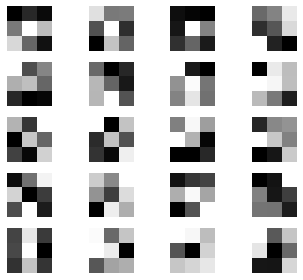

average of absolute gradients 1 tensor(5.8388e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0977e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1843e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2956e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1106e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8061e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0301e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5092e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8548e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5494e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.3874e-06, device='cuda:0')


 86%|██████████████████████████████████████████████████████████████████▌          | 864/1000 [1:12:40<11:35,  5.12s/it]

Epoch: 864
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1958, -0.1305, -0.1790],
         [-0.0010,  0.2135,  0.1074],
         [ 0.1513, -0.0319, -0.1681]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


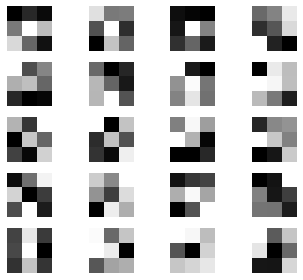

average of absolute gradients 1 tensor(5.5157e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1471e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8925e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.1130e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2968e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2515e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4402e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2117e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0250e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5239e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8159e-06, device='cuda:0')


 86%|██████████████████████████████████████████████████████████████████▌          | 865/1000 [1:12:45<11:30,  5.11s/it]

Epoch: 865
Accuracy of train set: 26%
Accuracy of test set: 11%

tensor([[[-0.1957, -0.1308, -0.1792],
         [-0.0010,  0.2136,  0.1072],
         [ 0.1508, -0.0318, -0.1680]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


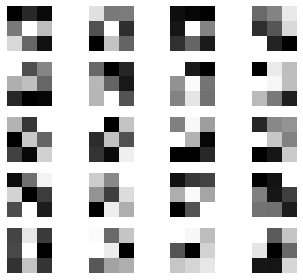

average of absolute gradients 1 tensor(4.5052e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9198e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3259e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4110e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4726e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.1668e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4194e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5350e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0104e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3165e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2774e-06, device='cuda:0')


 87%|██████████████████████████████████████████████████████████████████▋          | 866/1000 [1:12:50<11:24,  5.11s/it]

Epoch: 866
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1957, -0.1306, -0.1791],
         [-0.0008,  0.2139,  0.1072],
         [ 0.1509, -0.0316, -0.1680]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


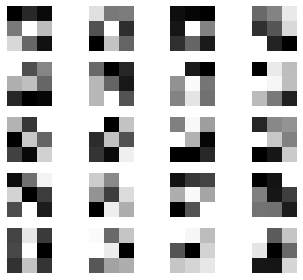

average of absolute gradients 1 tensor(6.0041e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6718e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0532e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5371e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6130e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5906e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5961e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8012e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9973e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.7213e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.2954e-06, device='cuda:0')


 87%|██████████████████████████████████████████████████████████████████▊          | 867/1000 [1:12:55<11:18,  5.10s/it]

Epoch: 867
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1954, -0.1306, -0.1791],
         [-0.0007,  0.2140,  0.1070],
         [ 0.1512, -0.0315, -0.1679]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


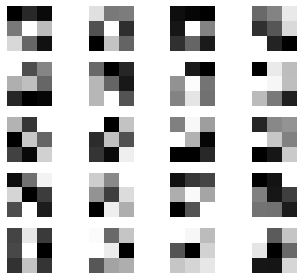

average of absolute gradients 1 tensor(5.2830e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2714e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0371e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3323e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5654e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9094e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8320e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5477e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1305e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.0394e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6213e-06, device='cuda:0')


 87%|██████████████████████████████████████████████████████████████████▊          | 868/1000 [1:13:01<11:13,  5.10s/it]

Epoch: 868
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1955, -0.1308, -0.1792],
         [-0.0004,  0.2139,  0.1068],
         [ 0.1512, -0.0317, -0.1679]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


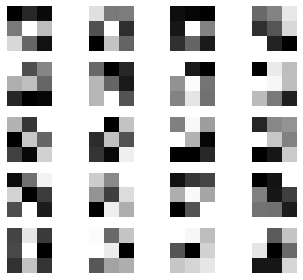

average of absolute gradients 1 tensor(5.0816e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3174e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4202e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9809e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5634e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7362e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8073e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4011e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4401e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.1556e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.2784e-06, device='cuda:0')


 87%|██████████████████████████████████████████████████████████████████▉          | 869/1000 [1:13:06<11:07,  5.10s/it]

Epoch: 869
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1952, -0.1308, -0.1793],
         [-0.0005,  0.2138,  0.1069],
         [ 0.1513, -0.0318, -0.1678]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


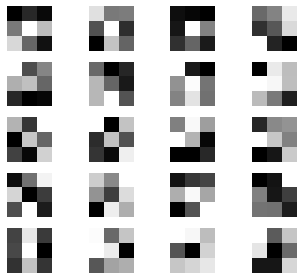

average of absolute gradients 1 tensor(6.2378e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8410e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7656e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2541e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6347e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9983e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2401e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5801e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4641e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9103e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9163e-06, device='cuda:0')


 87%|██████████████████████████████████████████████████████████████████▉          | 870/1000 [1:13:11<11:02,  5.09s/it]

Epoch: 870
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1952, -0.1306, -0.1793],
         [-0.0003,  0.2140,  0.1068],
         [ 0.1513, -0.0317, -0.1677]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


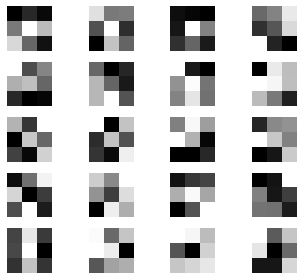

average of absolute gradients 1 tensor(5.4192e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3312e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1452e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7194e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3833e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4262e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3675e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6258e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.7915e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2554e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.8023e-06, device='cuda:0')


 87%|███████████████████████████████████████████████████████████████████          | 871/1000 [1:13:16<10:57,  5.10s/it]

Epoch: 871
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1950, -0.1305, -0.1791],
         [-0.0003,  0.2143,  0.1069],
         [ 0.1513, -0.0315, -0.1677]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


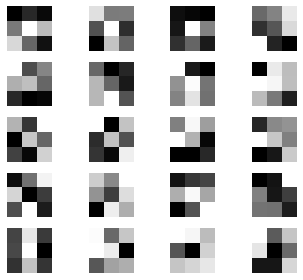

average of absolute gradients 1 tensor(5.1620e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1734e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9448e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6709e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0631e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7650e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.2262e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6000e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4709e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6096e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8013e-06, device='cuda:0')


 87%|███████████████████████████████████████████████████████████████████▏         | 872/1000 [1:13:21<10:51,  5.09s/it]

Epoch: 872
Accuracy of train set: 26%
Accuracy of test set: 10%

tensor([[[-0.1951, -0.1307, -0.1794],
         [-0.0005,  0.2140,  0.1065],
         [ 0.1512, -0.0317, -0.1677]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


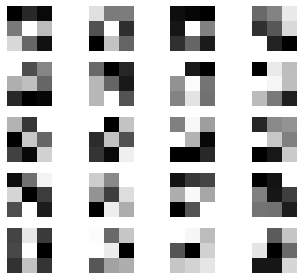

average of absolute gradients 1 tensor(4.8363e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5051e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7038e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5138e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7544e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4036e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4061e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9690e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6694e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6122e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4375e-06, device='cuda:0')


 87%|███████████████████████████████████████████████████████████████████▏         | 873/1000 [1:13:26<10:49,  5.11s/it]

Epoch: 873
Accuracy of train set: 27%
Accuracy of test set: 10%

tensor([[[-0.1950, -0.1306, -0.1794],
         [-0.0003,  0.2142,  0.1063],
         [ 0.1513, -0.0319, -0.1677]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


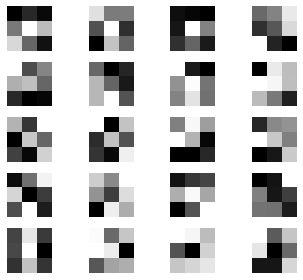

average of absolute gradients 1 tensor(6.1850e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4364e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5690e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6366e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9416e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7354e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4103e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1905e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5982e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4541e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.5973e-06, device='cuda:0')


 87%|███████████████████████████████████████████████████████████████████▎         | 874/1000 [1:13:31<10:50,  5.16s/it]

Epoch: 874
Accuracy of train set: 27%
Accuracy of test set: 10%

tensor([[[-1.9494e-01, -1.3067e-01, -1.7946e-01],
         [-1.8883e-05,  2.1421e-01,  1.0621e-01],
         [ 1.5112e-01, -3.1929e-02, -1.6774e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


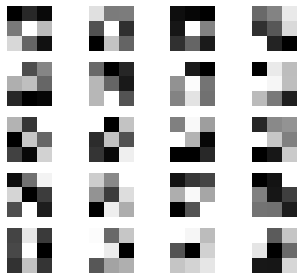

average of absolute gradients 1 tensor(5.0342e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6461e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5790e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0771e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6284e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0031e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6777e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8592e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2906e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1603e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.0110e-05, device='cuda:0')


 88%|███████████████████████████████████████████████████████████████████▍         | 875/1000 [1:13:37<10:54,  5.24s/it]

Epoch: 875
Accuracy of train set: 27%
Accuracy of test set: 10%

tensor([[[-1.9509e-01, -1.3088e-01, -1.7964e-01],
         [-9.9049e-05,  2.1409e-01,  1.0564e-01],
         [ 1.5105e-01, -3.1919e-02, -1.6771e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


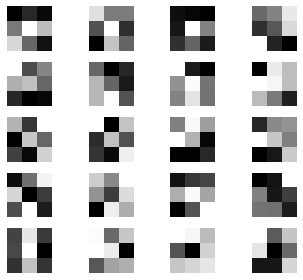

average of absolute gradients 1 tensor(6.1060e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1995e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8369e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4346e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5475e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6449e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3183e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4158e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5208e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6672e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.8456e-06, device='cuda:0')


 88%|███████████████████████████████████████████████████████████████████▍         | 876/1000 [1:13:42<10:43,  5.19s/it]

Epoch: 876
Accuracy of train set: 27%
Accuracy of test set: 10%

tensor([[[-1.9483e-01, -1.3076e-01, -1.7950e-01],
         [ 1.3314e-04,  2.1418e-01,  1.0586e-01],
         [ 1.5130e-01, -3.1942e-02, -1.6768e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


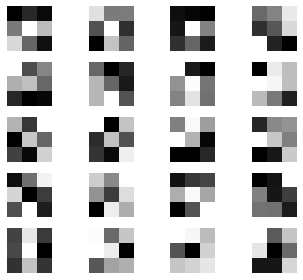

average of absolute gradients 1 tensor(6.0760e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4294e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4314e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8164e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9091e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.8025e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9258e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.3722e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8355e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5829e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3455e-06, device='cuda:0')


 88%|███████████████████████████████████████████████████████████████████▌         | 877/1000 [1:13:47<10:30,  5.13s/it]

Epoch: 877
Accuracy of train set: 27%
Accuracy of test set: 10%

tensor([[[-0.1950, -0.1308, -0.1795],
         [-0.0004,  0.2142,  0.1056],
         [ 0.1511, -0.0319, -0.1677]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


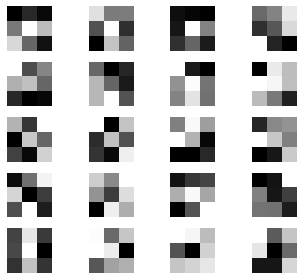

average of absolute gradients 1 tensor(4.9129e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2426e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6063e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0781e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0088e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7975e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9079e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7222e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2966e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2522e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2520e-06, device='cuda:0')


 88%|███████████████████████████████████████████████████████████████████▌         | 878/1000 [1:13:52<10:25,  5.13s/it]

Epoch: 878
Accuracy of train set: 27%
Accuracy of test set: 10%

tensor([[[-0.1948, -0.1307, -0.1795],
         [-0.0004,  0.2143,  0.1057],
         [ 0.1511, -0.0320, -0.1677]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


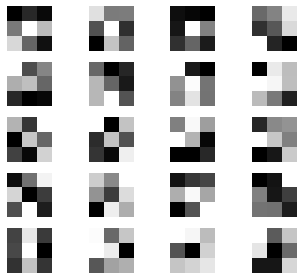

average of absolute gradients 1 tensor(5.3184e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0071e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9675e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1085e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3008e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9092e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7742e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1563e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7224e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8698e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9819e-06, device='cuda:0')


 88%|███████████████████████████████████████████████████████████████████▋         | 879/1000 [1:13:57<10:16,  5.09s/it]

Epoch: 879
Accuracy of train set: 27%
Accuracy of test set: 10%

tensor([[[-0.1948, -0.1308, -0.1795],
         [-0.0003,  0.2144,  0.1056],
         [ 0.1511, -0.0321, -0.1676]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


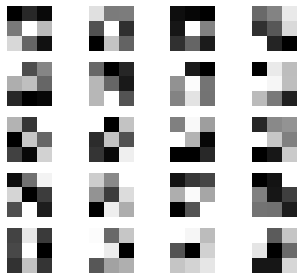

average of absolute gradients 1 tensor(5.6671e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7392e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8138e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0710e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6487e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6086e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7433e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0553e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2999e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7193e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8321e-06, device='cuda:0')


 88%|███████████████████████████████████████████████████████████████████▊         | 880/1000 [1:14:02<10:06,  5.05s/it]

Epoch: 880
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1948, -0.1308, -0.1794],
         [-0.0003,  0.2144,  0.1056],
         [ 0.1511, -0.0322, -0.1675]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


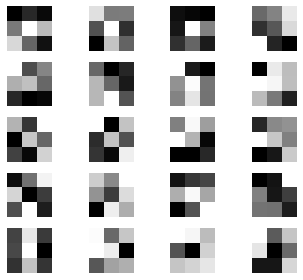

average of absolute gradients 1 tensor(5.5841e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1539e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1097e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9036e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7569e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4485e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6423e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0234e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3957e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4909e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6318e-06, device='cuda:0')


 88%|███████████████████████████████████████████████████████████████████▊         | 881/1000 [1:14:07<09:57,  5.02s/it]

Epoch: 881
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1949, -0.1308, -0.1795],
         [-0.0003,  0.2144,  0.1055],
         [ 0.1510, -0.0321, -0.1674]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


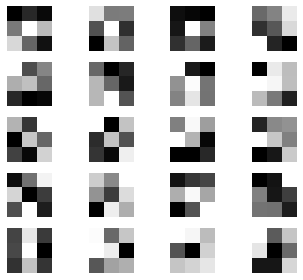

average of absolute gradients 1 tensor(4.7551e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6497e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2864e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0249e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7690e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7919e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.6461e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2396e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.4208e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9034e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0101e-06, device='cuda:0')


 88%|███████████████████████████████████████████████████████████████████▉         | 882/1000 [1:14:12<09:49,  4.99s/it]

Epoch: 882
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1948, -0.1309, -0.1795],
         [-0.0003,  0.2145,  0.1055],
         [ 0.1509, -0.0320, -0.1674]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


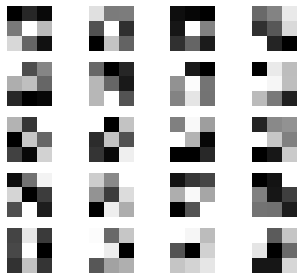

average of absolute gradients 1 tensor(5.1744e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7641e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8248e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7384e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8326e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.1053e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5141e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0090e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1518e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9528e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5394e-06, device='cuda:0')


 88%|███████████████████████████████████████████████████████████████████▉         | 883/1000 [1:14:17<09:42,  4.98s/it]

Epoch: 883
Accuracy of train set: 27%
Accuracy of test set: 10%

tensor([[[-0.1947, -0.1310, -0.1796],
         [-0.0004,  0.2144,  0.1054],
         [ 0.1509, -0.0322, -0.1674]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


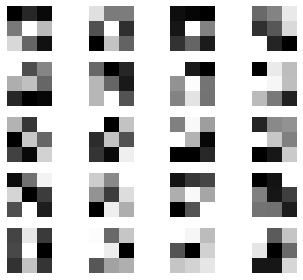

average of absolute gradients 1 tensor(4.6354e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4559e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7570e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4968e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8662e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7437e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5798e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3375e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9047e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3603e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0233e-06, device='cuda:0')


 88%|████████████████████████████████████████████████████████████████████         | 884/1000 [1:14:22<09:37,  4.98s/it]

Epoch: 884
Accuracy of train set: 27%
Accuracy of test set: 10%

tensor([[[-0.1946, -0.1310, -0.1794],
         [-0.0003,  0.2144,  0.1055],
         [ 0.1509, -0.0322, -0.1674]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


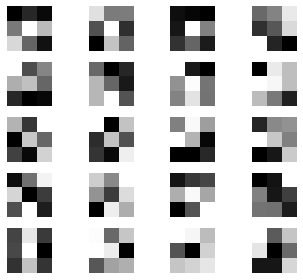

average of absolute gradients 1 tensor(4.8737e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4485e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6964e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0944e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7863e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5750e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.5312e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8900e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8823e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9385e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4123e-06, device='cuda:0')


 88%|████████████████████████████████████████████████████████████████████▏        | 885/1000 [1:14:27<09:30,  4.96s/it]

Epoch: 885
Accuracy of train set: 27%
Accuracy of test set: 10%

tensor([[[-1.9454e-01, -1.3097e-01, -1.7931e-01],
         [-1.6245e-04,  2.1453e-01,  1.0535e-01],
         [ 1.5106e-01, -3.2216e-02, -1.6741e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


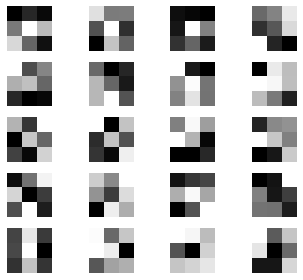

average of absolute gradients 1 tensor(4.6894e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9228e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0594e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1592e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6362e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3330e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5037e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1208e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8230e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9077e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3510e-06, device='cuda:0')


 89%|████████████████████████████████████████████████████████████████████▏        | 886/1000 [1:14:32<09:27,  4.98s/it]

Epoch: 886
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1946, -0.1311, -0.1793],
         [-0.0003,  0.2145,  0.1054],
         [ 0.1510, -0.0322, -0.1674]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


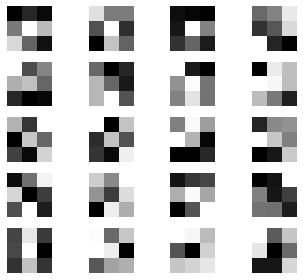

average of absolute gradients 1 tensor(4.6286e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5361e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8430e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6159e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4964e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7358e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5348e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8567e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4697e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7903e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7835e-06, device='cuda:0')


 89%|████████████████████████████████████████████████████████████████████▎        | 887/1000 [1:14:37<09:21,  4.97s/it]

Epoch: 887
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1946, -0.1311, -0.1793],
         [-0.0004,  0.2144,  0.1053],
         [ 0.1510, -0.0322, -0.1674]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


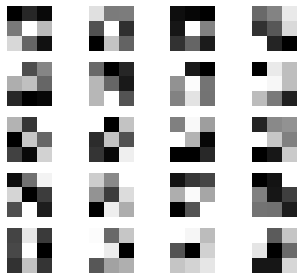

average of absolute gradients 1 tensor(4.7358e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5578e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0876e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0219e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9904e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6526e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9071e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7186e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1859e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9159e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1240e-06, device='cuda:0')


 89%|████████████████████████████████████████████████████████████████████▍        | 888/1000 [1:14:42<09:14,  4.95s/it]

Epoch: 888
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1945, -0.1310, -0.1793],
         [-0.0005,  0.2145,  0.1054],
         [ 0.1510, -0.0322, -0.1673]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


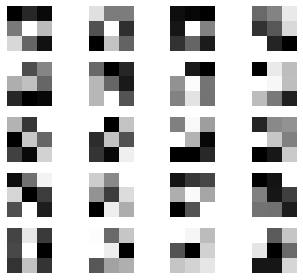

average of absolute gradients 1 tensor(5.1076e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9627e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7792e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5875e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8685e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6095e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5098e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7424e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7278e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4604e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8769e-06, device='cuda:0')


 89%|████████████████████████████████████████████████████████████████████▍        | 889/1000 [1:14:46<09:09,  4.95s/it]

Epoch: 889
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1945, -0.1308, -0.1793],
         [-0.0005,  0.2146,  0.1054],
         [ 0.1511, -0.0320, -0.1673]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


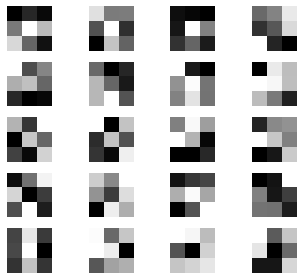

average of absolute gradients 1 tensor(6.2649e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0956e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5248e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3288e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9586e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5534e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4205e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7622e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9028e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8961e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.0598e-06, device='cuda:0')


 89%|████████████████████████████████████████████████████████████████████▌        | 890/1000 [1:14:51<09:03,  4.94s/it]

Epoch: 890
Accuracy of train set: 27%
Accuracy of test set: 10%

tensor([[[-0.1946, -0.1308, -0.1794],
         [-0.0005,  0.2144,  0.1054],
         [ 0.1508, -0.0322, -0.1673]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


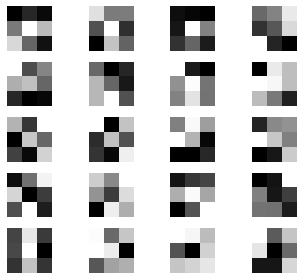

average of absolute gradients 1 tensor(5.4293e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5517e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3762e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6621e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2423e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7111e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6652e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4944e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1634e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7201e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6863e-06, device='cuda:0')


 89%|████████████████████████████████████████████████████████████████████▌        | 891/1000 [1:14:56<08:58,  4.94s/it]

Epoch: 891
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1945, -0.1308, -0.1794],
         [-0.0004,  0.2146,  0.1053],
         [ 0.1509, -0.0324, -0.1672]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


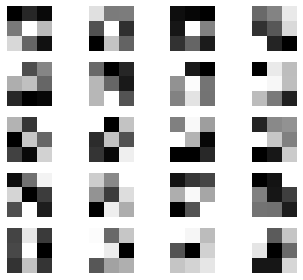

average of absolute gradients 1 tensor(4.5026e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9221e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8953e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6759e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1668e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7371e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0805e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1109e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7387e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3325e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7667e-06, device='cuda:0')


 89%|████████████████████████████████████████████████████████████████████▋        | 892/1000 [1:15:01<08:52,  4.93s/it]

Epoch: 892
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1943, -0.1308, -0.1793],
         [-0.0002,  0.2147,  0.1055],
         [ 0.1510, -0.0323, -0.1671]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


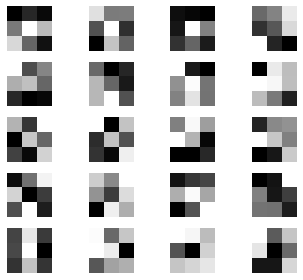

average of absolute gradients 1 tensor(4.1841e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9608e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9751e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2921e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0890e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0456e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4053e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2547e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4379e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9148e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.0366e-06, device='cuda:0')


 89%|████████████████████████████████████████████████████████████████████▊        | 893/1000 [1:15:06<08:46,  4.92s/it]

Epoch: 893
Accuracy of train set: 27%
Accuracy of test set: 10%

tensor([[[-0.1944, -0.1308, -0.1792],
         [-0.0004,  0.2147,  0.1053],
         [ 0.1511, -0.0322, -0.1672]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


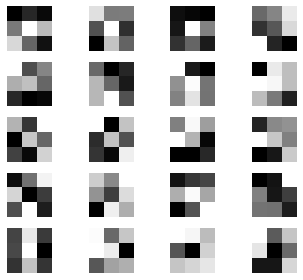

average of absolute gradients 1 tensor(4.7295e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4912e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2613e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6683e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4150e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6317e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.0648e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9939e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1665e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6307e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3474e-06, device='cuda:0')


 89%|████████████████████████████████████████████████████████████████████▊        | 894/1000 [1:15:11<08:42,  4.93s/it]

Epoch: 894
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9435e-01, -1.3076e-01, -1.7925e-01],
         [-2.0933e-04,  2.1457e-01,  1.0533e-01],
         [ 1.5119e-01, -3.2184e-02, -1.6708e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


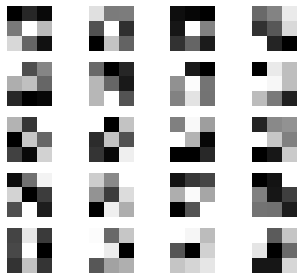

average of absolute gradients 1 tensor(4.9332e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3717e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5100e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0350e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2730e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0346e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8003e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4099e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1495e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0245e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1627e-06, device='cuda:0')


 90%|████████████████████████████████████████████████████████████████████▉        | 895/1000 [1:15:16<08:37,  4.93s/it]

Epoch: 895
Accuracy of train set: 27%
Accuracy of test set: 10%

tensor([[[-0.1943, -0.1308, -0.1793],
         [-0.0003,  0.2145,  0.1054],
         [ 0.1512, -0.0322, -0.1670]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


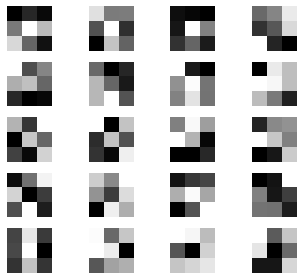

average of absolute gradients 1 tensor(5.7206e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4830e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7395e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5232e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4687e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3896e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9751e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0446e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5124e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8569e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8925e-06, device='cuda:0')


 90%|████████████████████████████████████████████████████████████████████▉        | 896/1000 [1:15:21<08:33,  4.93s/it]

Epoch: 896
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1942, -0.1308, -0.1793],
         [-0.0003,  0.2145,  0.1054],
         [ 0.1513, -0.0321, -0.1669]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


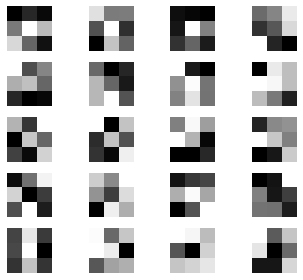

average of absolute gradients 1 tensor(4.9455e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6125e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0152e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8891e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5077e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3516e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2041e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7102e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8636e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2248e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1953e-06, device='cuda:0')


 90%|█████████████████████████████████████████████████████████████████████        | 897/1000 [1:15:26<08:28,  4.94s/it]

Epoch: 897
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1942, -0.1308, -0.1794],
         [-0.0003,  0.2146,  0.1054],
         [ 0.1511, -0.0320, -0.1669]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


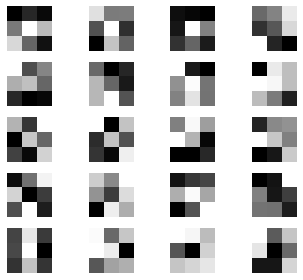

average of absolute gradients 1 tensor(4.5405e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4927e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4281e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3210e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9344e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1971e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9222e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0880e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8805e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3132e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3183e-06, device='cuda:0')


 90%|█████████████████████████████████████████████████████████████████████▏       | 898/1000 [1:15:31<08:24,  4.94s/it]

Epoch: 898
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1942, -0.1308, -0.1794],
         [-0.0003,  0.2146,  0.1055],
         [ 0.1510, -0.0320, -0.1669]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


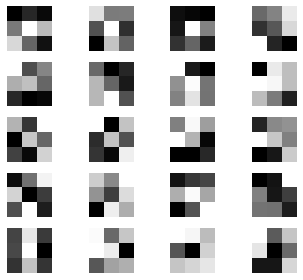

average of absolute gradients 1 tensor(5.1488e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5515e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2410e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4021e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7843e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4891e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2093e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0680e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6761e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2216e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.4595e-06, device='cuda:0')


 90%|█████████████████████████████████████████████████████████████████████▏       | 899/1000 [1:15:36<08:18,  4.94s/it]

Epoch: 899
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1941, -0.1308, -0.1794],
         [-0.0004,  0.2146,  0.1057],
         [ 0.1511, -0.0320, -0.1668]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


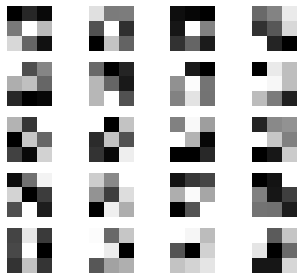

average of absolute gradients 1 tensor(4.7297e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9273e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3960e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7296e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0371e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0034e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9902e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3630e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3133e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8524e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9234e-06, device='cuda:0')


 90%|█████████████████████████████████████████████████████████████████████▎       | 900/1000 [1:15:41<08:12,  4.93s/it]

Epoch: 900
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1940, -0.1307, -0.1794],
         [-0.0004,  0.2146,  0.1058],
         [ 0.1510, -0.0320, -0.1668]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


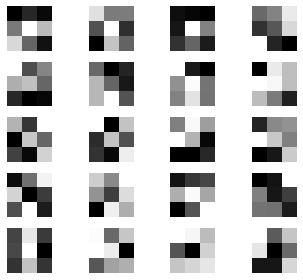

average of absolute gradients 1 tensor(5.7316e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5845e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6149e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2218e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4112e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5822e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0952e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0306e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8474e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0263e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7790e-06, device='cuda:0')


 90%|█████████████████████████████████████████████████████████████████████▍       | 901/1000 [1:15:46<08:08,  4.93s/it]

Epoch: 901
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1940, -0.1308, -0.1793],
         [-0.0003,  0.2147,  0.1056],
         [ 0.1512, -0.0319, -0.1667]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


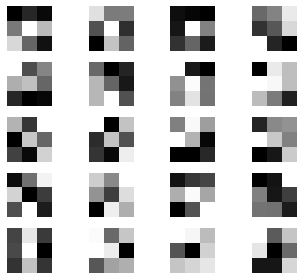

average of absolute gradients 1 tensor(5.3252e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1650e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7760e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2415e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5747e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9362e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5860e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4410e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4955e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3375e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3221e-06, device='cuda:0')


 90%|█████████████████████████████████████████████████████████████████████▍       | 902/1000 [1:15:51<08:03,  4.94s/it]

Epoch: 902
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1941, -0.1308, -0.1794],
         [-0.0005,  0.2146,  0.1056],
         [ 0.1511, -0.0319, -0.1667]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


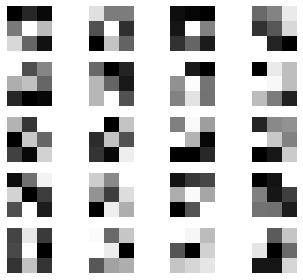

average of absolute gradients 1 tensor(3.7901e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0644e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9479e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9532e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9913e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9596e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8822e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4666e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3862e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7354e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6965e-06, device='cuda:0')


 90%|█████████████████████████████████████████████████████████████████████▌       | 903/1000 [1:15:56<07:58,  4.93s/it]

Epoch: 903
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1941, -0.1308, -0.1795],
         [-0.0004,  0.2146,  0.1055],
         [ 0.1509, -0.0319, -0.1668]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


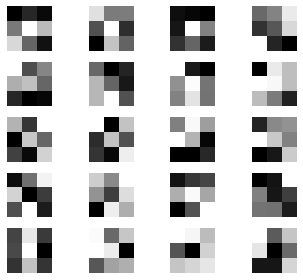

average of absolute gradients 1 tensor(5.1508e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5517e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6631e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6143e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4594e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1219e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4120e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5175e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6858e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9987e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4921e-06, device='cuda:0')


 90%|█████████████████████████████████████████████████████████████████████▌       | 904/1000 [1:16:00<07:53,  4.93s/it]

Epoch: 904
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1940, -0.1307, -0.1795],
         [-0.0004,  0.2146,  0.1055],
         [ 0.1510, -0.0317, -0.1667]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


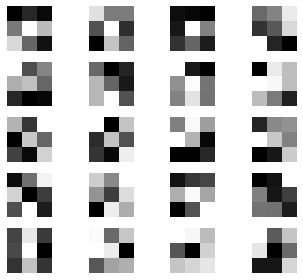

average of absolute gradients 1 tensor(5.6529e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8894e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9300e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5118e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7597e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4502e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0291e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1629e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8053e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3419e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1846e-06, device='cuda:0')


 90%|█████████████████████████████████████████████████████████████████████▋       | 905/1000 [1:16:05<07:47,  4.92s/it]

Epoch: 905
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1940, -0.1308, -0.1794],
         [-0.0003,  0.2145,  0.1055],
         [ 0.1510, -0.0318, -0.1667]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


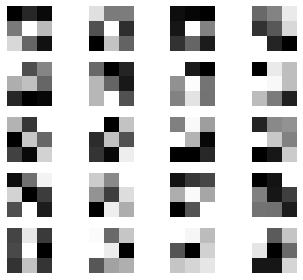

average of absolute gradients 1 tensor(4.1488e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2834e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3593e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6499e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5157e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8253e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7757e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0966e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3951e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4009e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.7128e-06, device='cuda:0')


 91%|█████████████████████████████████████████████████████████████████████▊       | 906/1000 [1:16:10<07:42,  4.92s/it]

Epoch: 906
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1939, -0.1309, -0.1794],
         [-0.0003,  0.2147,  0.1055],
         [ 0.1510, -0.0317, -0.1666]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


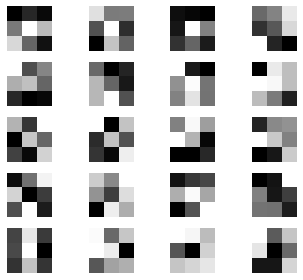

average of absolute gradients 1 tensor(5.6910e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0762e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2521e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4189e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5747e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5777e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9174e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8453e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6076e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8987e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3198e-06, device='cuda:0')


 91%|█████████████████████████████████████████████████████████████████████▊       | 907/1000 [1:16:15<07:37,  4.92s/it]

Epoch: 907
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1939, -0.1310, -0.1794],
         [-0.0003,  0.2148,  0.1055],
         [ 0.1508, -0.0317, -0.1666]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


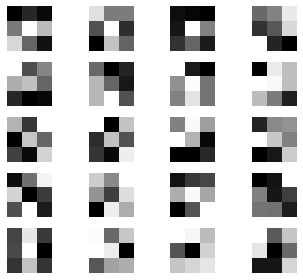

average of absolute gradients 1 tensor(4.7071e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6790e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3065e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1895e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3167e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7786e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1312e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6091e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6195e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7205e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4169e-06, device='cuda:0')


 91%|█████████████████████████████████████████████████████████████████████▉       | 908/1000 [1:16:20<07:32,  4.92s/it]

Epoch: 908
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9380e-01, -1.3098e-01, -1.7938e-01],
         [-2.0392e-04,  2.1477e-01,  1.0567e-01],
         [ 1.5078e-01, -3.1665e-02, -1.6652e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


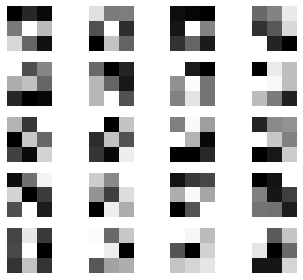

average of absolute gradients 1 tensor(4.8519e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7095e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3144e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2715e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6708e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8010e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4519e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7684e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5604e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0491e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3388e-06, device='cuda:0')


 91%|█████████████████████████████████████████████████████████████████████▉       | 909/1000 [1:16:25<07:27,  4.91s/it]

Epoch: 909
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9383e-01, -1.3110e-01, -1.7949e-01],
         [-1.8892e-04,  2.1469e-01,  1.0561e-01],
         [ 1.5057e-01, -3.1672e-02, -1.6657e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


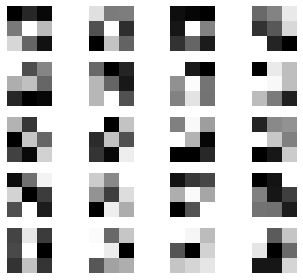

average of absolute gradients 1 tensor(6.1478e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8049e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5234e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9263e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5190e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8215e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8325e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1447e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5054e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3414e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.6050e-06, device='cuda:0')


 91%|██████████████████████████████████████████████████████████████████████       | 910/1000 [1:16:30<07:23,  4.93s/it]

Epoch: 910
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9369e-01, -1.3115e-01, -1.7938e-01],
         [ 1.3961e-05,  2.1479e-01,  1.0581e-01],
         [ 1.5056e-01, -3.1511e-02, -1.6654e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


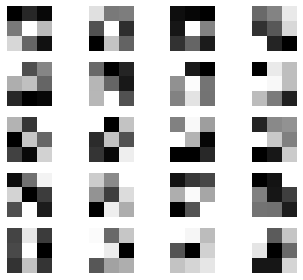

average of absolute gradients 1 tensor(5.0260e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9729e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8399e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7881e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3344e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3705e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9662e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8591e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7570e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3258e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9833e-06, device='cuda:0')


 91%|██████████████████████████████████████████████████████████████████████▏      | 911/1000 [1:16:35<07:19,  4.94s/it]

Epoch: 911
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9377e-01, -1.3127e-01, -1.7951e-01],
         [-1.3828e-04,  2.1467e-01,  1.0568e-01],
         [ 1.5032e-01, -3.1599e-02, -1.6657e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


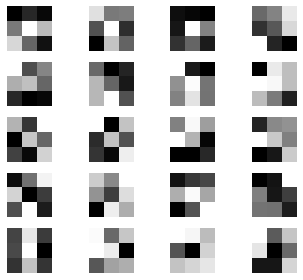

average of absolute gradients 1 tensor(4.3869e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6724e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9615e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9587e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0943e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6896e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9412e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2538e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4790e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8404e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1698e-06, device='cuda:0')


 91%|██████████████████████████████████████████████████████████████████████▏      | 912/1000 [1:16:40<07:14,  4.94s/it]

Epoch: 912
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9362e-01, -1.3106e-01, -1.7941e-01],
         [-5.2297e-05,  2.1497e-01,  1.0579e-01],
         [ 1.5036e-01, -3.1501e-02, -1.6650e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


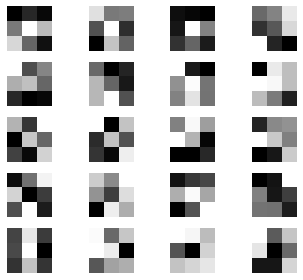

average of absolute gradients 1 tensor(4.1950e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7250e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8890e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2255e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5764e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2493e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0297e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2102e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9908e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5419e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6921e-06, device='cuda:0')


 91%|██████████████████████████████████████████████████████████████████████▎      | 913/1000 [1:16:45<07:10,  4.95s/it]

Epoch: 913
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9359e-01, -1.3116e-01, -1.7943e-01],
         [-1.1607e-04,  2.1486e-01,  1.0581e-01],
         [ 1.5031e-01, -3.1513e-02, -1.6655e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


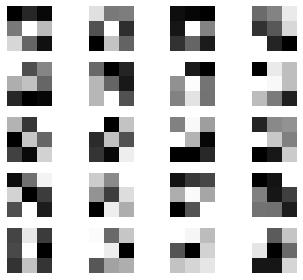

average of absolute gradients 1 tensor(5.6684e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6594e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8287e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1133e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8404e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1305e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6022e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2606e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5392e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9186e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3800e-06, device='cuda:0')


 91%|██████████████████████████████████████████████████████████████████████▍      | 914/1000 [1:16:50<07:03,  4.93s/it]

Epoch: 914
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9351e-01, -1.3114e-01, -1.7942e-01],
         [-9.6166e-05,  2.1483e-01,  1.0581e-01],
         [ 1.5039e-01, -3.1548e-02, -1.6656e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


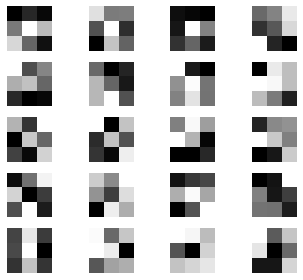

average of absolute gradients 1 tensor(5.2078e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6993e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8891e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3055e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4085e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5754e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5456e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6423e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3233e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7160e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7583e-06, device='cuda:0')


 92%|██████████████████████████████████████████████████████████████████████▍      | 915/1000 [1:16:55<06:59,  4.93s/it]

Epoch: 915
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9351e-01, -1.3119e-01, -1.7948e-01],
         [-1.9461e-04,  2.1465e-01,  1.0585e-01],
         [ 1.5045e-01, -3.1541e-02, -1.6656e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


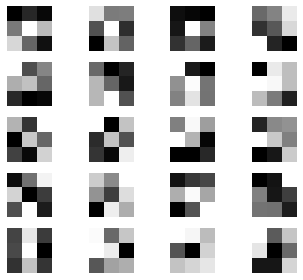

average of absolute gradients 1 tensor(4.3824e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0533e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0898e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3885e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2861e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7012e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6596e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3497e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1096e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2209e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.2820e-06, device='cuda:0')


 92%|██████████████████████████████████████████████████████████████████████▌      | 916/1000 [1:17:00<06:54,  4.93s/it]

Epoch: 916
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9343e-01, -1.3132e-01, -1.7949e-01],
         [-3.2714e-05,  2.1460e-01,  1.0598e-01],
         [ 1.5034e-01, -3.1610e-02, -1.6657e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


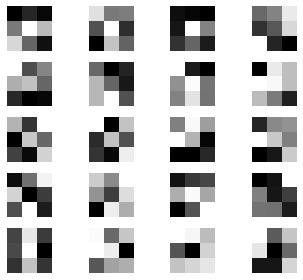

average of absolute gradients 1 tensor(5.5285e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5887e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2542e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5931e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3488e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5254e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2678e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3655e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7563e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3943e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0066e-06, device='cuda:0')


 92%|██████████████████████████████████████████████████████████████████████▌      | 917/1000 [1:17:05<06:48,  4.93s/it]

Epoch: 917
Accuracy of train set: 27%
Accuracy of test set: 10%

tensor([[[-1.9343e-01, -1.3123e-01, -1.7948e-01],
         [-1.2057e-04,  2.1464e-01,  1.0588e-01],
         [ 1.5044e-01, -3.1538e-02, -1.6652e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


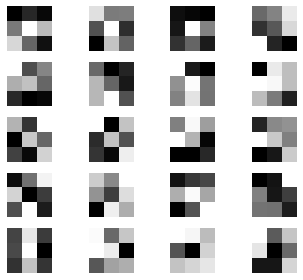

average of absolute gradients 1 tensor(5.0216e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0564e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1777e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8897e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2883e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8685e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7171e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1378e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2726e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1499e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1820e-06, device='cuda:0')


 92%|██████████████████████████████████████████████████████████████████████▋      | 918/1000 [1:17:09<06:43,  4.92s/it]

Epoch: 918
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9341e-01, -1.3129e-01, -1.7946e-01],
         [-1.8494e-04,  2.1461e-01,  1.0591e-01],
         [ 1.5042e-01, -3.1644e-02, -1.6648e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


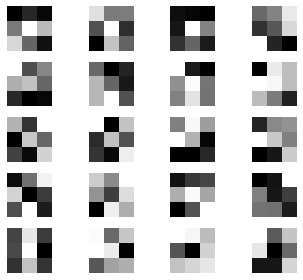

average of absolute gradients 1 tensor(5.4929e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5616e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5717e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5829e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2271e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7000e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1253e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3479e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1432e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2300e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4176e-06, device='cuda:0')


 92%|██████████████████████████████████████████████████████████████████████▊      | 919/1000 [1:17:14<06:37,  4.91s/it]

Epoch: 919
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9342e-01, -1.3123e-01, -1.7949e-01],
         [-1.4580e-04,  2.1470e-01,  1.0581e-01],
         [ 1.5038e-01, -3.1630e-02, -1.6643e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


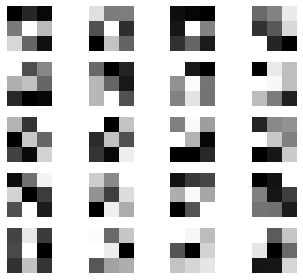

average of absolute gradients 1 tensor(4.7833e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7364e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5223e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3813e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4496e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5870e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6205e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4304e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5597e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6599e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1244e-06, device='cuda:0')


 92%|██████████████████████████████████████████████████████████████████████▊      | 920/1000 [1:17:19<06:32,  4.91s/it]

Epoch: 920
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9337e-01, -1.3120e-01, -1.7952e-01],
         [-1.6198e-04,  2.1467e-01,  1.0577e-01],
         [ 1.5043e-01, -3.1595e-02, -1.6644e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


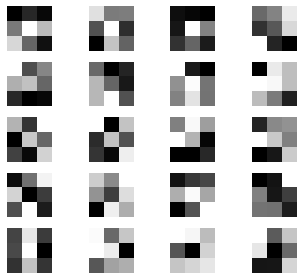

average of absolute gradients 1 tensor(5.4885e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2613e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2020e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3895e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1924e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8882e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4709e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1619e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9409e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1816e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8914e-06, device='cuda:0')


 92%|██████████████████████████████████████████████████████████████████████▉      | 921/1000 [1:17:24<06:28,  4.92s/it]

Epoch: 921
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9332e-01, -1.3111e-01, -1.7940e-01],
         [-1.7383e-04,  2.1486e-01,  1.0583e-01],
         [ 1.5046e-01, -3.1558e-02, -1.6635e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


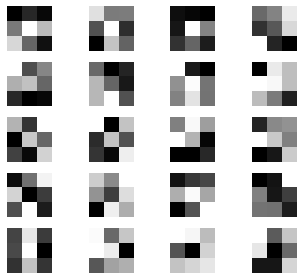

average of absolute gradients 1 tensor(4.9759e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7584e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3512e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2208e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2624e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2807e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2637e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6881e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2989e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8923e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0825e-06, device='cuda:0')


 92%|██████████████████████████████████████████████████████████████████████▉      | 922/1000 [1:17:29<06:24,  4.92s/it]

Epoch: 922
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1794],
         [-0.0003,  0.2149,  0.1058],
         [ 0.1505, -0.0315, -0.1663]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


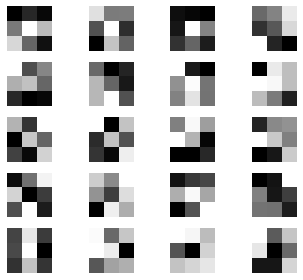

average of absolute gradients 1 tensor(4.6705e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2703e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5388e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8525e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5764e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4773e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4022e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7502e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2676e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3872e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9105e-06, device='cuda:0')


 92%|███████████████████████████████████████████████████████████████████████      | 923/1000 [1:17:34<06:21,  4.95s/it]

Epoch: 923
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1794],
         [-0.0003,  0.2149,  0.1058],
         [ 0.1505, -0.0317, -0.1663]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


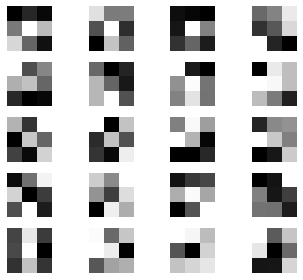

average of absolute gradients 1 tensor(4.6272e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1671e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6048e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7908e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6371e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8805e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0795e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8411e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6148e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0886e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0606e-06, device='cuda:0')


 92%|███████████████████████████████████████████████████████████████████████▏     | 924/1000 [1:17:39<06:15,  4.94s/it]

Epoch: 924
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1794],
         [-0.0003,  0.2149,  0.1058],
         [ 0.1505, -0.0316, -0.1662]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


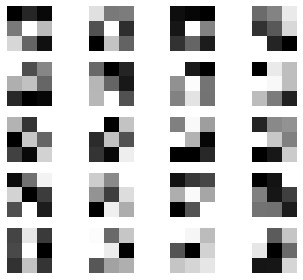

average of absolute gradients 1 tensor(5.2771e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5318e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4808e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6089e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5859e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9162e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6833e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2422e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7541e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3695e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8577e-06, device='cuda:0')


 92%|███████████████████████████████████████████████████████████████████████▏     | 925/1000 [1:17:44<06:10,  4.94s/it]

Epoch: 925
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1794],
         [-0.0002,  0.2149,  0.1057],
         [ 0.1504, -0.0316, -0.1662]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


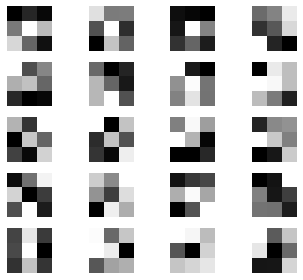

average of absolute gradients 1 tensor(4.6499e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0572e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5160e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0969e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9740e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1791e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0807e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3975e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0881e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3405e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8140e-06, device='cuda:0')


 93%|███████████████████████████████████████████████████████████████████████▎     | 926/1000 [1:17:49<06:05,  4.93s/it]

Epoch: 926
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1312, -0.1795],
         [-0.0003,  0.2149,  0.1056],
         [ 0.1503, -0.0316, -0.1662]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


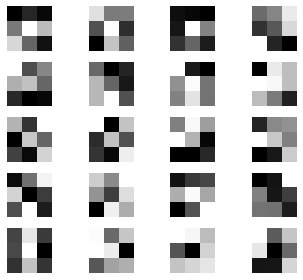

average of absolute gradients 1 tensor(4.6457e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1520e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1108e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3274e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0067e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0057e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4907e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7710e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6734e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2104e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.6698e-06, device='cuda:0')


 93%|███████████████████████████████████████████████████████████████████████▍     | 927/1000 [1:17:54<05:59,  4.93s/it]

Epoch: 927
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1795],
         [-0.0003,  0.2150,  0.1056],
         [ 0.1503, -0.0315, -0.1661]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


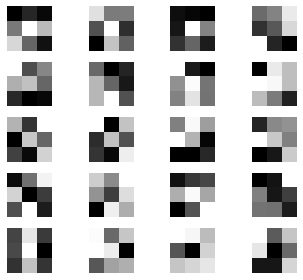

average of absolute gradients 1 tensor(5.4105e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4469e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0156e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0001e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8001e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4240e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3200e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1541e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6463e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5583e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6812e-06, device='cuda:0')


 93%|███████████████████████████████████████████████████████████████████████▍     | 928/1000 [1:17:59<05:54,  4.92s/it]

Epoch: 928
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1795],
         [-0.0003,  0.2150,  0.1056],
         [ 0.1503, -0.0315, -0.1661]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


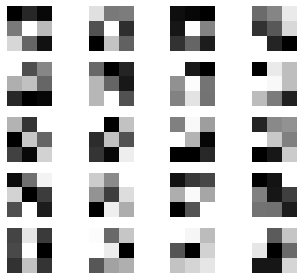

average of absolute gradients 1 tensor(4.1481e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9961e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8056e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0337e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9848e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2085e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1208e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8808e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0025e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7867e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.8623e-06, device='cuda:0')


 93%|███████████████████████████████████████████████████████████████████████▌     | 929/1000 [1:18:04<05:50,  4.93s/it]

Epoch: 929
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1795],
         [-0.0004,  0.2149,  0.1056],
         [ 0.1504, -0.0315, -0.1660]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


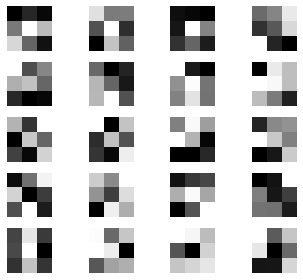

average of absolute gradients 1 tensor(5.2341e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6747e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4933e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8739e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5466e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6556e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6082e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6278e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6185e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6984e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6209e-06, device='cuda:0')


 93%|███████████████████████████████████████████████████████████████████████▌     | 930/1000 [1:18:09<05:44,  4.93s/it]

Epoch: 930
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1932, -0.1311, -0.1795],
         [-0.0003,  0.2150,  0.1057],
         [ 0.1504, -0.0315, -0.1659]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


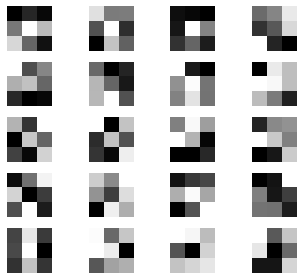

average of absolute gradients 1 tensor(4.3647e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2935e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8762e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9786e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6455e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4591e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3580e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7938e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7271e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7168e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4775e-06, device='cuda:0')


 93%|███████████████████████████████████████████████████████████████████████▋     | 931/1000 [1:18:14<05:41,  4.95s/it]

Epoch: 931
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1932, -0.1310, -0.1795],
         [-0.0004,  0.2150,  0.1056],
         [ 0.1505, -0.0316, -0.1659]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


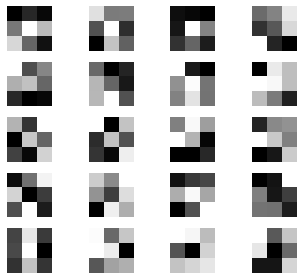

average of absolute gradients 1 tensor(4.2000e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5137e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9755e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1180e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4255e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5491e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0664e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.0766e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7857e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4781e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6497e-06, device='cuda:0')


 93%|███████████████████████████████████████████████████████████████████████▊     | 932/1000 [1:18:18<05:36,  4.94s/it]

Epoch: 932
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1932, -0.1311, -0.1794],
         [-0.0004,  0.2150,  0.1056],
         [ 0.1506, -0.0316, -0.1658]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


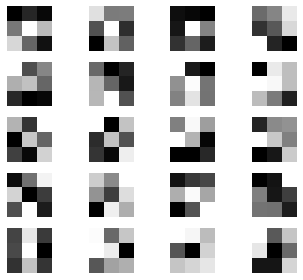

average of absolute gradients 1 tensor(4.8307e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8368e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9877e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4158e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0250e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4291e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2559e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8528e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8037e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4325e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1763e-06, device='cuda:0')


 93%|███████████████████████████████████████████████████████████████████████▊     | 933/1000 [1:18:23<05:31,  4.95s/it]

Epoch: 933
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1932, -0.1311, -0.1794],
         [-0.0004,  0.2150,  0.1055],
         [ 0.1506, -0.0316, -0.1658]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


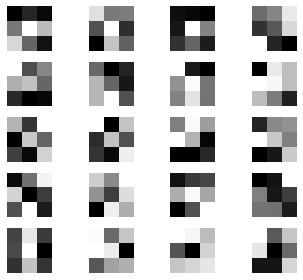

average of absolute gradients 1 tensor(5.1357e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2918e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3049e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3021e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2346e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2180e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1237e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8734e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4753e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0618e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2635e-06, device='cuda:0')


 93%|███████████████████████████████████████████████████████████████████████▉     | 934/1000 [1:18:28<05:26,  4.95s/it]

Epoch: 934
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1932, -0.1311, -0.1794],
         [-0.0004,  0.2150,  0.1055],
         [ 0.1507, -0.0316, -0.1657]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


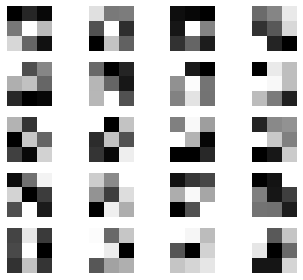

average of absolute gradients 1 tensor(4.7807e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0269e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6240e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0091e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7714e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8631e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4151e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0837e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4308e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7827e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.3495e-06, device='cuda:0')


 94%|███████████████████████████████████████████████████████████████████████▉     | 935/1000 [1:18:33<05:24,  4.98s/it]

Epoch: 935
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1932, -0.1311, -0.1794],
         [-0.0004,  0.2150,  0.1055],
         [ 0.1506, -0.0316, -0.1657]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


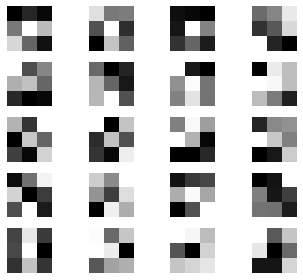

average of absolute gradients 1 tensor(5.8479e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9319e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7865e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2131e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1394e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3531e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2182e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5477e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7827e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3612e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2664e-06, device='cuda:0')


 94%|████████████████████████████████████████████████████████████████████████     | 936/1000 [1:18:38<05:17,  4.96s/it]

Epoch: 936
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1310, -0.1794],
         [-0.0004,  0.2151,  0.1055],
         [ 0.1506, -0.0316, -0.1656]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


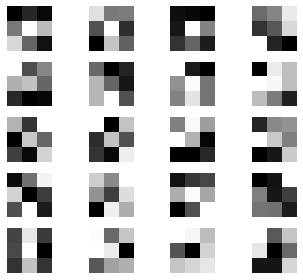

average of absolute gradients 1 tensor(4.1907e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8818e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9314e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4547e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7310e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3189e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1700e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8401e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7364e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8248e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3441e-06, device='cuda:0')


 94%|████████████████████████████████████████████████████████████████████████▏    | 937/1000 [1:18:43<05:12,  4.95s/it]

Epoch: 937
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1310, -0.1794],
         [-0.0005,  0.2151,  0.1054],
         [ 0.1505, -0.0316, -0.1656]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


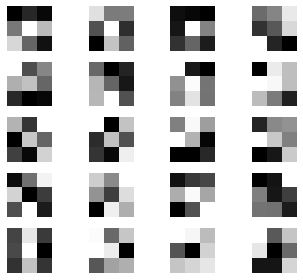

average of absolute gradients 1 tensor(4.5608e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7136e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4011e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9723e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5740e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0460e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4001e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9968e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2622e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5370e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7838e-06, device='cuda:0')


 94%|████████████████████████████████████████████████████████████████████████▏    | 938/1000 [1:18:48<05:06,  4.95s/it]

Epoch: 938
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1932, -0.1310, -0.1794],
         [-0.0005,  0.2152,  0.1054],
         [ 0.1506, -0.0316, -0.1656]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


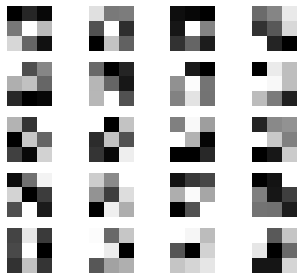

average of absolute gradients 1 tensor(4.7994e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5268e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0832e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5137e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2818e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1580e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7862e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2113e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0155e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4181e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9907e-06, device='cuda:0')


 94%|████████████████████████████████████████████████████████████████████████▎    | 939/1000 [1:18:53<05:02,  4.95s/it]

Epoch: 939
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1794],
         [-0.0004,  0.2152,  0.1053],
         [ 0.1505, -0.0316, -0.1655]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


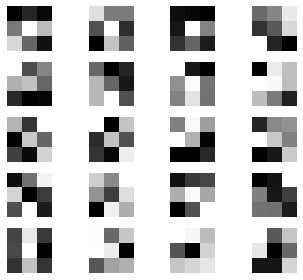

average of absolute gradients 1 tensor(5.6175e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8831e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7623e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0065e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5180e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3957e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2828e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7717e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5579e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2459e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1794e-06, device='cuda:0')


 94%|████████████████████████████████████████████████████████████████████████▍    | 940/1000 [1:18:58<04:55,  4.93s/it]

Epoch: 940
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1310, -0.1794],
         [-0.0004,  0.2151,  0.1053],
         [ 0.1506, -0.0316, -0.1655]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


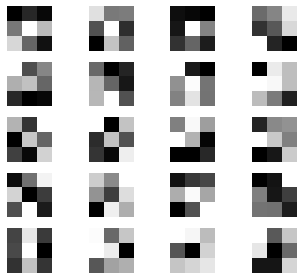

average of absolute gradients 1 tensor(5.3571e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2031e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3196e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6064e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6853e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0905e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2254e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2449e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9361e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2259e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3651e-06, device='cuda:0')


 94%|████████████████████████████████████████████████████████████████████████▍    | 941/1000 [1:19:03<04:51,  4.93s/it]

Epoch: 941
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1932, -0.1310, -0.1794],
         [-0.0004,  0.2151,  0.1053],
         [ 0.1506, -0.0316, -0.1655]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


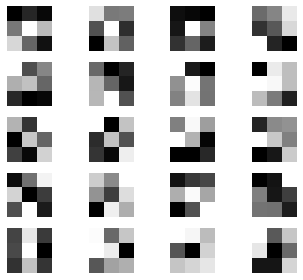

average of absolute gradients 1 tensor(6.7367e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2108e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2738e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4466e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8368e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9032e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8928e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9124e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2920e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0739e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.7400e-06, device='cuda:0')


 94%|████████████████████████████████████████████████████████████████████████▌    | 942/1000 [1:19:08<04:46,  4.93s/it]

Epoch: 942
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1794],
         [-0.0003,  0.2151,  0.1053],
         [ 0.1506, -0.0315, -0.1654]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


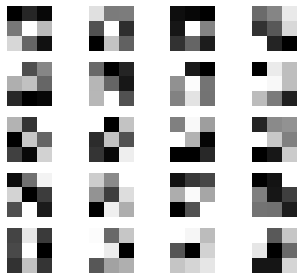

average of absolute gradients 1 tensor(5.4158e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0543e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3781e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9265e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9458e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3163e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7378e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9001e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4783e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3971e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2728e-06, device='cuda:0')


 94%|████████████████████████████████████████████████████████████████████████▌    | 943/1000 [1:19:13<04:40,  4.93s/it]

Epoch: 943
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1932, -0.1311, -0.1794],
         [-0.0004,  0.2152,  0.1053],
         [ 0.1505, -0.0315, -0.1654]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


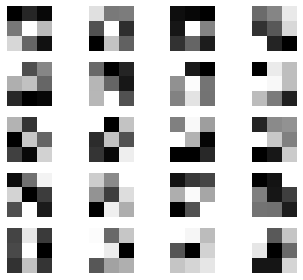

average of absolute gradients 1 tensor(4.0999e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9614e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5206e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9855e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5360e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2276e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7418e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5270e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6785e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0480e-07, device='cuda:0')
average of absolute gradients 1 tensor(9.6203e-06, device='cuda:0')


 94%|████████████████████████████████████████████████████████████████████████▋    | 944/1000 [1:19:18<04:35,  4.92s/it]

Epoch: 944
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1794],
         [-0.0004,  0.2153,  0.1052],
         [ 0.1506, -0.0314, -0.1653]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


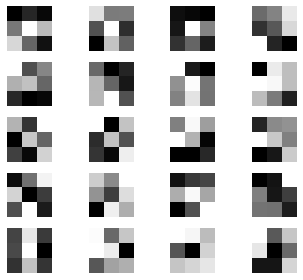

average of absolute gradients 1 tensor(4.5101e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3061e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1752e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5007e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0392e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0088e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0725e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7295e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4930e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6240e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1960e-06, device='cuda:0')


 94%|████████████████████████████████████████████████████████████████████████▊    | 945/1000 [1:19:23<04:31,  4.93s/it]

Epoch: 945
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1794],
         [-0.0005,  0.2152,  0.1052],
         [ 0.1506, -0.0314, -0.1653]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


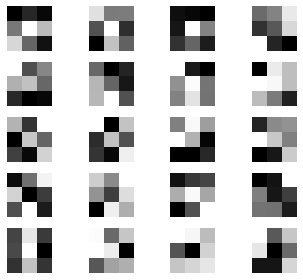

average of absolute gradients 1 tensor(5.1641e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8611e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1701e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9294e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2762e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2427e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8247e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5055e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6159e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1338e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3920e-06, device='cuda:0')


 95%|████████████████████████████████████████████████████████████████████████▊    | 946/1000 [1:19:28<04:26,  4.94s/it]

Epoch: 946
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1934, -0.1311, -0.1794],
         [-0.0004,  0.2151,  0.1052],
         [ 0.1505, -0.0314, -0.1652]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


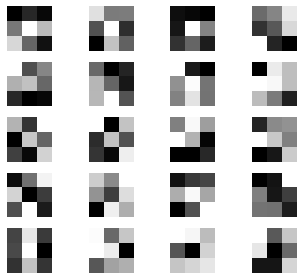

average of absolute gradients 1 tensor(4.7242e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9508e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3286e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9289e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4914e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1695e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7108e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9591e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1991e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7565e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9188e-06, device='cuda:0')


 95%|████████████████████████████████████████████████████████████████████████▉    | 947/1000 [1:19:33<04:22,  4.95s/it]

Epoch: 947
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1310, -0.1794],
         [-0.0004,  0.2152,  0.1053],
         [ 0.1506, -0.0314, -0.1652]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


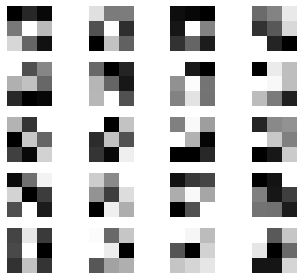

average of absolute gradients 1 tensor(3.8385e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7853e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5894e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0763e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1011e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7899e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6895e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5155e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8597e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0874e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2343e-06, device='cuda:0')


 95%|████████████████████████████████████████████████████████████████████████▉    | 948/1000 [1:19:38<04:17,  4.95s/it]

Epoch: 948
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1310, -0.1794],
         [-0.0004,  0.2152,  0.1053],
         [ 0.1505, -0.0314, -0.1652]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


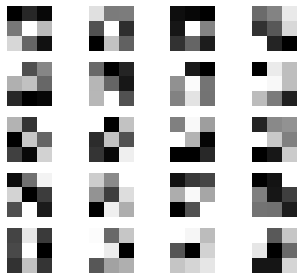

average of absolute gradients 1 tensor(5.5058e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1584e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0149e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4964e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3713e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8296e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5640e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3244e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5186e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8434e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4296e-06, device='cuda:0')


 95%|█████████████████████████████████████████████████████████████████████████    | 949/1000 [1:19:43<04:12,  4.95s/it]

Epoch: 949
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1794],
         [-0.0003,  0.2151,  0.1053],
         [ 0.1505, -0.0314, -0.1652]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


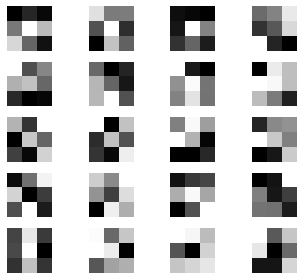

average of absolute gradients 1 tensor(4.2659e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9712e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1057e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2044e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0866e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6903e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4456e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5382e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8763e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1867e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4754e-06, device='cuda:0')


 95%|█████████████████████████████████████████████████████████████████████████▏   | 950/1000 [1:19:48<04:07,  4.94s/it]

Epoch: 950
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1794],
         [-0.0004,  0.2151,  0.1053],
         [ 0.1505, -0.0314, -0.1652]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


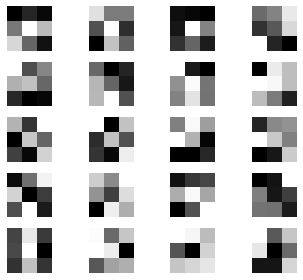

average of absolute gradients 1 tensor(4.4293e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2168e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5627e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0966e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3125e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8143e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4388e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3043e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1649e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4031e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.4003e-06, device='cuda:0')


 95%|█████████████████████████████████████████████████████████████████████████▏   | 951/1000 [1:19:52<04:01,  4.94s/it]

Epoch: 951
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1794],
         [-0.0004,  0.2151,  0.1053],
         [ 0.1506, -0.0314, -0.1651]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


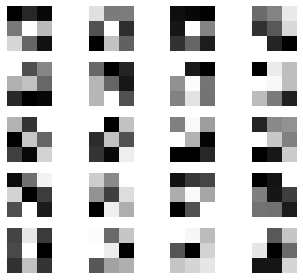

average of absolute gradients 1 tensor(5.9156e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7024e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0457e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0938e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5531e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2803e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3028e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3015e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8495e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5319e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.9588e-06, device='cuda:0')


 95%|█████████████████████████████████████████████████████████████████████████▎   | 952/1000 [1:19:57<03:56,  4.93s/it]

Epoch: 952
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1794],
         [-0.0004,  0.2151,  0.1053],
         [ 0.1506, -0.0314, -0.1651]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


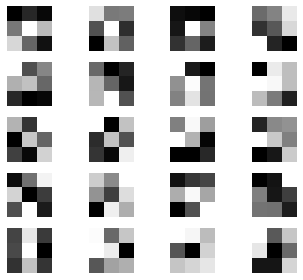

average of absolute gradients 1 tensor(4.6664e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3862e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0711e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1095e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9219e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4918e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4113e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6820e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4642e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9562e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7757e-06, device='cuda:0')


 95%|█████████████████████████████████████████████████████████████████████████▍   | 953/1000 [1:20:02<03:51,  4.93s/it]

Epoch: 953
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1794],
         [-0.0004,  0.2152,  0.1053],
         [ 0.1506, -0.0314, -0.1650]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


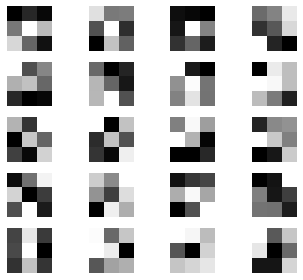

average of absolute gradients 1 tensor(4.8754e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6634e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1032e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2998e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1365e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5253e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8854e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6425e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9668e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1410e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6529e-06, device='cuda:0')


 95%|█████████████████████████████████████████████████████████████████████████▍   | 954/1000 [1:20:07<03:47,  4.94s/it]

Epoch: 954
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1794],
         [-0.0004,  0.2152,  0.1053],
         [ 0.1505, -0.0314, -0.1650]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


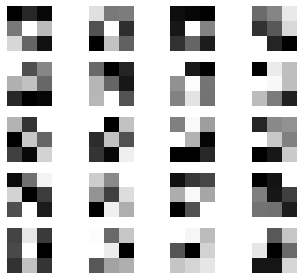

average of absolute gradients 1 tensor(4.4307e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9136e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7927e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0776e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6603e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9837e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1765e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6300e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5483e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8833e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4086e-06, device='cuda:0')


 96%|█████████████████████████████████████████████████████████████████████████▌   | 955/1000 [1:20:12<03:42,  4.93s/it]

Epoch: 955
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1793],
         [-0.0004,  0.2152,  0.1053],
         [ 0.1505, -0.0315, -0.1650]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


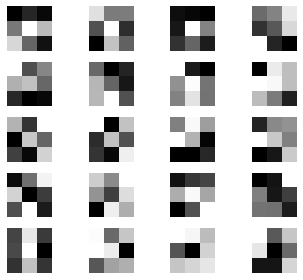

average of absolute gradients 1 tensor(5.6316e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1497e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9331e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6349e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2741e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6597e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3861e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2081e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0250e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5081e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1625e-06, device='cuda:0')


 96%|█████████████████████████████████████████████████████████████████████████▌   | 956/1000 [1:20:17<03:37,  4.93s/it]

Epoch: 956
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1793],
         [-0.0004,  0.2151,  0.1053],
         [ 0.1505, -0.0314, -0.1650]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


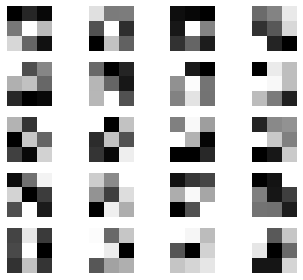

average of absolute gradients 1 tensor(4.6172e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2868e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7451e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4973e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9320e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2450e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5545e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0851e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1605e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2823e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3353e-06, device='cuda:0')


 96%|█████████████████████████████████████████████████████████████████████████▋   | 957/1000 [1:20:22<03:32,  4.94s/it]

Epoch: 957
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1793],
         [-0.0004,  0.2152,  0.1053],
         [ 0.1505, -0.0315, -0.1649]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


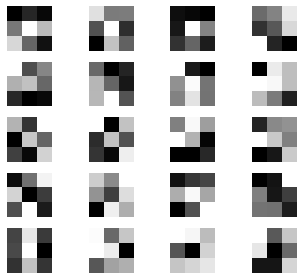

average of absolute gradients 1 tensor(4.7010e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9111e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2628e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6460e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0208e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1815e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5408e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7899e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9128e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0273e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3177e-06, device='cuda:0')


 96%|█████████████████████████████████████████████████████████████████████████▊   | 958/1000 [1:20:27<03:27,  4.94s/it]

Epoch: 958
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1793],
         [-0.0004,  0.2152,  0.1053],
         [ 0.1505, -0.0314, -0.1649]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


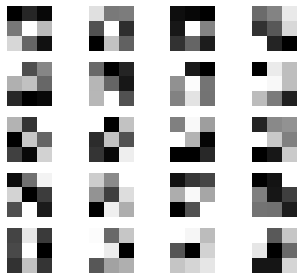

average of absolute gradients 1 tensor(4.8842e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5655e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6568e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0899e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0017e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3492e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5863e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9755e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1240e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0080e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1431e-06, device='cuda:0')


 96%|█████████████████████████████████████████████████████████████████████████▊   | 959/1000 [1:20:32<03:23,  4.96s/it]

Epoch: 959
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1793],
         [-0.0004,  0.2152,  0.1052],
         [ 0.1506, -0.0314, -0.1649]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


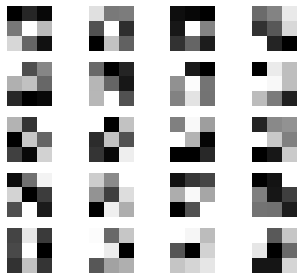

average of absolute gradients 1 tensor(5.5937e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5945e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6803e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7042e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4289e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5155e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8274e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0294e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0865e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1013e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.6449e-06, device='cuda:0')


 96%|█████████████████████████████████████████████████████████████████████████▉   | 960/1000 [1:20:37<03:18,  4.95s/it]

Epoch: 960
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1793],
         [-0.0003,  0.2152,  0.1052],
         [ 0.1506, -0.0314, -0.1649]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


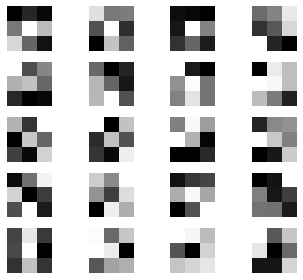

average of absolute gradients 1 tensor(4.3204e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3282e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6111e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7969e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0847e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4938e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8305e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0541e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6339e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7865e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.3712e-06, device='cuda:0')


 96%|█████████████████████████████████████████████████████████████████████████▉   | 961/1000 [1:20:42<03:13,  4.95s/it]

Epoch: 961
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1793],
         [-0.0003,  0.2152,  0.1052],
         [ 0.1506, -0.0314, -0.1649]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


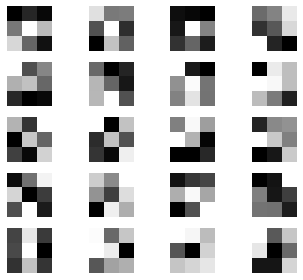

average of absolute gradients 1 tensor(4.5284e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1172e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5742e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9930e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0069e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3314e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0809e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.6659e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5385e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2918e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3928e-06, device='cuda:0')


 96%|██████████████████████████████████████████████████████████████████████████   | 962/1000 [1:20:47<03:08,  4.95s/it]

Epoch: 962
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1933, -0.1311, -0.1793],
         [-0.0003,  0.2151,  0.1052],
         [ 0.1505, -0.0314, -0.1649]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


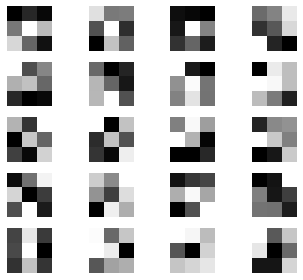

average of absolute gradients 1 tensor(4.4087e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9256e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0927e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9445e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0649e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6168e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4964e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9723e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2764e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0660e-07, device='cuda:0')
average of absolute gradients 1 tensor(1.3864e-05, device='cuda:0')


 96%|██████████████████████████████████████████████████████████████████████████▏  | 963/1000 [1:20:52<03:02,  4.94s/it]

Epoch: 963
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9335e-01, -1.3109e-01, -1.7924e-01],
         [-1.9077e-04,  2.1513e-01,  1.0525e-01],
         [ 1.5059e-01, -3.1438e-02, -1.6486e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


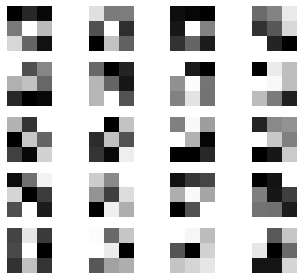

average of absolute gradients 1 tensor(5.3691e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8082e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0481e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3360e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5478e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7885e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0563e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9488e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3575e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1793e-07, device='cuda:0')
average of absolute gradients 1 tensor(7.4067e-06, device='cuda:0')


 96%|██████████████████████████████████████████████████████████████████████████▏  | 964/1000 [1:20:57<02:57,  4.94s/it]

Epoch: 964
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9338e-01, -1.3115e-01, -1.7927e-01],
         [-1.9822e-04,  2.1503e-01,  1.0525e-01],
         [ 1.5053e-01, -3.1468e-02, -1.6489e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


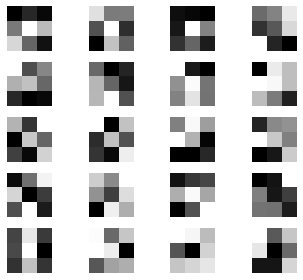

average of absolute gradients 1 tensor(4.5631e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6928e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4037e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8354e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5515e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2395e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5693e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5724e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7744e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7674e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2717e-06, device='cuda:0')


 96%|██████████████████████████████████████████████████████████████████████████▎  | 965/1000 [1:21:02<02:52,  4.94s/it]

Epoch: 965
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9336e-01, -1.3111e-01, -1.7924e-01],
         [-1.8254e-04,  2.1506e-01,  1.0525e-01],
         [ 1.5060e-01, -3.1445e-02, -1.6488e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


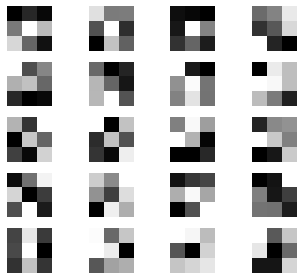

average of absolute gradients 1 tensor(3.7645e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1455e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8281e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0889e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7917e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8748e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8848e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3202e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0901e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7081e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7380e-06, device='cuda:0')


 97%|██████████████████████████████████████████████████████████████████████████▍  | 966/1000 [1:21:07<02:47,  4.92s/it]

Epoch: 966
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1934, -0.1312, -0.1793],
         [-0.0002,  0.2150,  0.1052],
         [ 0.1506, -0.0315, -0.1649]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


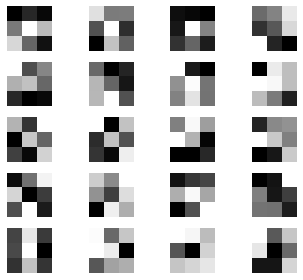

average of absolute gradients 1 tensor(4.8539e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8755e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7976e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7024e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9905e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7268e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7230e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2332e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5575e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6636e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7928e-06, device='cuda:0')


 97%|██████████████████████████████████████████████████████████████████████████▍  | 967/1000 [1:21:11<02:42,  4.92s/it]

Epoch: 967
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1934, -0.1312, -0.1793],
         [-0.0003,  0.2150,  0.1051],
         [ 0.1505, -0.0315, -0.1649]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


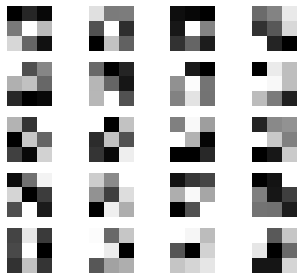

average of absolute gradients 1 tensor(4.7912e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7308e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6925e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4343e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3660e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7812e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1629e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8648e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9858e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5799e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2889e-06, device='cuda:0')


 97%|██████████████████████████████████████████████████████████████████████████▌  | 968/1000 [1:21:16<02:37,  4.92s/it]

Epoch: 968
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1934, -0.1313, -0.1793],
         [-0.0002,  0.2150,  0.1052],
         [ 0.1505, -0.0315, -0.1649]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


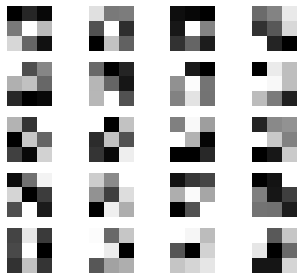

average of absolute gradients 1 tensor(5.3066e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2156e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4418e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5021e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0593e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1523e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1738e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2909e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7194e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7968e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4748e-06, device='cuda:0')


 97%|██████████████████████████████████████████████████████████████████████████▌  | 969/1000 [1:21:21<02:32,  4.92s/it]

Epoch: 969
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-0.1934, -0.1313, -0.1793],
         [-0.0002,  0.2150,  0.1052],
         [ 0.1505, -0.0315, -0.1648]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


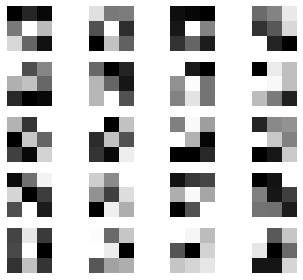

average of absolute gradients 1 tensor(4.3873e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0828e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7964e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9667e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5048e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0848e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0834e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8642e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3280e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3661e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.4012e-06, device='cuda:0')


 97%|██████████████████████████████████████████████████████████████████████████▋  | 970/1000 [1:21:26<02:27,  4.92s/it]

Epoch: 970
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9341e-01, -1.3130e-01, -1.7925e-01],
         [-2.0543e-04,  2.1497e-01,  1.0515e-01],
         [ 1.5047e-01, -3.1493e-02, -1.6484e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


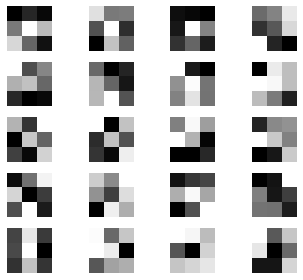

average of absolute gradients 1 tensor(5.3072e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3627e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5820e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9654e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9346e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4914e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3511e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1624e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4514e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7624e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6290e-06, device='cuda:0')


 97%|██████████████████████████████████████████████████████████████████████████▊  | 971/1000 [1:21:31<02:23,  4.93s/it]

Epoch: 971
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9341e-01, -1.3127e-01, -1.7925e-01],
         [-1.8698e-04,  2.1499e-01,  1.0515e-01],
         [ 1.5044e-01, -3.1476e-02, -1.6484e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


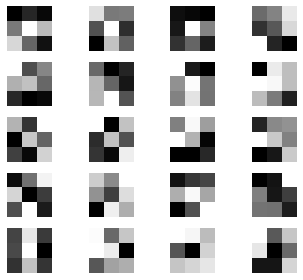

average of absolute gradients 1 tensor(5.2184e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7956e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8216e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4447e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6050e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3446e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2047e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9759e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9576e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3477e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5273e-06, device='cuda:0')


 97%|██████████████████████████████████████████████████████████████████████████▊  | 972/1000 [1:21:36<02:18,  4.93s/it]

Epoch: 972
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9341e-01, -1.3130e-01, -1.7925e-01],
         [-1.7806e-04,  2.1496e-01,  1.0513e-01],
         [ 1.5045e-01, -3.1485e-02, -1.6484e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


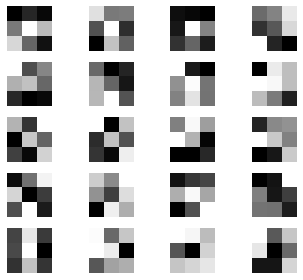

average of absolute gradients 1 tensor(4.7664e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9483e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6672e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4476e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1141e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2815e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5736e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5831e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1319e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4977e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3828e-06, device='cuda:0')


 97%|██████████████████████████████████████████████████████████████████████████▉  | 973/1000 [1:21:41<02:13,  4.93s/it]

Epoch: 973
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9339e-01, -1.3127e-01, -1.7922e-01],
         [-1.5815e-04,  2.1498e-01,  1.0513e-01],
         [ 1.5050e-01, -3.1484e-02, -1.6482e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


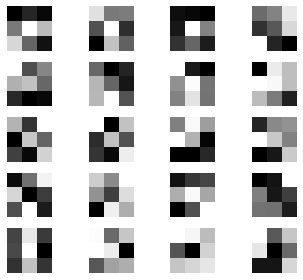

average of absolute gradients 1 tensor(5.0815e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4486e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1218e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1508e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9284e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9784e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0875e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5902e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7453e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4269e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9805e-06, device='cuda:0')


 97%|██████████████████████████████████████████████████████████████████████████▉  | 974/1000 [1:21:46<02:08,  4.94s/it]

Epoch: 974
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9343e-01, -1.3130e-01, -1.7922e-01],
         [-1.7511e-04,  2.1496e-01,  1.0510e-01],
         [ 1.5049e-01, -3.1462e-02, -1.6482e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


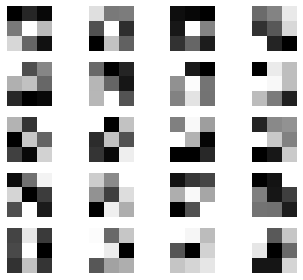

average of absolute gradients 1 tensor(4.9048e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0974e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1440e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6471e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5803e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4117e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5037e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1122e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5103e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9151e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0676e-06, device='cuda:0')


 98%|███████████████████████████████████████████████████████████████████████████  | 975/1000 [1:21:51<02:03,  4.93s/it]

Epoch: 975
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9342e-01, -1.3130e-01, -1.7921e-01],
         [-1.4881e-04,  2.1497e-01,  1.0511e-01],
         [ 1.5046e-01, -3.1480e-02, -1.6480e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


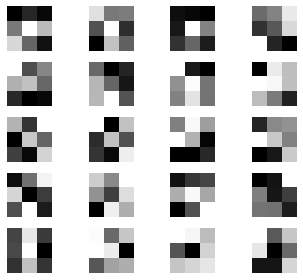

average of absolute gradients 1 tensor(4.8112e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1547e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8258e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1712e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.1739e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7147e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9862e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8006e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7851e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5070e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3125e-06, device='cuda:0')


 98%|███████████████████████████████████████████████████████████████████████████▏ | 976/1000 [1:21:56<01:58,  4.92s/it]

Epoch: 976
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9341e-01, -1.3129e-01, -1.7920e-01],
         [-1.3487e-04,  2.1499e-01,  1.0511e-01],
         [ 1.5047e-01, -3.1458e-02, -1.6479e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


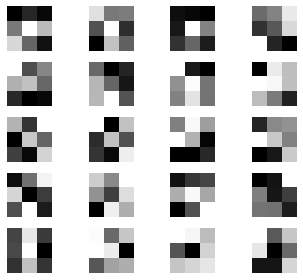

average of absolute gradients 1 tensor(5.5315e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1597e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9048e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8102e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5116e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7367e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8602e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0277e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3033e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5531e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2737e-06, device='cuda:0')


 98%|███████████████████████████████████████████████████████████████████████████▏ | 977/1000 [1:22:01<01:53,  4.93s/it]

Epoch: 977
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9341e-01, -1.3126e-01, -1.7919e-01],
         [-1.3201e-04,  2.1501e-01,  1.0511e-01],
         [ 1.5044e-01, -3.1436e-02, -1.6481e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


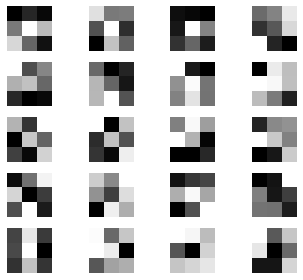

average of absolute gradients 1 tensor(4.0938e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0030e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5000e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6275e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9883e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3958e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2118e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3736e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7225e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5319e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5596e-06, device='cuda:0')


 98%|███████████████████████████████████████████████████████████████████████████▎ | 978/1000 [1:22:06<01:48,  4.93s/it]

Epoch: 978
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9342e-01, -1.3128e-01, -1.7919e-01],
         [-1.3613e-04,  2.1498e-01,  1.0508e-01],
         [ 1.5045e-01, -3.1464e-02, -1.6481e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


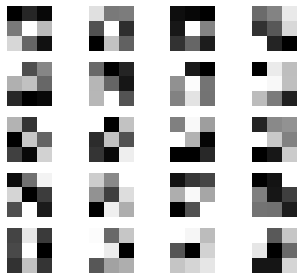

average of absolute gradients 1 tensor(4.6051e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1374e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3905e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4578e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2257e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6268e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5813e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2981e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9885e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0203e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5160e-06, device='cuda:0')


 98%|███████████████████████████████████████████████████████████████████████████▍ | 979/1000 [1:22:11<01:43,  4.92s/it]

Epoch: 979
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9342e-01, -1.3127e-01, -1.7919e-01],
         [-1.3571e-04,  2.1499e-01,  1.0506e-01],
         [ 1.5046e-01, -3.1451e-02, -1.6482e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


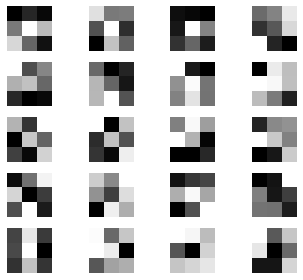

average of absolute gradients 1 tensor(4.5688e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4701e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2599e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5984e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7490e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2118e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3922e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8383e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9617e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.0845e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.9936e-06, device='cuda:0')


 98%|███████████████████████████████████████████████████████████████████████████▍ | 980/1000 [1:22:16<01:38,  4.93s/it]

Epoch: 980
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9343e-01, -1.3129e-01, -1.7919e-01],
         [-1.1350e-04,  2.1497e-01,  1.0504e-01],
         [ 1.5046e-01, -3.1450e-02, -1.6482e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


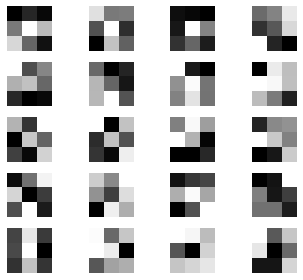

average of absolute gradients 1 tensor(5.0531e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8320e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8377e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9906e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7706e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0375e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2130e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8520e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3972e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3467e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8747e-06, device='cuda:0')


 98%|███████████████████████████████████████████████████████████████████████████▌ | 981/1000 [1:22:20<01:33,  4.92s/it]

Epoch: 981
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9343e-01, -1.3128e-01, -1.7918e-01],
         [-8.8910e-05,  2.1497e-01,  1.0504e-01],
         [ 1.5045e-01, -3.1457e-02, -1.6481e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


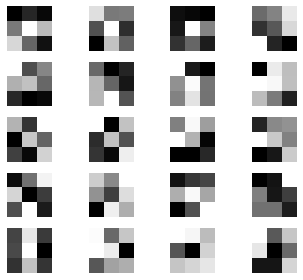

average of absolute gradients 1 tensor(5.1401e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3512e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8660e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4180e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6185e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6030e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5280e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8441e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8447e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4807e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.5519e-06, device='cuda:0')


 98%|███████████████████████████████████████████████████████████████████████████▌ | 982/1000 [1:22:25<01:28,  4.93s/it]

Epoch: 982
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9342e-01, -1.3126e-01, -1.7917e-01],
         [-7.3055e-05,  2.1498e-01,  1.0505e-01],
         [ 1.5047e-01, -3.1443e-02, -1.6480e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


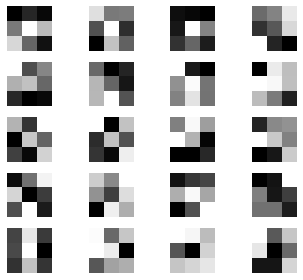

average of absolute gradients 1 tensor(5.1736e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1100e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2919e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7029e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8502e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3857e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9172e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7673e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1150e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6435e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1000e-06, device='cuda:0')


 98%|███████████████████████████████████████████████████████████████████████████▋ | 983/1000 [1:22:30<01:24,  4.95s/it]

Epoch: 983
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9341e-01, -1.3126e-01, -1.7917e-01],
         [-2.9993e-05,  2.1500e-01,  1.0506e-01],
         [ 1.5047e-01, -3.1449e-02, -1.6480e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


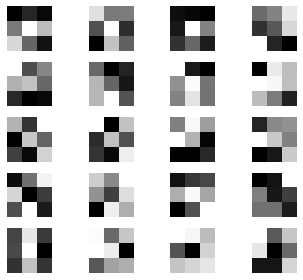

average of absolute gradients 1 tensor(4.3403e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0155e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7473e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2893e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9732e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8118e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2811e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9521e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6956e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6129e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.3557e-06, device='cuda:0')


 98%|███████████████████████████████████████████████████████████████████████████▊ | 984/1000 [1:22:35<01:19,  4.95s/it]

Epoch: 984
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9342e-01, -1.3127e-01, -1.7916e-01],
         [-3.3265e-05,  2.1499e-01,  1.0506e-01],
         [ 1.5046e-01, -3.1447e-02, -1.6478e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


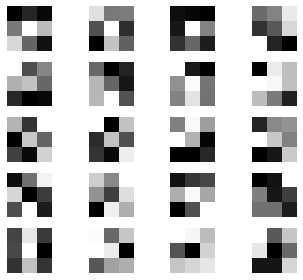

average of absolute gradients 1 tensor(5.7872e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4327e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5854e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5455e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4977e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0761e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3811e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2334e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5956e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8910e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4624e-06, device='cuda:0')


 98%|███████████████████████████████████████████████████████████████████████████▊ | 985/1000 [1:22:40<01:14,  4.94s/it]

Epoch: 985
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9343e-01, -1.3127e-01, -1.7918e-01],
         [-3.1945e-05,  2.1497e-01,  1.0504e-01],
         [ 1.5045e-01, -3.1444e-02, -1.6478e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


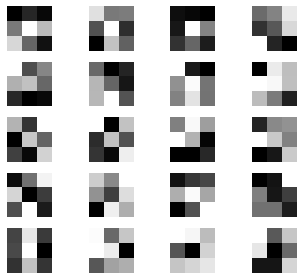

average of absolute gradients 1 tensor(4.6385e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0407e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5570e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0822e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5239e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7146e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5464e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8049e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8713e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.8942e-07, device='cuda:0')
average of absolute gradients 1 tensor(8.2134e-06, device='cuda:0')


 99%|███████████████████████████████████████████████████████████████████████████▉ | 986/1000 [1:22:45<01:09,  4.93s/it]

Epoch: 986
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9341e-01, -1.3127e-01, -1.7917e-01],
         [-3.3171e-05,  2.1499e-01,  1.0505e-01],
         [ 1.5046e-01, -3.1441e-02, -1.6477e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


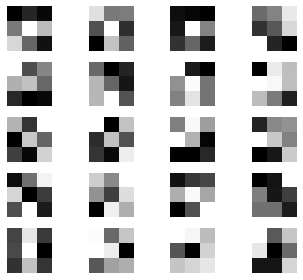

average of absolute gradients 1 tensor(4.8507e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9664e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5904e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6332e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1850e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1816e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1865e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4475e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3236e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4623e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9920e-06, device='cuda:0')


 99%|███████████████████████████████████████████████████████████████████████████▉ | 987/1000 [1:22:50<01:03,  4.92s/it]

Epoch: 987
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9340e-01, -1.3126e-01, -1.7915e-01],
         [-3.3206e-05,  2.1502e-01,  1.0506e-01],
         [ 1.5047e-01, -3.1431e-02, -1.6476e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


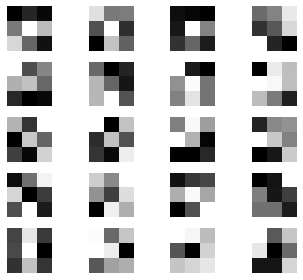

average of absolute gradients 1 tensor(4.5096e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7569e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1467e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9544e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0634e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6080e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0027e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9161e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9710e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0816e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4784e-06, device='cuda:0')


 99%|████████████████████████████████████████████████████████████████████████████ | 988/1000 [1:22:55<00:58,  4.91s/it]

Epoch: 988
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9340e-01, -1.3127e-01, -1.7914e-01],
         [-4.3792e-05,  2.1500e-01,  1.0506e-01],
         [ 1.5047e-01, -3.1450e-02, -1.6477e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


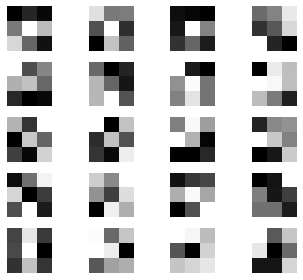

average of absolute gradients 1 tensor(4.0139e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4626e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2196e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8606e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2218e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1548e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2047e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6548e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5241e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2097e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.2059e-06, device='cuda:0')


 99%|████████████████████████████████████████████████████████████████████████████▏| 989/1000 [1:23:00<00:54,  4.92s/it]

Epoch: 989
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9340e-01, -1.3127e-01, -1.7913e-01],
         [-3.9627e-05,  2.1500e-01,  1.0506e-01],
         [ 1.5047e-01, -3.1450e-02, -1.6476e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


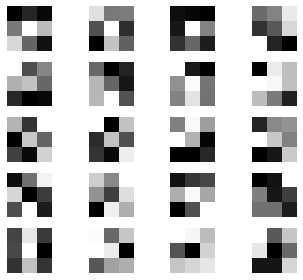

average of absolute gradients 1 tensor(4.2684e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9875e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4142e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7573e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8103e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9661e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6127e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0471e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5742e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8705e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5385e-06, device='cuda:0')


 99%|████████████████████████████████████████████████████████████████████████████▏| 990/1000 [1:23:05<00:49,  4.92s/it]

Epoch: 990
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9340e-01, -1.3127e-01, -1.7913e-01],
         [-2.3350e-05,  2.1500e-01,  1.0507e-01],
         [ 1.5048e-01, -3.1451e-02, -1.6476e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


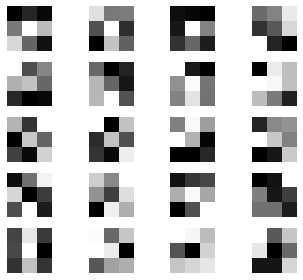

average of absolute gradients 1 tensor(4.6050e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0714e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7126e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8374e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7833e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1123e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.2558e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0129e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8509e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2384e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.8169e-06, device='cuda:0')


 99%|████████████████████████████████████████████████████████████████████████████▎| 991/1000 [1:23:10<00:44,  4.91s/it]

Epoch: 991
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9339e-01, -1.3128e-01, -1.7912e-01],
         [-1.6677e-05,  2.1500e-01,  1.0508e-01],
         [ 1.5048e-01, -3.1459e-02, -1.6475e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


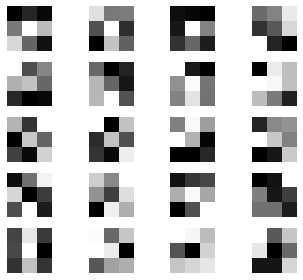

average of absolute gradients 1 tensor(4.5850e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7624e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2226e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0318e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.9433e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9101e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6421e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2347e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.4689e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9936e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4606e-06, device='cuda:0')


 99%|████████████████████████████████████████████████████████████████████████████▍| 992/1000 [1:23:15<00:39,  4.91s/it]

Epoch: 992
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9338e-01, -1.3128e-01, -1.7911e-01],
         [-1.9677e-05,  2.1500e-01,  1.0509e-01],
         [ 1.5048e-01, -3.1466e-02, -1.6475e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


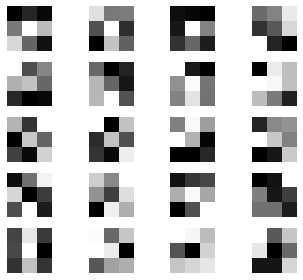

average of absolute gradients 1 tensor(5.0426e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2649e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4875e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7526e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7793e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9031e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7288e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5298e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6183e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4164e-07, device='cuda:0')
average of absolute gradients 1 tensor(2.3230e-06, device='cuda:0')


 99%|████████████████████████████████████████████████████████████████████████████▍| 993/1000 [1:23:20<00:34,  4.92s/it]

Epoch: 993
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9338e-01, -1.3128e-01, -1.7911e-01],
         [-1.8224e-05,  2.1500e-01,  1.0508e-01],
         [ 1.5048e-01, -3.1461e-02, -1.6475e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


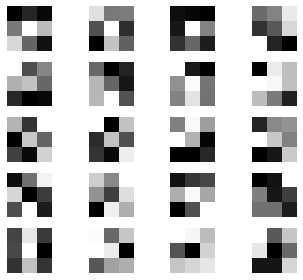

average of absolute gradients 1 tensor(4.1049e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1296e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7621e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2690e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5257e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1473e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7119e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0752e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2058e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7218e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0059e-06, device='cuda:0')


 99%|████████████████████████████████████████████████████████████████████████████▌| 994/1000 [1:23:24<00:29,  4.91s/it]

Epoch: 994
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9338e-01, -1.3128e-01, -1.7912e-01],
         [-2.4388e-05,  2.1499e-01,  1.0507e-01],
         [ 1.5048e-01, -3.1463e-02, -1.6475e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


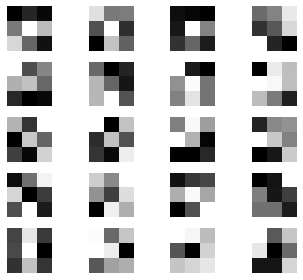

average of absolute gradients 1 tensor(4.7856e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3944e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6036e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3247e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5021e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2355e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0739e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4439e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2302e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3920e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1400e-06, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████▌| 995/1000 [1:23:29<00:24,  4.92s/it]

Epoch: 995
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9339e-01, -1.3129e-01, -1.7912e-01],
         [-2.3726e-05,  2.1498e-01,  1.0506e-01],
         [ 1.5048e-01, -3.1460e-02, -1.6476e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


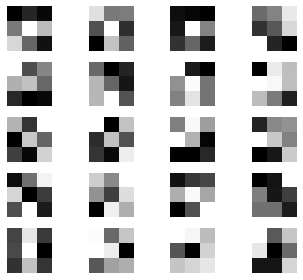

average of absolute gradients 1 tensor(4.2061e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.7514e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6147e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2942e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1045e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8906e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4015e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4862e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9283e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1153e-07, device='cuda:0')
average of absolute gradients 1 tensor(6.9260e-06, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████▋| 996/1000 [1:23:34<00:19,  4.93s/it]

Epoch: 996
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9339e-01, -1.3128e-01, -1.7912e-01],
         [-2.1800e-05,  2.1498e-01,  1.0507e-01],
         [ 1.5048e-01, -3.1457e-02, -1.6476e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


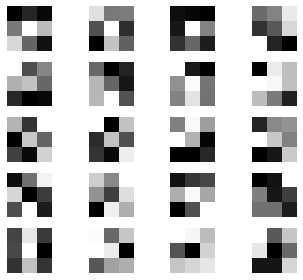

average of absolute gradients 1 tensor(4.2233e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5247e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.4745e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.3619e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.7925e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9584e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0225e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.0957e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3177e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2594e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.0533e-06, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████▊| 997/1000 [1:23:39<00:14,  4.92s/it]

Epoch: 997
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9339e-01, -1.3129e-01, -1.7912e-01],
         [-2.0043e-05,  2.1498e-01,  1.0506e-01],
         [ 1.5048e-01, -3.1460e-02, -1.6476e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


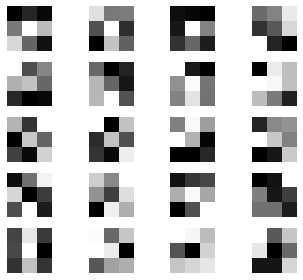

average of absolute gradients 1 tensor(5.1665e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6455e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2571e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1128e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.1266e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2899e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1715e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4551e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3772e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.5545e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5720e-06, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████▊| 998/1000 [1:23:44<00:09,  4.92s/it]

Epoch: 998
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9339e-01, -1.3129e-01, -1.7911e-01],
         [-2.1860e-05,  2.1498e-01,  1.0506e-01],
         [ 1.5048e-01, -3.1458e-02, -1.6476e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


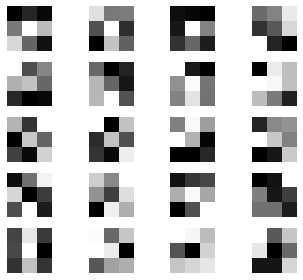

average of absolute gradients 1 tensor(5.3444e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.2208e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3433e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.6931e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.0381e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.9138e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5866e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.8261e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6371e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.3145e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.5649e-06, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████▉| 999/1000 [1:23:49<00:04,  4.92s/it]

Epoch: 999
Accuracy of train set: 27%
Accuracy of test set: 11%

tensor([[[-1.9339e-01, -1.3129e-01, -1.7912e-01],
         [-2.2040e-05,  2.1498e-01,  1.0506e-01],
         [ 1.5048e-01, -3.1457e-02, -1.6476e-01]]], device='cuda:0',
       grad_fn=<SliceBackward>)
stuff


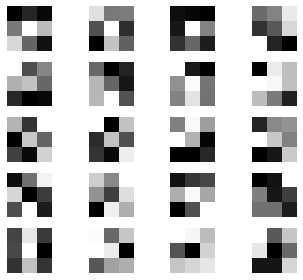

average of absolute gradients 1 tensor(4.4111e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2347e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.6767e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.1350e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.8536e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.7965e-07, device='cuda:0')
average of absolute gradients 1 tensor(4.4338e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.9091e-07, device='cuda:0')
average of absolute gradients 1 tensor(5.2566e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.5697e-07, device='cuda:0')
average of absolute gradients 1 tensor(3.1674e-06, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:23:54<00:00,  5.03s/it]

Epoch: 1000
Accuracy of train set: 27%
Accuracy of test set: 11%



In [18]:
# Initialize training network

std_w = 0.1
std_b = 0.5
epochs = 1000
learning_rate = np.linspace(0.1, 0.0001, num=epochs, endpoint=True)

net = DeepCNet()

# Initialize weight, bias, Needs recoding for generalisation
conv_layers = [net.conv1, net.conv2, net.conv3, net.conv4, net.conv5]#, net.conv6]
lin_layers = [net.fc]

#optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr= learning_rate)


criterion = nn.CrossEntropyLoss()


# Define list to store losses and performances of each iteration
train_losses = []
train_losses2 = []
train_accs = []
test_accs = []

# Try using gpu instead of cpu
device = try_gpu()
print("====================================")
print(device)
print("====================================")

for epoch in tqdm(range(epochs)):
    optimizer = torch.optim.SGD(net.parameters(),lr = learning_rate[epoch]
                                , momentum = 0.9, weight_decay = 1e-4,nesterov = True )

    # Network in training mode and to device
    net.train()
    net.to(device)

    # Training loop
    for i, (x_batch, y_batch) in enumerate(train_loader):
    #for x_batch, y_batch in train_loader:
        # Set to same device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch = x_batch[:, None,:,:]
        
        # Set the gradients to zero
        
        optimizer.zero_grad()
        if i==0:
            print(net.conv1.weight[0,:,:,:])
        
        # Plot the weights of sample 1, conv1, every epoch
        if i==0:
            weights_cpu = net.conv1.weight.cpu().detach()
            print('stuff')
            plotweights(weights_cpu)

        # Perform forward pass
        y_pred = net(x_batch)
        # Compute the loss
        loss = criterion(y_pred, y_batch)
        train_losses.append(loss)
        
        #if i ==0:
            #print(loss)
            #print(y_pred[1,:])

        # Backward computation and update
        loss.backward()
        optimizer.step()

    # Compute train and test error
    train_acc = 100*evaluate_accuracy(train_loader, net.to('cpu'))
    test_acc = 100*evaluate_accuracy(test_loader, net.to('cpu'))
    
    # Development of performance
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    train_losses2.append(loss)

    # Print performance
    print('Epoch: {:.0f}'.format(epoch+1))
    print('Accuracy of train set: {:.00f}%'.format(train_acc))
    print('Accuracy of test set: {:.00f}%'.format(test_acc))
    print('')

tensor(5.2095, grad_fn=<CopyBackwards>)


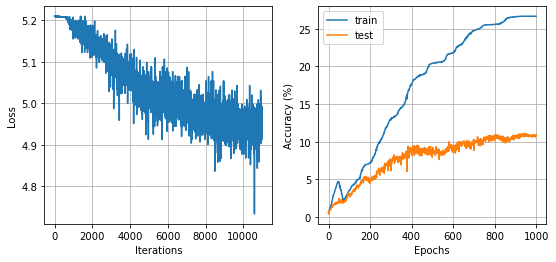

In [19]:
print(train_losses[0].cpu())

train_losses_CPU = [x.cpu().detach() for x in train_losses]

plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(train_losses_CPU)
plt.grid()

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.plot(train_accs, label = 'train')
plt.plot(test_accs, label = 'test')
plt.legend()
plt.grid()

In [ ]:
print(train_losses[0].cpu())

train_losses_CPU2 = [x.cpu().detach() for x in train_losses]

plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(train_losses_CPU2)
plt.grid()

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.plot(train_accs, label = 'train')
plt.plot(test_accs, label = 'test')
plt.legend()
plt.grid()

In [ ]:
print(train_accs[-1], test_accs[-1])